In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score
from tqdm import tqdm
import sys
sys.path.extend(["..", "../../backbone","../.."])
from backbones import DenseNet201
from backbones import ResNet152d
from dataloader import create_dataloader
from metric import Metric
from ctran2 import CTranEncoder2
torch.cuda.empty_cache()
from tabulate import tabulate
# from torchsummary import summary

# Set device to GPU if available, else use CPU
device = torch.device("cuda")
print(f"Current device: {torch.cuda.get_device_name(torch.cuda.current_device())}" if torch.cuda.is_available() else "Current device: CPU")

Current device: NVIDIA A100 80GB PCIe


In [2]:
# Define hyperparameters
batch_size = 16
num_epochs = 200
learning_rate = 0.000001
image_size = 384
num_workers = 8
num_labels = 21
num_layers = 8
embed_dim = 960
mlp_dim = 1024
thresholds = [0.5] * num_labels
num_classes = 21
data_dir = '../../../../data/GT-main'

In [3]:
# Create dataloaders
train_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='train')
val_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='val')
test_dataloader = create_dataloader(data_dir=data_dir, batch_size=batch_size, num_workers=num_workers, size=image_size, phase='test')

384
../../../../data/GT-main/./set1/train.csv
384
../../../../data/GT-main/./set1/val.csv
384
../../../../data/GT-main/./set1/test.csv


In [4]:
# Define model and optimizer
backbone1 = DenseNet201(num_classes=num_classes, embed_dim=embed_dim)
backbone2 = ResNet152d(num_classes=num_classes, embed_dim=embed_dim)
model = CTranEncoder2(num_classes=num_classes, embed_dim=embed_dim, num_layers=num_layers, num_heads=num_workers, 
                       backbone1=backbone1, backbone2=backbone2)
model.to(device)
num_params = sum(p.numel() for p in model.parameters())
print(num_params)

# Wrap your model with DataParallel
# model = nn.DataParallel(model, device_ids=[0, 1, 2, 3])
criterion = nn.BCEWithLogitsLoss()
# criterion = FocalLoss(gamma=2, alpha=0.25, reduction='mean')

# Create a single optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-6)

# Create a single scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, epochs= num_epochs, steps_per_epoch=len(train_dataloader))

/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deependra/project/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/deependra/project/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but se

259153354


In [5]:
# Initialize Metric class
metric = Metric(num_classes=num_classes)
thresholds = None

# create empty lists to store predicted probabilities and true labels for each epoch
test_preds_all, test_labels_all = [], []

# define the epochs at which to plot the ROC curve
roc_epochs = [5,10,20,30,40,50,60,70,80,90,100,120,140,160,180,200]

# create empty lists to store ROC data for each epoch
roc_fpr = []
roc_tpr = []
roc_auc = []
f1_arr = []
loss_arr = []
model_arr = []
max_ms = [0,0,0]
a,b = 0.4,0.6

# Train and evaluate model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    print('-' * 10)

    # Train phase
    model.train()
    optimizer.zero_grad()
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) 
        outputs = torch.sigmoid(outputs)

        loss.backward()
        optimizer.step()

        with torch.no_grad(): metric.update(outputs, labels)
    
     # Print metrics on train set
    ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score, acc_list, spec_list, thresh = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    # Reset Metric class for evaluation
    metric.reset() 

    # Evaluate model on validation set
    model.eval()
    running_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_dataloader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)
            
            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            val_preds += outputs.tolist()
            val_labels += labels.tolist()
            metric.update(outputs, labels)
 
        # Print metrics on validation set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute()
        print(f"Val - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()   
    print(thresh)   
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}')
    
     # Evaluate model on test set
    running_loss = 0.0
    test_preds, test_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_dataloader):
            images, labels = images.to(device), labels.to(device)
 
            outputs = model(images)

            running_loss += criterion(outputs, labels).item()
            outputs = torch.sigmoid(outputs)
            metric.update(outputs, labels)

            # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
            test_preds += outputs.tolist()
            test_labels += labels.tolist()
 
        # Print metrics on test set
        ml_f1_score, map_score, auc_score, ml_map_score, ml_auc_score, ml_score, bin_auc, model_score, bin_f1_score,  acc_list, spec_list, thresh = metric.compute(thresholds = thresh)
        print(f"Test - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, ML mAP: {ml_map_score:.4f}, ML F1: {ml_f1_score:.4f}, ML AUC: {ml_auc_score:.4f}, ML Score: {ml_score:.4f}, Bin AUC: {bin_auc:.4f}, Model Score: {model_score:.4f}, Bin F1: {bin_f1_score:.4f}")
        
        f1_arr.append(ml_f1_score)
        model_arr.append(model_score)
        loss_arr.append(running_loss / len(test_dataloader))
        
        if max_ms[0] < model_score: 
            max_ms[0] = model_score
            max_ms[1] = epoch
            max_ms[2] = optimizer.param_groups[0]['lr']
            torch.save(model, 'model/en2-js.pth')

        # append the predicted probabilities and true labels for this epoch to the lists for all epochs
        test_preds_all.append(test_preds)
        test_labels_all.append(test_labels)

        # check if the current epoch is in the list of epochs to plot ROC curve
        if epoch+1 in roc_epochs:
            # calculate ROC curve and AUC score for test set
            fpr, tpr, roc_thresholds = roc_curve(np.concatenate(test_labels_all).ravel(), np.concatenate(test_preds_all).ravel())
            roc_fpr.append(fpr)
            roc_tpr.append(tpr)
            roc_auc.append(auc(fpr, tpr))
        # Reset Metric class for next epoch
        metric.reset()
        del images
        del labels
        del outputs
        torch.cuda.empty_cache()     
    
    print(thresh)
    print(f'Accuracy list: {acc_list}')   
    print(f'Specificity list: {spec_list}') 
    print()      
    # Step the learning rate scheduler
    scheduler.step() 

Epoch 1/200
----------


100%|██████████| 125/125 [01:40<00:00,  1.24it/s]


Epoch [1/200], Loss: 0.2270, ML mAP: 0.0976, ML F1: 0.8377, ML AUC: 0.5591, ML Score: 0.3284, Bin AUC: 0.0000, Model Score: 0.1642, Bin F1: 1.0000
[0.66 0.59 0.87 0.65 0.58 0.55 0.61 0.68 0.63 0.63 0.61 0.53 0.59 0.63
 0.64 0.53 0.62 0.66 0.64 0.63 0.62]
Accuracy list: [0.8784392196098049, 0.951975987993997, 0.9034517258629314, 0.8934467233616809, 0.8774387193596799, 0.8364182091045522, 0.9309654827413707, 0.9179589794897449, 0.9429714857428715, 0.9319659829914958, 0.9389694847423712, 0.8789394697348675, 0.9459729864932466, 0.951975987993997, 0.9429714857428715, 0.9409704852426213, 0.9409704852426213, 0.9394697348674337, 0.9424712356178089, 0.904952476238119, 0.951975987993997]
Specificity list: [0.9994308480364257, 0.9984260230849947, 0.9994465965688988, 0.9988814317673378, 0.9579878385848535, 0.9407023603914796, 0.9994629430719656, 0.9994553376906318, 0.9994697773064687, 0.9994635193133047, 0.9994675186368477, 0.9384196185286103, 0.9994714587737844, 0.9994747899159664, 0.999469777306

100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [1/200], Loss: 6.4085, ML mAP: 0.1950, ML F1: 0.8123, ML AUC: 0.7309, ML Score: 0.4630, Bin AUC: 0.2500, Model Score: 0.3565, Bin F1: 0.0000
[0.24 0.24 0.61 0.44 0.35 0.43 0.3  0.41 0.24 0.34 0.26 0.46 0.27 0.36
 0.27 0.2  0.36 0.31 0.35 0.17 0.42]
Accuracy list: [0.8132118451025057, 0.7927107061503417, 0.9271070615034168, 0.89749430523918, 0.7699316628701595, 0.9407744874715261, 0.9384965831435079, 0.9567198177676538, 0.9681093394077449, 0.9749430523917996, 0.9772209567198178, 0.9726651480637813, 0.9772209567198178, 0.9681093394077449, 0.9772209567198178, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9703872437357631, 0.8246013667425968, 0.9886104783599089]
Specificity list: [0.8687150837988827, 0.9418960244648318, 0.9975490196078431, 0.9949494949494949, 0.7799511002444988, 0.9975845410628019, 0.9975786924939467, 0.997624703087886, 0.9976525821596244, 0.9953488372093023, 0.9953596287703016, 0.9767981438515081, 0.9976744186046511, 0.9953161592505855, 1.0, 0.

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [1/200], Loss: 6.1337, ML mAP: 0.1832, ML F1: 0.4695, ML AUC: 0.7324, ML Score: 0.4578, Bin AUC: 0.2500, Model Score: 0.3539, Bin F1: 0.0000
[0.24 0.24 0.61 0.44 0.35 0.43 0.3  0.41 0.24 0.34 0.26 0.46 0.27 0.36
 0.27 0.2  0.36 0.31 0.35 0.17 0.42]
Accuracy list: [0.8033175355450237, 0.8222748815165877, 0.9218009478672986, 0.8933649289099526, 0.7559241706161137, 0.9383886255924171, 0.9478672985781991, 0.9549763033175356, 0.9620853080568721, 0.9691943127962085, 0.985781990521327, 0.9739336492890995, 0.9691943127962085, 0.9715639810426541, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.990521327014218, 0.9620853080568721, 0.8104265402843602, 0.976303317535545]
Specificity list: [0.8526011560693642, 0.961038961038961, 0.9948849104859335, 0.9921052631578947, 0.7626262626262627, 1.0, 1.0, 0.9975186104218362, 0.9950980392156863, 0.9975609756097561, 1.0, 0.9903147699757869, 0.9975609756097561, 0.9927360774818402, 1.0, 0.9903614457831326, 0.9832935560859188, 1.0, 0.9

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


Epoch [2/200], Loss: 0.1531, ML mAP: 0.3409, ML F1: 0.6085, ML AUC: 0.8271, ML Score: 0.5840, Bin AUC: 0.8684, Model Score: 0.7262, Bin F1: 0.0000
[0.35 0.16 0.22 0.26 0.8  0.29 0.38 0.26 0.1  0.17 0.14 0.38 0.15 0.52
 0.24 0.49 0.15 0.76 0.56 0.43 0.34]
Accuracy list: [0.8604302151075538, 0.8969484742371185, 0.8769384692346173, 0.8664332166083042, 0.8984492246123061, 0.8754377188594297, 0.9314657328664332, 0.9144572286143071, 0.8314157078539269, 0.8569284642321161, 0.8899449724862432, 0.9529764882441221, 0.9289644822411206, 0.951975987993997, 0.9189594797398699, 0.9464732366183092, 0.8744372186093047, 0.9354677338669335, 0.9384692346173087, 0.9034517258629314, 0.976488244122061]
Specificity list: [0.9345029239766082, 0.9152093269740329, 0.9137083560895686, 0.9231197771587744, 0.9994435169727324, 0.9204997160704146, 0.9989270386266095, 0.9396739130434782, 0.8636363636363636, 0.8996222342147868, 0.9170628631801373, 0.9737687366167024, 0.9653725078698846, 0.9994747899159664, 0.9470021413

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [2/200], Loss: 4.6055, ML mAP: 0.3606, ML F1: 0.7121, ML AUC: 0.8568, ML Score: 0.6087, Bin AUC: 1.0000, Model Score: 0.8044, Bin F1: 1.0000
[0.3  0.32 0.4  0.8  0.38 0.84 0.46 0.93 0.31 0.47 0.52 0.67 0.29 0.44
 0.57 0.41 0.52 0.52 0.31 0.61 0.71]
Accuracy list: [0.8952164009111617, 0.8473804100227791, 0.9248291571753986, 0.8997722095671982, 0.9225512528473804, 0.9407744874715261, 0.9384965831435079, 0.9567198177676538, 0.9681093394077449, 0.9817767653758542, 0.979498861047836, 0.9931662870159453, 0.9681093394077449, 0.9749430523917996, 0.9681093394077449, 0.9863325740318907, 0.9817767653758542, 0.9840546697038725, 0.9476082004555809, 0.8883826879271071, 1.0]
Specificity list: [0.9217877094972067, 0.9235474006116208, 0.9534313725490197, 0.9974747474747475, 0.9437652811735942, 0.9975845410628019, 0.9975786924939467, 0.997624703087886, 0.9976525821596244, 1.0, 0.9976798143851509, 0.9953596287703016, 0.9767441860465116, 1.0, 0.9836448598130841, 1.0, 0.9953810623556582, 0.9976

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [2/200], Loss: 4.5654, ML mAP: 0.3235, ML F1: 0.5133, ML AUC: 0.8408, ML Score: 0.5821, Bin AUC: 0.8000, Model Score: 0.6911, Bin F1: 1.0000
[0.3  0.32 0.4  0.8  0.38 0.84 0.46 0.93 0.31 0.47 0.52 0.67 0.29 0.44
 0.57 0.41 0.52 0.52 0.31 0.61 0.71]
Accuracy list: [0.8720379146919431, 0.8578199052132701, 0.9028436018957346, 0.9004739336492891, 0.8909952606635071, 0.9407582938388626, 0.9478672985781991, 0.9620853080568721, 0.95260663507109, 0.966824644549763, 0.9881516587677726, 0.9834123222748815, 0.9454976303317536, 0.976303317535545, 0.966824644549763, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.9312796208530806, 0.909952606635071, 0.9976303317535545]
Specificity list: [0.8930635838150289, 0.9253246753246753, 0.9360613810741688, 1.0, 0.9065656565656566, 1.0, 1.0, 1.0, 0.9852941176470589, 0.9951219512195122, 1.0, 0.9927360774818402, 0.9658536585365853, 0.9975786924939467, 0.9784172661870504, 1.0, 0.9976133651551312, 0.992822966507177, 0.9536585365853658, 1

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [3/200], Loss: 0.1662, ML mAP: 0.4876, ML F1: 0.7419, ML AUC: 0.8919, ML Score: 0.6897, Bin AUC: 0.9737, Model Score: 0.8317, Bin F1: 0.6667
[0.38 0.31 0.91 0.19 0.26 0.35 0.2  0.39 0.35 0.41 0.28 0.4  0.54 0.27
 0.9  0.64 0.78 0.75 0.27 0.23 0.51]
Accuracy list: [0.9059529764882441, 0.9544772386193097, 0.9034517258629314, 0.8209104552276139, 0.8884442221110556, 0.9064532266133066, 0.8824412206103052, 0.9514757378689345, 0.9459729864932466, 0.9344672336168084, 0.9464732366183092, 0.9664832416208105, 0.9574787393696849, 0.9574787393696849, 0.9369684842421211, 0.9604802401200601, 0.9289644822411206, 0.9334667333666833, 0.9329664832416208, 0.8689344672336168, 0.9979989994997499]
Specificity list: [0.9559420289855073, 0.980412916887242, 0.9994465965688988, 0.8494683827644096, 0.9086834733893557, 0.9409701928696669, 0.9225352112676056, 0.9725067385444744, 0.9989434759640782, 0.9994649545211343, 0.969198088157196, 0.9772234273318872, 0.9994778067885117, 0.9779874213836478, 0.9994663820

100%|██████████| 28/28 [00:08<00:00,  3.25it/s]


Val - Epoch [3/200], Loss: 4.2390, ML mAP: 0.4255, ML F1: 0.7066, ML AUC: 0.8876, ML Score: 0.6565, Bin AUC: 1.0000, Model Score: 0.8283, Bin F1: 1.0000
[0.34 0.16 0.17 0.4  0.34 0.63 0.66 0.11 0.19 0.37 0.69 0.51 0.3  0.65
 0.65 0.32 0.42 0.61 0.49 0.15 0.59]
Accuracy list: [0.9157175398633257, 0.835990888382688, 0.9020501138952164, 0.9111617312072893, 0.9043280182232346, 0.9635535307517085, 0.9384965831435079, 0.9476082004555809, 0.9339407744874715, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.9817767653758542, 0.9840546697038725, 0.9772209567198178, 0.8200455580865603, 0.9977220956719818]
Specificity list: [0.9385474860335196, 0.9021406727828746, 0.9240196078431373, 0.9747474747474747, 0.9168704156479217, 0.9903381642512077, 0.9975786924939467, 0.9572446555819477, 0.9507042253521126, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [3/200], Loss: 4.0766, ML mAP: 0.4184, ML F1: 0.4756, ML AUC: 0.8843, ML Score: 0.6513, Bin AUC: 0.7000, Model Score: 0.6757, Bin F1: 1.0000
[0.34 0.16 0.17 0.4  0.34 0.63 0.66 0.11 0.19 0.37 0.69 0.51 0.3  0.65
 0.65 0.32 0.42 0.61 0.49 0.15 0.59]
Accuracy list: [0.8886255924170616, 0.8364928909952607, 0.9312796208530806, 0.8838862559241706, 0.8909952606635071, 0.9454976303317536, 0.9502369668246445, 0.9170616113744076, 0.9478672985781991, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.9715639810426541, 0.9834123222748815, 0.9928909952606635, 0.9715639810426541, 0.9691943127962085, 0.8270142180094787, 0.995260663507109]
Specificity list: [0.9219653179190751, 0.8961038961038961, 0.9539641943734015, 0.9473684210526315, 0.9015151515151515, 0.9924242424242424, 1.0, 0.9255583126550868, 0.9681372549019608, 1.0, 0.9927884615384616, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9808153477218226, 1.0, 0.997613365

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


Epoch [4/200], Loss: 0.1256, ML mAP: 0.5865, ML F1: 0.5883, ML AUC: 0.9195, ML Score: 0.7530, Bin AUC: 0.9500, Model Score: 0.8515, Bin F1: 0.6667
[0.45 0.36 0.24 0.29 0.33 0.42 0.25 0.34 0.21 0.19 0.34 0.31 0.21 0.5
 0.43 0.23 0.33 0.28 0.3  0.19 0.43]
Accuracy list: [0.9179589794897449, 0.9544772386193097, 0.9109554777388694, 0.8744372186093047, 0.9109554777388694, 0.9279639819909955, 0.9144572286143071, 0.9539769884942472, 0.9399699849924963, 0.8694347173586794, 0.968984492246123, 0.9759879939969985, 0.9504752376188094, 0.9749874937468734, 0.9664832416208105, 0.9414707353676839, 0.9379689844922461, 0.9414707353676839, 0.9459729864932466, 0.8749374687343672, 0.9964982491245623]
Specificity list: [0.9716763005780347, 0.979840848806366, 0.9363686231486561, 0.9256983240223464, 0.9459910913140311, 0.9619750283768445, 0.9501340482573727, 0.971211298207496, 0.9741288278775079, 0.908745247148289, 0.9840848806366048, 0.9815518176885513, 0.9753021544929059, 0.9952731092436975, 0.9834313201496

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [4/200], Loss: 3.7316, ML mAP: 0.4748, ML F1: 0.7505, ML AUC: 0.9015, ML Score: 0.6882, Bin AUC: 0.9500, Model Score: 0.8191, Bin F1: 1.0000
[0.56 0.14 0.31 0.56 0.47 0.18 0.46 0.84 0.24 0.35 0.61 0.17 0.18 0.37
 0.7  0.65 0.43 0.45 0.61 0.45 0.74]
Accuracy list: [0.9362186788154897, 0.876993166287016, 0.9362186788154897, 0.8997722095671982, 0.9225512528473804, 0.9681093394077449, 0.9384965831435079, 0.9567198177676538, 0.9749430523917996, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9817767653758542, 0.9749430523917996, 0.9840546697038725, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8861047835990888, 1.0]
Specificity list: [0.9776536312849162, 0.9235474006116208, 0.9681372549019608, 0.9974747474747475, 0.9462102689486552, 0.9927536231884058, 0.9975786924939467, 0.997624703087886, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9906976744186047, 0.9765807962529274, 1.0, 0.99305555555555

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [4/200], Loss: 3.6576, ML mAP: 0.4381, ML F1: 0.5103, ML AUC: 0.9031, ML Score: 0.6706, Bin AUC: 0.7500, Model Score: 0.7103, Bin F1: 1.0000
[0.56 0.14 0.31 0.56 0.47 0.18 0.46 0.84 0.24 0.35 0.61 0.17 0.18 0.37
 0.7  0.65 0.43 0.45 0.61 0.45 0.74]
Accuracy list: [0.9052132701421801, 0.8601895734597157, 0.9383886255924171, 0.9028436018957346, 0.919431279620853, 0.9407582938388626, 0.9502369668246445, 0.9620853080568721, 0.9715639810426541, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.976303317535545, 0.9739336492890995, 0.9691943127962085, 0.9786729857819905, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.8886255924170616, 1.0]
Specificity list: [0.953757225433526, 0.8961038961038961, 0.9641943734015346, 1.0, 0.9318181818181818, 0.9873737373737373, 1.0, 1.0, 0.9975490196078431, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 0.9829268292682927, 0.9830508474576272, 0.9784172661870504, 0.9927710843373494, 0.9976133651551312, 0.988038

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch [5/200], Loss: 0.1585, ML mAP: 0.6761, ML F1: 0.6875, ML AUC: 0.9414, ML Score: 0.8088, Bin AUC: 0.9500, Model Score: 0.8794, Bin F1: 0.0000
[0.42 0.45 0.3  0.29 0.39 0.42 0.31 0.46 0.22 0.19 0.34 0.42 0.34 0.43
 0.41 0.78 0.33 0.92 0.32 0.32 0.32]
Accuracy list: [0.9249624812406203, 0.9739869934967483, 0.9324662331165583, 0.894447223611806, 0.9379689844922461, 0.9354677338669335, 0.919959979989995, 0.968984492246123, 0.9364682341170585, 0.8749374687343672, 0.9634817408704353, 0.9759879939969985, 0.9749874937468734, 0.9809904952476238, 0.9639819909954978, 0.9584792396198099, 0.9419709854927464, 0.9269634817408704, 0.9629814907453726, 0.9029514757378689, 0.9974987493746873]
Specificity list: [0.9677797305213826, 0.9921424829753798, 0.9588075880758807, 0.9317803660565723, 0.9635761589403974, 0.968607305936073, 0.9544456641053787, 0.9832160259880888, 0.9625668449197861, 0.9116855142703285, 0.9787460148777896, 0.987601078167116, 0.9937205651491365, 0.9926082365364308, 0.9823623730625

100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [5/200], Loss: 3.8817, ML mAP: 0.5130, ML F1: 0.7111, ML AUC: 0.9238, ML Score: 0.7184, Bin AUC: 0.9500, Model Score: 0.8342, Bin F1: 1.0000
[0.36 0.16 0.5  0.52 0.66 0.52 0.26 0.69 0.17 0.52 0.72 0.45 0.27 0.88
 0.71 0.82 0.71 0.6  0.91 0.42 0.7 ]
Accuracy list: [0.9430523917995444, 0.8792710706150342, 0.9339407744874715, 0.89749430523918, 0.929384965831435, 0.9658314350797267, 0.908883826879271, 0.9726651480637813, 0.9703872437357631, 0.979498861047836, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9863325740318907, 0.9749430523917996, 0.9817767653758542, 0.9840546697038725, 0.9840546697038725, 0.9772209567198178, 0.8952164009111617, 1.0]
Specificity list: [0.9748603351955307, 0.8868501529051988, 0.9583333333333334, 0.9343434343434344, 0.9975550122249389, 0.9903381642512077, 0.9394673123486683, 0.9857482185273159, 0.9859154929577465, 0.9953488372093023, 0.9976798143851509, 0.9907192575406032, 0.9976744186046511, 0.9929742388758782, 0.985981308411215, 0.997

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [5/200], Loss: 3.7575, ML mAP: 0.4933, ML F1: 0.5453, ML AUC: 0.9180, ML Score: 0.7057, Bin AUC: 0.8500, Model Score: 0.7778, Bin F1: 0.5000
[0.36 0.16 0.5  0.52 0.66 0.52 0.26 0.69 0.17 0.52 0.72 0.45 0.27 0.88
 0.71 0.82 0.71 0.6  0.91 0.42 0.7 ]
Accuracy list: [0.9146919431279621, 0.8672985781990521, 0.933649289099526, 0.9028436018957346, 0.9407582938388626, 0.9454976303317536, 0.9004739336492891, 0.9715639810426541, 0.9597156398104265, 0.966824644549763, 0.9834123222748815, 0.9786729857819905, 0.981042654028436, 0.976303317535545, 0.9786729857819905, 0.9786729857819905, 0.995260663507109, 0.985781990521327, 0.9715639810426541, 0.8933649289099526, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.8733766233766234, 0.969309462915601, 0.9368421052631579, 1.0, 0.98989898989899, 0.935, 0.9851116625310173, 0.9852941176470589, 0.9951219512195122, 0.9855769230769231, 0.9854721549636803, 0.9951219512195122, 0.9927360774818402, 0.9856115107913669, 0.9951807228915662, 

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


Epoch [6/200], Loss: 0.1019, ML mAP: 0.7484, ML F1: 0.7288, ML AUC: 0.9549, ML Score: 0.8517, Bin AUC: 0.9000, Model Score: 0.8758, Bin F1: 1.0000
[0.32 0.26 0.35 0.37 0.42 0.48 0.27 0.48 0.25 0.18 0.43 0.34 0.27 0.39
 0.52 0.3  0.44 0.33 0.22 0.91 0.31]
Accuracy list: [0.9304652326163082, 0.9589794897448725, 0.9369684842421211, 0.9174587293646823, 0.9419709854927464, 0.9479739869934968, 0.9334667333666833, 0.9729864932466233, 0.9459729864932466, 0.8809404702351176, 0.9784892446223111, 0.984992496248124, 0.9734867433716858, 0.9814907453726863, 0.9794897448724362, 0.9724862431215607, 0.9654827413706853, 0.9694847423711856, 0.9639819909954978, 0.897448724362181, 0.9964982491245623]
Specificity list: [0.9541809851088202, 0.9747102212855637, 0.9646604086140254, 0.9558823529411765, 0.971978021978022, 0.9807583474816073, 0.9611859838274932, 0.9893048128342246, 0.972310969116081, 0.9068522483940042, 0.9899577167019028, 0.9882037533512065, 0.9884332281808622, 0.9894347596407819, 0.9936, 0.9793

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [6/200], Loss: 3.2839, ML mAP: 0.5665, ML F1: 0.6911, ML AUC: 0.9333, ML Score: 0.7499, Bin AUC: 1.0000, Model Score: 0.8750, Bin F1: 1.0000
[0.42 0.21 0.26 0.98 0.78 0.68 0.21 0.95 0.26 0.41 0.34 0.78 0.32 0.78
 0.74 0.64 0.71 0.85 0.36 0.23 0.5 ]
Accuracy list: [0.9476082004555809, 0.89749430523918, 0.9202733485193622, 0.8997722095671982, 0.929384965831435, 0.9726651480637813, 0.8997722095671982, 0.9567198177676538, 0.979498861047836, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9840546697038725, 0.9863325740318907, 0.9863325740318907, 0.9863325740318907, 0.9817767653758542, 0.9726651480637813, 0.8929384965831435, 1.0]
Specificity list: [0.9748603351955307, 0.9327217125382263, 0.9387254901960784, 0.9974747474747475, 0.9975550122249389, 0.9903381642512077, 0.9176755447941889, 0.997624703087886, 0.9882629107981221, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.9906976744186047, 0.9929742388758782, 0.9976635514018691, 0.993

100%|██████████| 27/27 [00:07<00:00,  3.55it/s]


Test - Epoch [6/200], Loss: 3.2738, ML mAP: 0.5226, ML F1: 0.5625, ML AUC: 0.9250, ML Score: 0.7238, Bin AUC: 0.9500, Model Score: 0.8369, Bin F1: 0.6667
[0.42 0.21 0.26 0.98 0.78 0.68 0.21 0.95 0.26 0.41 0.34 0.78 0.32 0.78
 0.74 0.64 0.71 0.85 0.36 0.23 0.5 ]
Accuracy list: [0.9241706161137441, 0.8909952606635071, 0.933649289099526, 0.9004739336492891, 0.9502369668246445, 0.9478672985781991, 0.8909952606635071, 0.9620853080568721, 0.976303317535545, 0.966824644549763, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9834123222748815, 0.9620853080568721, 0.8815165876777251, 0.9976303317535545]
Specificity list: [0.9682080924855492, 0.9285714285714286, 0.9539641943734015, 1.0, 0.9974747474747475, 0.9848484848484849, 0.91, 1.0, 0.9877450980392157, 0.9951219512195122, 0.9879807692307693, 0.9927360774818402, 0.9951219512195122, 0.9975786924939467, 0.9928057553956835, 0.9927710843373494, 0.997613365155

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [7/200], Loss: 0.1189, ML mAP: 0.7931, ML F1: 0.7405, ML AUC: 0.9647, ML Score: 0.8789, Bin AUC: 0.9737, Model Score: 0.9263, Bin F1: 0.6667
[0.38 0.24 0.31 0.4  0.27 0.48 0.41 0.49 0.32 0.26 0.36 0.46 0.43 0.42
 0.47 0.32 0.4  0.31 0.33 0.3  0.53]
Accuracy list: [0.9549774887443722, 0.9649824912456229, 0.9424712356178089, 0.9324662331165583, 0.9429714857428715, 0.9499749874937469, 0.9454727363681841, 0.9759879939969985, 0.9584792396198099, 0.9479739869934968, 0.9854927463731866, 0.9809904952476238, 0.976488244122061, 0.9854927463731866, 0.9854927463731866, 0.9744872436218109, 0.9674837418709354, 0.9699849924962481, 0.9629814907453726, 0.9164582291145573, 0.9984992496248124]
Specificity list: [0.9799771167048055, 0.979002624671916, 0.9649122807017544, 0.9694274596998332, 0.9519337016574586, 0.9792746113989638, 0.9815016322089227, 0.990280777537797, 0.978494623655914, 0.9797979797979798, 0.9920760697305864, 0.9885931558935361, 0.9947561615102255, 0.9914893617021276, 0.993630573248

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [7/200], Loss: 3.2703, ML mAP: 0.5565, ML F1: 0.7451, ML AUC: 0.9269, ML Score: 0.7417, Bin AUC: 1.0000, Model Score: 0.8709, Bin F1: 1.0000
[0.35 0.11 0.42 0.97 0.85 0.4  0.8  0.65 0.48 0.35 0.68 0.43 0.44 0.62
 0.32 0.9  0.57 0.82 0.2  0.2  0.17]
Accuracy list: [0.9430523917995444, 0.8929384965831435, 0.9521640091116174, 0.8997722095671982, 0.929384965831435, 0.9658314350797267, 0.9384965831435079, 0.979498861047836, 0.9817767653758542, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9863325740318907, 0.9863325740318907, 0.9908883826879271, 0.9681093394077449, 0.9840546697038725, 0.9544419134396356, 0.8656036446469249, 1.0]
Specificity list: [0.9888268156424581, 0.8990825688073395, 0.9779411764705882, 0.9974747474747475, 0.9975550122249389, 0.9806763285024155, 0.9975786924939467, 0.9928741092636579, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9976851851851852, 0.972286374

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [7/200], Loss: 3.2653, ML mAP: 0.5267, ML F1: 0.5078, ML AUC: 0.9254, ML Score: 0.7260, Bin AUC: 0.9500, Model Score: 0.8380, Bin F1: 0.6667
[0.35 0.11 0.42 0.97 0.85 0.4  0.8  0.65 0.48 0.35 0.68 0.43 0.44 0.62
 0.32 0.9  0.57 0.82 0.2  0.2  0.17]
Accuracy list: [0.919431279620853, 0.8862559241706162, 0.9478672985781991, 0.9004739336492891, 0.9454976303317536, 0.9597156398104265, 0.9502369668246445, 0.9715639810426541, 0.9691943127962085, 0.966824644549763, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.9786729857819905, 0.9691943127962085, 0.9834123222748815, 0.9620853080568721, 0.981042654028436, 0.95260663507109, 0.8649289099526066, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9058441558441559, 0.9769820971867008, 1.0, 0.9924242424242424, 0.9924242424242424, 1.0, 0.9925558312655087, 0.9901960784313726, 0.9951219512195122, 0.9951923076923077, 0.9951573849878934, 1.0, 0.9975786924939467, 0.9760191846522782, 0.9951807228915662, 0.9665871121718

100%|██████████| 125/125 [01:30<00:00,  1.39it/s]


Epoch [8/200], Loss: 0.1271, ML mAP: 0.8307, ML F1: 0.7724, ML AUC: 0.9717, ML Score: 0.9012, Bin AUC: 1.0000, Model Score: 0.9506, Bin F1: 1.0000
[0.37 0.32 0.36 0.34 0.42 0.53 0.39 0.26 0.3  0.21 0.42 0.41 0.41 0.35
 0.44 0.53 0.36 0.41 0.34 0.23 0.2 ]
Accuracy list: [0.9504752376188094, 0.9684842421210605, 0.9489744872436218, 0.9309654827413707, 0.950975487743872, 0.9599799899949975, 0.9499749874937469, 0.9769884942471235, 0.9674837418709354, 0.9379689844922461, 0.9864932466233116, 0.9884942471235618, 0.9799899949974987, 0.9884942471235618, 0.9824912456228114, 0.9859929964982491, 0.9694847423711856, 0.976488244122061, 0.9789894947473737, 0.9079539769884942, 0.9984992496248124]
Specificity list: [0.9717978848413631, 0.9857969489742241, 0.9692224622030238, 0.9647453833240067, 0.9774104683195592, 0.9887514060742407, 0.9779332615715823, 0.9801075268817204, 0.9808204581779435, 0.9620320855614973, 0.9936136242682277, 0.994092373791622, 0.9952406134320465, 0.9920634920634921, 0.99246906939

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [8/200], Loss: 3.1240, ML mAP: 0.5878, ML F1: 0.7085, ML AUC: 0.9300, ML Score: 0.7589, Bin AUC: 1.0000, Model Score: 0.8795, Bin F1: 1.0000
[0.43 0.22 0.25 0.3  0.86 0.46 0.24 0.48 0.29 0.67 0.7  0.52 0.71 0.84
 0.51 0.81 0.58 0.47 0.16 0.24 0.41]
Accuracy list: [0.9430523917995444, 0.9020501138952164, 0.9384965831435079, 0.929384965831435, 0.929384965831435, 0.9726651480637813, 0.929384965831435, 0.9772209567198178, 0.9817767653758542, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9430523917995444, 0.8792710706150342, 1.0]
Specificity list: [0.9720670391061452, 0.9418960244648318, 0.9534313725490197, 0.9696969696969697, 0.9975550122249389, 0.9903381642512077, 0.9539951573849879, 0.9904988123515439, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9929742388758782, 0.9906542056074766, 0.997685185185185

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [8/200], Loss: 3.1310, ML mAP: 0.5512, ML F1: 0.5364, ML AUC: 0.9260, ML Score: 0.7386, Bin AUC: 0.8500, Model Score: 0.7943, Bin F1: 1.0000
[0.43 0.22 0.25 0.3  0.86 0.46 0.24 0.48 0.29 0.67 0.7  0.52 0.71 0.84
 0.51 0.81 0.58 0.47 0.16 0.24 0.41]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.9289099526066351, 0.9289099526066351, 0.9454976303317536, 0.957345971563981, 0.9170616113744076, 0.981042654028436, 0.9597156398104265, 0.9715639810426541, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.9715639810426541, 0.9834123222748815, 0.9928909952606635, 0.9786729857819905, 0.9478672985781991, 0.8601895734597157, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.9285714285714286, 0.948849104859335, 0.9710526315789474, 0.9924242424242424, 0.9924242424242424, 0.94, 0.9900744416873449, 0.9730392156862745, 1.0, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9854721549636803, 0.9760191846522782, 0.9951807228915662, 0.997613365

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [9/200], Loss: 0.0881, ML mAP: 0.8432, ML F1: 0.7924, ML AUC: 0.9732, ML Score: 0.9082, Bin AUC: 1.0000, Model Score: 0.9541, Bin F1: 1.0000
[0.46 0.43 0.31 0.28 0.36 0.37 0.23 0.64 0.31 0.3  0.49 0.41 0.31 0.45
 0.49 0.32 0.44 0.39 0.43 0.28 0.25]
Accuracy list: [0.9539769884942472, 0.9749874937468734, 0.9564782391195598, 0.9294647323661831, 0.9449724862431216, 0.9494747373686844, 0.9354677338669335, 0.9784892446223111, 0.9659829914957478, 0.9559779889944973, 0.9894947473736868, 0.9829914957478739, 0.9819909954977488, 0.9894947473736868, 0.9824912456228114, 0.9874937468734367, 0.9799899949974987, 0.9869934967483742, 0.9834917458729364, 0.9234617308654327, 0.9984992496248124]
Specificity list: [0.9791062100986652, 0.9936808846761453, 0.9727817093086554, 0.9533333333333334, 0.9666110183639399, 0.967948717948718, 0.954177897574124, 0.9951219512195122, 0.9798301486199575, 0.9781333333333333, 0.9962606837606838, 0.990185387131952, 0.9921507064364207, 0.9936974789915967, 0.99302200751

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [9/200], Loss: 3.1613, ML mAP: 0.6003, ML F1: 0.7218, ML AUC: 0.9346, ML Score: 0.7674, Bin AUC: 1.0000, Model Score: 0.8837, Bin F1: 1.0000
[0.38 0.17 0.32 0.47 0.48 0.36 0.73 0.55 0.3  0.63 0.62 0.34 0.66 0.71
 0.58 0.82 0.63 0.55 0.36 0.17 0.47]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9384965831435079, 0.9248291571753986, 0.9453302961275627, 0.9703872437357631, 0.9384965831435079, 0.9772209567198178, 0.9863325740318907, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9817767653758542, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9681093394077449, 0.8519362186788155, 1.0]
Specificity list: [0.9748603351955307, 0.9510703363914373, 0.9558823529411765, 0.9595959595959596, 0.9706601466992665, 0.9879227053140096, 0.9975786924939467, 0.9904988123515439, 0.9953051643192489, 0.9953488372093023, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9953703703703703, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


Test - Epoch [9/200], Loss: 3.1758, ML mAP: 0.5458, ML F1: 0.5602, ML AUC: 0.9310, ML Score: 0.7384, Bin AUC: 0.8500, Model Score: 0.7942, Bin F1: 1.0000
[0.38 0.17 0.32 0.47 0.48 0.36 0.73 0.55 0.3  0.63 0.62 0.34 0.66 0.71
 0.58 0.82 0.63 0.55 0.36 0.17 0.47]
Accuracy list: [0.9312796208530806, 0.8909952606635071, 0.9241706161137441, 0.9218009478672986, 0.933649289099526, 0.957345971563981, 0.957345971563981, 0.9739336492890995, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9928909952606635, 0.9786729857819905, 0.9620853080568721, 0.8554502369668247, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9383116883116883, 0.9437340153452686, 0.9605263157894737, 0.9494949494949495, 0.9873737373737373, 1.0, 0.9875930521091811, 0.9877450980392157, 1.0, 0.9951923076923077, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9832134292565947, 0.9951807228915662, 0.99761336515513

100%|██████████| 125/125 [01:25<00:00,  1.47it/s]


Epoch [10/200], Loss: 0.0758, ML mAP: 0.8617, ML F1: 0.8049, ML AUC: 0.9776, ML Score: 0.9197, Bin AUC: 0.9000, Model Score: 0.9098, Bin F1: 0.5000
[0.39 0.34 0.45 0.35 0.38 0.36 0.33 0.49 0.34 0.29 0.52 0.36 0.28 0.44
 0.41 0.31 0.38 0.32 0.3  0.26 0.61]
Accuracy list: [0.9494747373686844, 0.9709854927463731, 0.9624812406203102, 0.9429714857428715, 0.9449724862431216, 0.9609804902451226, 0.9424712356178089, 0.9809904952476238, 0.9729864932466233, 0.9524762381190596, 0.9884942471235618, 0.992496248124062, 0.9814907453726863, 0.9899949974987494, 0.9834917458729364, 0.9854927463731866, 0.9749874937468734, 0.9789894947473737, 0.9874937468734367, 0.92096048024012, 1.0]
Specificity list: [0.9747800586510263, 0.9899470899470899, 0.9832432432432432, 0.9751972942502819, 0.9629424778761062, 0.9733106189664963, 0.968665586169638, 0.9956331877729258, 0.9903225806451613, 0.9779924852388621, 0.9984034060670569, 0.9972870320130223, 0.9910242872228089, 0.9941952506596307, 0.9935483870967742, 0.990073

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [10/200], Loss: 3.0616, ML mAP: 0.6048, ML F1: 0.6933, ML AUC: 0.9351, ML Score: 0.7700, Bin AUC: 1.0000, Model Score: 0.8850, Bin F1: 1.0000
[0.46 0.21 0.37 0.38 0.38 0.42 0.73 0.67 0.3  0.48 0.73 0.39 0.71 0.94
 0.66 0.67 0.48 0.67 0.39 0.16 0.44]
Accuracy list: [0.9453302961275627, 0.9066059225512528, 0.9453302961275627, 0.9225512528473804, 0.9476082004555809, 0.9726651480637813, 0.9384965831435079, 0.9772209567198178, 0.9840546697038725, 0.9658314350797267, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.9863325740318907, 0.9840546697038725, 0.9840546697038725, 0.9703872437357631, 0.8428246013667426, 1.0]
Specificity list: [0.9804469273743017, 0.9357798165137615, 0.9656862745098039, 0.9545454545454546, 0.980440097799511, 0.9927536231884058, 0.9975786924939467, 0.9928741092636579, 0.9929577464788732, 0.9813953488372092, 1.0, 0.9953596287703016, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9907407407407407, 0.9884526

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [10/200], Loss: 3.1163, ML mAP: 0.5432, ML F1: 0.5737, ML AUC: 0.9302, ML Score: 0.7367, Bin AUC: 0.8500, Model Score: 0.7934, Bin F1: 0.0000
[0.46 0.21 0.37 0.38 0.38 0.42 0.73 0.67 0.3  0.48 0.73 0.39 0.71 0.94
 0.66 0.67 0.48 0.67 0.39 0.16 0.44]
Accuracy list: [0.9360189573459715, 0.8933649289099526, 0.9383886255924171, 0.919431279620853, 0.933649289099526, 0.95260663507109, 0.9549763033175356, 0.966824644549763, 0.9691943127962085, 0.9620853080568721, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.976303317535545, 0.985781990521327, 0.9739336492890995, 0.9834123222748815, 0.966824644549763, 0.8270142180094787, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9253246753246753, 0.9616368286445013, 0.9552631578947368, 0.9545454545454546, 0.9949494949494949, 1.0, 0.9925558312655087, 0.9803921568627451, 0.9902439024390244, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9832134292565947, 0.9903614457831326, 

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


Epoch [11/200], Loss: 0.0960, ML mAP: 0.8095, ML F1: 0.7552, ML AUC: 0.9685, ML Score: 0.8890, Bin AUC: 0.9737, Model Score: 0.9313, Bin F1: 0.8000
[0.51 0.42 0.36 0.33 0.33 0.49 0.44 0.41 0.3  0.29 0.3  0.4  0.3  0.35
 0.52 0.35 0.45 0.36 0.34 0.25 0.47]
Accuracy list: [0.9479739869934968, 0.9684842421210605, 0.9489744872436218, 0.9344672336168084, 0.9449724862431216, 0.950975487743872, 0.9549774887443722, 0.9729864932466233, 0.9554777388694348, 0.9459729864932466, 0.9884942471235618, 0.984992496248124, 0.9779889944972486, 0.9829914957478739, 0.9844922461230615, 0.9779889944972486, 0.9749874937468734, 0.9739869934967483, 0.9744872436218109, 0.904952476238119, 0.9984992496248124]
Specificity list: [0.981242672919109, 0.9877984084880637, 0.971677559912854, 0.9579646017699115, 0.9600222098833981, 0.9779411764705882, 0.9882604055496265, 0.9824187533297816, 0.9721627408993576, 0.972610096670247, 0.9930518439337253, 0.9908700322234156, 0.9900471451021478, 0.9915254237288136, 0.9925253603844

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [11/200], Loss: 4.1995, ML mAP: 0.5642, ML F1: 0.7197, ML AUC: 0.9204, ML Score: 0.7423, Bin AUC: 0.9500, Model Score: 0.8462, Bin F1: 1.0000
[0.22 0.18 0.65 0.45 0.45 0.52 0.3  0.94 0.29 0.8  0.57 0.83 0.3  0.68
 0.65 0.95 0.65 0.72 0.62 0.34 0.37]
Accuracy list: [0.9430523917995444, 0.8883826879271071, 0.9476082004555809, 0.929384965831435, 0.9407744874715261, 0.9635535307517085, 0.9407744874715261, 0.9567198177676538, 0.9817767653758542, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9863325740318907, 0.979498861047836, 0.9817767653758542, 0.979498861047836, 0.9863325740318907, 0.9772209567198178, 0.8861047835990888, 1.0]
Specificity list: [0.9664804469273743, 0.9418960244648318, 0.9803921568627451, 0.9621212121212122, 0.9633251833740831, 0.9782608695652174, 0.9612590799031477, 0.997624703087886, 0.9929577464788732, 0.9976744186046511, 0.9930394431554525, 0.9953596287703016, 0.9930232558139535, 0.9976580796252927, 0.9906542056074766, 0.

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [11/200], Loss: 4.0293, ML mAP: 0.5246, ML F1: 0.5297, ML AUC: 0.9158, ML Score: 0.7202, Bin AUC: 0.7500, Model Score: 0.7351, Bin F1: 0.6667
[0.22 0.18 0.65 0.45 0.45 0.52 0.3  0.94 0.29 0.8  0.57 0.83 0.3  0.68
 0.65 0.95 0.65 0.72 0.62 0.34 0.37]
Accuracy list: [0.9170616113744076, 0.8838862559241706, 0.943127962085308, 0.9075829383886256, 0.95260663507109, 0.933649289099526, 0.9312796208530806, 0.9597156398104265, 0.9644549763033176, 0.9691943127962085, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.981042654028436, 0.9715639810426541, 0.9834123222748815, 0.9739336492890995, 0.981042654028436, 0.9715639810426541, 0.8649289099526066, 1.0]
Specificity list: [0.953757225433526, 0.9253246753246753, 0.9769820971867008, 0.9368421052631579, 0.9646464646464646, 0.9722222222222222, 0.955, 1.0, 0.9852941176470589, 0.9975609756097561, 0.9855769230769231, 0.9975786924939467, 0.9853658536585366, 0.9975786924939467, 0.9784172661870504, 0.9975903614457832, 0.978520286396

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch [12/200], Loss: 0.0744, ML mAP: 0.8313, ML F1: 0.7778, ML AUC: 0.9726, ML Score: 0.9020, Bin AUC: 1.0000, Model Score: 0.9510, Bin F1: 1.0000
[0.4  0.47 0.3  0.32 0.38 0.4  0.35 0.29 0.38 0.38 0.39 0.33 0.54 0.35
 0.42 0.46 0.31 0.33 0.2  0.25 0.2 ]
Accuracy list: [0.9559779889944973, 0.9699849924962481, 0.9499749874937469, 0.9364682341170585, 0.9529764882441221, 0.950975487743872, 0.9459729864932466, 0.9749874937468734, 0.968984492246123, 0.9564782391195598, 0.9844922461230615, 0.983991995997999, 0.9824912456228114, 0.9899949974987494, 0.9794897448724362, 0.9869934967483742, 0.9769884942471235, 0.9759879939969985, 0.9759879939969985, 0.9004502251125562, 0.9984992496248124]
Specificity list: [0.9753581661891118, 0.9946751863684771, 0.9664502164502164, 0.9653083700440529, 0.973224043715847, 0.9730813287514318, 0.9702219815917704, 0.9822389666307858, 0.9871726349545697, 0.982409381663113, 0.9925925925925926, 0.9891891891891892, 0.9968354430379747, 0.9942013705851345, 0.989915074309

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [12/200], Loss: 3.4307, ML mAP: 0.6043, ML F1: 0.6977, ML AUC: 0.9159, ML Score: 0.7601, Bin AUC: 1.0000, Model Score: 0.8801, Bin F1: 0.0000
[0.13 0.06 0.18 0.18 0.92 0.47 0.33 0.06 0.57 0.74 0.52 0.36 0.44 0.88
 0.19 0.57 0.19 0.85 0.07 0.3  0.32]
Accuracy list: [0.9225512528473804, 0.9134396355353075, 0.9476082004555809, 0.9248291571753986, 0.929384965831435, 0.9703872437357631, 0.9521640091116174, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9567198177676538, 0.8792710706150342, 1.0]
Specificity list: [0.9497206703910615, 0.9510703363914373, 0.9779411764705882, 0.9595959595959596, 0.9975550122249389, 0.9951690821256038, 0.9878934624697336, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 0.9930394431554525, 0.9976798143851509, 0.9976744186046511, 0.9953161592505855, 1.0, 0.997685185185

100%|██████████| 27/27 [00:07<00:00,  3.50it/s]


Test - Epoch [12/200], Loss: 3.5850, ML mAP: 0.5262, ML F1: 0.4765, ML AUC: 0.8962, ML Score: 0.7112, Bin AUC: 0.8500, Model Score: 0.7806, Bin F1: 1.0000
[0.13 0.06 0.18 0.18 0.92 0.47 0.33 0.06 0.57 0.74 0.52 0.36 0.44 0.88
 0.19 0.57 0.19 0.85 0.07 0.3  0.32]
Accuracy list: [0.9146919431279621, 0.9004739336492891, 0.933649289099526, 0.8981042654028436, 0.9407582938388626, 0.9478672985781991, 0.9478672985781991, 0.9620853080568721, 0.9834123222748815, 0.9715639810426541, 0.995260663507109, 0.981042654028436, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9739336492890995, 0.9502369668246445, 0.8672985781990521, 0.995260663507109]
Specificity list: [0.9364161849710982, 0.9415584415584416, 0.9667519181585678, 0.9289473684210526, 0.9949494949494949, 0.9949494949494949, 0.985, 0.9702233250620348, 0.9975490196078431, 0.9975609756097561, 0.9951923076923077, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9952038369304557, 0.9

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [13/200], Loss: 0.0994, ML mAP: 0.8741, ML F1: 0.8136, ML AUC: 0.9789, ML Score: 0.9265, Bin AUC: 1.0000, Model Score: 0.9632, Bin F1: 0.6667
[0.47 0.36 0.34 0.29 0.36 0.52 0.31 0.44 0.37 0.35 0.55 0.51 0.37 0.56
 0.59 0.53 0.33 0.28 0.41 0.26 0.43]
Accuracy list: [0.9634817408704353, 0.9759879939969985, 0.9469734867433717, 0.927463731865933, 0.9569784892446224, 0.9629814907453726, 0.9579789894947474, 0.9789894947473737, 0.9754877438719359, 0.9554777388694348, 0.9884942471235618, 0.9804902451225613, 0.9844922461230615, 0.9899949974987494, 0.9854927463731866, 0.9904952476238119, 0.9804902451225613, 0.9844922461230615, 0.9814907453726863, 0.9204602301150575, 0.9974987493746873]
Specificity list: [0.9867052023121388, 0.9889240506329114, 0.9669421487603306, 0.9511363636363637, 0.9735828288387451, 0.9827685238368754, 0.9780160857908847, 0.9892183288409704, 0.9883289124668435, 0.9790660225442834, 0.9952456418383518, 0.9896907216494846, 0.9936675461741424, 0.9968270756213644, 0.99628647

100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [13/200], Loss: 3.3284, ML mAP: 0.6256, ML F1: 0.6916, ML AUC: 0.9323, ML Score: 0.7789, Bin AUC: 1.0000, Model Score: 0.8895, Bin F1: 1.0000
[0.09 0.13 0.21 0.24 0.31 0.91 0.53 0.47 0.35 0.9  0.31 0.76 0.74 0.63
 0.43 0.89 0.92 0.14 0.67 0.35 0.38]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9498861047835991, 0.9316628701594533, 0.9407744874715261, 0.9681093394077449, 0.9430523917995444, 0.9772209567198178, 0.9908883826879271, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9703872437357631, 0.9726651480637813, 0.8587699316628702, 1.0]
Specificity list: [0.9720670391061452, 0.9388379204892966, 0.9754901960784313, 0.9595959595959596, 0.9535452322738386, 0.9879227053140096, 0.9685230024213075, 0.9928741092636579, 1.0, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 1.0, 0.990632318501171, 0.9976635514018691, 0.9953703703703703, 1.0, 0.97

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [13/200], Loss: 3.4375, ML mAP: 0.5777, ML F1: 0.5247, ML AUC: 0.9180, ML Score: 0.7479, Bin AUC: 0.9500, Model Score: 0.8489, Bin F1: 0.6667
[0.09 0.13 0.21 0.24 0.31 0.91 0.53 0.47 0.35 0.9  0.31 0.76 0.74 0.63
 0.43 0.89 0.92 0.14 0.67 0.35 0.38]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.9383886255924171, 0.9004739336492891, 0.9123222748815166, 0.9620853080568721, 0.9478672985781991, 0.9597156398104265, 0.976303317535545, 0.9739336492890995, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.966824644549763, 0.9644549763033176, 0.8554502369668247, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9285714285714286, 0.969309462915601, 0.9368421052631579, 0.9318181818181818, 0.9974747474747475, 0.9725, 0.9776674937965261, 0.9975490196078431, 1.0, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9808153477218226, 0.9951807228915662, 0.992840095

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [14/200], Loss: 0.0457, ML mAP: 0.8755, ML F1: 0.8164, ML AUC: 0.9794, ML Score: 0.9275, Bin AUC: 1.0000, Model Score: 0.9637, Bin F1: 1.0000
[0.53 0.32 0.4  0.36 0.51 0.43 0.32 0.37 0.46 0.38 0.4  0.49 0.42 0.43
 0.43 0.5  0.53 0.58 0.32 0.3  0.27]
Accuracy list: [0.9539769884942472, 0.9684842421210605, 0.9674837418709354, 0.9419709854927464, 0.9554777388694348, 0.9649824912456229, 0.9454727363681841, 0.9804902451225613, 0.9754877438719359, 0.9624812406203102, 0.984992496248124, 0.9894947473736868, 0.9899949974987494, 0.991495747873937, 0.9829914957478739, 0.9899949974987494, 0.983991995997999, 0.9824912456228114, 0.9859929964982491, 0.9179589794897449, 0.9994997498749375]
Specificity list: [0.9827487061529615, 0.9841269841269841, 0.980349344978166, 0.9675251959686451, 0.9828918322295805, 0.9808558558558559, 0.970010905125409, 0.9875742841707186, 0.9914529914529915, 0.9850347407803314, 0.9915478077126255, 0.9951456310679612, 0.9963369963369964, 0.9963021658742737, 0.990425531914

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [14/200], Loss: 4.1796, ML mAP: 0.6001, ML F1: 0.7359, ML AUC: 0.9209, ML Score: 0.7605, Bin AUC: 1.0000, Model Score: 0.8802, Bin F1: 1.0000
[0.23 0.18 0.58 0.99 0.62 0.8  0.64 0.82 0.25 0.91 0.49 0.87 0.63 0.67
 0.9  0.43 0.86 0.73 0.99 0.24 0.86]
Accuracy list: [0.9407744874715261, 0.8906605922551253, 0.9521640091116174, 0.8997722095671982, 0.9179954441913439, 0.9726651480637813, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.876993166287016, 1.0]
Specificity list: [0.9664804469273743, 0.9051987767584098, 0.9779411764705882, 0.9974747474747475, 0.9339853300733496, 0.9951690821256038, 0.9854721549636803, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 1.0, 1.0, 0.9953161592505855, 1.0, 0.9884259259259259, 0.9953810623556582, 1.0,

100%|██████████| 27/27 [00:07<00:00,  3.78it/s]


Test - Epoch [14/200], Loss: 3.9966, ML mAP: 0.5599, ML F1: 0.5165, ML AUC: 0.9161, ML Score: 0.7380, Bin AUC: 0.9500, Model Score: 0.8440, Bin F1: 1.0000
[0.23 0.18 0.58 0.99 0.62 0.8  0.64 0.82 0.25 0.91 0.49 0.87 0.63 0.67
 0.9  0.43 0.86 0.73 0.99 0.24 0.86]
Accuracy list: [0.9170616113744076, 0.8649289099526066, 0.9502369668246445, 0.9004739336492891, 0.8909952606635071, 0.957345971563981, 0.943127962085308, 0.9715639810426541, 0.990521327014218, 0.9715639810426541, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9715639810426541, 0.8720379146919431, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.8928571428571429, 0.979539641943734, 1.0, 0.9191919191919192, 0.9949494949494949, 0.975, 0.9875930521091811, 1.0, 0.9975609756097561, 0.9807692307692307, 0.9975786924939467, 1.0, 0.9927360774818402, 1.0, 0.9903614457831326, 0.9856801909307876, 0.992822966507177, 1.0,

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [15/200], Loss: 0.0852, ML mAP: 0.9033, ML F1: 0.8452, ML AUC: 0.9858, ML Score: 0.9446, Bin AUC: 0.9815, Model Score: 0.9630, Bin F1: 0.6667
[0.38 0.27 0.24 0.31 0.36 0.51 0.44 0.37 0.44 0.33 0.62 0.46 0.49 0.58
 0.36 0.36 0.45 0.29 0.36 0.36 0.65]
Accuracy list: [0.9629814907453726, 0.967983991995998, 0.9569784892446224, 0.9454727363681841, 0.9619809904952477, 0.9659829914957478, 0.9674837418709354, 0.9844922461230615, 0.9799899949974987, 0.967983991995998, 0.9899949974987494, 0.992496248124062, 0.9904952476238119, 0.9934967483741871, 0.9884942471235618, 0.9909954977488744, 0.9874937468734367, 0.9864932466233116, 0.9894947473736868, 0.935967983991996, 0.9979989994997499]
Specificity list: [0.9801023308698124, 0.9809018567639257, 0.9671412924424972, 0.9624309392265193, 0.9745434421693414, 0.984624145785877, 0.9883040935672515, 0.9903069466882067, 0.9942166140904312, 0.97733405288721, 0.9978425026968716, 0.9962059620596206, 0.9963215974776668, 0.9984243697478992, 0.99314707432788

100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [15/200], Loss: 3.0234, ML mAP: 0.6229, ML F1: 0.6730, ML AUC: 0.9215, ML Score: 0.7722, Bin AUC: 1.0000, Model Score: 0.8861, Bin F1: 1.0000
[0.27 0.22 0.16 0.55 0.21 0.47 0.45 0.73 0.31 0.63 0.57 0.58 0.92 0.75
 0.38 0.68 0.69 0.86 0.1  0.61 0.06]
Accuracy list: [0.9521640091116174, 0.9020501138952164, 0.9498861047835991, 0.9271070615034168, 0.9453302961275627, 0.9658314350797267, 0.9567198177676538, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9498861047835991, 0.8724373576309795, 1.0]
Specificity list: [0.9720670391061452, 0.8837920489296636, 0.9681372549019608, 0.9696969696969697, 0.9633251833740831, 0.9782608695652174, 0.9927360774818402, 0.9857482185273159, 0.9929577464788732, 0.9930232558139535, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9976580796252927, 1.0, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:06<00:00,  4.03it/s]


Test - Epoch [15/200], Loss: 3.3126, ML mAP: 0.5434, ML F1: 0.5460, ML AUC: 0.9110, ML Score: 0.7272, Bin AUC: 0.9000, Model Score: 0.8136, Bin F1: 1.0000
[0.27 0.22 0.16 0.55 0.21 0.47 0.45 0.73 0.31 0.63 0.57 0.58 0.92 0.75
 0.38 0.68 0.69 0.86 0.1  0.61 0.06]
Accuracy list: [0.9218009478672986, 0.8957345971563981, 0.943127962085308, 0.9265402843601895, 0.9312796208530806, 0.943127962085308, 0.9597156398104265, 0.9597156398104265, 0.976303317535545, 0.9620853080568721, 0.9928909952606635, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.976303317535545, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.95260663507109, 0.8507109004739336, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.8993506493506493, 0.9718670076726342, 0.9736842105263158, 0.946969696969697, 0.9797979797979798, 0.995, 0.9801488833746899, 0.9901960784313726, 0.9878048780487805, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9856115107913669, 0.9951807228915662, 

100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Epoch [16/200], Loss: 0.0680, ML mAP: 0.9242, ML F1: 0.8667, ML AUC: 0.9883, ML Score: 0.9563, Bin AUC: 1.0000, Model Score: 0.9781, Bin F1: 1.0000
[0.49 0.47 0.5  0.25 0.38 0.48 0.36 0.44 0.29 0.38 0.55 0.47 0.45 0.46
 0.49 0.45 0.45 0.42 0.37 0.31 0.26]
Accuracy list: [0.9709854927463731, 0.9769884942471235, 0.9634817408704353, 0.9429714857428715, 0.9634817408704353, 0.967983991995998, 0.9569784892446224, 0.984992496248124, 0.9859929964982491, 0.9779889944972486, 0.992496248124062, 0.992496248124062, 0.9934967483741871, 0.9939969984992496, 0.9894947473736868, 0.9949974987493747, 0.9874937468734367, 0.9874937468734367, 0.9949974987493747, 0.9414707353676839, 0.9984992496248124]
Specificity list: [0.9878542510121457, 0.9947561615102255, 0.9880043620501636, 0.9536984754376059, 0.9782850779510023, 0.985134362492853, 0.9793140990745781, 0.9928845101258894, 0.9904153354632588, 0.9891126837234622, 0.9973418394471026, 0.9962284482758621, 0.9968253968253968, 0.9968569931901519, 0.996276595744

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [16/200], Loss: 3.3496, ML mAP: 0.6343, ML F1: 0.6668, ML AUC: 0.9285, ML Score: 0.7814, Bin AUC: 1.0000, Model Score: 0.8907, Bin F1: 1.0000
[0.1  0.45 0.83 0.99 0.6  0.38 0.42 0.37 0.91 0.99 0.59 0.44 0.81 0.35
 0.53 0.97 0.6  0.78 0.35 0.3  0.08]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.958997722095672, 0.8997722095671982, 0.9430523917995444, 0.9681093394077449, 0.9476082004555809, 0.9681093394077449, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9476082004555809, 0.8883826879271071, 1.0]
Specificity list: [0.9748603351955307, 0.9571865443425076, 0.9901960784313726, 0.9974747474747475, 0.9559902200488998, 0.9806763285024155, 0.9636803874092009, 0.9762470308788599, 0.9976525821596244, 1.0, 1.0, 0.9907192575406032, 0.9976744186046511, 0.9929742388758782, 1.0, 1.0, 1.0, 1.0, 0.9558139534883721, 0.9488491

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [16/200], Loss: 3.5521, ML mAP: 0.5573, ML F1: 0.5240, ML AUC: 0.9267, ML Score: 0.7420, Bin AUC: 1.0000, Model Score: 0.8710, Bin F1: 0.6667
[0.1  0.45 0.83 0.99 0.6  0.38 0.42 0.37 0.91 0.99 0.59 0.44 0.81 0.35
 0.53 0.97 0.6  0.78 0.35 0.3  0.08]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.95260663507109, 0.9004739336492891, 0.9360189573459715, 0.9502369668246445, 0.9218009478672986, 0.9620853080568721, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.9928909952606635, 0.985781990521327, 0.957345971563981, 0.8578199052132701, 0.9928909952606635]
Specificity list: [0.9739884393063584, 0.9155844155844156, 0.9948849104859335, 1.0, 0.9494949494949495, 0.9797979797979798, 0.9425, 0.9702233250620348, 0.9975490196078431, 0.9975609756097561, 0.9951923076923077, 0.9927360774818402, 0.9878048780487805, 0.9927360774818402, 0.9904076738609112, 0.997590361445783

100%|██████████| 125/125 [01:15<00:00,  1.66it/s]


Epoch [17/200], Loss: 0.0370, ML mAP: 0.9402, ML F1: 0.8830, ML AUC: 0.9913, ML Score: 0.9658, Bin AUC: 1.0000, Model Score: 0.9829, Bin F1: 0.8000
[0.44 0.54 0.34 0.44 0.3  0.44 0.49 0.58 0.44 0.42 0.46 0.54 0.26 0.39
 0.49 0.29 0.56 0.31 0.28 0.4  0.36]
Accuracy list: [0.968984492246123, 0.9759879939969985, 0.9694847423711856, 0.966983491745873, 0.9604802401200601, 0.9709854927463731, 0.9709854927463731, 0.984992496248124, 0.9864932466233116, 0.983991995997999, 0.9964982491245623, 0.9949974987493747, 0.9899949974987494, 0.9909954977488744, 0.9899949974987494, 0.9909954977488744, 0.9909954977488744, 0.9944972486243121, 0.9919959979989995, 0.9504752376188094, 1.0]
Specificity list: [0.9885909868796349, 0.9921094160967912, 0.9779856906989544, 0.9843924191750278, 0.9741863075196409, 0.9852356615559341, 0.9929653679653679, 0.9924201407688142, 0.9936575052854123, 0.9946524064171123, 0.9989429175475687, 0.9967776584317938, 0.9931506849315068, 0.9962825278810409, 0.9952025586353944, 0.993139

100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [17/200], Loss: 3.2358, ML mAP: 0.6297, ML F1: 0.6680, ML AUC: 0.9262, ML Score: 0.7779, Bin AUC: 1.0000, Model Score: 0.8890, Bin F1: 1.0000
[0.2  0.22 0.68 0.32 0.62 0.43 0.4  0.24 0.81 0.65 0.5  0.19 0.25 0.34
 0.92 0.34 0.26 0.59 0.17 0.57 0.26]
Accuracy list: [0.929384965831435, 0.9202733485193622, 0.9521640091116174, 0.908883826879271, 0.9567198177676538, 0.9749430523917996, 0.9430523917995444, 0.9703872437357631, 0.9931662870159453, 0.9476082004555809, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9954441913439636, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.929384965831435, 0.908883826879271, 1.0]
Specificity list: [0.9553072625698324, 0.9143730886850153, 0.9681372549019608, 0.9267676767676768, 0.9731051344743277, 0.9951690821256038, 0.9685230024213075, 0.9786223277909739, 0.9976525821596244, 0.958139534883721, 1.0, 0.9907192575406032, 0.9976744186046511, 0.990632318501171, 1.0, 0.9976851851851852, 0.981524249422

100%|██████████| 27/27 [00:09<00:00,  3.00it/s]


Test - Epoch [17/200], Loss: 3.4120, ML mAP: 0.5742, ML F1: 0.5390, ML AUC: 0.9211, ML Score: 0.7477, Bin AUC: 0.9000, Model Score: 0.8238, Bin F1: 1.0000
[0.2  0.22 0.68 0.32 0.62 0.43 0.4  0.24 0.81 0.65 0.5  0.19 0.25 0.34
 0.92 0.34 0.26 0.59 0.17 0.57 0.26]
Accuracy list: [0.919431279620853, 0.8909952606635071, 0.9644549763033176, 0.9052132701421801, 0.9383886255924171, 0.95260663507109, 0.933649289099526, 0.966824644549763, 0.976303317535545, 0.9360189573459715, 0.985781990521327, 0.9786729857819905, 0.9715639810426541, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9312796208530806, 0.9004739336492891, 0.9976303317535545]
Specificity list: [0.9479768786127167, 0.9058441558441559, 0.979539641943734, 0.9289473684210526, 0.9545454545454546, 0.98989898989899, 0.9525, 0.9727047146401985, 0.9926470588235294, 0.9536585365853658, 0.9879807692307693, 0.9903147699757869, 0.9829268292682927, 0.9927360774818402, 0.9976019184652278, 0.99036

100%|██████████| 125/125 [01:16<00:00,  1.64it/s]


Epoch [18/200], Loss: 0.0490, ML mAP: 0.9472, ML F1: 0.8890, ML AUC: 0.9922, ML Score: 0.9697, Bin AUC: 1.0000, Model Score: 0.9849, Bin F1: 1.0000
[0.52 0.41 0.54 0.28 0.43 0.46 0.36 0.34 0.53 0.48 0.39 0.37 0.69 0.47
 0.47 0.3  0.54 0.35 0.32 0.45 0.38]
Accuracy list: [0.9724862431215607, 0.9819909954977488, 0.9704852426213106, 0.9624812406203102, 0.9719859929964982, 0.976488244122061, 0.9654827413706853, 0.983991995997999, 0.983991995997999, 0.9824912456228114, 0.9959979989994997, 0.9929964982491246, 0.9934967483741871, 0.9954977488744372, 0.9899949974987494, 0.9919959979989995, 0.992496248124062, 0.9894947473736868, 0.9939969984992496, 0.9524762381190596, 0.9989994997498749]
Specificity list: [0.9908045977011494, 0.9942498693152118, 0.9896344789961812, 0.9713644020213363, 0.9821627647714605, 0.9890236857307915, 0.9794816414686826, 0.9913513513513513, 0.99466097170315, 0.9930629669156884, 0.9973190348525469, 0.9956756756756757, 0.9989468141126909, 0.9984218832193582, 0.9941520467836

100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [18/200], Loss: 3.0466, ML mAP: 0.6630, ML F1: 0.7146, ML AUC: 0.9250, ML Score: 0.7940, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 1.0000
[0.21 0.37 0.26 0.13 0.48 0.74 0.63 0.97 0.68 0.92 0.82 0.41 0.75 0.94
 0.18 0.96 0.66 0.3  0.14 0.14 0.12]
Accuracy list: [0.9453302961275627, 0.9225512528473804, 0.9453302961275627, 0.9202733485193622, 0.9430523917995444, 0.9703872437357631, 0.9498861047835991, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9498861047835991, 0.8587699316628702, 1.0]
Specificity list: [0.9748603351955307, 0.9327217125382263, 0.9656862745098039, 0.9292929292929293, 0.960880195599022, 0.9927536231884058, 0.9782082324455206, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9930555555555556, 1.0, 0.993

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [18/200], Loss: 3.3094, ML mAP: 0.5882, ML F1: 0.5283, ML AUC: 0.9162, ML Score: 0.7522, Bin AUC: 0.9000, Model Score: 0.8261, Bin F1: 1.0000
[0.21 0.37 0.26 0.13 0.48 0.74 0.63 0.97 0.68 0.92 0.82 0.41 0.75 0.94
 0.18 0.96 0.66 0.3  0.14 0.14 0.12]
Accuracy list: [0.9407582938388626, 0.8981042654028436, 0.943127962085308, 0.8933649289099526, 0.9241706161137441, 0.95260663507109, 0.9597156398104265, 0.966824644549763, 0.9739336492890995, 0.9715639810426541, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.9928909952606635, 0.985781990521327, 0.995260663507109, 0.9739336492890995, 0.957345971563981, 0.8293838862559242, 0.995260663507109]
Specificity list: [0.976878612716763, 0.922077922077922, 0.9718670076726342, 0.9078947368421053, 0.946969696969697, 0.9873737373737373, 0.98, 0.9975186104218362, 0.9852941176470589, 0.9975609756097561, 0.9855769230769231, 0.9951573849878934, 0.9975609756097561, 0.9975786924939467, 0.9952038369304557, 0.9927710

100%|██████████| 125/125 [01:19<00:00,  1.57it/s]


Epoch [19/200], Loss: 0.0219, ML mAP: 0.9622, ML F1: 0.9146, ML AUC: 0.9944, ML Score: 0.9783, Bin AUC: 1.0000, Model Score: 0.9892, Bin F1: 1.0000
[0.31 0.56 0.45 0.37 0.42 0.47 0.37 0.53 0.37 0.51 0.59 0.47 0.31 0.52
 0.41 0.52 0.39 0.4  0.28 0.32 0.19]
Accuracy list: [0.9719859929964982, 0.983991995997999, 0.976488244122061, 0.9634817408704353, 0.9789894947473737, 0.984992496248124, 0.9754877438719359, 0.9894947473736868, 0.9854927463731866, 0.9894947473736868, 0.9964982491245623, 0.9964982491245623, 0.9979989994997499, 0.9944972486243121, 0.9894947473736868, 0.9954977488744372, 0.9934967483741871, 0.9939969984992496, 0.9959979989994997, 0.9624812406203102, 0.9989994997498749]
Specificity list: [0.9794841735052755, 0.9973808276584599, 0.9896344789961812, 0.9750849377123443, 0.9894853348090759, 0.9948863636363636, 0.9848320693391116, 0.9962141698215251, 0.99466097170315, 0.9952229299363057, 0.999468085106383, 0.9989241527703067, 0.9989451476793249, 0.9978824775013234, 0.9925173703901

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [19/200], Loss: 3.0928, ML mAP: 0.6480, ML F1: 0.6699, ML AUC: 0.9232, ML Score: 0.7856, Bin AUC: 0.9500, Model Score: 0.8678, Bin F1: 0.6667
[0.59 0.3  0.52 0.44 0.53 0.65 0.66 0.83 0.49 0.83 0.74 0.35 0.67 0.5
 0.92 0.3  0.56 0.45 0.65 0.56 0.25]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9453302961275627, 0.9225512528473804, 0.9476082004555809, 0.9726651480637813, 0.9521640091116174, 0.9726651480637813, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9681093394077449, 0.8792710706150342, 1.0]
Specificity list: [0.9636871508379888, 0.926605504587156, 0.9681372549019608, 0.946969696969697, 0.9731051344743277, 0.9879227053140096, 0.9757869249394673, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9859484777517564, 1.0, 0.9907407407407407, 1.0, 0.9976

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [19/200], Loss: 3.1961, ML mAP: 0.5848, ML F1: 0.5905, ML AUC: 0.9207, ML Score: 0.7528, Bin AUC: 0.8000, Model Score: 0.7764, Bin F1: 1.0000
[0.59 0.3  0.52 0.44 0.53 0.65 0.66 0.83 0.49 0.83 0.74 0.35 0.67 0.5
 0.92 0.3  0.56 0.45 0.65 0.56 0.25]
Accuracy list: [0.9241706161137441, 0.8933649289099526, 0.95260663507109, 0.9170616113744076, 0.9312796208530806, 0.9549763033175356, 0.9454976303317536, 0.9739336492890995, 0.981042654028436, 0.966824644549763, 0.990521327014218, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.985781990521327, 0.981042654028436, 0.9928909952606635, 0.9715639810426541, 0.9644549763033176, 0.8981042654028436, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.9155844155844156, 0.979539641943734, 0.9447368421052632, 0.9545454545454546, 0.9873737373737373, 0.9725, 0.9875930521091811, 0.9950980392156863, 0.9926829268292683, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9952038369304557, 0.9855

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch [20/200], Loss: 0.0277, ML mAP: 0.9690, ML F1: 0.9222, ML AUC: 0.9955, ML Score: 0.9822, Bin AUC: 1.0000, Model Score: 0.9911, Bin F1: 1.0000
[0.51 0.32 0.51 0.42 0.42 0.54 0.31 0.37 0.36 0.55 0.3  0.36 0.58 0.47
 0.55 0.41 0.42 0.46 0.43 0.39 0.29]
Accuracy list: [0.968984492246123, 0.983991995997999, 0.9799899949974987, 0.9754877438719359, 0.9759879939969985, 0.9809904952476238, 0.9714857428714357, 0.9889944972486243, 0.9894947473736868, 0.9899949974987494, 0.9964982491245623, 0.9949974987493747, 0.9969984992496248, 0.9964982491245623, 0.992496248124062, 0.9969984992496248, 0.9969984992496248, 0.9944972486243121, 0.9944972486243121, 0.9699849924962481, 0.9994997498749375]
Specificity list: [0.9889855072463768, 0.9905511811023622, 0.9928845101258894, 0.9893438025799215, 0.9884105960264901, 0.9937958262831359, 0.9796255506607929, 0.9929805615550756, 0.9936541512427287, 0.9962466487935657, 0.9962666666666666, 0.9973219068023568, 0.9989468141126909, 0.9978958442924777, 0.9978734715

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [20/200], Loss: 2.8850, ML mAP: 0.6336, ML F1: 0.7006, ML AUC: 0.9230, ML Score: 0.7783, Bin AUC: 1.0000, Model Score: 0.8891, Bin F1: 1.0000
[0.53 0.48 0.86 0.18 0.55 0.25 0.44 0.39 0.25 0.95 0.94 0.12 0.54 0.93
 0.58 0.61 0.31 0.31 0.18 0.47 0.12]
Accuracy list: [0.9521640091116174, 0.9225512528473804, 0.9658314350797267, 0.9066059225512528, 0.958997722095672, 0.9612756264236902, 0.9476082004555809, 0.9658314350797267, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.958997722095672, 0.8883826879271071, 1.0]
Specificity list: [0.9832402234636871, 0.9541284403669725, 0.9975490196078431, 0.9191919191919192, 0.9902200488997555, 0.9758454106280193, 0.9733656174334141, 0.9762470308788599, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9930394431554525, 1.0, 1.0, 0.9976635514018691, 0.9976851851851852, 0.9953810623556582, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Test - Epoch [20/200], Loss: 2.9755, ML mAP: 0.5926, ML F1: 0.6577, ML AUC: 0.9258, ML Score: 0.7592, Bin AUC: 0.9000, Model Score: 0.8296, Bin F1: 1.0000
[0.53 0.48 0.86 0.18 0.55 0.25 0.44 0.39 0.25 0.95 0.94 0.12 0.54 0.93
 0.58 0.61 0.31 0.31 0.18 0.47 0.12]
Accuracy list: [0.9312796208530806, 0.9146919431279621, 0.9454976303317536, 0.8957345971563981, 0.9407582938388626, 0.9454976303317536, 0.9478672985781991, 0.9620853080568721, 0.9786729857819905, 0.9691943127962085, 0.9928909952606635, 0.9739336492890995, 0.9786729857819905, 0.976303317535545, 0.990521327014218, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.9644549763033176, 0.8767772511848341, 1.0]
Specificity list: [0.9826589595375722, 0.9545454545454546, 0.9974424552429667, 0.9210526315789473, 0.9646464646464646, 0.9696969696969697, 0.9675, 0.9702233250620348, 0.9926470588235294, 0.9975609756097561, 0.9951923076923077, 0.9854721549636803, 0.9902439024390244, 0.9975786924939467, 0.9976019184652278, 0.992771084

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [21/200], Loss: 0.0291, ML mAP: 0.9727, ML F1: 0.9262, ML AUC: 0.9960, ML Score: 0.9843, Bin AUC: 1.0000, Model Score: 0.9922, Bin F1: 0.8000
[0.37 0.32 0.4  0.53 0.33 0.34 0.35 0.47 0.35 0.38 0.35 0.66 0.7  0.42
 0.52 0.26 0.34 0.53 0.44 0.38 0.78]
Accuracy list: [0.9769884942471235, 0.9829914957478739, 0.9814907453726863, 0.9734867433716858, 0.9799899949974987, 0.984992496248124, 0.9714857428714357, 0.992496248124062, 0.9899949974987494, 0.9894947473736868, 0.9949974987493747, 0.9929964982491246, 0.9979989994997499, 0.9984992496248124, 0.9949974987493747, 0.9979989994997499, 0.9954977488744372, 0.9964982491245623, 0.9969984992496248, 0.966983491745873, 0.9994997498749375]
Specificity list: [0.9866743916570104, 0.990134994807892, 0.9884105960264901, 0.9887892376681614, 0.9876888640179071, 0.9886169607285145, 0.9832613390928726, 0.9972972972972973, 0.9957627118644068, 0.9940955448201825, 0.996264674493063, 0.9978343259339469, 1.0, 0.9994689325544344, 0.997867803837953, 0.99841017

100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [21/200], Loss: 3.1779, ML mAP: 0.6466, ML F1: 0.6860, ML AUC: 0.9220, ML Score: 0.7843, Bin AUC: 1.0000, Model Score: 0.8921, Bin F1: 1.0000
[0.61 0.44 0.91 0.38 0.41 0.36 0.72 0.38 0.55 0.96 0.9  0.41 0.87 0.9
 0.8  0.81 0.28 0.73 0.59 0.14 0.09]
Accuracy list: [0.9407744874715261, 0.9248291571753986, 0.958997722095672, 0.9202733485193622, 0.9339407744874715, 0.9703872437357631, 0.9544419134396356, 0.9703872437357631, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9681093394077449, 0.8838268792710706, 1.0]
Specificity list: [0.9720670391061452, 0.9541284403669725, 0.9901960784313726, 0.9393939393939394, 0.9535452322738386, 0.9830917874396136, 0.9830508474576272, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 0.9953703703703703, 1.0, 1.0, 0.9813953488372

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [21/200], Loss: 3.2089, ML mAP: 0.6117, ML F1: 0.6045, ML AUC: 0.9186, ML Score: 0.7651, Bin AUC: 0.9500, Model Score: 0.8576, Bin F1: 1.0000
[0.61 0.44 0.91 0.38 0.41 0.36 0.72 0.38 0.55 0.96 0.9  0.41 0.87 0.9
 0.8  0.81 0.28 0.73 0.59 0.14 0.09]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.957345971563981, 0.9146919431279621, 0.9218009478672986, 0.95260663507109, 0.957345971563981, 0.9715639810426541, 0.981042654028436, 0.9691943127962085, 0.9976303317535545, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9881516587677726, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.966824644549763, 0.8530805687203792, 0.9976303317535545]
Specificity list: [0.9855491329479769, 0.9448051948051948, 0.9974424552429667, 0.9447368421052632, 0.9318181818181818, 0.9797979797979798, 0.985, 0.9727047146401985, 0.9975490196078431, 0.9975609756097561, 0.9975961538461539, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 0.9855

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch [22/200], Loss: 0.0184, ML mAP: 0.9759, ML F1: 0.9384, ML AUC: 0.9967, ML Score: 0.9863, Bin AUC: 1.0000, Model Score: 0.9932, Bin F1: 1.0000
[0.4  0.24 0.38 0.37 0.58 0.59 0.41 0.33 0.35 0.51 0.58 0.31 0.39 0.58
 0.33 0.3  0.35 0.34 0.23 0.45 0.17]
Accuracy list: [0.9809904952476238, 0.9804902451225613, 0.9844922461230615, 0.9774887443721861, 0.9859929964982491, 0.9804902451225613, 0.9799899949974987, 0.9919959979989995, 0.9929964982491246, 0.9929964982491246, 0.9984992496248124, 0.9974987493746873, 0.9979989994997499, 0.9979989994997499, 0.9934967483741871, 0.9959979989994997, 0.9969984992496248, 0.9959979989994997, 0.9949974987493747, 0.9759879939969985, 1.0]
Specificity list: [0.9907030796048809, 0.9867794817556849, 0.9924160346695557, 0.9864940911648846, 0.9955776672194583, 0.99252443933295, 0.9887399463806971, 0.9929691725256896, 0.9968102073365231, 0.9967689822294022, 0.9989401165871754, 0.9983783783783784, 0.9984260230849947, 0.9989473684210526, 0.9946236559139785, 0.9963

100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Val - Epoch [22/200], Loss: 2.9471, ML mAP: 0.6472, ML F1: 0.7107, ML AUC: 0.9292, ML Score: 0.7882, Bin AUC: 1.0000, Model Score: 0.8941, Bin F1: 1.0000
[0.45 0.52 0.8  0.35 0.56 0.58 0.64 0.19 0.6  0.99 0.57 0.47 0.84 0.34
 0.69 0.59 0.37 0.49 0.79 0.38 0.09]
Accuracy list: [0.9453302961275627, 0.9179954441913439, 0.9658314350797267, 0.9111617312072893, 0.9521640091116174, 0.9703872437357631, 0.9476082004555809, 0.9726651480637813, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9020501138952164, 1.0]
Specificity list: [0.9692737430167597, 0.9571865443425076, 0.9926470588235294, 0.9217171717171717, 0.9731051344743277, 0.9879227053140096, 0.9685230024213075, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 0.9953703703703703, 1.0, 0.9976905311778291

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [22/200], Loss: 3.1630, ML mAP: 0.6069, ML F1: 0.5854, ML AUC: 0.9240, ML Score: 0.7655, Bin AUC: 0.9500, Model Score: 0.8577, Bin F1: 1.0000
[0.45 0.52 0.8  0.35 0.56 0.58 0.64 0.19 0.6  0.99 0.57 0.47 0.84 0.34
 0.69 0.59 0.37 0.49 0.79 0.38 0.09]
Accuracy list: [0.9218009478672986, 0.919431279620853, 0.95260663507109, 0.9028436018957346, 0.933649289099526, 0.957345971563981, 0.9454976303317536, 0.95260663507109, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.995260663507109, 0.9834123222748815, 0.9691943127962085, 0.8791469194312796, 0.995260663507109]
Specificity list: [0.9739884393063584, 0.9642857142857143, 0.9974424552429667, 0.9263157894736842, 0.9494949494949495, 0.9823232323232324, 0.965, 0.9578163771712159, 0.9950980392156863, 1.0, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9952038369304557, 0.9879518072289156, 0.9

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [23/200], Loss: 0.0199, ML mAP: 0.9792, ML F1: 0.9420, ML AUC: 0.9973, ML Score: 0.9883, Bin AUC: 1.0000, Model Score: 0.9941, Bin F1: 1.0000
[0.37 0.34 0.55 0.33 0.48 0.38 0.53 0.38 0.39 0.24 0.26 0.71 0.52 0.6
 0.42 0.38 0.62 0.58 0.56 0.33 0.38]
Accuracy list: [0.9819909954977488, 0.9829914957478739, 0.9864932466233116, 0.967983991995998, 0.9874937468734367, 0.984992496248124, 0.9824912456228114, 0.9964982491245623, 0.9894947473736868, 0.9944972486243121, 0.9964982491245623, 0.9959979989994997, 0.9984992496248124, 0.9969984992496248, 0.9959979989994997, 0.9984992496248124, 0.9949974987493747, 0.9969984992496248, 0.9974987493746873, 0.9759879939969985, 1.0]
Specificity list: [0.9873780837636259, 0.9888475836431226, 0.9950873362445415, 0.9769144144144144, 0.9938786867000556, 0.9915397631133672, 0.9962466487935657, 0.9978575254418853, 0.9952153110047847, 0.9957378795950985, 0.9967741935483871, 0.99892530897367, 0.9994767137624281, 0.9994734070563455, 0.9967948717948718, 1.0, 0.99

100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [23/200], Loss: 3.0513, ML mAP: 0.6480, ML F1: 0.6687, ML AUC: 0.9284, ML Score: 0.7882, Bin AUC: 0.9500, Model Score: 0.8691, Bin F1: 0.6667
[0.34 0.37 0.84 0.7  0.85 0.46 0.33 0.97 0.57 0.59 0.54 0.47 0.76 0.88
 0.82 0.7  0.32 0.72 0.27 0.29 0.22]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9612756264236902, 0.9179954441913439, 0.9521640091116174, 0.9703872437357631, 0.9407744874715261, 0.9749430523917996, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9612756264236902, 0.8838268792710706, 1.0]
Specificity list: [0.9608938547486033, 0.9510703363914373, 0.9950980392156863, 0.9444444444444444, 0.9877750611246944, 0.9855072463768116, 0.9588377723970944, 0.995249406175772, 0.9953051643192489, 0.9813953488372092, 1.0, 0.9953596287703016, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9953810623556582, 1.0,

100%|██████████| 27/27 [00:07<00:00,  3.61it/s]


Test - Epoch [23/200], Loss: 3.2006, ML mAP: 0.6013, ML F1: 0.5497, ML AUC: 0.9247, ML Score: 0.7630, Bin AUC: 0.7500, Model Score: 0.7565, Bin F1: 1.0000
[0.34 0.37 0.84 0.7  0.85 0.46 0.33 0.97 0.57 0.59 0.54 0.47 0.76 0.88
 0.82 0.7  0.32 0.72 0.27 0.29 0.22]
Accuracy list: [0.9454976303317536, 0.9075829383886256, 0.9502369668246445, 0.9123222748815166, 0.9454976303317536, 0.9549763033175356, 0.9218009478672986, 0.9691943127962085, 0.9786729857819905, 0.957345971563981, 0.9834123222748815, 0.9834123222748815, 0.9786729857819905, 0.9786729857819905, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9644549763033176, 0.8696682464454977, 0.9976303317535545]
Specificity list: [0.9739884393063584, 0.9512987012987013, 1.0, 0.9473684210526315, 0.9747474747474747, 0.9797979797979798, 0.9325, 0.9950372208436724, 0.9975490196078431, 0.9829268292682927, 0.9831730769230769, 0.9927360774818402, 0.9951219512195122, 0.9951573849878934, 0.9928057553956835, 0.99036144578

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch [24/200], Loss: 0.0225, ML mAP: 0.9851, ML F1: 0.9496, ML AUC: 0.9973, ML Score: 0.9912, Bin AUC: 1.0000, Model Score: 0.9956, Bin F1: 1.0000
[0.3  0.36 0.43 0.54 0.46 0.29 0.35 0.5  0.62 0.34 0.39 0.33 0.39 0.36
 0.43 0.41 0.46 0.43 0.42 0.44 0.67]
Accuracy list: [0.984992496248124, 0.9824912456228114, 0.9864932466233116, 0.984992496248124, 0.9879939969984992, 0.984992496248124, 0.9819909954977488, 0.9934967483741871, 0.9939969984992496, 0.9949974987493747, 0.9974987493746873, 0.9954977488744372, 1.0, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 0.9989994997498749, 0.9749874937468734, 0.9994997498749375]
Specificity list: [0.9897727272727272, 0.9916492693110647, 0.9934138309549945, 0.9955106621773289, 0.9938888888888889, 0.9907940161104718, 0.9875809935205183, 0.9983731019522777, 0.9989258861439313, 0.9952, 0.9984042553191489, 0.9967320261437909, 1.0, 0.9978958442924777, 0.9984, 0.9989462592202318, 1.0, 0.9984, 1.0, 0.992789

100%|██████████| 28/28 [00:10<00:00,  2.75it/s]


Val - Epoch [24/200], Loss: 2.8848, ML mAP: 0.6561, ML F1: 0.6785, ML AUC: 0.9307, ML Score: 0.7934, Bin AUC: 0.9500, Model Score: 0.8717, Bin F1: 0.6667
[0.22 0.27 0.49 0.33 0.53 0.32 0.32 0.19 0.73 0.5  0.44 0.52 0.75 0.68
 0.63 0.44 0.25 0.75 0.88 0.31 0.22]
Accuracy list: [0.9271070615034168, 0.908883826879271, 0.9567198177676538, 0.9157175398633257, 0.9453302961275627, 0.9726651480637813, 0.9453302961275627, 0.9681093394077449, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.8792710706150342, 1.0]
Specificity list: [0.946927374301676, 0.9143730886850153, 0.9828431372549019, 0.9318181818181818, 0.9682151589242054, 0.9855072463768116, 0.9588377723970944, 0.9762470308788599, 0.9976525821596244, 0.9883720930232558, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 0.9930555555555556, 0.9953810623556582, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [24/200], Loss: 3.0538, ML mAP: 0.6089, ML F1: 0.5957, ML AUC: 0.9219, ML Score: 0.7654, Bin AUC: 0.9500, Model Score: 0.8577, Bin F1: 1.0000
[0.22 0.27 0.49 0.33 0.53 0.32 0.32 0.19 0.73 0.5  0.44 0.52 0.75 0.68
 0.63 0.44 0.25 0.75 0.88 0.31 0.22]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.95260663507109, 0.9146919431279621, 0.943127962085308, 0.95260663507109, 0.9241706161137441, 0.957345971563981, 0.9786729857819905, 0.957345971563981, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.995260663507109, 0.985781990521327, 0.9691943127962085, 0.8601895734597157, 0.995260663507109]
Specificity list: [0.9508670520231214, 0.922077922077922, 0.9769820971867008, 0.9394736842105263, 0.9595959595959596, 0.9772727272727273, 0.935, 0.9602977667493796, 0.9950980392156863, 0.9804878048780488, 0.9879807692307693, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9928057553956835, 0.992771

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


Epoch [25/200], Loss: 0.0656, ML mAP: 0.9865, ML F1: 0.9572, ML AUC: 0.9980, ML Score: 0.9922, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
[0.37 0.51 0.34 0.44 0.57 0.62 0.4  0.31 0.59 0.43 0.29 0.45 0.51 0.21
 0.32 0.42 0.44 0.54 0.35 0.54 0.17]
Accuracy list: [0.9864932466233116, 0.9879939969984992, 0.9874937468734367, 0.9799899949974987, 0.992496248124062, 0.9879939969984992, 0.9864932466233116, 0.9969984992496248, 0.9979989994997499, 0.9964982491245623, 0.9959979989994997, 0.9969984992496248, 0.9979989994997499, 0.9974987493746873, 0.9964982491245623, 0.9984992496248124, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 0.9809904952476238, 0.9994997498749375]
Specificity list: [0.9930875576036866, 0.9963196635120926, 0.9917582417582418, 0.9894209354120267, 0.9977937120794264, 0.9971181556195965, 0.9924609585352719, 0.997805814591333, 0.9989344698987747, 0.9973161567364466, 0.996268656716418, 0.9978471474703983, 0.9994736842105263, 0.9984218832193582, 0.9968253968

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [25/200], Loss: 2.8556, ML mAP: 0.6553, ML F1: 0.6819, ML AUC: 0.9322, ML Score: 0.7937, Bin AUC: 0.9500, Model Score: 0.8719, Bin F1: 1.0000
[0.68 0.62 0.82 0.21 0.6  0.4  0.5  0.44 0.65 0.53 0.58 0.38 0.72 0.52
 0.78 0.39 0.14 0.39 0.16 0.27 0.11]
Accuracy list: [0.9430523917995444, 0.9179954441913439, 0.9612756264236902, 0.9157175398633257, 0.9544419134396356, 0.9703872437357631, 0.9544419134396356, 0.9703872437357631, 0.9908883826879271, 0.9567198177676538, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9453302961275627, 0.8792710706150342, 1.0]
Specificity list: [0.9804469273743017, 0.9724770642201835, 0.9877450980392157, 0.9267676767676768, 0.9828850855745721, 0.9879227053140096, 0.9782082324455206, 0.9809976247030879, 0.9976525821596244, 0.9674418604651163, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9953810623556582, 1.0

100%|██████████| 27/27 [00:09<00:00,  2.93it/s]


Test - Epoch [25/200], Loss: 3.0471, ML mAP: 0.6046, ML F1: 0.5318, ML AUC: 0.9253, ML Score: 0.7649, Bin AUC: 0.9000, Model Score: 0.8325, Bin F1: 1.0000
[0.68 0.62 0.82 0.21 0.6  0.4  0.5  0.44 0.65 0.53 0.58 0.38 0.72 0.52
 0.78 0.39 0.14 0.39 0.16 0.27 0.11]
Accuracy list: [0.9360189573459715, 0.9052132701421801, 0.9597156398104265, 0.8815165876777251, 0.9360189573459715, 0.9502369668246445, 0.9478672985781991, 0.9644549763033176, 0.9691943127962085, 0.95260663507109, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.985781990521327, 0.9549763033175356, 0.8483412322274881, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9675324675324676, 0.989769820971867, 0.9, 0.9621212121212122, 0.9797979797979798, 0.965, 0.9727047146401985, 0.9901960784313726, 0.973170731707317, 0.9855769230769231, 0.9951573849878934, 0.9926829268292683, 0.9951573849878934, 0.9904076738609112, 0.9927710843373494, 0

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Epoch [26/200], Loss: 0.0083, ML mAP: 0.9875, ML F1: 0.9592, ML AUC: 0.9982, ML Score: 0.9929, Bin AUC: 1.0000, Model Score: 0.9964, Bin F1: 1.0000
[0.45 0.43 0.52 0.41 0.52 0.57 0.37 0.33 0.47 0.42 0.39 0.47 0.39 0.32
 0.6  0.45 0.37 0.44 0.62 0.46 0.14]
Accuracy list: [0.9874937468734367, 0.9889944972486243, 0.992496248124062, 0.9804902451225613, 0.9899949974987494, 0.9944972486243121, 0.9869934967483742, 0.9959979989994997, 0.9934967483741871, 0.9969984992496248, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9949974987493747, 0.9969984992496248, 0.9969984992496248, 0.9994997498749375, 0.9984992496248124, 0.9784892446223111, 0.9994997498749375]
Specificity list: [0.9948834565093804, 0.9957939011566772, 0.9961453744493393, 0.9876335019673974, 0.9961389961389961, 0.997709049255441, 0.9935897435897436, 0.9973118279569892, 0.9973247726056714, 0.9973204715969989, 1.0, 0.999457111834962, 0.9989412387506618, 0.9989468141126909, 0.9984034060670569, 0.99736

100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [26/200], Loss: 2.8511, ML mAP: 0.6614, ML F1: 0.6921, ML AUC: 0.9326, ML Score: 0.7970, Bin AUC: 1.0000, Model Score: 0.8985, Bin F1: 0.6667
[0.38 0.64 0.84 0.54 0.66 0.63 0.58 0.49 0.49 0.56 0.66 0.64 0.86 0.74
 0.69 0.31 0.21 0.48 0.23 0.18 0.13]
Accuracy list: [0.9430523917995444, 0.9202733485193622, 0.9658314350797267, 0.9248291571753986, 0.9521640091116174, 0.9726651480637813, 0.9544419134396356, 0.9681093394077449, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9567198177676538, 0.8633257403189066, 1.0]
Specificity list: [0.9664804469273743, 0.9755351681957186, 0.9950980392156863, 0.952020202020202, 0.9853300733496333, 0.9927536231884058, 0.9782082324455206, 0.9786223277909739, 0.9953051643192489, 0.9883720930232558, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9953810623556582, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [26/200], Loss: 3.0430, ML mAP: 0.6087, ML F1: 0.5365, ML AUC: 0.9275, ML Score: 0.7681, Bin AUC: 0.9000, Model Score: 0.8340, Bin F1: 1.0000
[0.38 0.64 0.84 0.54 0.66 0.63 0.58 0.49 0.49 0.56 0.66 0.64 0.86 0.74
 0.69 0.31 0.21 0.48 0.23 0.18 0.13]
Accuracy list: [0.9454976303317536, 0.8957345971563981, 0.95260663507109, 0.9170616113744076, 0.943127962085308, 0.9597156398104265, 0.9502369668246445, 0.9644549763033176, 0.976303317535545, 0.9597156398104265, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9928909952606635, 0.9834123222748815, 0.9620853080568721, 0.8412322274881516, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9577922077922078, 1.0, 0.9447368421052632, 0.9696969696969697, 0.98989898989899, 0.97, 0.9702233250620348, 0.9950980392156863, 0.9853658536585366, 0.9855769230769231, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9904076738609112, 0.983132530120482, 0

100%|██████████| 125/125 [01:28<00:00,  1.42it/s]


Epoch [27/200], Loss: 0.0155, ML mAP: 0.9897, ML F1: 0.9636, ML AUC: 0.9986, ML Score: 0.9941, Bin AUC: 1.0000, Model Score: 0.9971, Bin F1: 1.0000
[0.29 0.46 0.56 0.41 0.39 0.4  0.47 0.46 0.39 0.36 0.27 0.42 0.33 0.35
 0.31 0.76 0.43 0.41 0.32 0.41 0.04]
Accuracy list: [0.9819909954977488, 0.9859929964982491, 0.9869934967483742, 0.983991995997999, 0.9904952476238119, 0.9904952476238119, 0.9894947473736868, 0.9979989994997499, 0.9974987493746873, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9814907453726863, 1.0]
Specificity list: [0.987811955890888, 0.9952380952380953, 0.9956188389923329, 0.9898762654668166, 0.9950110864745011, 0.9938097917839055, 0.9951638903815153, 0.9989212513484358, 0.9989350372736954, 0.9989361702127659, 0.9984143763213531, 0.9994594594594595, 0.9989495798319328, 1.0, 0.9983974358974359, 1.0, 0.99946666666666

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [27/200], Loss: 2.8629, ML mAP: 0.6576, ML F1: 0.6796, ML AUC: 0.9328, ML Score: 0.7952, Bin AUC: 0.9500, Model Score: 0.8726, Bin F1: 0.6667
[0.47 0.55 0.58 0.32 0.78 0.83 0.56 0.23 0.82 0.6  0.55 0.16 0.7  0.76
 0.72 0.4  0.22 0.53 0.38 0.23 0.14]
Accuracy list: [0.9498861047835991, 0.9157175398633257, 0.958997722095672, 0.9179954441913439, 0.9521640091116174, 0.9772209567198178, 0.9521640091116174, 0.9681093394077449, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9658314350797267, 0.8792710706150342, 1.0]
Specificity list: [0.9776536312849162, 0.963302752293578, 0.9852941176470589, 0.9318181818181818, 0.9853300733496333, 0.9975845410628019, 0.9782082324455206, 0.9786223277909739, 1.0, 0.9883720930232558, 1.0, 0.9930394431554525, 1.0, 0.990632318501171, 1.0, 0.9930555555555556, 0.9953810623556582, 1.0, 0.98139534883720

100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


Test - Epoch [27/200], Loss: 3.0710, ML mAP: 0.6119, ML F1: 0.5276, ML AUC: 0.9273, ML Score: 0.7696, Bin AUC: 0.9500, Model Score: 0.8598, Bin F1: 1.0000
[0.47 0.55 0.58 0.32 0.78 0.83 0.56 0.23 0.82 0.6  0.55 0.16 0.7  0.76
 0.72 0.4  0.22 0.53 0.38 0.23 0.14]
Accuracy list: [0.943127962085308, 0.9123222748815166, 0.9597156398104265, 0.9075829383886256, 0.943127962085308, 0.9549763033175356, 0.957345971563981, 0.9502369668246445, 0.976303317535545, 0.9549763033175356, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.966824644549763, 0.8507109004739336, 0.9976303317535545]
Specificity list: [0.9826589595375722, 0.9577922077922078, 0.9923273657289002, 0.9315789473684211, 0.9722222222222222, 0.98989898989899, 0.98, 0.9553349875930521, 0.9975490196078431, 0.9804878048780488, 0.9831730769230769, 0.9830508474576272, 0.9951219512195122, 0.9951573849878934, 0.9952038369304557, 0.98795

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [28/200], Loss: 0.0351, ML mAP: 0.9889, ML F1: 0.9616, ML AUC: 0.9986, ML Score: 0.9938, Bin AUC: 1.0000, Model Score: 0.9969, Bin F1: 1.0000
[0.59 0.49 0.55 0.43 0.58 0.51 0.28 0.4  0.39 0.2  0.68 0.71 0.33 0.36
 0.7  0.29 0.42 0.59 0.3  0.46 0.06]
Accuracy list: [0.9864932466233116, 0.9899949974987494, 0.9904952476238119, 0.9864932466233116, 0.9889944972486243, 0.991495747873937, 0.9869934967483742, 0.9959979989994997, 0.9919959979989995, 0.9949974987493747, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9964982491245623, 0.9984992496248124, 0.9974987493746873, 0.9979989994997499, 0.9994997498749375, 0.9824912456228114, 1.0]
Specificity list: [0.9948275862068966, 0.9957805907172996, 0.9961832061068703, 0.9894969596462134, 0.9950467804072647, 0.996596710153148, 0.9924365207995678, 0.9967793880837359, 0.997330485851575, 0.9962546816479401, 0.9989501312335958, 1.0, 1.0, 0.9989429175475687, 0.999465811965812, 0.9989434759640782, 0.9973190348525469

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [28/200], Loss: 2.8585, ML mAP: 0.6570, ML F1: 0.6851, ML AUC: 0.9308, ML Score: 0.7939, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 0.6667
[0.48 0.59 0.67 0.35 0.74 0.7  0.56 0.24 0.51 0.51 0.59 0.25 0.73 0.71
 0.66 0.3  0.21 0.58 0.36 0.24 0.11]
Accuracy list: [0.9453302961275627, 0.9202733485193622, 0.9612756264236902, 0.9179954441913439, 0.9544419134396356, 0.9749430523917996, 0.9498861047835991, 0.9703872437357631, 0.9886104783599089, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9658314350797267, 0.8701594533029613, 1.0]
Specificity list: [0.9748603351955307, 0.9724770642201835, 0.9877450980392157, 0.9318181818181818, 0.9877750611246944, 0.9927536231884058, 0.9709443099273608, 0.9786223277909739, 0.9929577464788732, 0.9906976744186047, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9930555555555556, 0.9953810

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [28/200], Loss: 3.0808, ML mAP: 0.6070, ML F1: 0.5823, ML AUC: 0.9259, ML Score: 0.7664, Bin AUC: 0.9500, Model Score: 0.8582, Bin F1: 1.0000
[0.48 0.59 0.67 0.35 0.74 0.7  0.56 0.24 0.51 0.51 0.59 0.25 0.73 0.71
 0.66 0.3  0.21 0.58 0.36 0.24 0.11]
Accuracy list: [0.9478672985781991, 0.909952606635071, 0.9620853080568721, 0.9146919431279621, 0.943127962085308, 0.9597156398104265, 0.9407582938388626, 0.9597156398104265, 0.9739336492890995, 0.9597156398104265, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.9928909952606635, 0.9834123222748815, 0.9691943127962085, 0.8554502369668247, 0.9976303317535545]
Specificity list: [0.9884393063583815, 0.961038961038961, 0.9948849104859335, 0.9394736842105263, 0.9722222222222222, 0.98989898989899, 0.955, 0.9652605459057072, 0.9877450980392157, 0.9829268292682927, 0.9855769230769231, 0.9878934624697336, 0.9926829268292683, 0.9951573849878934, 0.9904076738609112, 0.98

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [29/200], Loss: 0.0148, ML mAP: 0.9916, ML F1: 0.9666, ML AUC: 0.9990, ML Score: 0.9953, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
[0.32 0.52 0.55 0.38 0.56 0.6  0.46 0.28 0.64 0.46 0.5  0.3  0.29 0.27
 0.51 0.23 0.41 0.49 0.43 0.41 0.37]
Accuracy list: [0.9874937468734367, 0.9869934967483742, 0.9884942471235618, 0.9864932466233116, 0.9894947473736868, 0.9954977488744372, 0.9894947473736868, 0.9969984992496248, 0.9954977488744372, 0.9969984992496248, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9959979989994997, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9869934967483742, 1.0]
Specificity list: [0.9914236706689536, 0.9968437664387164, 0.9956616052060737, 0.9915492957746479, 0.9955898566703418, 0.999429874572406, 0.9946149703823371, 0.9978425026968716, 0.9989440337909187, 0.9989189189189189, 0.9994655264564404, 1.0, 0.9994686503719448, 0.9994694960212201, 0.9989316239316239, 1.0, 1.0, 0.9989327641408752, 1.0, 0.9955971381397909, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [29/200], Loss: 2.9174, ML mAP: 0.6585, ML F1: 0.6825, ML AUC: 0.9293, ML Score: 0.7939, Bin AUC: 1.0000, Model Score: 0.8970, Bin F1: 0.6667
[0.47 0.58 0.74 0.26 0.61 0.54 0.62 0.23 0.49 0.59 0.47 0.2  0.83 0.72
 0.67 0.4  0.33 0.49 0.14 0.51 0.16]
Accuracy list: [0.9453302961275627, 0.9179954441913439, 0.9635535307517085, 0.9157175398633257, 0.9544419134396356, 0.9726651480637813, 0.9521640091116174, 0.9681093394077449, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9384965831435079, 0.8815489749430524, 1.0]
Specificity list: [0.9748603351955307, 0.9724770642201835, 0.9901960784313726, 0.9267676767676768, 0.9853300733496333, 0.9903381642512077, 0.9782082324455206, 0.9786223277909739, 0.9953051643192489, 0.9883720930232558, 1.0, 0.9930394431554525, 1.0, 0.9953161592505855, 1.0, 0.9930555555555556, 0.9976905311778291, 1.0

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [29/200], Loss: 3.0766, ML mAP: 0.6123, ML F1: 0.5501, ML AUC: 0.9261, ML Score: 0.7692, Bin AUC: 0.9500, Model Score: 0.8596, Bin F1: 1.0000
[0.47 0.58 0.74 0.26 0.61 0.54 0.62 0.23 0.49 0.59 0.47 0.2  0.83 0.72
 0.67 0.4  0.33 0.49 0.14 0.51 0.16]
Accuracy list: [0.9478672985781991, 0.9123222748815166, 0.9620853080568721, 0.909952606635071, 0.9383886255924171, 0.95260663507109, 0.9502369668246445, 0.95260663507109, 0.981042654028436, 0.9597156398104265, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.995260663507109, 0.985781990521327, 0.9549763033175356, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.9884393063583815, 0.9642857142857143, 0.9974424552429667, 0.9315789473684211, 0.9671717171717171, 0.9823232323232324, 0.9675, 0.9578163771712159, 0.9950980392156863, 0.9829268292682927, 0.9831730769230769, 0.9830508474576272, 0.9951219512195122, 0.9951573849878934, 0.9904076738609112, 0.9855

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [30/200], Loss: 0.0244, ML mAP: 0.9912, ML F1: 0.9676, ML AUC: 0.9987, ML Score: 0.9949, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
[0.58 0.34 0.48 0.44 0.47 0.46 0.4  0.62 0.28 0.4  0.63 0.71 0.54 0.24
 0.38 0.35 0.51 0.36 0.19 0.46 0.66]
Accuracy list: [0.9874937468734367, 0.9854927463731866, 0.9904952476238119, 0.9874937468734367, 0.9929964982491246, 0.9929964982491246, 0.9889944972486243, 0.9964982491245623, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9974987493746873, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9814907453726863, 0.9994997498749375]
Specificity list: [0.9977388355002826, 0.9920042643923241, 0.9945916711736074, 0.9944071588366891, 0.997229916897507, 0.9971509971509972, 0.9924242424242424, 0.998914223669924, 0.9983982915109451, 1.0, 0.9994739610731194, 0.9994612068965517, 0.9994742376445847, 0.9984059511158342, 0.9989395546129375, 1.0, 1.0, 0.999470058

100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [30/200], Loss: 2.8957, ML mAP: 0.6544, ML F1: 0.6839, ML AUC: 0.9290, ML Score: 0.7917, Bin AUC: 1.0000, Model Score: 0.8959, Bin F1: 0.6667
[0.51 0.56 0.77 0.3  0.51 0.63 0.57 0.25 0.52 0.51 0.53 0.66 0.74 0.53
 0.71 0.52 0.31 0.58 0.43 0.23 0.14]
Accuracy list: [0.9498861047835991, 0.9179954441913439, 0.9658314350797267, 0.9134396355353075, 0.9430523917995444, 0.9726651480637813, 0.9567198177676538, 0.9681093394077449, 0.9908883826879271, 0.9681093394077449, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9681093394077449, 0.8724373576309795, 1.0]
Specificity list: [0.9804469273743017, 0.9571865443425076, 0.9950980392156863, 0.9242424242424242, 0.9657701711491442, 0.9903381642512077, 0.9854721549636803, 0.9762470308788599, 0.9953051643192489, 0.9790697674418605, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.9976905311778291, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [30/200], Loss: 3.0690, ML mAP: 0.6103, ML F1: 0.5449, ML AUC: 0.9228, ML Score: 0.7665, Bin AUC: 0.9500, Model Score: 0.8583, Bin F1: 1.0000
[0.51 0.56 0.77 0.3  0.51 0.63 0.57 0.25 0.52 0.51 0.53 0.66 0.74 0.53
 0.71 0.52 0.31 0.58 0.43 0.23 0.14]
Accuracy list: [0.9383886255924171, 0.909952606635071, 0.9549763033175356, 0.9075829383886256, 0.9312796208530806, 0.95260663507109, 0.9549763033175356, 0.95260663507109, 0.981042654028436, 0.9597156398104265, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.8649289099526066, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.9512987012987013, 1.0, 0.9315789473684211, 0.9545454545454546, 0.9823232323232324, 0.9775, 0.9578163771712159, 0.9926470588235294, 0.9804878048780488, 0.9879807692307693, 0.9951573849878934, 0.9926829268292683, 0.9951573849878934, 0.9904076738609112, 0.9879518072289156,

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [31/200], Loss: 0.0319, ML mAP: 0.9778, ML F1: 0.9363, ML AUC: 0.9967, ML Score: 0.9873, Bin AUC: 1.0000, Model Score: 0.9936, Bin F1: 1.0000
[0.53 0.28 0.4  0.46 0.53 0.39 0.65 0.49 0.34 0.4  0.49 0.37 0.23 0.57
 0.49 0.5  0.45 0.5  0.26 0.54 0.15]
Accuracy list: [0.984992496248124, 0.984992496248124, 0.9789894947473737, 0.9814907453726863, 0.9859929964982491, 0.9874937468734367, 0.9769884942471235, 0.9944972486243121, 0.991495747873937, 0.9944972486243121, 0.9979989994997499, 0.9949974987493747, 0.9964982491245623, 0.9964982491245623, 0.9929964982491246, 0.9974987493746873, 0.9984992496248124, 0.9934967483741871, 0.9984992496248124, 0.9649824912456229, 0.9989994997498749]
Specificity list: [0.9965497412305923, 0.9910994764397906, 0.9868421052631579, 0.9922308546059934, 0.994991652754591, 0.9919168591224018, 0.9951033732317737, 0.9983870967741936, 0.9952127659574468, 0.9967654986522911, 1.0, 0.9967391304347826, 0.9973628691983122, 0.9984193888303478, 0.9978586723768736, 0.999474

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [31/200], Loss: 3.7822, ML mAP: 0.6180, ML F1: 0.6865, ML AUC: 0.9236, ML Score: 0.7708, Bin AUC: 1.0000, Model Score: 0.8854, Bin F1: 1.0000
[0.05 0.27 0.55 0.04 0.05 0.33 0.67 0.02 0.86 0.68 0.96 0.1  0.56 0.16
 0.47 0.28 0.03 0.21 0.05 0.04 0.02]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9521640091116174, 0.89749430523918, 0.9476082004555809, 0.9726651480637813, 0.929384965831435, 0.9635535307517085, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9681093394077449, 0.8792710706150342, 1.0]
Specificity list: [0.952513966480447, 0.926605504587156, 0.9828431372549019, 0.8964646464646465, 0.9682151589242054, 0.9951690821256038, 0.9539951573849879, 0.9762470308788599, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 1.0, 0.9930555555555556, 0.9976905311778291, 1.0, 0.9837209302325581

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [31/200], Loss: 4.0181, ML mAP: 0.5811, ML F1: 0.5632, ML AUC: 0.9176, ML Score: 0.7493, Bin AUC: 0.9500, Model Score: 0.8497, Bin F1: 1.0000
[0.05 0.27 0.55 0.04 0.05 0.33 0.67 0.02 0.86 0.68 0.96 0.1  0.56 0.16
 0.47 0.28 0.03 0.21 0.05 0.04 0.02]
Accuracy list: [0.933649289099526, 0.8933649289099526, 0.9549763033175356, 0.8838862559241706, 0.9383886255924171, 0.95260663507109, 0.9383886255924171, 0.9739336492890995, 0.9834123222748815, 0.9715639810426541, 0.9976303317535545, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.9834123222748815, 0.966824644549763, 0.8744075829383886, 0.9928909952606635]
Specificity list: [0.953757225433526, 0.9155844155844156, 0.9846547314578005, 0.8973684210526316, 0.952020202020202, 0.9974747474747475, 0.9625, 0.9875930521091811, 0.9975490196078431, 0.9975609756097561, 0.9975961538461539, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9952038369304557, 0.987951807228915

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch [32/200], Loss: 0.0421, ML mAP: 0.9579, ML F1: 0.9104, ML AUC: 0.9937, ML Score: 0.9758, Bin AUC: 1.0000, Model Score: 0.9879, Bin F1: 1.0000
[0.36 0.57 0.41 0.42 0.56 0.46 0.42 0.62 0.57 0.51 0.47 0.33 0.37 0.46
 0.29 0.33 0.44 0.43 0.2  0.42 0.18]
Accuracy list: [0.9789894947473737, 0.9804902451225613, 0.9774887443721861, 0.976488244122061, 0.9769884942471235, 0.9814907453726863, 0.9714857428714357, 0.9919959979989995, 0.983991995997999, 0.9874937468734367, 0.9959979989994997, 0.9884942471235618, 0.9979989994997499, 0.9969984992496248, 0.9899949974987494, 0.992496248124062, 0.9944972486243121, 0.9939969984992496, 0.9959979989994997, 0.961480740370185, 0.9994997498749375]
Specificity list: [0.9851002865329513, 0.9947229551451188, 0.9879319802523313, 0.9872151195108394, 0.9916294642857143, 0.9890992541594952, 0.9859838274932614, 0.9973161567364466, 0.9951768488745981, 0.9956942949407965, 0.9984218832193582, 0.9918831168831169, 0.9989545216936748, 0.9978712080894092, 0.99361022364

100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [32/200], Loss: 3.9892, ML mAP: 0.6167, ML F1: 0.7162, ML AUC: 0.9098, ML Score: 0.7632, Bin AUC: 1.0000, Model Score: 0.8816, Bin F1: 1.0000
[0.29 0.12 0.74 0.32 0.18 0.81 0.9  0.97 0.49 0.66 0.21 0.98 0.67 0.68
 0.95 0.59 0.3  0.23 0.98 0.46 0.3 ]
Accuracy list: [0.9407744874715261, 0.9043280182232346, 0.9612756264236902, 0.9020501138952164, 0.9362186788154897, 0.9681093394077449, 0.9066059225512528, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.8883826879271071, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9174311926605505, 0.9852941176470589, 0.9217171717171717, 0.9584352078239609, 1.0, 0.9249394673123487, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9953703703703703, 0.9930715935334873, 0.9976905311778291, 0.99767441860

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [32/200], Loss: 4.2347, ML mAP: 0.5387, ML F1: 0.5602, ML AUC: 0.8953, ML Score: 0.7170, Bin AUC: 0.8000, Model Score: 0.7585, Bin F1: 0.6667
[0.29 0.12 0.74 0.32 0.18 0.81 0.9  0.97 0.49 0.66 0.21 0.98 0.67 0.68
 0.95 0.59 0.3  0.23 0.98 0.46 0.3 ]
Accuracy list: [0.9312796208530806, 0.8862559241706162, 0.9549763033175356, 0.9075829383886256, 0.9312796208530806, 0.9454976303317536, 0.8862559241706162, 0.9691943127962085, 0.981042654028436, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9715639810426541, 0.8791469194312796, 0.995260663507109]
Specificity list: [0.9508670520231214, 0.922077922077922, 0.9820971867007673, 0.9289473684210526, 0.9444444444444444, 0.9924242424242424, 0.8975, 0.9925558312655087, 0.9950980392156863, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9975786924939467, 0.9928057553956835, 0.99036144578313

100%|██████████| 125/125 [01:21<00:00,  1.54it/s]


Epoch [33/200], Loss: 0.0539, ML mAP: 0.9639, ML F1: 0.9171, ML AUC: 0.9948, ML Score: 0.9793, Bin AUC: 1.0000, Model Score: 0.9897, Bin F1: 1.0000
[0.63 0.42 0.4  0.36 0.44 0.55 0.6  0.36 0.52 0.54 0.42 0.41 0.37 0.48
 0.61 0.37 0.48 0.41 0.39 0.32 0.35]
Accuracy list: [0.9779889944972486, 0.9804902451225613, 0.9759879939969985, 0.9739869934967483, 0.9744872436218109, 0.9734867433716858, 0.9759879939969985, 0.992496248124062, 0.9919959979989995, 0.9859929964982491, 0.9974987493746873, 0.9964982491245623, 0.9984992496248124, 0.9969984992496248, 0.9909954977488744, 0.9929964982491246, 0.9969984992496248, 0.9954977488744372, 0.9939969984992496, 0.9574787393696849, 1.0]
Specificity list: [0.9948305571510626, 0.9910854745673833, 0.9867914144193726, 0.9844097995545658, 0.9855875831485588, 0.9896611143021252, 0.9935100054083288, 0.9951430113329736, 0.99572877736252, 0.9956942949407965, 0.9984260230849947, 0.9967637540453075, 0.9994753410283316, 0.9989473684210526, 0.997327632282202, 0.994201

100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [33/200], Loss: 4.2819, ML mAP: 0.5982, ML F1: 0.6709, ML AUC: 0.9110, ML Score: 0.7546, Bin AUC: 1.0000, Model Score: 0.8773, Bin F1: 0.6667
[0.07 0.35 0.79 0.7  0.77 0.52 0.98 0.69 0.53 0.92 0.79 0.92 0.14 0.69
 0.9  0.52 0.68 0.93 0.86 0.14 0.31]
Accuracy list: [0.9225512528473804, 0.9202733485193622, 0.9544419134396356, 0.9248291571753986, 0.9271070615034168, 0.9658314350797267, 0.9498861047835991, 0.9726651480637813, 0.9931662870159453, 0.9772209567198178, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9567198177676538, 0.8838268792710706, 0.9977220956719818]
Specificity list: [0.9385474860335196, 0.9296636085626911, 0.9828431372549019, 0.9494949494949495, 0.9486552567237164, 0.9927536231884058, 0.9878934624697336, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9907407407407407, 0.995381

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [33/200], Loss: 4.3822, ML mAP: 0.5609, ML F1: 0.5589, ML AUC: 0.9175, ML Score: 0.7392, Bin AUC: 0.9500, Model Score: 0.8446, Bin F1: 0.6667
[0.07 0.35 0.79 0.7  0.77 0.52 0.98 0.69 0.53 0.92 0.79 0.92 0.14 0.69
 0.9  0.52 0.68 0.93 0.86 0.14 0.31]
Accuracy list: [0.9052132701421801, 0.8933649289099526, 0.9312796208530806, 0.919431279620853, 0.9241706161137441, 0.9478672985781991, 0.9644549763033176, 0.966824644549763, 0.976303317535545, 0.966824644549763, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9644549763033176, 0.8744075829383886, 0.9976303317535545]
Specificity list: [0.9248554913294798, 0.8993506493506493, 0.9641943734015346, 0.95, 0.9494949494949495, 0.98989898989899, 0.995, 0.9776674937965261, 0.9950980392156863, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 0.9926829268292683, 0.9854721549636803, 0.9928057553956835, 0.9879518072289156

100%|██████████| 125/125 [01:18<00:00,  1.58it/s]


Epoch [34/200], Loss: 0.0201, ML mAP: 0.9712, ML F1: 0.9250, ML AUC: 0.9958, ML Score: 0.9835, Bin AUC: 0.9211, Model Score: 0.9523, Bin F1: 0.5000
[0.29 0.52 0.45 0.51 0.48 0.58 0.38 0.41 0.42 0.24 0.41 0.42 0.54 0.55
 0.54 0.51 0.51 0.38 0.48 0.42 0.3 ]
Accuracy list: [0.9779889944972486, 0.9784892446223111, 0.9834917458729364, 0.9739869934967483, 0.9854927463731866, 0.991495747873937, 0.9704852426213106, 0.991495747873937, 0.9904952476238119, 0.9889944972486243, 0.9954977488744372, 0.9969984992496248, 0.9984992496248124, 0.9949974987493747, 0.9944972486243121, 0.9959979989994997, 0.9969984992496248, 0.9939969984992496, 0.9969984992496248, 0.9644822411205602, 1.0]
Specificity list: [0.9845978322875071, 0.9921342422653382, 0.9923287671232877, 0.9882154882154882, 0.990633608815427, 0.9966329966329966, 0.9826933477555435, 0.9956919763058697, 0.9957716701902748, 0.9908944831280129, 0.9973474801061007, 0.9983801295896328, 1.0, 0.9978813559322034, 0.9978779840848806, 0.997874601487779, 1.0

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [34/200], Loss: 3.3223, ML mAP: 0.6208, ML F1: 0.6871, ML AUC: 0.9089, ML Score: 0.7648, Bin AUC: 1.0000, Model Score: 0.8824, Bin F1: 1.0000
[0.25 0.37 0.62 0.48 0.43 0.9  0.75 0.79 0.69 0.81 0.23 0.88 0.42 0.35
 0.92 0.77 0.5  0.86 0.91 0.36 0.27]
Accuracy list: [0.9225512528473804, 0.9043280182232346, 0.958997722095672, 0.929384965831435, 0.9544419134396356, 0.9703872437357631, 0.9339407744874715, 0.9772209567198178, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9066059225512528, 0.9977220956719818]
Specificity list: [0.9413407821229051, 0.9357798165137615, 0.9877450980392157, 0.9747474747474747, 0.9877750611246944, 0.9927536231884058, 0.9539951573849879, 0.9904988123515439, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 1.0, 0.990632318501171, 1.0, 1.0, 0.9953810623556582, 1.0, 1

100%|██████████| 27/27 [00:09<00:00,  2.91it/s]


Test - Epoch [34/200], Loss: 3.3094, ML mAP: 0.5745, ML F1: 0.5712, ML AUC: 0.9056, ML Score: 0.7401, Bin AUC: 0.9500, Model Score: 0.8450, Bin F1: 0.6667
[0.25 0.37 0.62 0.48 0.43 0.9  0.75 0.79 0.69 0.81 0.23 0.88 0.42 0.35
 0.92 0.77 0.5  0.86 0.91 0.36 0.27]
Accuracy list: [0.9146919431279621, 0.909952606635071, 0.9454976303317536, 0.9312796208530806, 0.9478672985781991, 0.9502369668246445, 0.95260663507109, 0.9597156398104265, 0.9786729857819905, 0.9715639810426541, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.995260663507109, 0.9834123222748815, 0.9739336492890995, 0.8886255924170616, 0.9976303317535545]
Specificity list: [0.9248554913294798, 0.935064935064935, 0.9846547314578005, 0.9763157894736842, 0.9797979797979798, 0.98989898989899, 0.9675, 0.9826302729528535, 0.9926470588235294, 1.0, 0.9855769230769231, 1.0, 0.9951219512195122, 0.9927360774818402, 0.9976019184652278, 0.9975903614457832, 0.99761336515513

100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


Epoch [35/200], Loss: 0.0373, ML mAP: 0.9761, ML F1: 0.9357, ML AUC: 0.9966, ML Score: 0.9864, Bin AUC: 1.0000, Model Score: 0.9932, Bin F1: 1.0000
[0.42 0.64 0.45 0.33 0.42 0.34 0.31 0.47 0.42 0.36 0.53 0.46 0.44 0.22
 0.6  0.41 0.62 0.33 0.31 0.49 0.42]
Accuracy list: [0.976488244122061, 0.9859929964982491, 0.9824912456228114, 0.9784892446223111, 0.984992496248124, 0.9794897448724362, 0.9794897448724362, 0.9894947473736868, 0.992496248124062, 0.9944972486243121, 0.9954977488744372, 0.9939969984992496, 0.9954977488744372, 0.9974987493746873, 0.9934967483741871, 0.9979989994997499, 0.9984992496248124, 0.9944972486243121, 0.9984992496248124, 0.9759879939969985, 1.0]
Specificity list: [0.9890804597701149, 0.9963312368972747, 0.9890710382513661, 0.9836895388076491, 0.9922523519645822, 0.9842431063590321, 0.9863760217983651, 0.9940636805180788, 0.9957582184517497, 0.9967845659163987, 0.9983922829581994, 0.9962606837606838, 0.9968503937007874, 0.9978958442924777, 0.9984084880636604, 0.99894

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [35/200], Loss: 3.8434, ML mAP: 0.6111, ML F1: 0.6531, ML AUC: 0.9001, ML Score: 0.7556, Bin AUC: 1.0000, Model Score: 0.8778, Bin F1: 0.5000
[0.17 0.16 0.62 0.24 0.79 0.86 0.73 0.24 0.89 0.22 0.79 0.1  0.16 0.96
 0.77 0.6  0.09 0.62 0.09 0.78 0.14]
Accuracy list: [0.9134396355353075, 0.9134396355353075, 0.9544419134396356, 0.9271070615034168, 0.9567198177676538, 0.9772209567198178, 0.9476082004555809, 0.9681093394077449, 0.9886104783599089, 0.9658314350797267, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9726651480637813, 0.8656036446469249, 0.9977220956719818]
Specificity list: [0.9441340782122905, 0.9327217125382263, 0.9828431372549019, 0.9621212121212122, 0.9779951100244498, 0.9975845410628019, 0.9685230024213075, 0.9881235154394299, 0.9953051643192489, 0.9790697674418605, 1.0, 0.9930394431554525, 0.9976744186046511, 1.0, 1.0, 0.9953703703703703, 0.9838337

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [35/200], Loss: 3.9944, ML mAP: 0.5700, ML F1: 0.5702, ML AUC: 0.9020, ML Score: 0.7360, Bin AUC: 0.9000, Model Score: 0.8180, Bin F1: 1.0000
[0.17 0.16 0.62 0.24 0.79 0.86 0.73 0.24 0.89 0.22 0.79 0.1  0.16 0.96
 0.77 0.6  0.09 0.62 0.09 0.78 0.14]
Accuracy list: [0.9170616113744076, 0.909952606635071, 0.9502369668246445, 0.919431279620853, 0.9360189573459715, 0.9502369668246445, 0.9597156398104265, 0.9644549763033176, 0.985781990521327, 0.957345971563981, 0.9928909952606635, 0.976303317535545, 0.9739336492890995, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.981042654028436, 0.9786729857819905, 0.966824644549763, 0.8459715639810427, 0.9976303317535545]
Specificity list: [0.9393063583815029, 0.9318181818181818, 0.979539641943734, 0.9605263157894737, 0.9595959595959596, 0.9949494949494949, 0.98, 0.9900744416873449, 0.9950980392156863, 0.9829268292682927, 0.9927884615384616, 0.9854721549636803, 0.9853658536585366, 0.9975786924939467, 0.9952038369304557, 0.9927

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


Epoch [36/200], Loss: 0.0293, ML mAP: 0.9708, ML F1: 0.9269, ML AUC: 0.9962, ML Score: 0.9835, Bin AUC: 1.0000, Model Score: 0.9917, Bin F1: 1.0000
[0.48 0.37 0.42 0.35 0.44 0.61 0.41 0.58 0.24 0.36 0.32 0.14 0.32 0.43
 0.37 0.66 0.64 0.62 0.37 0.46 0.42]
Accuracy list: [0.9754877438719359, 0.983991995997999, 0.9804902451225613, 0.9784892446223111, 0.9769884942471235, 0.9859929964982491, 0.9769884942471235, 0.992496248124062, 0.9899949974987494, 0.9884942471235618, 0.992496248124062, 0.9944972486243121, 0.9949974987493747, 0.9954977488744372, 0.9929964982491246, 0.9969984992496248, 0.9989994997498749, 0.9954977488744372, 0.9934967483741871, 0.9734867433716858, 0.9994997498749375]
Specificity list: [0.9889599070307961, 0.9899630216587427, 0.9906798245614035, 0.9872364039955605, 0.987865416436845, 0.995418098510882, 0.9858849077090119, 0.9973204715969989, 0.9920212765957447, 0.9924568965517241, 0.9946695095948828, 0.9946091644204852, 0.9962962962962963, 0.9968354430379747, 0.995749202975

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [36/200], Loss: 3.9211, ML mAP: 0.6184, ML F1: 0.6851, ML AUC: 0.9063, ML Score: 0.7624, Bin AUC: 1.0000, Model Score: 0.8812, Bin F1: 1.0000
[0.84 0.19 0.76 0.93 0.97 0.72 0.69 0.5  0.42 0.97 0.63 0.68 0.97 0.46
 0.97 0.95 0.85 0.84 0.98 0.2  0.56]
Accuracy list: [0.9316628701594533, 0.9157175398633257, 0.9612756264236902, 0.9339407744874715, 0.9567198177676538, 0.9726651480637813, 0.9612756264236902, 0.9635535307517085, 0.9749430523917996, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.8815489749430524, 1.0]
Specificity list: [0.9664804469273743, 0.9357798165137615, 0.9926470588235294, 0.9772727272727273, 0.9902200488997555, 0.9903381642512077, 0.9903147699757869, 0.9786223277909739, 0.9812206572769953, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9976635514018691, 0.9953703703703703, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [36/200], Loss: 3.7643, ML mAP: 0.5599, ML F1: 0.5593, ML AUC: 0.9195, ML Score: 0.7397, Bin AUC: 0.8500, Model Score: 0.7948, Bin F1: 1.0000
[0.84 0.19 0.76 0.93 0.97 0.72 0.69 0.5  0.42 0.97 0.63 0.68 0.97 0.46
 0.97 0.95 0.85 0.84 0.98 0.2  0.56]
Accuracy list: [0.943127962085308, 0.9075829383886256, 0.966824644549763, 0.933649289099526, 0.9549763033175356, 0.95260663507109, 0.9644549763033176, 0.9691943127962085, 0.966824644549763, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.995260663507109, 0.9786729857819905, 0.976303317535545, 0.8530805687203792, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.922077922077922, 0.9974424552429667, 0.9842105263157894, 0.9924242424242424, 0.9873737373737373, 0.995, 0.9776674937965261, 0.9779411764705882, 1.0, 0.9879807692307693, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9928057553956835, 0.9975903614457832, 1.0, 0.98803827

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


Epoch [37/200], Loss: 0.0488, ML mAP: 0.9821, ML F1: 0.9473, ML AUC: 0.9976, ML Score: 0.9898, Bin AUC: 1.0000, Model Score: 0.9949, Bin F1: 1.0000
[0.38 0.4  0.36 0.39 0.34 0.39 0.54 0.28 0.41 0.46 0.55 0.31 0.43 0.37
 0.48 0.51 0.4  0.34 0.24 0.52 0.31]
Accuracy list: [0.9789894947473737, 0.9834917458729364, 0.9864932466233116, 0.9754877438719359, 0.983991995997999, 0.9904952476238119, 0.9874937468734367, 0.9934967483741871, 0.9939969984992496, 0.9944972486243121, 0.9934967483741871, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9959979989994997, 0.9969984992496248, 0.9824912456228114, 0.9994997498749375]
Specificity list: [0.9890236857307915, 0.9915833771699105, 0.9902227050516024, 0.9860178970917226, 0.988480526604498, 0.9942857142857143, 0.9962486602357985, 0.9951430113329736, 0.9973147153598282, 0.9967914438502674, 0.9973219068023568, 0.9989200863930886, 0.998952331063384, 0.9994714587737844, 0.9989321943

100%|██████████| 28/28 [00:08<00:00,  3.36it/s]


Val - Epoch [37/200], Loss: 3.6479, ML mAP: 0.6141, ML F1: 0.6866, ML AUC: 0.8985, ML Score: 0.7563, Bin AUC: 0.9500, Model Score: 0.8532, Bin F1: 0.6667
[0.72 0.05 0.74 0.37 0.45 0.88 0.67 0.98 0.65 0.91 0.9  0.81 0.87 0.53
 0.46 0.67 0.33 0.19 0.41 0.63 0.18]
Accuracy list: [0.9066059225512528, 0.8906605922551253, 0.958997722095672, 0.9271070615034168, 0.9476082004555809, 0.9703872437357631, 0.9567198177676538, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9726651480637813, 0.8678815489749431, 1.0]
Specificity list: [0.9636871508379888, 0.8654434250764526, 0.9901960784313726, 0.9595959595959596, 0.9706601466992665, 0.9903381642512077, 0.9782082324455206, 0.997624703087886, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9882903981264637, 0.9929906542056075, 0.9953703703703703, 1.0, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [37/200], Loss: 3.6879, ML mAP: 0.5644, ML F1: 0.5216, ML AUC: 0.9067, ML Score: 0.7356, Bin AUC: 0.9500, Model Score: 0.8428, Bin F1: 0.6667
[0.72 0.05 0.74 0.37 0.45 0.88 0.67 0.98 0.65 0.91 0.9  0.81 0.87 0.53
 0.46 0.67 0.33 0.19 0.41 0.63 0.18]
Accuracy list: [0.9170616113744076, 0.8696682464454977, 0.957345971563981, 0.9289099526066351, 0.9549763033175356, 0.9502369668246445, 0.9407582938388626, 0.9620853080568721, 0.9834123222748815, 0.9715639810426541, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.976303317535545, 0.9881516587677726, 0.9928909952606635, 0.9881516587677726, 0.957345971563981, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.9797687861271677, 0.8701298701298701, 0.9846547314578005, 0.9710526315789474, 0.9671717171717171, 0.98989898989899, 0.9625, 0.9950372208436724, 0.9926470588235294, 1.0, 0.9927884615384616, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9856115107913669, 0.99518072289156

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch [38/200], Loss: 0.0433, ML mAP: 0.9801, ML F1: 0.9460, ML AUC: 0.9972, ML Score: 0.9887, Bin AUC: 1.0000, Model Score: 0.9943, Bin F1: 1.0000
[0.49 0.29 0.49 0.47 0.37 0.36 0.46 0.54 0.55 0.38 0.55 0.17 0.35 0.33
 0.22 0.36 0.52 0.17 0.63 0.5  0.15]
Accuracy list: [0.9809904952476238, 0.9864932466233116, 0.9874937468734367, 0.9814907453726863, 0.9844922461230615, 0.984992496248124, 0.9854927463731866, 0.991495747873937, 0.9974987493746873, 0.991495747873937, 0.9969984992496248, 0.9949974987493747, 0.9994997498749375, 0.9979989994997499, 0.9969984992496248, 0.9964982491245623, 0.9994997498749375, 0.9969984992496248, 0.9959979989994997, 0.9724862431215607, 0.9984992496248124]
Specificity list: [0.9925201380897584, 0.9911227154046998, 0.9945414847161572, 0.991130820399113, 0.9893198426082068, 0.9896313364055299, 0.9940955448201825, 0.9956803455723542, 0.999468085106383, 0.9967497291440953, 0.9989281886387996, 0.9951430113329736, 0.9994769874476988, 0.9978880675818373, 0.997341839447

100%|██████████| 28/28 [00:09<00:00,  3.03it/s]


Val - Epoch [38/200], Loss: 3.3317, ML mAP: 0.6483, ML F1: 0.7046, ML AUC: 0.9209, ML Score: 0.7846, Bin AUC: 1.0000, Model Score: 0.8923, Bin F1: 1.0000
[0.32 0.43 0.34 0.28 0.94 0.3  0.25 0.1  0.66 0.75 0.53 0.62 0.65 0.87
 0.18 0.86 0.79 0.3  0.14 0.46 0.6 ]
Accuracy list: [0.9362186788154897, 0.9111617312072893, 0.9567198177676538, 0.9248291571753986, 0.9567198177676538, 0.9726651480637813, 0.9384965831435079, 0.9635535307517085, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9931662870159453, 0.9863325740318907, 0.9612756264236902, 0.89749430523918, 1.0]
Specificity list: [0.9608938547486033, 0.9327217125382263, 0.9828431372549019, 0.946969696969697, 0.980440097799511, 0.9879227053140096, 0.9612590799031477, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9976580796252927, 0.9929906542056075, 0.9907407407407407, 1.0, 0.99307

100%|██████████| 27/27 [00:07<00:00,  3.70it/s]


Test - Epoch [38/200], Loss: 3.5783, ML mAP: 0.5853, ML F1: 0.5524, ML AUC: 0.9174, ML Score: 0.7514, Bin AUC: 0.9500, Model Score: 0.8507, Bin F1: 0.6667
[0.32 0.43 0.34 0.28 0.94 0.3  0.25 0.1  0.66 0.75 0.53 0.62 0.65 0.87
 0.18 0.86 0.79 0.3  0.14 0.46 0.6 ]
Accuracy list: [0.9478672985781991, 0.9004739336492891, 0.9478672985781991, 0.9218009478672986, 0.95260663507109, 0.95260663507109, 0.943127962085308, 0.9644549763033176, 0.9620853080568721, 0.966824644549763, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.995260663507109, 0.9739336492890995, 0.9549763033175356, 0.8767772511848341, 0.9976303317535545]
Specificity list: [0.976878612716763, 0.922077922077922, 0.9769820971867008, 0.9578947368421052, 0.9671717171717171, 0.9797979797979798, 0.9625, 0.9727047146401985, 0.9803921568627451, 0.9926829268292683, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9975786924939467, 0.988009592326139, 0.9927710843373494, 0.

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [39/200], Loss: 0.0221, ML mAP: 0.9883, ML F1: 0.9548, ML AUC: 0.9985, ML Score: 0.9934, Bin AUC: 1.0000, Model Score: 0.9967, Bin F1: 1.0000
[0.46 0.31 0.43 0.47 0.28 0.41 0.45 0.38 0.26 0.77 0.57 0.56 0.38 0.24
 0.64 0.37 0.33 0.66 0.26 0.46 0.47]
Accuracy list: [0.9869934967483742, 0.9834917458729364, 0.9879939969984992, 0.9814907453726863, 0.9904952476238119, 0.9874937468734367, 0.991495747873937, 0.9939969984992496, 0.9904952476238119, 0.9934967483741871, 0.9964982491245623, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9959979989994997, 0.9959979989994997, 0.9979989994997499, 0.9859929964982491, 1.0]
Specificity list: [0.9959607616849394, 0.9916010498687664, 0.9944812362030905, 0.9893258426966293, 0.9917355371900827, 0.991448118586089, 0.9962182603997839, 0.9967759269210102, 0.9936204146730463, 0.9989224137931034, 0.9989361702127659, 0.9989316239316239, 0.9989517819706499, 1.0, 0.9989310529128808, 0.9989479221462388, 0

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [39/200], Loss: 3.4270, ML mAP: 0.6477, ML F1: 0.6778, ML AUC: 0.9192, ML Score: 0.7834, Bin AUC: 1.0000, Model Score: 0.8917, Bin F1: 1.0000
[0.4  0.54 0.4  0.57 0.56 0.24 0.77 0.26 0.23 0.93 0.76 0.13 0.13 0.84
 0.72 0.98 0.31 0.34 0.53 0.13 0.21]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9521640091116174, 0.9362186788154897, 0.9476082004555809, 0.958997722095672, 0.958997722095672, 0.9681093394077449, 0.9863325740318907, 0.9840546697038725, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9681093394077449, 0.8906605922551253, 1.0]
Specificity list: [0.9692737430167597, 0.963302752293578, 0.9803921568627451, 0.9797979797979798, 0.9633251833740831, 0.9710144927536232, 0.9830508474576272, 0.9809976247030879, 0.9953051643192489, 1.0, 1.0, 0.9930394431554525, 0.9930232558139535, 0.9976580796252927, 1.0, 0.9976851851851852, 0.9976905311778291, 0.9930

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [39/200], Loss: 3.6838, ML mAP: 0.5855, ML F1: 0.6051, ML AUC: 0.9093, ML Score: 0.7474, Bin AUC: 0.9500, Model Score: 0.8487, Bin F1: 0.6667
[0.4  0.54 0.4  0.57 0.56 0.24 0.77 0.26 0.23 0.93 0.76 0.13 0.13 0.84
 0.72 0.98 0.31 0.34 0.53 0.13 0.21]
Accuracy list: [0.933649289099526, 0.8981042654028436, 0.9478672985781991, 0.9312796208530806, 0.9360189573459715, 0.957345971563981, 0.9691943127962085, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.981042654028436, 0.9597156398104265, 0.8483412322274881, 0.9976303317535545]
Specificity list: [0.9710982658959537, 0.9383116883116883, 0.9769820971867008, 0.9789473684210527, 0.9494949494949495, 0.9772727272727273, 0.99, 0.9801488833746899, 0.9877450980392157, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 0.9829268292682927, 0.9951573849878934, 0.9952038369304557, 0.997

100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


Epoch [40/200], Loss: 0.0146, ML mAP: 0.9862, ML F1: 0.9518, ML AUC: 0.9981, ML Score: 0.9921, Bin AUC: 1.0000, Model Score: 0.9961, Bin F1: 1.0000
[0.42 0.51 0.44 0.44 0.52 0.48 0.33 0.49 0.45 0.6  0.22 0.58 0.4  0.29
 0.21 0.26 0.52 0.6  0.41 0.45 0.06]
Accuracy list: [0.984992496248124, 0.9844922461230615, 0.9879939969984992, 0.9819909954977488, 0.9944972486243121, 0.9859929964982491, 0.9899949974987494, 0.9969984992496248, 0.9979989994997499, 0.9964982491245623, 0.9989994997498749, 0.9974987493746873, 0.9979989994997499, 0.9959979989994997, 0.9949974987493747, 0.9964982491245623, 0.9944972486243121, 0.9974987493746873, 0.9949974987493747, 0.9739869934967483, 0.9994997498749375]
Specificity list: [0.9931389365351629, 0.9942287513116475, 0.9912948857453754, 0.9899103139013453, 0.9983471074380166, 0.9918604651162791, 0.994060475161987, 0.9994594594594595, 0.9994700582935877, 0.9994609164420485, 0.9994666666666666, 0.9989106753812637, 0.9989512323020451, 0.9968503937007874, 0.996262680

100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [40/200], Loss: 3.4995, ML mAP: 0.6362, ML F1: 0.6599, ML AUC: 0.9103, ML Score: 0.7733, Bin AUC: 1.0000, Model Score: 0.8866, Bin F1: 1.0000
[0.4  0.19 0.53 0.76 0.77 0.93 0.78 0.49 0.6  0.96 0.73 0.69 0.92 0.81
 0.93 0.78 0.41 0.19 0.36 0.12 0.27]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.958997722095672, 0.9384965831435079, 0.9567198177676538, 0.9703872437357631, 0.9521640091116174, 0.9772209567198178, 0.9931662870159453, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9658314350797267, 0.8747152619589977, 0.9977220956719818]
Specificity list: [0.9776536312849162, 0.9174311926605505, 0.9803921568627451, 0.9722222222222222, 0.9877750611246944, 0.9927536231884058, 0.9733656174334141, 0.9904988123515439, 1.0, 1.0, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 1.0, 1.0, 1.0, 0.9930715935334873, 0.9813953488372092, 0.93094629

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [40/200], Loss: 3.8013, ML mAP: 0.5696, ML F1: 0.5489, ML AUC: 0.8980, ML Score: 0.7338, Bin AUC: 0.9500, Model Score: 0.8419, Bin F1: 0.6667
[0.4  0.19 0.53 0.76 0.77 0.93 0.78 0.49 0.6  0.96 0.73 0.69 0.92 0.81
 0.93 0.78 0.41 0.19 0.36 0.12 0.27]
Accuracy list: [0.943127962085308, 0.8838862559241706, 0.9454976303317536, 0.9241706161137441, 0.9502369668246445, 0.9502369668246445, 0.957345971563981, 0.9715639810426541, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.995260663507109, 0.9834123222748815, 0.9620853080568721, 0.8815165876777251, 0.995260663507109]
Specificity list: [0.9710982658959537, 0.9058441558441559, 0.979539641943734, 0.9605263157894737, 0.9823232323232324, 0.9823232323232324, 0.9775, 0.9801488833746899, 0.9926470588235294, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 0.9926829268292683, 0.9927360774818402, 0.9928057553956835, 0.

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [41/200], Loss: 0.0330, ML mAP: 0.9901, ML F1: 0.9575, ML AUC: 0.9988, ML Score: 0.9944, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000
[0.4  0.24 0.61 0.3  0.35 0.32 0.25 0.6  0.6  0.53 0.72 0.39 0.44 0.37
 0.6  0.3  0.44 0.45 0.39 0.31 0.61]
Accuracy list: [0.9859929964982491, 0.983991995997999, 0.9869934967483742, 0.976488244122061, 0.991495747873937, 0.9894947473736868, 0.9834917458729364, 0.9964982491245623, 0.9939969984992496, 0.9969984992496248, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9969984992496248, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9824912456228114, 1.0]
Specificity list: [0.9914187643020596, 0.9884332281808622, 0.995575221238938, 0.9805045871559633, 0.9944781888459415, 0.9913941480206541, 0.9880174291938998, 0.9994591671173607, 0.9989373007438895, 0.9984084880636604, 0.9994694960212201, 0.9994600431965442, 0.9989473684210526, 0.9984143763213531, 0.9989361702127659, 0.999477

100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [41/200], Loss: 3.6251, ML mAP: 0.6233, ML F1: 0.6597, ML AUC: 0.9068, ML Score: 0.7650, Bin AUC: 1.0000, Model Score: 0.8825, Bin F1: 1.0000
[0.53 0.35 0.6  0.18 0.42 0.61 0.75 0.27 0.7  0.2  0.69 0.3  0.76 0.97
 0.32 0.86 0.5  0.73 0.15 0.35 0.17]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9567198177676538, 0.9271070615034168, 0.9498861047835991, 0.9703872437357631, 0.9225512528473804, 0.9612756264236902, 0.9863325740318907, 0.9749430523917996, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9726651480637813, 0.8883826879271071, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.963302752293578, 0.9901960784313726, 0.9545454545454546, 0.9755501222493888, 0.9855072463768116, 0.937046004842615, 0.9691211401425178, 0.9929577464788732, 0.9883720930232558, 0.9953596287703016, 0.9930394431554525, 0.9976744186046511, 1.0, 0.9976635514018691, 

100%|██████████| 27/27 [00:09<00:00,  2.81it/s]


Test - Epoch [41/200], Loss: 3.7963, ML mAP: 0.5616, ML F1: 0.5798, ML AUC: 0.9036, ML Score: 0.7326, Bin AUC: 0.9500, Model Score: 0.8413, Bin F1: 1.0000
[0.53 0.35 0.6  0.18 0.42 0.61 0.75 0.27 0.7  0.2  0.69 0.3  0.76 0.97
 0.32 0.86 0.5  0.73 0.15 0.35 0.17]
Accuracy list: [0.9265402843601895, 0.8957345971563981, 0.9454976303317536, 0.9075829383886256, 0.933649289099526, 0.9502369668246445, 0.919431279620853, 0.9597156398104265, 0.981042654028436, 0.9597156398104265, 0.9928909952606635, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.9786729857819905, 0.9597156398104265, 0.8744075829383886, 0.990521327014218]
Specificity list: [0.9710982658959537, 0.9545454545454546, 0.9846547314578005, 0.9315789473684211, 0.9494949494949495, 0.9797979797979798, 0.9325, 0.967741935483871, 0.9901960784313726, 0.9853658536585366, 0.9927884615384616, 0.9878934624697336, 0.9951219512195122, 0.9975786924939467, 0.9928057553956835, 0.

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [42/200], Loss: 0.0169, ML mAP: 0.9867, ML F1: 0.9497, ML AUC: 0.9983, ML Score: 0.9925, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000
[0.57 0.49 0.36 0.65 0.28 0.46 0.58 0.26 0.35 0.49 0.22 0.43 0.05 0.32
 0.24 0.55 0.55 0.43 0.5  0.48 0.08]
Accuracy list: [0.9819909954977488, 0.9859929964982491, 0.991495747873937, 0.9814907453726863, 0.9874937468734367, 0.9894947473736868, 0.9879939969984992, 0.992496248124062, 0.9949974987493747, 0.9909954977488744, 0.9974987493746873, 0.9979989994997499, 0.9979989994997499, 0.9969984992496248, 0.9964982491245623, 0.9979989994997499, 0.9964982491245623, 0.9989994997498749, 0.9964982491245623, 0.9794897448724362, 0.9989994997498749]
Specificity list: [0.9948424068767908, 0.9958311620635748, 0.9928137092316197, 0.994447529150472, 0.990633608815427, 0.9937606352807714, 0.9972972972972973, 0.9939824945295405, 0.9973418394471026, 0.9951325040562466, 0.9973204715969989, 0.9989229940764675, 0.9978958442924777, 0.9984135378106822, 0.99626268019

100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [42/200], Loss: 3.5130, ML mAP: 0.6375, ML F1: 0.6859, ML AUC: 0.9220, ML Score: 0.7797, Bin AUC: 1.0000, Model Score: 0.8899, Bin F1: 1.0000
[0.74 0.45 0.68 0.86 0.48 0.54 0.5  0.19 0.81 0.95 0.54 0.56 0.92 0.99
 0.52 0.91 0.69 0.89 0.8  0.69 0.08]
Accuracy list: [0.9407744874715261, 0.9248291571753986, 0.9498861047835991, 0.9339407744874715, 0.9453302961275627, 0.9703872437357631, 0.9407744874715261, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9804469273743017, 0.963302752293578, 0.9828431372549019, 0.9696969696969697, 0.9633251833740831, 0.9903381642512077, 0.9539951573849879, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 1.0, 1.0, 0.9976635514018691, 0.990740740740

100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Test - Epoch [42/200], Loss: 3.6235, ML mAP: 0.5820, ML F1: 0.5743, ML AUC: 0.9187, ML Score: 0.7504, Bin AUC: 0.9500, Model Score: 0.8502, Bin F1: 0.0000
[0.74 0.45 0.68 0.86 0.48 0.54 0.5  0.19 0.81 0.95 0.54 0.56 0.92 0.99
 0.52 0.91 0.69 0.89 0.8  0.69 0.08]
Accuracy list: [0.9289099526066351, 0.8815165876777251, 0.9502369668246445, 0.9383886255924171, 0.9407582938388626, 0.957345971563981, 0.9360189573459715, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.9928909952606635, 0.981042654028436, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.9715639810426541, 0.8981042654028436, 0.990521327014218]
Specificity list: [0.9682080924855492, 0.9285714285714286, 0.9872122762148338, 0.9789473684210527, 0.9570707070707071, 0.9873737373737373, 0.9475, 0.9900744416873449, 0.9950980392156863, 1.0, 0.9927884615384616, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835, 0.99277108433734

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch [43/200], Loss: 0.0218, ML mAP: 0.9909, ML F1: 0.9607, ML AUC: 0.9990, ML Score: 0.9950, Bin AUC: 1.0000, Model Score: 0.9975, Bin F1: 1.0000
[0.54 0.43 0.31 0.49 0.43 0.42 0.4  0.53 0.26 0.31 0.64 0.32 0.73 0.2
 0.57 0.46 0.52 0.64 0.3  0.53 0.12]
Accuracy list: [0.984992496248124, 0.983991995997999, 0.9934967483741871, 0.9879939969984992, 0.9879939969984992, 0.9919959979989995, 0.9884942471235618, 0.9969984992496248, 0.9954977488744372, 0.9964982491245623, 0.9974987493746873, 0.9964982491245623, 0.9989994997498749, 0.9964982491245623, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375, 0.9859929964982491, 1.0]
Specificity list: [0.995373048004627, 0.9921507064364207, 0.9956686518678939, 0.9949608062709966, 0.992797783933518, 0.9948246118458884, 0.9940764674205708, 0.9989171629669734, 0.9957401490947817, 0.997344662772172, 0.9994703389830508, 0.9978471474703983, 0.999474513925381, 0.9978858350951374, 0.9994692144373672, 0.998940677

100%|██████████| 28/28 [00:07<00:00,  3.50it/s]


Val - Epoch [43/200], Loss: 3.3466, ML mAP: 0.6407, ML F1: 0.6885, ML AUC: 0.9130, ML Score: 0.7769, Bin AUC: 1.0000, Model Score: 0.8884, Bin F1: 1.0000
[0.56 0.41 0.74 0.76 0.33 0.34 0.42 0.23 0.5  0.92 0.91 0.45 0.79 0.54
 0.7  0.99 0.26 0.38 0.86 0.76 0.13]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9544419134396356, 0.9384965831435079, 0.9521640091116174, 0.9635535307517085, 0.9612756264236902, 0.9703872437357631, 0.9863325740318907, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.979498861047836, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9772209567198178, 0.9179954441913439, 1.0]
Specificity list: [0.9692737430167597, 0.926605504587156, 0.9877450980392157, 0.9646464646464646, 0.9731051344743277, 0.9782608695652174, 0.9806295399515739, 0.9833729216152018, 0.9953051643192489, 0.9953488372093023, 0.9976798143851509, 0.9930394431554525, 0.9953488372093023, 0.9882903981264637, 0.9929906542056075, 0

100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


Test - Epoch [43/200], Loss: 3.4643, ML mAP: 0.5877, ML F1: 0.5631, ML AUC: 0.9046, ML Score: 0.7461, Bin AUC: 0.9500, Model Score: 0.8481, Bin F1: 1.0000
[0.56 0.41 0.74 0.76 0.33 0.34 0.42 0.23 0.5  0.92 0.91 0.45 0.79 0.54
 0.7  0.99 0.26 0.38 0.86 0.76 0.13]
Accuracy list: [0.9289099526066351, 0.8886255924170616, 0.9478672985781991, 0.9218009478672986, 0.9478672985781991, 0.943127962085308, 0.9620853080568721, 0.981042654028436, 0.981042654028436, 0.9715639810426541, 0.9976303317535545, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.9691943127962085, 0.9004739336492891, 0.995260663507109]
Specificity list: [0.9566473988439307, 0.9090909090909091, 0.9846547314578005, 0.9631578947368421, 0.9646464646464646, 0.9722222222222222, 0.98, 0.9875930521091811, 0.9877450980392157, 1.0, 0.9975961538461539, 0.9903147699757869, 0.9926829268292683, 0.9903147699757869, 0.9832134292565947, 0.997590361445783

100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


Epoch [44/200], Loss: 0.0288, ML mAP: 0.9933, ML F1: 0.9663, ML AUC: 0.9992, ML Score: 0.9963, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
[0.72 0.47 0.25 0.52 0.48 0.59 0.66 0.31 0.12 0.26 0.49 0.35 0.25 0.42
 0.36 0.16 0.69 0.28 0.3  0.31 0.09]
Accuracy list: [0.9919959979989995, 0.9909954977488744, 0.9899949974987494, 0.9874937468734367, 0.992496248124062, 0.991495747873937, 0.9909954977488744, 0.9959979989994997, 0.9969984992496248, 0.9974987493746873, 0.9979989994997499, 0.9974987493746873, 0.9979989994997499, 0.9979989994997499, 0.9944972486243121, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9824912456228114, 0.9994997498749375]
Specificity list: [0.9988538681948425, 0.997369805365597, 0.9912948857453754, 0.9927857935627081, 0.9949944382647385, 0.996547756041427, 0.9983879634605051, 0.9967828418230563, 0.9973586899101955, 0.9984084880636604, 0.999466097170315, 0.997815401419989, 0.998422712933754, 0.9989378651088688, 0.996262680192205, 0.9989473684

100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [44/200], Loss: 3.4420, ML mAP: 0.6248, ML F1: 0.6797, ML AUC: 0.9081, ML Score: 0.7665, Bin AUC: 1.0000, Model Score: 0.8832, Bin F1: 1.0000
[0.67 0.26 0.82 0.26 0.69 0.78 0.48 0.8  0.47 0.94 0.58 0.21 0.52 0.81
 0.65 0.42 0.18 0.32 0.07 0.93 0.09]
Accuracy list: [0.9384965831435079, 0.908883826879271, 0.9521640091116174, 0.9339407744874715, 0.9521640091116174, 0.9726651480637813, 0.9407744874715261, 0.9749430523917996, 0.9863325740318907, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.9612756264236902, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9664804469273743, 0.9204892966360856, 0.9901960784313726, 0.9595959595959596, 0.9828850855745721, 0.9951690821256038, 0.9588377723970944, 0.9904988123515439, 0.9929577464788732, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.99

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [44/200], Loss: 3.6422, ML mAP: 0.5588, ML F1: 0.6047, ML AUC: 0.8912, ML Score: 0.7250, Bin AUC: 0.9500, Model Score: 0.8375, Bin F1: 1.0000
[0.67 0.26 0.82 0.26 0.69 0.78 0.48 0.8  0.47 0.94 0.58 0.21 0.52 0.81
 0.65 0.42 0.18 0.32 0.07 0.93 0.09]
Accuracy list: [0.9312796208530806, 0.9052132701421801, 0.9597156398104265, 0.9265402843601895, 0.9597156398104265, 0.9502369668246445, 0.9597156398104265, 0.981042654028436, 0.985781990521327, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9928909952606635, 0.9928909952606635, 0.976303317535545, 0.957345971563981, 0.8909952606635071, 0.995260663507109]
Specificity list: [0.9682080924855492, 0.9058441558441559, 0.9974424552429667, 0.9631578947368421, 0.9848484848484849, 0.9949494949494949, 0.975, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9927360774818402, 0.9902439024390244, 0.9951573849878934, 0.9928057553956835, 0.9

100%|██████████| 125/125 [01:16<00:00,  1.64it/s]


Epoch [45/200], Loss: 0.0324, ML mAP: 0.9914, ML F1: 0.9668, ML AUC: 0.9988, ML Score: 0.9951, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
[0.4  0.49 0.23 0.53 0.51 0.28 0.39 0.31 0.3  0.38 0.71 0.3  0.52 0.27
 0.33 0.65 0.41 0.72 0.33 0.32 0.12]
Accuracy list: [0.9899949974987494, 0.9879939969984992, 0.9889944972486243, 0.9859929964982491, 0.9919959979989995, 0.9894947473736868, 0.9894947473736868, 0.9969984992496248, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9829914957478739, 0.9994997498749375]
Specificity list: [0.9953917050691244, 0.9973670352817272, 0.9900990099009901, 0.9921831379117811, 0.9977603583426652, 0.9937286202964652, 0.9935414424111948, 0.9973147153598282, 0.9978891820580474, 0.9989356040447046, 1.0, 0.9989183342347214, 0.9989468141126909, 0.9989417989417989, 0.9989327641408752, 0.99

100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [45/200], Loss: 3.5360, ML mAP: 0.6307, ML F1: 0.6810, ML AUC: 0.9071, ML Score: 0.7689, Bin AUC: 1.0000, Model Score: 0.8844, Bin F1: 1.0000
[0.21 0.37 0.61 0.51 0.13 0.27 0.17 0.31 0.55 0.98 0.93 0.24 0.64 0.72
 0.7  0.66 0.24 0.61 0.19 0.49 0.08]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9339407744874715, 0.9362186788154897, 0.929384965831435, 0.9726651480637813, 0.9407744874715261, 0.9703872437357631, 0.9749430523917996, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.908883826879271, 1.0]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9656862745098039, 0.9646464646464646, 0.9437652811735942, 0.9855072463768116, 0.9564164648910412, 0.9833729216152018, 0.9812206572769953, 0.9976744186046511, 1.0, 1.0, 0.9953488372093023, 0.9882903981264637, 1.0, 1.0, 1.0, 1.0, 0.9906976744186047, 0.95652173

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [45/200], Loss: 3.8724, ML mAP: 0.5472, ML F1: 0.5570, ML AUC: 0.8895, ML Score: 0.7184, Bin AUC: 0.9500, Model Score: 0.8342, Bin F1: 0.6667
[0.21 0.37 0.61 0.51 0.13 0.27 0.17 0.31 0.55 0.98 0.93 0.24 0.64 0.72
 0.7  0.66 0.24 0.61 0.19 0.49 0.08]
Accuracy list: [0.9265402843601895, 0.9028436018957346, 0.9478672985781991, 0.9383886255924171, 0.919431279620853, 0.9383886255924171, 0.9478672985781991, 0.9739336492890995, 0.9739336492890995, 0.9739336492890995, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.966824644549763, 0.8791469194312796, 0.9976303317535545]
Specificity list: [0.9508670520231214, 0.9123376623376623, 0.9769820971867008, 0.9815789473684211, 0.9292929292929293, 0.9722222222222222, 0.9625, 0.9826302729528535, 0.9803921568627451, 1.0, 0.9951923076923077, 0.9927360774818402, 0.9902439024390244, 0.9951573849878934, 0.9928057553956835, 0.99518072289156

100%|██████████| 125/125 [01:16<00:00,  1.63it/s]


Epoch [46/200], Loss: 0.0120, ML mAP: 0.9939, ML F1: 0.9717, ML AUC: 0.9993, ML Score: 0.9966, Bin AUC: 1.0000, Model Score: 0.9983, Bin F1: 1.0000
[0.38 0.55 0.58 0.71 0.36 0.38 0.21 0.58 0.25 0.25 0.29 0.46 0.5  0.47
 0.45 0.32 0.27 0.36 0.33 0.46 0.04]
Accuracy list: [0.9889944972486243, 0.9899949974987494, 0.9929964982491246, 0.9884942471235618, 0.9939969984992496, 0.9959979989994997, 0.9919959979989995, 0.9974987493746873, 0.9969984992496248, 0.9969984992496248, 0.9984992496248124, 0.9969984992496248, 0.9969984992496248, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9909954977488744, 1.0]
Specificity list: [0.9948006932409013, 0.9978891820580474, 0.9978308026030369, 0.9977653631284916, 0.9961748633879781, 0.997134670487106, 0.993048128342246, 0.998911860718172, 0.9978858350951374, 0.9978552278820375, 0.9994655264564404, 0.9983801295896328, 0.9989462592202318, 1.0, 0.9989344698987747, 0.998421052631579, 1.0, 0.99892818863

100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [46/200], Loss: 3.6155, ML mAP: 0.6345, ML F1: 0.6485, ML AUC: 0.9095, ML Score: 0.7720, Bin AUC: 0.9500, Model Score: 0.8610, Bin F1: 0.6667
[0.35 0.34 0.95 0.25 0.7  0.97 0.48 0.7  0.78 0.94 0.84 0.49 0.83 0.98
 0.64 0.63 0.17 0.32 0.82 0.39 0.08]
Accuracy list: [0.9316628701594533, 0.9179954441913439, 0.9612756264236902, 0.9248291571753986, 0.9498861047835991, 0.9749430523917996, 0.9271070615034168, 0.9726651480637813, 0.9908883826879271, 0.9703872437357631, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9749430523917996, 0.8861047835990888, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.9663608562691132, 1.0, 0.9595959595959596, 0.9853300733496333, 0.9975845410628019, 0.9467312348668281, 0.9857482185273159, 1.0, 0.986046511627907, 1.0, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 1.0, 0.9953810623556582, 1.0, 0.9906976744186047, 0.92071611

100%|██████████| 27/27 [00:09<00:00,  2.76it/s]


Test - Epoch [46/200], Loss: 3.8401, ML mAP: 0.5558, ML F1: 0.5264, ML AUC: 0.8930, ML Score: 0.7244, Bin AUC: 0.9500, Model Score: 0.8372, Bin F1: 1.0000
[0.35 0.34 0.95 0.25 0.7  0.97 0.48 0.7  0.78 0.94 0.84 0.49 0.83 0.98
 0.64 0.63 0.17 0.32 0.82 0.39 0.08]
Accuracy list: [0.9218009478672986, 0.8886255924170616, 0.95260663507109, 0.909952606635071, 0.9502369668246445, 0.9478672985781991, 0.9478672985781991, 0.981042654028436, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9691943127962085, 0.8744075829383886, 0.995260663507109]
Specificity list: [0.9393063583815029, 0.9285714285714286, 0.9923273657289002, 0.9552631578947368, 0.9823232323232324, 0.9924242424242424, 0.9625, 0.9875930521091811, 0.9926470588235294, 0.9951219512195122, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9951807228915662,

100%|██████████| 125/125 [01:25<00:00,  1.47it/s]


Epoch [47/200], Loss: 0.0042, ML mAP: 0.9955, ML F1: 0.9752, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.75 0.5  0.6  0.54 0.35 0.45 0.43 0.49 0.34 0.51 0.42 0.31 0.52 0.42
 0.23 0.14 0.29 0.4  0.26 0.51 0.29]
Accuracy list: [0.9919959979989995, 0.9919959979989995, 0.9909954977488744, 0.9884942471235618, 0.9944972486243121, 0.9959979989994997, 0.9919959979989995, 0.9959979989994997, 0.9969984992496248, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9909954977488744, 1.0]
Specificity list: [0.9994252873563219, 0.9968421052631579, 0.9961643835616438, 0.9954904171364148, 0.9966536530953709, 0.9988706945228685, 0.9962182603997839, 0.9983801295896328, 0.9973418394471026, 0.9983948635634029, 1.0, 0.9994594594594595, 0.9994736842105263, 0.9994775339602926, 0.9978517722878625, 0.9989423585404548,

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [47/200], Loss: 3.5956, ML mAP: 0.6377, ML F1: 0.6997, ML AUC: 0.9201, ML Score: 0.7789, Bin AUC: 1.0000, Model Score: 0.8894, Bin F1: 0.6667
[0.42 0.37 0.26 0.91 0.7  0.7  0.94 0.93 0.7  0.95 0.8  0.6  0.29 0.75
 0.64 0.68 0.67 0.7  0.45 0.41 0.11]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9362186788154897, 0.9316628701594533, 0.9498861047835991, 0.9749430523917996, 0.958997722095672, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9977220956719818, 0.9863325740318907, 0.9840546697038725, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.908883826879271, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.963302752293578, 0.9656862745098039, 0.9646464646464646, 0.9877750611246944, 0.9855072463768116, 0.9927360774818402, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9929742388758782, 1.0, 1.0, 0.9976905311

100%|██████████| 27/27 [00:09<00:00,  2.91it/s]


Test - Epoch [47/200], Loss: 3.9605, ML mAP: 0.5629, ML F1: 0.5852, ML AUC: 0.9089, ML Score: 0.7359, Bin AUC: 0.9500, Model Score: 0.8430, Bin F1: 1.0000
[0.42 0.37 0.26 0.91 0.7  0.7  0.94 0.93 0.7  0.95 0.8  0.6  0.29 0.75
 0.64 0.68 0.67 0.7  0.45 0.41 0.11]
Accuracy list: [0.9312796208530806, 0.9028436018957346, 0.9454976303317536, 0.9265402843601895, 0.9360189573459715, 0.95260663507109, 0.9691943127962085, 0.9739336492890995, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.985781990521327, 0.9691943127962085, 0.8744075829383886, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9383116883116883, 0.9744245524296675, 0.9710526315789474, 0.9671717171717171, 0.9823232323232324, 0.99, 0.9900744416873449, 0.9950980392156863, 1.0, 0.9927884615384616, 0.9951573849878934, 0.9951219512195122, 0.9927360774818402, 0.9904076738609112, 0.9951807228915662, 

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [48/200], Loss: 0.0074, ML mAP: 0.9958, ML F1: 0.9748, ML AUC: 0.9994, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.61 0.51 0.66 0.52 0.44 0.65 0.65 0.58 0.26 0.28 0.18 0.6  0.18 0.38
 0.59 0.24 0.32 0.59 0.34 0.28 0.69]
Accuracy list: [0.992496248124062, 0.9899949974987494, 0.9949974987493747, 0.9909954977488744, 0.9964982491245623, 0.9959979989994997, 0.9889944972486243, 0.9969984992496248, 0.9969984992496248, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9954977488744372, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9929964982491246, 1.0]
Specificity list: [0.9977142857142857, 0.9958202716823407, 0.9994588744588745, 0.9955182072829132, 0.9988974641675854, 0.9982896237172177, 0.9972707423580786, 0.9994588744588745, 0.9984034060670569, 0.9967811158798283, 0.9994722955145119, 1.0, 0.9989468141126909, 0.9994703389830508, 0.9984034060670569, 0.9989417989417989, 1.0, 0.99946409

100%|██████████| 28/28 [00:07<00:00,  3.51it/s]


Val - Epoch [48/200], Loss: 3.5536, ML mAP: 0.6406, ML F1: 0.7075, ML AUC: 0.9177, ML Score: 0.7792, Bin AUC: 0.9500, Model Score: 0.8646, Bin F1: 0.6667
[0.45 0.19 0.29 0.37 0.23 0.85 0.57 0.32 0.84 0.97 0.81 0.25 0.33 0.97
 0.48 0.89 0.49 0.23 0.59 0.67 0.13]
Accuracy list: [0.9316628701594533, 0.9248291571753986, 0.9407744874715261, 0.9225512528473804, 0.929384965831435, 0.9772209567198178, 0.9407744874715261, 0.9681093394077449, 0.9886104783599089, 0.9749430523917996, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9202733485193622, 1.0]
Specificity list: [0.9581005586592178, 0.9296636085626911, 0.9607843137254902, 0.9570707070707071, 0.9462102689486552, 0.9951690821256038, 0.9564164648910412, 0.9809976247030879, 0.9976525821596244, 0.9953488372093023, 1.0, 0.9953596287703016, 0.9906976744186047, 0.9953161592505855, 1.0, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Test - Epoch [48/200], Loss: 3.7443, ML mAP: 0.5817, ML F1: 0.6031, ML AUC: 0.9106, ML Score: 0.7461, Bin AUC: 0.9500, Model Score: 0.8481, Bin F1: 1.0000
[0.45 0.19 0.29 0.37 0.23 0.85 0.57 0.32 0.84 0.97 0.81 0.25 0.33 0.97
 0.48 0.89 0.49 0.23 0.59 0.67 0.13]
Accuracy list: [0.9265402843601895, 0.8909952606635071, 0.943127962085308, 0.9146919431279621, 0.9241706161137441, 0.95260663507109, 0.9454976303317536, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.976303317535545, 0.9881516587677726, 0.9881516587677726, 0.9976303317535545, 0.9715639810426541, 0.966824644549763, 0.9075829383886256, 0.9976303317535545]
Specificity list: [0.9595375722543352, 0.8961038961038961, 0.9641943734015346, 0.9578947368421052, 0.9343434343434344, 0.9924242424242424, 0.9575, 0.9801488833746899, 0.9926470588235294, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 0.9878048780487805, 0.9927360774818402, 0.9928057553956835, 0.

100%|██████████| 125/125 [01:40<00:00,  1.24it/s]


Epoch [49/200], Loss: 0.0118, ML mAP: 0.9946, ML F1: 0.9759, ML AUC: 0.9993, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.64 0.45 0.54 0.28 0.76 0.33 0.39 0.71 0.41 0.5  0.26 0.32 0.47 0.3
 0.6  0.13 0.26 0.28 0.17 0.32 0.08]
Accuracy list: [0.9904952476238119, 0.9879939969984992, 0.9959979989994997, 0.9894947473736868, 0.9909954977488744, 0.9944972486243121, 0.9959979989994997, 0.9964982491245623, 0.9989994997498749, 0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9874937468734367, 1.0]
Specificity list: [0.9971231300345225, 0.9952406134320465, 0.9978213507625272, 0.9927616926503341, 0.9983651226158038, 0.9949066213921901, 0.9967479674796748, 0.9989148128052089, 1.0, 0.9989412387506618, 0.9989281886387996, 0.9994582881906826, 1.0, 1.0, 0.999466097170315, 0.9994725738396625, 0.9994585814834868, 0.99786438868126, 1.0, 0.9917127071823204, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [49/200], Loss: 3.8704, ML mAP: 0.6262, ML F1: 0.6527, ML AUC: 0.9110, ML Score: 0.7686, Bin AUC: 1.0000, Model Score: 0.8843, Bin F1: 0.6667
[0.36 0.28 0.57 0.83 0.92 0.48 0.52 0.61 0.43 0.96 0.62 0.65 0.91 0.48
 0.57 0.84 0.42 0.37 0.12 0.55 0.27]
Accuracy list: [0.9362186788154897, 0.9157175398633257, 0.9453302961275627, 0.9407744874715261, 0.9498861047835991, 0.9658314350797267, 0.9498861047835991, 0.9703872437357631, 0.9817767653758542, 0.9635535307517085, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9635535307517085, 0.9179954441913439, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9357798165137615, 0.9705882352941176, 0.9848484848484849, 0.9902200488997555, 0.9782608695652174, 0.9806295399515739, 0.9833729216152018, 0.9859154929577465, 0.9767441860465116, 0.9976798143851509, 1.0, 1.0, 0.9882903981264637, 1.0, 0.9953703703703703, 1.0, 1.0

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [49/200], Loss: 3.9166, ML mAP: 0.5659, ML F1: 0.5575, ML AUC: 0.8978, ML Score: 0.7318, Bin AUC: 0.9500, Model Score: 0.8409, Bin F1: 0.6667
[0.36 0.28 0.57 0.83 0.92 0.48 0.52 0.61 0.43 0.96 0.62 0.65 0.91 0.48
 0.57 0.84 0.42 0.37 0.12 0.55 0.27]
Accuracy list: [0.9312796208530806, 0.8886255924170616, 0.9502369668246445, 0.933649289099526, 0.957345971563981, 0.95260663507109, 0.966824644549763, 0.9739336492890995, 0.976303317535545, 0.957345971563981, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9454976303317536, 0.8981042654028436, 0.9976303317535545]
Specificity list: [0.9566473988439307, 0.9090909090909091, 0.979539641943734, 0.9868421052631579, 0.98989898989899, 0.9772727272727273, 0.99, 0.9801488833746899, 0.9828431372549019, 0.9804878048780488, 0.9927884615384616, 0.9927360774818402, 0.9975609756097561, 0.9951573849878934, 0.9904076738609112, 0.9927710

100%|██████████| 125/125 [01:40<00:00,  1.25it/s]


Epoch [50/200], Loss: 0.0249, ML mAP: 0.9968, ML F1: 0.9801, ML AUC: 0.9996, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.57 0.47 0.19 0.37 0.45 0.43 0.38 0.38 0.64 0.38 0.19 0.4  0.79 0.57
 0.39 0.56 0.72 0.45 0.34 0.18 0.53]
Accuracy list: [0.9939969984992496, 0.9939969984992496, 0.992496248124062, 0.9904952476238119, 0.9944972486243121, 0.9969984992496248, 0.9959979989994997, 0.9974987493746873, 0.9949974987493747, 0.9964982491245623, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9894947473736868, 1.0]
Specificity list: [0.9976717112922002, 0.998422712933754, 0.9945295404814004, 0.9928097345132744, 0.9966850828729282, 0.9983012457531144, 0.9983792544570502, 0.9989183342347214, 0.9984, 0.9972972972972973, 0.9989378651088688, 1.0, 1.0, 0.9994708994708995, 0.9994632313472893, 1.0, 1.0, 1.0, 0.9994736842105263, 0.9904655075715086, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [50/200], Loss: 3.7167, ML mAP: 0.6186, ML F1: 0.6557, ML AUC: 0.9097, ML Score: 0.7642, Bin AUC: 1.0000, Model Score: 0.8821, Bin F1: 1.0000
[0.55 0.39 0.66 0.9  0.53 0.12 0.74 0.52 0.75 0.53 0.84 0.11 0.64 0.54
 0.81 0.96 0.41 0.49 0.28 0.45 0.25]
Accuracy list: [0.9407744874715261, 0.9271070615034168, 0.9498861047835991, 0.9362186788154897, 0.9362186788154897, 0.9703872437357631, 0.9521640091116174, 0.9658314350797267, 0.9886104783599089, 0.9703872437357631, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9703872437357631, 0.9066059225512528, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9510703363914373, 0.9779411764705882, 0.9722222222222222, 0.9559902200488998, 0.9855072463768116, 0.9806295399515739, 0.9833729216152018, 0.9929577464788732, 0.9837209302325581, 1.0, 0.9930394431554525, 1.0, 0.990632318501171, 1.0, 0.9976851851851852, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.12it/s]


Test - Epoch [50/200], Loss: 4.0370, ML mAP: 0.5465, ML F1: 0.6418, ML AUC: 0.8986, ML Score: 0.7225, Bin AUC: 0.9500, Model Score: 0.8363, Bin F1: 0.6667
[0.55 0.39 0.66 0.9  0.53 0.12 0.74 0.52 0.75 0.53 0.84 0.11 0.64 0.54
 0.81 0.96 0.41 0.49 0.28 0.45 0.25]
Accuracy list: [0.9289099526066351, 0.9004739336492891, 0.9407582938388626, 0.9360189573459715, 0.9289099526066351, 0.9454976303317536, 0.9691943127962085, 0.9786729857819905, 0.976303317535545, 0.9597156398104265, 0.995260663507109, 0.9715639810426541, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9928909952606635, 0.9786729857819905, 0.9597156398104265, 0.8720379146919431, 0.995260663507109]
Specificity list: [0.9595375722543352, 0.9253246753246753, 0.969309462915601, 0.9815789473684211, 0.9444444444444444, 0.9722222222222222, 0.9875, 0.9925558312655087, 0.9901960784313726, 0.9878048780487805, 0.9975961538461539, 0.9854721549636803, 0.9926829268292683, 0.9951573849878934, 0.9928057553956835, 

100%|██████████| 125/125 [01:41<00:00,  1.23it/s]


Epoch [51/200], Loss: 0.0167, ML mAP: 0.9960, ML F1: 0.9793, ML AUC: 0.9995, ML Score: 0.9977, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.19 0.34 0.49 0.56 0.39 0.38 0.65 0.46 0.41 0.45 0.12 0.22 0.26 0.47
 0.38 0.41 0.55 0.58 0.34 0.62 0.14]
Accuracy list: [0.9934967483741871, 0.9889944972486243, 0.9929964982491246, 0.9909954977488744, 0.9939969984992496, 0.9974987493746873, 0.9944972486243121, 0.9979989994997499, 0.9979989994997499, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9949974987493747, 0.9994997498749375]
Specificity list: [0.9942296595499135, 0.993660855784469, 0.9956331877729258, 0.9972283813747228, 0.9966905681191396, 0.9976931949250288, 0.9983914209115281, 0.9983615510649918, 0.9984093319194062, 0.999462654486835, 0.9989412387506618, 0.9994585814834868, 0.9994728518713759, 0.9994750656167979, 0.9989333333333333, 1.0, 1.0, 1.0, 1.0, 0.99889867841409

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [51/200], Loss: 3.8638, ML mAP: 0.6059, ML F1: 0.6812, ML AUC: 0.8982, ML Score: 0.7520, Bin AUC: 1.0000, Model Score: 0.8760, Bin F1: 1.0000
[0.77 0.54 0.17 0.77 0.8  0.21 0.96 0.93 0.3  0.98 0.94 0.26 0.61 0.41
 0.65 0.78 0.39 0.39 0.95 0.27 0.27]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9339407744874715, 0.9384965831435079, 0.9476082004555809, 0.9703872437357631, 0.9544419134396356, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.8952164009111617, 0.9954441913439636]
Specificity list: [0.9776536312849162, 0.9418960244648318, 0.9583333333333334, 0.9823232323232324, 0.980440097799511, 0.9830917874396136, 0.9927360774818402, 0.997624703087886, 0.9906103286384976, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 1.0, 1.0, 0.9930715935334873, 1.0, 1

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [51/200], Loss: 3.9588, ML mAP: 0.5431, ML F1: 0.5709, ML AUC: 0.9045, ML Score: 0.7238, Bin AUC: 0.9500, Model Score: 0.8369, Bin F1: 1.0000
[0.77 0.54 0.17 0.77 0.8  0.21 0.96 0.93 0.3  0.98 0.94 0.26 0.61 0.41
 0.65 0.78 0.39 0.39 0.95 0.27 0.27]
Accuracy list: [0.9407582938388626, 0.8933649289099526, 0.933649289099526, 0.9218009478672986, 0.9549763033175356, 0.957345971563981, 0.9597156398104265, 0.9691943127962085, 0.9715639810426541, 0.9715639810426541, 0.990521327014218, 0.9739336492890995, 0.9786729857819905, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.9691943127962085, 0.8625592417061612, 0.9928909952606635]
Specificity list: [0.9739884393063584, 0.935064935064935, 0.9539641943734015, 0.9789473684210527, 0.9848484848484849, 0.9797979797979798, 0.9925, 0.9900744416873449, 0.9852941176470589, 1.0, 0.9975961538461539, 0.9854721549636803, 0.9926829268292683, 0.9951573849878934, 0.9928057553956835, 0.99759036144578

100%|██████████| 125/125 [01:44<00:00,  1.20it/s]


Epoch [52/200], Loss: 0.0039, ML mAP: 0.9977, ML F1: 0.9855, ML AUC: 0.9996, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.62 0.4  0.34 0.53 0.28 0.32 0.24 0.41 0.1  0.53 0.41 0.08 0.19 0.32
 0.26 0.27 0.21 0.29 0.24 0.47 0.03]
Accuracy list: [0.9904952476238119, 0.9934967483741871, 0.9974987493746873, 0.9929964982491246, 0.9944972486243121, 0.9984992496248124, 0.9939969984992496, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9954977488744372, 1.0]
Specificity list: [0.9971098265895953, 0.9957894736842106, 0.9983570646221248, 0.9971783295711061, 0.9960915689558906, 0.9994262765347103, 0.9951690821256038, 0.9994612068965517, 0.9994678020223523, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989339019189766, 0.9994739610731194, 0.999465811965812, 1.0, 0.9994731296101159, 0.9983397897066962, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Val - Epoch [52/200], Loss: 3.6572, ML mAP: 0.6181, ML F1: 0.6944, ML AUC: 0.9093, ML Score: 0.7637, Bin AUC: 1.0000, Model Score: 0.8818, Bin F1: 0.6667
[0.33 0.39 0.63 0.35 0.8  0.46 0.66 0.53 0.65 0.95 0.87 0.36 0.87 0.95
 0.47 0.83 0.4  0.42 0.28 0.11 0.2 ]
Accuracy list: [0.9362186788154897, 0.908883826879271, 0.9521640091116174, 0.9271070615034168, 0.9407744874715261, 0.9703872437357631, 0.9476082004555809, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9703872437357631, 0.856492027334852, 0.9977220956719818]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9803921568627451, 0.9419191919191919, 0.9755501222493888, 0.9855072463768116, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9907192575406032, 1.0, 0.9976580796252927, 1.0, 0.9976851851851852, 0.99538106

100%|██████████| 27/27 [00:06<00:00,  4.04it/s]


Test - Epoch [52/200], Loss: 3.8492, ML mAP: 0.5578, ML F1: 0.5833, ML AUC: 0.9029, ML Score: 0.7304, Bin AUC: 0.9500, Model Score: 0.8402, Bin F1: 1.0000
[0.33 0.39 0.63 0.35 0.8  0.46 0.66 0.53 0.65 0.95 0.87 0.36 0.87 0.95
 0.47 0.83 0.4  0.42 0.28 0.11 0.2 ]
Accuracy list: [0.943127962085308, 0.8957345971563981, 0.9454976303317536, 0.9123222748815166, 0.9502369668246445, 0.9549763033175356, 0.957345971563981, 0.9739336492890995, 0.9739336492890995, 0.9715639810426541, 0.995260663507109, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.976303317535545, 0.9597156398104265, 0.8246445497630331, 0.9928909952606635]
Specificity list: [0.9653179190751445, 0.922077922077922, 0.9744245524296675, 0.9342105263157895, 0.9823232323232324, 0.9797979797979798, 0.9775, 0.9826302729528535, 0.9901960784313726, 1.0, 0.9951923076923077, 0.9878934624697336, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9951807228915662, 0.985680190

100%|██████████| 125/125 [01:39<00:00,  1.26it/s]


Epoch [53/200], Loss: 0.0300, ML mAP: 0.9982, ML F1: 0.9857, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.49 0.36 0.32 0.45 0.61 0.58 0.44 0.42 0.36 0.68 0.24 0.46 0.25 0.3
 0.39 0.24 0.63 0.29 0.43 0.2  0.09]
Accuracy list: [0.9944972486243121, 0.9934967483741871, 0.9939969984992496, 0.992496248124062, 0.9979989994997499, 0.9984992496248124, 0.9949974987493747, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9929964982491246, 1.0]
Specificity list: [0.9982768523836876, 0.9973684210526316, 0.9955727725511898, 0.9931623931623932, 0.9988895058300944, 0.9988616960728515, 0.9978586723768736, 0.9994617868675996, 1.0, 0.9994689325544344, 1.0, 1.0, 1.0, 0.9994756161510225, 0.9984135378106822, 0.9994772608468374, 1.0, 0.9994672349493873, 1.0, 0.9933591588267847, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.30it/s]


Val - Epoch [53/200], Loss: 3.7070, ML mAP: 0.6197, ML F1: 0.6861, ML AUC: 0.9060, ML Score: 0.7629, Bin AUC: 0.9500, Model Score: 0.8564, Bin F1: 0.6667
[0.53 0.45 0.69 0.54 0.92 0.23 0.3  0.83 0.71 0.96 0.89 0.21 0.41 0.27
 0.58 0.84 0.51 0.59 0.64 0.38 0.22]
Accuracy list: [0.9316628701594533, 0.9134396355353075, 0.9476082004555809, 0.929384965831435, 0.9498861047835991, 0.9726651480637813, 0.9339407744874715, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9749430523917996, 0.8997722095671982, 0.9954441913439636]
Specificity list: [0.9636871508379888, 0.9296636085626911, 0.9730392156862745, 0.9570707070707071, 0.9877750611246944, 0.9855072463768116, 0.9612590799031477, 0.9904988123515439, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9930394431554525, 0.9930232558139535, 0.9859484777517564, 1.0, 1.0, 0.99538106

100%|██████████| 27/27 [00:05<00:00,  4.62it/s]


Test - Epoch [53/200], Loss: 3.8482, ML mAP: 0.5638, ML F1: 0.6046, ML AUC: 0.9079, ML Score: 0.7358, Bin AUC: 0.9500, Model Score: 0.8429, Bin F1: 1.0000
[0.53 0.45 0.69 0.54 0.92 0.23 0.3  0.83 0.71 0.96 0.89 0.21 0.41 0.27
 0.58 0.84 0.51 0.59 0.64 0.38 0.22]
Accuracy list: [0.9265402843601895, 0.909952606635071, 0.9454976303317536, 0.9312796208530806, 0.9549763033175356, 0.9478672985781991, 0.95260663507109, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.9928909952606635, 0.9786729857819905, 0.9786729857819905, 0.981042654028436, 0.985781990521327, 0.9928909952606635, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.8578199052132701, 0.9928909952606635]
Specificity list: [0.9710982658959537, 0.9285714285714286, 0.9769820971867008, 0.9631578947368421, 0.9873737373737373, 0.9722222222222222, 0.97, 0.9900744416873449, 0.9901960784313726, 1.0, 0.9951923076923077, 0.9878934624697336, 0.9829268292682927, 0.9878934624697336, 0.9928057553956835, 0.9975903614457832

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Epoch [54/200], Loss: 0.0198, ML mAP: 0.9984, ML F1: 0.9889, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.58 0.3  0.46 0.33 0.3  0.33 0.45 0.26 0.14 0.2  0.24 0.76 0.29 0.14
 0.26 0.12 0.07 0.28 0.1  0.42 0.1 ]
Accuracy list: [0.9944972486243121, 0.9949974987493747, 0.9964982491245623, 0.9959979989994997, 0.9959979989994997, 0.9984992496248124, 0.9974987493746873, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9979989994997499, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0]
Specificity list: [0.9977037887485649, 0.9962943356273161, 0.9972466960352423, 0.9961389961389961, 0.9977653631284916, 0.9988776655443322, 0.9989212513484358, 0.997843665768194, 0.9994652406417113, 0.9994632313472893, 0.9994692144373672, 1.0, 1.0, 0.9989473684210526, 0.9984042553191489, 1.0, 1.0, 1.0, 0.9994708994708995, 0.9994435169727324, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [54/200], Loss: 3.7231, ML mAP: 0.6158, ML F1: 0.6862, ML AUC: 0.9003, ML Score: 0.7581, Bin AUC: 0.9500, Model Score: 0.8540, Bin F1: 0.6667
[0.82 0.2  0.39 0.3  0.91 0.3  0.5  0.4  0.51 0.98 0.87 0.38 0.51 0.45
 0.43 0.89 0.46 0.64 0.61 0.32 0.21]
Accuracy list: [0.9407744874715261, 0.9020501138952164, 0.9430523917995444, 0.9248291571753986, 0.9521640091116174, 0.9703872437357631, 0.9453302961275627, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9726651480637813, 0.8952164009111617, 0.9931662870159453]
Specificity list: [0.9720670391061452, 0.8929663608562691, 0.9681372549019608, 0.9494949494949495, 0.9902200488997555, 0.9855072463768116, 0.9757869249394673, 0.9809976247030879, 0.9929577464788732, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 0.9976635514018691, 1.0, 1.0, 1.0, 0.9883720930232

100%|██████████| 27/27 [00:09<00:00,  3.00it/s]


Test - Epoch [54/200], Loss: 3.7856, ML mAP: 0.5627, ML F1: 0.5647, ML AUC: 0.9047, ML Score: 0.7337, Bin AUC: 0.9500, Model Score: 0.8418, Bin F1: 1.0000
[0.82 0.2  0.39 0.3  0.91 0.3  0.5  0.4  0.51 0.98 0.87 0.38 0.51 0.45
 0.43 0.89 0.46 0.64 0.61 0.32 0.21]
Accuracy list: [0.9407582938388626, 0.8886255924170616, 0.933649289099526, 0.919431279620853, 0.95260663507109, 0.933649289099526, 0.9620853080568721, 0.9691943127962085, 0.981042654028436, 0.9715639810426541, 0.9976303317535545, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.966824644549763, 0.8672985781990521, 0.995260663507109]
Specificity list: [0.976878612716763, 0.8733766233766234, 0.959079283887468, 0.95, 0.9873737373737373, 0.9621212121212122, 0.9825, 0.9776674937965261, 0.9852941176470589, 1.0, 0.9975961538461539, 0.9927360774818402, 0.9951219512195122, 0.9903147699757869, 0.9904076738609112, 0.9951807228915662, 0.9952267303102625,

100%|██████████| 125/125 [01:07<00:00,  1.84it/s]


Epoch [55/200], Loss: 0.0030, ML mAP: 0.9979, ML F1: 0.9877, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.41 0.63 0.72 0.35 0.47 0.29 0.37 0.34 0.26 0.28 0.12 0.55 0.08 0.35
 0.48 0.2  0.28 0.12 0.59 0.32 0.02]
Accuracy list: [0.9934967483741871, 0.9919959979989995, 0.9984992496248124, 0.9959979989994997, 0.9959979989994997, 0.9969984992496248, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9959979989994997, 1.0]
Specificity list: [0.9965297860034702, 0.9994678020223523, 0.9994577006507592, 0.9977452085682075, 0.9972375690607734, 0.9977349943374858, 0.9989281886387996, 1.0, 0.9989333333333333, 0.9984093319194062, 0.9994692144373672, 1.0, 1.0, 1.0, 0.9994717379820391, 1.0, 0.9989339019189766, 0.9989356040447046, 1.0, 0.9972375690607734, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [55/200], Loss: 3.7257, ML mAP: 0.6104, ML F1: 0.6801, ML AUC: 0.9152, ML Score: 0.7628, Bin AUC: 1.0000, Model Score: 0.8814, Bin F1: 0.6667
[0.38 0.19 0.36 0.41 0.17 0.27 0.56 0.47 0.49 0.82 0.88 0.45 0.87 0.34
 0.34 0.71 0.22 0.63 0.13 0.21 0.19]
Accuracy list: [0.9362186788154897, 0.9020501138952164, 0.9476082004555809, 0.9271070615034168, 0.9271070615034168, 0.9658314350797267, 0.9521640091116174, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9954441913439636, 0.9817767653758542, 0.9908883826879271, 0.9567198177676538, 0.8701594533029613, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.8960244648318043, 0.9779411764705882, 0.9444444444444444, 0.9437652811735942, 0.9806763285024155, 0.9806295399515739, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9882903981264637, 1.0, 1.0, 0.988452

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [55/200], Loss: 3.9395, ML mAP: 0.5597, ML F1: 0.5633, ML AUC: 0.9084, ML Score: 0.7340, Bin AUC: 0.9500, Model Score: 0.8420, Bin F1: 1.0000
[0.38 0.19 0.36 0.41 0.17 0.27 0.56 0.47 0.49 0.82 0.88 0.45 0.87 0.34
 0.34 0.71 0.22 0.63 0.13 0.21 0.19]
Accuracy list: [0.9383886255924171, 0.8838862559241706, 0.9360189573459715, 0.919431279620853, 0.9146919431279621, 0.943127962085308, 0.9620853080568721, 0.9786729857819905, 0.976303317535545, 0.9715639810426541, 0.995260663507109, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.985781990521327, 0.957345971563981, 0.8388625592417062, 0.995260663507109]
Specificity list: [0.953757225433526, 0.8701298701298701, 0.969309462915601, 0.9447368421052632, 0.9368686868686869, 0.9595959595959596, 0.9825, 0.9875930521091811, 0.9828431372549019, 1.0, 0.9951923076923077, 0.9975786924939467, 0.9951219512195122, 0.9927360774818402, 0.9928057553956835, 0.9975903614457832, 0.

100%|██████████| 125/125 [01:13<00:00,  1.71it/s]


Epoch [56/200], Loss: 0.0072, ML mAP: 0.9985, ML F1: 0.9866, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.41 0.45 0.35 0.29 0.43 0.35 0.58 0.44 0.22 0.16 0.51 0.37 0.11 0.12
 0.49 0.08 0.31 0.53 0.32 0.52 0.02]
Accuracy list: [0.9944972486243121, 0.9944972486243121, 0.9979989994997499, 0.9954977488744372, 0.992496248124062, 0.9959979989994997, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9964982491245623, 1.0]
Specificity list: [0.9970997679814385, 0.9963446475195823, 0.9989059080962801, 0.9961111111111111, 0.9955307262569832, 0.9982925441092771, 0.9994579945799458, 1.0, 0.9983974358974359, 0.9989264626945786, 0.9989350372736954, 1.0, 1.0, 0.999465811965812, 1.0, 0.9994734070563455, 0.9994666666666666, 1.0, 1.0, 0.9988980716253444, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [56/200], Loss: 4.0243, ML mAP: 0.6107, ML F1: 0.6776, ML AUC: 0.9118, ML Score: 0.7612, Bin AUC: 0.9500, Model Score: 0.8556, Bin F1: 0.6667
[0.61 0.13 0.55 0.86 0.52 0.69 0.69 0.78 0.6  0.99 0.93 0.37 0.83 0.15
 0.8  0.95 0.59 0.44 0.98 0.4  0.28]
Accuracy list: [0.9316628701594533, 0.908883826879271, 0.9476082004555809, 0.9316628701594533, 0.9316628701594533, 0.9703872437357631, 0.9498861047835991, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9043280182232346, 0.9931662870159453]
Specificity list: [0.9581005586592178, 0.9235474006116208, 0.9754901960784313, 0.9671717171717171, 0.9511002444987775, 0.9927536231884058, 0.9806295399515739, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9882903981264637, 1.0, 0.9976851851851852, 1.0, 1.0, 0.99767441860465

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [56/200], Loss: 4.0826, ML mAP: 0.5709, ML F1: 0.5783, ML AUC: 0.9071, ML Score: 0.7390, Bin AUC: 0.9000, Model Score: 0.8195, Bin F1: 1.0000
[0.61 0.13 0.55 0.86 0.52 0.69 0.69 0.78 0.6  0.99 0.93 0.37 0.83 0.15
 0.8  0.95 0.59 0.44 0.98 0.4  0.28]
Accuracy list: [0.9312796208530806, 0.8862559241706162, 0.9454976303317536, 0.9218009478672986, 0.9360189573459715, 0.9502369668246445, 0.9549763033175356, 0.981042654028436, 0.981042654028436, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9715639810426541, 0.8672985781990521, 0.990521327014218]
Specificity list: [0.9479768786127167, 0.8863636363636364, 0.9718670076726342, 0.9763157894736842, 0.9595959595959596, 0.98989898989899, 0.9775, 0.9900744416873449, 0.9901960784313726, 1.0, 0.9951923076923077, 0.9951573849878934, 0.9975609756097561, 0.9903147699757869, 0.9976019184652278, 0.9951807228915662

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


Epoch [57/200], Loss: 0.0089, ML mAP: 0.9990, ML F1: 0.9886, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.36 0.49 0.61 0.52 0.52 0.63 0.34 0.29 0.22 0.35 0.51 0.19 0.22 0.12
 0.31 0.46 0.47 0.43 0.31 0.46 0.04]
Accuracy list: [0.9934967483741871, 0.9934967483741871, 0.9959979989994997, 0.9954977488744372, 0.9969984992496248, 0.9964982491245623, 0.9944972486243121, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9954622802041974, 0.9984185556141276, 0.9988931931377975, 0.9983098591549295, 0.9994490358126722, 0.9994327850255247, 0.9962506695232994, 0.9989229940764675, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988944168048646, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [57/200], Loss: 3.8448, ML mAP: 0.6234, ML F1: 0.6871, ML AUC: 0.9149, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 1.0000
[0.63 0.18 0.74 0.73 0.87 0.46 0.89 0.25 0.45 0.98 0.89 0.3  0.85 0.72
 0.6  0.91 0.41 0.46 0.3  0.3  0.4 ]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9476082004555809, 0.929384965831435, 0.9498861047835991, 0.9726651480637813, 0.9544419134396356, 0.9658314350797267, 0.9886104783599089, 0.9749430523917996, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9681093394077449, 0.8906605922551253, 0.9931662870159453]
Specificity list: [0.9720670391061452, 0.9296636085626911, 0.9754901960784313, 0.9570707070707071, 0.9853300733496333, 0.9855072463768116, 0.9878934624697336, 0.9786223277909739, 0.9953051643192489, 0.9953488372093023, 1.0, 0.9976798143851509, 1.0, 0.9929742388758782, 0.9976635514018691, 1.0, 1.0, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [57/200], Loss: 4.0029, ML mAP: 0.5668, ML F1: 0.6022, ML AUC: 0.9116, ML Score: 0.7392, Bin AUC: 0.9500, Model Score: 0.8446, Bin F1: 1.0000
[0.63 0.18 0.74 0.73 0.87 0.46 0.89 0.25 0.45 0.98 0.89 0.3  0.85 0.72
 0.6  0.91 0.41 0.46 0.3  0.3  0.4 ]
Accuracy list: [0.9454976303317536, 0.8886255924170616, 0.9478672985781991, 0.9383886255924171, 0.95260663507109, 0.95260663507109, 0.9644549763033176, 0.9739336492890995, 0.9715639810426541, 0.9715639810426541, 0.9928909952606635, 0.981042654028436, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.9834123222748815, 0.9644549763033176, 0.8625592417061612, 0.990521327014218]
Specificity list: [0.9710982658959537, 0.8928571428571429, 0.9820971867007673, 0.9710526315789474, 0.9823232323232324, 0.9772727272727273, 0.9875, 0.9826302729528535, 0.9803921568627451, 1.0, 0.9951923076923077, 0.9927360774818402, 0.9926829268292683, 0.9951573849878934, 0.9928057553956835, 0.99759036144578

100%|██████████| 125/125 [01:39<00:00,  1.26it/s]


Epoch [58/200], Loss: 0.0013, ML mAP: 0.9991, ML F1: 0.9902, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.35 0.59 0.67 0.36 0.42 0.42 0.55 0.18 0.75 0.26 0.5  0.36 0.6  0.11
 0.18 0.21 0.15 0.26 0.27 0.29 0.05]
Accuracy list: [0.9984992496248124, 0.992496248124062, 0.9964982491245623, 0.9954977488744372, 0.9984992496248124, 0.9974987493746873, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.998300283286119, 0.9984042553191489, 0.9989077007099946, 0.9966329966329966, 0.9983361064891847, 0.998314606741573, 1.0, 0.9983836206896551, 1.0, 0.9989094874591058, 0.9994643813604713, 0.9994689325544344, 1.0, 1.0, 0.9994646680942184, 0.9994683678894205, 0.9994708994708995, 0.9994694960212201, 1.0, 0.9994484280198566, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [58/200], Loss: 3.7368, ML mAP: 0.6147, ML F1: 0.6802, ML AUC: 0.9141, ML Score: 0.7644, Bin AUC: 1.0000, Model Score: 0.8822, Bin F1: 0.6667
[0.4  0.07 0.23 0.32 0.88 0.27 0.54 0.96 0.52 0.92 0.96 0.15 0.67 0.68
 0.76 0.87 0.39 0.39 0.18 0.26 0.31]
Accuracy list: [0.9339407744874715, 0.9134396355353075, 0.9407744874715261, 0.9179954441913439, 0.9498861047835991, 0.9703872437357631, 0.9453302961275627, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9567198177676538, 0.8838268792710706, 0.9931662870159453]
Specificity list: [0.9553072625698324, 0.9021406727828746, 0.9558823529411765, 0.9368686868686869, 0.9853300733496333, 0.9830917874396136, 0.9709443099273608, 0.997624703087886, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9907192575406032, 1.0, 0.9882903981264637, 1.0, 0.9953703703703703, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Test - Epoch [58/200], Loss: 3.8536, ML mAP: 0.5661, ML F1: 0.6299, ML AUC: 0.9088, ML Score: 0.7375, Bin AUC: 0.9500, Model Score: 0.8437, Bin F1: 0.6667
[0.4  0.07 0.23 0.32 0.88 0.27 0.54 0.96 0.52 0.92 0.96 0.15 0.67 0.68
 0.76 0.87 0.39 0.39 0.18 0.26 0.31]
Accuracy list: [0.9265402843601895, 0.8838862559241706, 0.933649289099526, 0.9170616113744076, 0.9549763033175356, 0.9407582938388626, 0.957345971563981, 0.9691943127962085, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9739336492890995, 0.9786729857819905, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.981042654028436, 0.95260663507109, 0.8601895734597157, 0.990521327014218]
Specificity list: [0.9479768786127167, 0.8668831168831169, 0.9514066496163683, 0.9394736842105263, 0.9873737373737373, 0.9646464646464646, 0.97, 0.9925558312655087, 0.9852941176470589, 0.9975609756097561, 0.9951923076923077, 0.9854721549636803, 0.9926829268292683, 0.9951573849878934, 0.9928057553956835, 0.9

100%|██████████| 125/125 [01:41<00:00,  1.23it/s]


Epoch [59/200], Loss: 0.0006, ML mAP: 0.9987, ML F1: 0.9895, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.36 0.53 0.65 0.65 0.49 0.36 0.53 0.75 0.82 0.33 0.11 0.36 0.24 0.61
 0.53 0.18 0.11 0.08 0.59 0.3  0.07]
Accuracy list: [0.9979989994997499, 0.9919959979989995, 0.9984992496248124, 0.9959979989994997, 0.9974987493746873, 0.9984992496248124, 0.9954977488744372, 1.0, 0.9979989994997499, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9988649262202043, 0.9973600844772967, 1.0, 0.9988895058300944, 0.9988845510317903, 0.9994369369369369, 0.9983827493261456, 1.0, 1.0, 1.0, 1.0, 0.9994585814834868, 1.0, 1.0, 1.0, 0.9994706193753309, 0.999462654486835, 0.9994683678894205, 1.0, 0.9977728285077951, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [59/200], Loss: 3.7555, ML mAP: 0.6149, ML F1: 0.6743, ML AUC: 0.9063, ML Score: 0.7606, Bin AUC: 1.0000, Model Score: 0.8803, Bin F1: 0.6667
[0.45 0.18 0.84 0.61 0.94 0.15 0.98 0.95 0.49 0.92 0.92 0.11 0.41 0.41
 0.37 0.95 0.29 0.48 0.99 0.26 0.23]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9521640091116174, 0.9316628701594533, 0.9498861047835991, 0.9612756264236902, 0.958997722095672, 0.9749430523917996, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.8929384965831435, 0.9954441913439636]
Specificity list: [0.9553072625698324, 0.9204892966360856, 0.9852941176470589, 0.9646464646464646, 0.9877750611246944, 0.9710144927536232, 0.9927360774818402, 0.997624703087886, 0.9906103286384976, 0.9976744186046511, 1.0, 0.9907192575406032, 0.9930232558139535, 0.990632318501171, 0.9953271028037384, 1

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [59/200], Loss: 3.8625, ML mAP: 0.5684, ML F1: 0.5808, ML AUC: 0.9075, ML Score: 0.7380, Bin AUC: 0.9500, Model Score: 0.8440, Bin F1: 1.0000
[0.45 0.18 0.84 0.61 0.94 0.15 0.98 0.95 0.49 0.92 0.92 0.11 0.41 0.41
 0.37 0.95 0.29 0.48 0.99 0.26 0.23]
Accuracy list: [0.9312796208530806, 0.8838862559241706, 0.9549763033175356, 0.9241706161137441, 0.957345971563981, 0.9289099526066351, 0.9691943127962085, 0.9691943127962085, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.9739336492890995, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.8412322274881516, 0.9928909952606635]
Specificity list: [0.9479768786127167, 0.8863636363636364, 0.9872122762148338, 0.9657894736842105, 0.98989898989899, 0.952020202020202, 1.0, 0.9900744416873449, 0.9852941176470589, 1.0, 0.9951923076923077, 0.9854721549636803, 0.9902439024390244, 0.9951573849878934, 0.988009592326139, 0.9975903614457832,

100%|██████████| 125/125 [01:39<00:00,  1.25it/s]


Epoch [60/200], Loss: 0.0017, ML mAP: 0.9986, ML F1: 0.9924, ML AUC: 0.9997, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.4  0.46 0.49 0.35 0.67 0.43 0.54 0.27 0.2  0.28 0.09 0.3  0.14 0.06
 0.4  0.72 0.25 0.31 0.05 0.28 0.09]
Accuracy list: [0.9979989994997499, 0.9969984992496248, 0.9989994997498749, 0.9969984992496248, 0.9994997498749375, 0.9974987493746873, 0.9954977488744372, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9982517482517482, 0.9989539748953975, 0.999457111834962, 0.9977578475336323, 1.0, 0.9988782950084127, 0.998393144081414, 0.9994623655913979, 1.0, 0.9994649545211343, 0.9994582881906826, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994643813604713, 0.9994708994708995, 0.998324958123953, 1.0]


100%|██████████| 28/28 [00:06<00:00,  4.01it/s]


Val - Epoch [60/200], Loss: 3.8672, ML mAP: 0.6183, ML F1: 0.6849, ML AUC: 0.9064, ML Score: 0.7624, Bin AUC: 1.0000, Model Score: 0.8812, Bin F1: 0.6667
[0.72 0.49 0.63 0.49 0.67 0.41 0.45 0.75 0.71 0.99 0.93 0.35 0.88 0.24
 0.85 0.98 0.24 0.7  0.05 0.29 0.23]
Accuracy list: [0.9339407744874715, 0.9202733485193622, 0.9453302961275627, 0.9316628701594533, 0.9476082004555809, 0.9726651480637813, 0.9430523917995444, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9339407744874715, 0.9043280182232346, 0.9954441913439636]
Specificity list: [0.9748603351955307, 0.9663608562691132, 0.9730392156862745, 0.9671717171717171, 0.9755501222493888, 0.9855072463768116, 0.9612590799031477, 0.9881235154394299, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 0.990632318501171, 1.0, 1.0, 0.9930715935334873, 1.0, 

100%|██████████| 27/27 [00:07<00:00,  3.50it/s]


Test - Epoch [60/200], Loss: 3.9797, ML mAP: 0.5717, ML F1: 0.5883, ML AUC: 0.9089, ML Score: 0.7403, Bin AUC: 0.9000, Model Score: 0.8201, Bin F1: 1.0000
[0.72 0.49 0.63 0.49 0.67 0.41 0.45 0.75 0.71 0.99 0.93 0.35 0.88 0.24
 0.85 0.98 0.24 0.7  0.05 0.29 0.23]
Accuracy list: [0.9383886255924171, 0.8909952606635071, 0.9502369668246445, 0.9265402843601895, 0.9407582938388626, 0.95260663507109, 0.9502369668246445, 0.9786729857819905, 0.9834123222748815, 0.9715639810426541, 0.995260663507109, 0.976303317535545, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9834123222748815, 0.9407582938388626, 0.8530805687203792, 0.9928909952606635]
Specificity list: [0.9710982658959537, 0.935064935064935, 0.9820971867007673, 0.968421052631579, 0.9696969696969697, 0.9722222222222222, 0.9625, 0.9900744416873449, 0.9926470588235294, 1.0, 0.9951923076923077, 0.9878934624697336, 0.9975609756097561, 0.9927360774818402, 0.9928057553956835, 0.9975903614457832

100%|██████████| 125/125 [01:39<00:00,  1.25it/s]


Epoch [61/200], Loss: 0.0021, ML mAP: 0.9990, ML F1: 0.9898, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.46 0.37 0.25 0.35 0.31 0.62 0.37 0.31 0.23 0.18 0.21 0.33 0.43 0.3
 0.67 0.43 0.32 0.19 0.27 0.48 0.03]
Accuracy list: [0.9969984992496248, 0.9929964982491246, 0.9974987493746873, 0.9934967483741871, 0.9994997498749375, 0.9984992496248124, 0.9944972486243121, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9982658959537573, 0.9963312368972747, 0.9983425414364641, 0.9960629921259843, 1.0, 1.0, 0.9967620075553157, 0.9983862291554599, 1.0, 0.9994617868675996, 1.0, 1.0, 1.0, 0.9994697773064687, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9977653631284916, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [61/200], Loss: 3.7975, ML mAP: 0.6222, ML F1: 0.6911, ML AUC: 0.9128, ML Score: 0.7675, Bin AUC: 1.0000, Model Score: 0.8838, Bin F1: 0.6667
[0.53 0.22 0.33 0.62 0.77 0.23 0.89 0.74 0.59 0.97 0.93 0.33 0.6  0.43
 0.57 0.96 0.38 0.59 0.95 0.31 0.2 ]
Accuracy list: [0.9316628701594533, 0.9179954441913439, 0.9407744874715261, 0.929384965831435, 0.9476082004555809, 0.9703872437357631, 0.9521640091116174, 0.9703872437357631, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9066059225512528, 0.9931662870159453]
Specificity list: [0.9720670391061452, 0.926605504587156, 0.9632352941176471, 0.9570707070707071, 0.9755501222493888, 0.9830917874396136, 0.9854721549636803, 0.9881235154394299, 0.9906103286384976, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 1.0, 0.997685185185185

100%|██████████| 27/27 [00:06<00:00,  4.30it/s]


Test - Epoch [61/200], Loss: 4.0026, ML mAP: 0.5655, ML F1: 0.5872, ML AUC: 0.9080, ML Score: 0.7367, Bin AUC: 0.9500, Model Score: 0.8434, Bin F1: 1.0000
[0.53 0.22 0.33 0.62 0.77 0.23 0.89 0.74 0.59 0.97 0.93 0.33 0.6  0.43
 0.57 0.96 0.38 0.59 0.95 0.31 0.2 ]
Accuracy list: [0.9241706161137441, 0.8981042654028436, 0.9407582938388626, 0.9218009478672986, 0.9383886255924171, 0.9407582938388626, 0.9597156398104265, 0.9786729857819905, 0.981042654028436, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.976303317535545, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.8530805687203792, 0.9928909952606635]
Specificity list: [0.9566473988439307, 0.8961038961038961, 0.9616368286445013, 0.9578947368421052, 0.9671717171717171, 0.9621212121212122, 0.9825, 0.9900744416873449, 0.9901960784313726, 1.0, 0.9951923076923077, 0.9951573849878934, 0.9902439024390244, 0.9927360774818402, 0.9928057553956835, 0.997590361445

100%|██████████| 125/125 [01:39<00:00,  1.25it/s]


Epoch [62/200], Loss: 0.0050, ML mAP: 0.9991, ML F1: 0.9920, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.52 0.3  0.5  0.31 0.21 0.39 0.47 0.1  0.23 0.34 0.62 0.47 0.13 0.5
 0.09 0.65 0.17 0.57 0.44 0.38 0.03]
Accuracy list: [0.9974987493746873, 0.9954977488744372, 0.9974987493746873, 0.9934967483741871, 0.9989994997498749, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9994252873563219, 0.9973530968766543, 0.9989053092501369, 0.994988864142539, 0.9988919667590028, 1.0, 0.9989264626945786, 0.9994600431965442, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994736842105263, 0.9989361702127659, 1.0, 1.0, 0.9994643813604713, 1.0, 0.9983489268024216, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [62/200], Loss: 3.6387, ML mAP: 0.6292, ML F1: 0.6988, ML AUC: 0.9119, ML Score: 0.7706, Bin AUC: 1.0000, Model Score: 0.8853, Bin F1: 0.6667
[0.38 0.36 0.51 0.42 0.7  0.21 0.91 0.67 0.51 0.95 0.81 0.12 0.6  0.38
 0.79 0.87 0.41 0.55 0.93 0.39 0.34]
Accuracy list: [0.9339407744874715, 0.929384965831435, 0.9498861047835991, 0.9248291571753986, 0.9498861047835991, 0.9681093394077449, 0.9544419134396356, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9418960244648318, 0.9754901960784313, 0.9494949494949495, 0.980440097799511, 0.9806763285024155, 0.9878934624697336, 0.9881235154394299, 0.9906103286384976, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.9882903981264637, 1.0, 1.

100%|██████████| 27/27 [00:06<00:00,  3.88it/s]


Test - Epoch [62/200], Loss: 3.8679, ML mAP: 0.5689, ML F1: 0.6113, ML AUC: 0.9065, ML Score: 0.7377, Bin AUC: 0.9500, Model Score: 0.8438, Bin F1: 1.0000
[0.38 0.36 0.51 0.42 0.7  0.21 0.91 0.67 0.51 0.95 0.81 0.12 0.6  0.38
 0.79 0.87 0.41 0.55 0.93 0.39 0.34]
Accuracy list: [0.9265402843601895, 0.8981042654028436, 0.9478672985781991, 0.919431279620853, 0.943127962085308, 0.9383886255924171, 0.966824644549763, 0.976303317535545, 0.976303317535545, 0.9739336492890995, 0.995260663507109, 0.9715639810426541, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.995260663507109, 0.9834123222748815, 0.9739336492890995, 0.8815165876777251, 0.9928909952606635]
Specificity list: [0.9479768786127167, 0.9058441558441559, 0.9744245524296675, 0.9526315789473684, 0.9696969696969697, 0.9595959595959596, 0.99, 0.9875930521091811, 0.9877450980392157, 1.0, 0.9951923076923077, 0.9830508474576272, 0.9902439024390244, 0.9927360774818402, 0.9952038369304557, 0.9975903614457832, 

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [63/200], Loss: 0.0015, ML mAP: 0.9994, ML F1: 0.9947, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.29 0.54 0.43 0.39 0.32 0.46 0.41 0.32 0.19 0.21 0.43 0.12 0.1  0.42
 0.37 0.2  0.21 0.13 0.08 0.46 0.06]
Accuracy list: [0.9949974987493747, 0.9979989994997499, 0.9989994997498749, 0.9974987493746873, 1.0, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9971048060220035, 0.999474513925381, 0.999455930359086, 0.9983480176211453, 1.0, 0.9994308480364257, 0.9994588744588745, 1.0, 0.9989316239316239, 1.0, 0.9994708994708995, 1.0, 1.0, 1.0, 0.9989281886387996, 1.0, 1.0, 1.0, 1.0, 0.9994453688297282, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [63/200], Loss: 3.7236, ML mAP: 0.6290, ML F1: 0.6996, ML AUC: 0.9138, ML Score: 0.7714, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 1.0000
[0.76 0.24 0.55 0.78 0.63 0.22 0.54 0.46 0.5  0.95 0.9  0.12 0.73 0.22
 0.7  0.95 0.37 0.41 0.12 0.32 0.26]
Accuracy list: [0.9362186788154897, 0.9248291571753986, 0.9521640091116174, 0.929384965831435, 0.9498861047835991, 0.9703872437357631, 0.9476082004555809, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.9521640091116174, 0.9043280182232346, 0.9977220956719818]
Specificity list: [0.9776536312849162, 0.9296636085626911, 0.9754901960784313, 0.9646464646464646, 0.9779951100244498, 0.9806763285024155, 0.9782082324455206, 0.9857482185273159, 0.9906103286384976, 0.9976744186046511, 1.0, 0.9907192575406032, 0.9976744186046511, 0.9859484777517564, 1.0, 1.0, 0.9953810

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [63/200], Loss: 3.9496, ML mAP: 0.5683, ML F1: 0.5970, ML AUC: 0.9054, ML Score: 0.7369, Bin AUC: 0.9500, Model Score: 0.8434, Bin F1: 1.0000
[0.76 0.24 0.55 0.78 0.63 0.22 0.54 0.46 0.5  0.95 0.9  0.12 0.73 0.22
 0.7  0.95 0.37 0.41 0.12 0.32 0.26]
Accuracy list: [0.9407582938388626, 0.8957345971563981, 0.95260663507109, 0.9289099526066351, 0.943127962085308, 0.9454976303317536, 0.9620853080568721, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.995260663507109, 0.966824644549763, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.95260663507109, 0.8530805687203792, 0.9928909952606635]
Specificity list: [0.9797687861271677, 0.8928571428571429, 0.9769820971867008, 0.9789473684210527, 0.9696969696969697, 0.9671717171717171, 0.98, 0.9826302729528535, 0.9877450980392157, 1.0, 0.9951923076923077, 0.9782082324455206, 0.9926829268292683, 0.9903147699757869, 0.9928057553956835, 0.9975903614457832, 

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch [64/200], Loss: 0.0013, ML mAP: 0.9985, ML F1: 0.9920, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.25 0.54 0.28 0.44 0.5  0.48 0.75 0.37 0.42 0.51 0.06 0.57 0.45 0.24
 0.49 0.59 0.56 0.36 0.18 0.71 0.05]
Accuracy list: [0.9969984992496248, 0.9949974987493747, 0.9979989994997499, 0.9954977488744372, 0.9989994997498749, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9982808022922636, 0.9978779840848806, 0.9983489268024216, 0.9977413890457368, 0.9994496422674739, 0.998868778280543, 0.9994632313472893, 0.9994594594594595, 0.9989350372736954, 1.0, 0.9994711792702274, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994672349493873, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.85it/s]


Val - Epoch [64/200], Loss: 3.7655, ML mAP: 0.6305, ML F1: 0.6646, ML AUC: 0.9092, ML Score: 0.7698, Bin AUC: 0.9500, Model Score: 0.8599, Bin F1: 0.6667
[0.57 0.33 0.53 0.62 0.87 0.18 0.57 0.97 0.42 0.58 0.77 0.12 0.86 0.49
 0.75 0.87 0.52 0.59 0.1  0.2  0.18]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9544419134396356, 0.9316628701594533, 0.9521640091116174, 0.9703872437357631, 0.9498861047835991, 0.9772209567198178, 0.9817767653758542, 0.9726651480637813, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.979498861047836, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9567198177676538, 0.9020501138952164, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9296636085626911, 0.9779411764705882, 0.9595959595959596, 0.9853300733496333, 0.9806763285024155, 0.9830508474576272, 0.997624703087886, 0.9882629107981221, 0.986046511627907, 0.9976798143851509, 0.9930394431554525, 1.0, 0.990632318501171, 1.0, 1.0, 1.0, 1.0, 0.

100%|██████████| 27/27 [00:09<00:00,  2.89it/s]


Test - Epoch [64/200], Loss: 4.0090, ML mAP: 0.5635, ML F1: 0.6031, ML AUC: 0.9058, ML Score: 0.7346, Bin AUC: 0.9500, Model Score: 0.8423, Bin F1: 1.0000
[0.57 0.33 0.53 0.62 0.87 0.18 0.57 0.97 0.42 0.58 0.77 0.12 0.86 0.49
 0.75 0.87 0.52 0.59 0.1  0.2  0.18]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9549763033175356, 0.9241706161137441, 0.9454976303317536, 0.9407582938388626, 0.9597156398104265, 0.976303317535545, 0.9786729857819905, 0.9620853080568721, 0.9928909952606635, 0.9739336492890995, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.9549763033175356, 0.8483412322274881, 0.9928909952606635]
Specificity list: [0.9566473988439307, 0.9058441558441559, 0.979539641943734, 0.9631578947368421, 0.9747474747474747, 0.9595959595959596, 0.98, 0.9950372208436724, 0.9803921568627451, 0.9878048780487805, 0.9927884615384616, 0.9830508474576272, 0.9951219512195122, 0.9951573849878934, 0.9928057553956835,

100%|██████████| 125/125 [01:17<00:00,  1.60it/s]


Epoch [65/200], Loss: 0.0071, ML mAP: 0.9992, ML F1: 0.9920, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.46 0.44 0.65 0.64 0.56 0.18 0.35 0.35 0.16 0.18 0.12 0.31 0.23 0.35
 0.32 0.03 0.36 0.34 0.08 0.31 0.05]
Accuracy list: [0.9974987493746873, 0.9959979989994997, 0.9979989994997499, 0.9954977488744372, 0.9979989994997499, 0.9989994997498749, 0.9964982491245623, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9964982491245623, 1.0]
Specificity list: [0.9994246260069045, 0.9984309623430963, 0.9989154013015185, 0.9972067039106145, 0.9994456762749445, 0.9994252873563219, 0.9989218328840971, 1.0, 0.9994714587737844, 1.0, 1.0, 0.9994652406417113, 1.0, 1.0, 0.9994694960212201, 1.0, 1.0, 0.9994694960212201, 0.9994700582935877, 0.9972268441486412, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.72it/s]


Val - Epoch [65/200], Loss: 3.7503, ML mAP: 0.6240, ML F1: 0.6875, ML AUC: 0.9080, ML Score: 0.7660, Bin AUC: 0.9500, Model Score: 0.8580, Bin F1: 1.0000
[0.85 0.34 0.54 0.39 0.42 0.23 0.95 0.3  0.4  0.98 0.91 0.39 0.76 0.26
 0.55 0.96 0.39 0.47 0.12 0.23 0.14]
Accuracy list: [0.9339407744874715, 0.9271070615034168, 0.9521640091116174, 0.929384965831435, 0.9407744874715261, 0.9726651480637813, 0.958997722095672, 0.9703872437357631, 0.979498861047836, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.9521640091116174, 0.9043280182232346, 0.9954441913439636]
Specificity list: [0.9776536312849162, 0.9357798165137615, 0.9754901960784313, 0.9595959595959596, 0.9682151589242054, 0.9830917874396136, 0.9975786924939467, 0.9833729216152018, 0.9859154929577465, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9859484777517564, 0.9976635514018691, 1

100%|██████████| 27/27 [00:09<00:00,  3.00it/s]


Test - Epoch [65/200], Loss: 3.9356, ML mAP: 0.5660, ML F1: 0.6238, ML AUC: 0.9069, ML Score: 0.7365, Bin AUC: 0.9000, Model Score: 0.8182, Bin F1: 1.0000
[0.85 0.34 0.54 0.39 0.42 0.23 0.95 0.3  0.4  0.98 0.91 0.39 0.76 0.26
 0.55 0.96 0.39 0.47 0.12 0.23 0.14]
Accuracy list: [0.9407582938388626, 0.8933649289099526, 0.95260663507109, 0.9170616113744076, 0.9407582938388626, 0.9454976303317536, 0.9691943127962085, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.995260663507109, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.995260663507109, 0.9834123222748815, 0.95260663507109, 0.8436018957345972, 0.9928909952606635]
Specificity list: [0.9826589595375722, 0.9025974025974026, 0.9769820971867008, 0.9578947368421052, 0.9646464646464646, 0.9671717171717171, 0.995, 0.9826302729528535, 0.9803921568627451, 1.0, 0.9951923076923077, 0.9951573849878934, 0.9902439024390244, 0.9927360774818402, 0.9928057553956835, 0.9975903614457832, 

100%|██████████| 125/125 [01:16<00:00,  1.62it/s]


Epoch [66/200], Loss: 0.0300, ML mAP: 0.9997, ML F1: 0.9937, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.55 0.45 0.41 0.52 0.55 0.4  0.33 0.18 0.22 0.45 0.07 0.37 0.38 0.47
 0.16 0.15 0.2  0.27 0.07 0.3  0.09]
Accuracy list: [0.9959979989994997, 0.9954977488744372, 0.9989994997498749, 0.9949974987493747, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9988378849506101, 0.9984110169491526, 0.9994496422674739, 0.9977464788732394, 0.9994496422674739, 1.0, 0.9983783783783784, 1.0, 1.0, 1.0, 0.9994722955145119, 0.9989200863930886, 0.9994750656167979, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989077007099946, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [66/200], Loss: 3.7575, ML mAP: 0.6216, ML F1: 0.6902, ML AUC: 0.9078, ML Score: 0.7647, Bin AUC: 0.9500, Model Score: 0.8573, Bin F1: 0.6667
[0.6  0.22 0.29 0.51 0.64 0.19 0.95 0.41 0.75 0.96 0.91 0.3  0.5  0.3
 0.75 0.93 0.32 0.55 0.26 0.31 0.26]
Accuracy list: [0.9339407744874715, 0.9179954441913439, 0.9476082004555809, 0.9316628701594533, 0.9476082004555809, 0.9703872437357631, 0.958997722095672, 0.9703872437357631, 0.9840546697038725, 0.9749430523917996, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.9681093394077449, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9235474006116208, 0.9681372549019608, 0.9621212121212122, 0.9755501222493888, 0.9806763285024155, 0.9975786924939467, 0.9833729216152018, 0.9953051643192489, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 1.0, 1.0, 0.99769053

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [66/200], Loss: 3.9512, ML mAP: 0.5668, ML F1: 0.5903, ML AUC: 0.9065, ML Score: 0.7366, Bin AUC: 0.9000, Model Score: 0.8183, Bin F1: 1.0000
[0.6  0.22 0.29 0.51 0.64 0.19 0.95 0.41 0.75 0.96 0.91 0.3  0.5  0.3
 0.75 0.93 0.32 0.55 0.26 0.31 0.26]
Accuracy list: [0.9383886255924171, 0.8862559241706162, 0.933649289099526, 0.9218009478672986, 0.943127962085308, 0.9407582938388626, 0.966824644549763, 0.9715639810426541, 0.981042654028436, 0.9715639810426541, 0.995260663507109, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.9549763033175356, 0.8601895734597157, 0.9928909952606635]
Specificity list: [0.9595375722543352, 0.8831168831168831, 0.9539641943734015, 0.9631578947368421, 0.9671717171717171, 0.9570707070707071, 0.9925, 0.9776674937965261, 0.9926470588235294, 1.0, 0.9951923076923077, 0.9927360774818402, 0.9902439024390244, 0.9854721549636803, 0.9928057553956835, 0.997590361445783

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch [67/200], Loss: 0.0008, ML mAP: 0.9996, ML F1: 0.9937, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.31 0.28 0.42 0.35 0.71 0.7  0.22 0.62 0.24 0.53 0.31 0.52 0.29 0.35
 0.25 0.75 0.3  0.52 0.18 0.34 0.05]
Accuracy list: [0.9969984992496248, 0.9954977488744372, 0.9994997498749375, 0.9954977488744372, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9976662777129521, 0.9984268484530676, 0.99945295404814, 0.9966740576496674, 0.9994435169727324, 1.0, 0.9989159891598915, 1.0, 1.0, 1.0, 1.0, 0.9994597514856834, 1.0, 1.0, 1.0, 1.0, 0.9994629430719656, 1.0, 1.0, 0.998898678414097, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [67/200], Loss: 3.7286, ML mAP: 0.6247, ML F1: 0.6937, ML AUC: 0.9106, ML Score: 0.7677, Bin AUC: 0.9500, Model Score: 0.8588, Bin F1: 0.6667
[0.52 0.34 0.33 0.36 0.77 0.22 0.95 0.37 0.73 0.95 0.93 0.25 0.65 0.23
 0.79 0.95 0.28 0.53 0.13 0.35 0.32]
Accuracy list: [0.9339407744874715, 0.9202733485193622, 0.9476082004555809, 0.9271070615034168, 0.9498861047835991, 0.9726651480637813, 0.958997722095672, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9544419134396356, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9296636085626911, 0.9681372549019608, 0.9494949494949495, 0.9828850855745721, 0.9830917874396136, 0.9975786924939467, 0.9857482185273159, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9836065573770492, 1.0, 1.0, 0.9930715

100%|██████████| 27/27 [00:09<00:00,  2.76it/s]


Test - Epoch [67/200], Loss: 3.9682, ML mAP: 0.5685, ML F1: 0.5939, ML AUC: 0.9084, ML Score: 0.7384, Bin AUC: 0.9500, Model Score: 0.8442, Bin F1: 1.0000
[0.52 0.34 0.33 0.36 0.77 0.22 0.95 0.37 0.73 0.95 0.93 0.25 0.65 0.23
 0.79 0.95 0.28 0.53 0.13 0.35 0.32]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.943127962085308, 0.9123222748815166, 0.9502369668246445, 0.9502369668246445, 0.9644549763033176, 0.976303317535545, 0.976303317535545, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.957345971563981, 0.8649289099526066, 0.990521327014218]
Specificity list: [0.9479768786127167, 0.8993506493506493, 0.9641943734015346, 0.9473684210526315, 0.9797979797979798, 0.9722222222222222, 0.99, 0.9826302729528535, 0.9901960784313726, 1.0, 0.9951923076923077, 0.9951573849878934, 0.9926829268292683, 0.9878934624697336, 0.9928057553956835, 0.9975903614457832

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


Epoch [68/200], Loss: 0.0043, ML mAP: 0.9996, ML F1: 0.9943, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.64 0.57 0.59 0.44 0.14 0.8  0.36 0.68 0.37 0.3  0.47 0.04 0.13 0.81
 0.14 0.05 0.41 0.42 0.2  0.46 0.03]
Accuracy list: [0.9969984992496248, 0.9969984992496248, 0.9994997498749375, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9974987493746873, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375]
Specificity list: [0.9988378849506101, 0.9994725738396625, 1.0, 0.9994435169727324, 0.9977839335180055, 1.0, 0.998914223669924, 1.0, 0.9994686503719448, 1.0, 1.0, 0.9989218328840971, 1.0, 1.0, 0.9994666666666666, 1.0, 0.999465811965812, 1.0, 1.0, 0.9994453688297282, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [68/200], Loss: 3.7302, ML mAP: 0.6209, ML F1: 0.6913, ML AUC: 0.9089, ML Score: 0.7649, Bin AUC: 0.9500, Model Score: 0.8574, Bin F1: 0.6667
[0.53 0.32 0.51 0.75 0.51 0.24 0.94 0.97 0.39 0.94 0.86 0.33 0.68 0.49
 0.65 0.87 0.37 0.53 0.19 0.28 0.29]
Accuracy list: [0.9316628701594533, 0.9225512528473804, 0.9498861047835991, 0.9339407744874715, 0.9453302961275627, 0.9726651480637813, 0.9567198177676538, 0.9772209567198178, 0.979498861047836, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.979498861047836, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.9658314350797267, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9296636085626911, 0.9730392156862745, 0.9671717171717171, 0.9731051344743277, 0.9830917874396136, 0.9951573849878934, 0.997624703087886, 0.9859154929577465, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9859484777517564, 1.0, 1

100%|██████████| 27/27 [00:09<00:00,  2.95it/s]


Test - Epoch [68/200], Loss: 3.9368, ML mAP: 0.5655, ML F1: 0.5824, ML AUC: 0.9088, ML Score: 0.7372, Bin AUC: 0.9500, Model Score: 0.8436, Bin F1: 1.0000
[0.53 0.32 0.51 0.75 0.51 0.24 0.94 0.97 0.39 0.94 0.86 0.33 0.68 0.49
 0.65 0.87 0.37 0.53 0.19 0.28 0.29]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.9454976303317536, 0.9289099526066351, 0.9360189573459715, 0.9478672985781991, 0.9644549763033176, 0.9739336492890995, 0.9691943127962085, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.9549763033175356, 0.8649289099526066, 0.9928909952606635]
Specificity list: [0.953757225433526, 0.8993506493506493, 0.969309462915601, 0.9736842105263158, 0.9595959595959596, 0.9671717171717171, 0.99, 0.9950372208436724, 0.9779411764705882, 1.0, 0.9927884615384616, 0.9951573849878934, 0.9902439024390244, 0.9903147699757869, 0.9928057553956835, 0.99759036144

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [69/200], Loss: 0.0078, ML mAP: 0.9993, ML F1: 0.9943, ML AUC: 0.9998, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.35 0.35 0.46 0.27 0.21 0.56 0.48 0.38 0.1  0.35 0.26 0.1  0.04 0.34
 0.46 0.12 0.35 0.06 0.18 0.29 0.02]
Accuracy list: [0.9984992496248124, 0.9964982491245623, 0.9984992496248124, 0.9954977488744372, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9988636363636364, 0.9979035639412998, 1.0, 0.9977740678909294, 0.9994456762749445, 0.9988668555240793, 0.9989200863930886, 1.0, 1.0, 1.0, 0.999466097170315, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989339019189766, 1.0, 0.9977691020635806, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.56it/s]


Val - Epoch [69/200], Loss: 3.7835, ML mAP: 0.6172, ML F1: 0.6565, ML AUC: 0.9104, ML Score: 0.7638, Bin AUC: 1.0000, Model Score: 0.8819, Bin F1: 1.0000
[0.8  0.42 0.34 0.55 0.45 0.19 0.77 0.36 0.58 0.49 0.64 0.3  0.68 0.24
 0.77 0.93 0.36 0.38 0.15 0.42 0.27]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9476082004555809, 0.9316628701594533, 0.9453302961275627, 0.9703872437357631, 0.9498861047835991, 0.9726651480637813, 0.9840546697038725, 0.9726651480637813, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9681093394077449, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9776536312849162, 0.9388379204892966, 0.9681372549019608, 0.9621212121212122, 0.9706601466992665, 0.9806763285024155, 0.9830508474576272, 0.9857482185273159, 0.9953051643192489, 0.986046511627907, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9836065573770492, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [69/200], Loss: 3.9858, ML mAP: 0.5681, ML F1: 0.6078, ML AUC: 0.9080, ML Score: 0.7381, Bin AUC: 0.9500, Model Score: 0.8440, Bin F1: 1.0000
[0.8  0.42 0.34 0.55 0.45 0.19 0.77 0.36 0.58 0.49 0.64 0.3  0.68 0.24
 0.77 0.93 0.36 0.38 0.15 0.42 0.27]
Accuracy list: [0.9383886255924171, 0.9028436018957346, 0.9383886255924171, 0.919431279620853, 0.933649289099526, 0.9454976303317536, 0.9620853080568721, 0.976303317535545, 0.981042654028436, 0.9597156398104265, 0.9928909952606635, 0.9834123222748815, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.995260663507109, 0.9834123222748815, 0.957345971563981, 0.8696682464454977, 0.9928909952606635]
Specificity list: [0.976878612716763, 0.9155844155844156, 0.959079283887468, 0.9605263157894737, 0.9570707070707071, 0.9671717171717171, 0.9825, 0.9826302729528535, 0.9926470588235294, 0.9853658536585366, 0.9927884615384616, 0.9951573849878934, 0.9902439024390244, 0.9903147699757869, 0.9928057553956835, 0.

100%|██████████| 125/125 [01:37<00:00,  1.28it/s]


Epoch [70/200], Loss: 0.0014, ML mAP: 0.9997, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.31 0.15 0.5  0.29 0.16 0.42 0.52 0.17 0.34 0.18 0.15 0.23 0.26 0.12
 0.43 0.48 0.41 0.48 0.23 0.2  0.04]
Accuracy list: [0.9969984992496248, 0.9954977488744372, 1.0, 0.9964982491245623, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9982618771726536, 0.995253164556962, 1.0, 0.9983155530600786, 0.99945085118067, 1.0, 0.9989195029713668, 1.0, 0.9994720168954594, 0.9994612068965517, 0.9994672349493873, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994419642857143, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [70/200], Loss: 3.7769, ML mAP: 0.6227, ML F1: 0.6971, ML AUC: 0.9092, ML Score: 0.7659, Bin AUC: 1.0000, Model Score: 0.8830, Bin F1: 0.6667
[0.67 0.37 0.41 0.81 0.87 0.19 0.96 0.28 0.82 0.9  0.92 0.3  0.64 0.22
 0.75 0.93 0.31 0.48 0.12 0.34 0.38]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9521640091116174, 0.9362186788154897, 0.9521640091116174, 0.9726651480637813, 0.9567198177676538, 0.9703872437357631, 0.9840546697038725, 0.9726651480637813, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.958997722095672, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9720670391061452, 0.9327217125382263, 0.9730392156862745, 0.9696969696969697, 0.9853300733496333, 0.9830917874396136, 0.9951573849878934, 0.9833729216152018, 0.9953051643192489, 0.9930232558139535, 0.9976798143851509, 0.9976798143851509, 1.0, 0.9836065573770492, 0.9976635514018691,

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [70/200], Loss: 4.0104, ML mAP: 0.5711, ML F1: 0.6028, ML AUC: 0.9107, ML Score: 0.7409, Bin AUC: 0.9500, Model Score: 0.8455, Bin F1: 1.0000
[0.67 0.37 0.41 0.81 0.87 0.19 0.96 0.28 0.82 0.9  0.92 0.3  0.64 0.22
 0.75 0.93 0.31 0.48 0.12 0.34 0.38]
Accuracy list: [0.933649289099526, 0.8981042654028436, 0.943127962085308, 0.9312796208530806, 0.9502369668246445, 0.943127962085308, 0.9644549763033176, 0.9739336492890995, 0.9786729857819905, 0.9715639810426541, 0.995260663507109, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9928909952606635, 0.9928909952606635, 0.9834123222748815, 0.95260663507109, 0.8791469194312796, 0.990521327014218]
Specificity list: [0.9595375722543352, 0.9058441558441559, 0.9667519181585678, 0.9815789473684211, 0.9797979797979798, 0.9646464646464646, 0.99, 0.9801488833746899, 0.9926470588235294, 1.0, 0.9951923076923077, 0.9951573849878934, 0.9951219512195122, 0.9927360774818402, 0.9928057553956835, 0.9975903614457832,

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


Epoch [71/200], Loss: 0.0185, ML mAP: 0.9868, ML F1: 0.9565, ML AUC: 0.9981, ML Score: 0.9924, Bin AUC: 1.0000, Model Score: 0.9962, Bin F1: 1.0000
[0.61 0.56 0.42 0.37 0.38 0.4  0.49 0.43 0.42 0.65 0.64 0.39 0.25 0.52
 0.51 0.22 0.37 0.35 0.44 0.43 0.12]
Accuracy list: [0.9844922461230615, 0.9844922461230615, 0.9874937468734367, 0.9809904952476238, 0.9889944972486243, 0.992496248124062, 0.9864932466233116, 0.9939969984992496, 0.9979989994997499, 0.9944972486243121, 0.9994997498749375, 0.9939969984992496, 0.9984992496248124, 0.9994997498749375, 0.9944972486243121, 0.9984992496248124, 0.9974987493746873, 0.9964982491245623, 0.9974987493746873, 0.983991995997999, 1.0]
Specificity list: [0.9947674418604651, 0.9941520467836257, 0.9935135135135135, 0.9877777777777778, 0.993956043956044, 0.9942129629629629, 0.9934569247546347, 0.9972421400992829, 0.9994683678894205, 0.9989189189189189, 1.0, 0.9967707212055974, 0.9989517819706499, 1.0, 0.9978552278820375, 0.9989479221462388, 0.998936170212765

100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [71/200], Loss: 4.5848, ML mAP: 0.5500, ML F1: 0.6835, ML AUC: 0.9117, ML Score: 0.7309, Bin AUC: 1.0000, Model Score: 0.8654, Bin F1: 0.6667
[0.04 0.28 0.24 0.08 0.18 0.98 0.03 0.07 0.51 0.99 0.11 0.03 0.37 0.26
 0.01 0.98 0.31 0.09 0.08 0.57 0.1 ]
Accuracy list: [0.9339407744874715, 0.9043280182232346, 0.9498861047835991, 0.9271070615034168, 0.9453302961275627, 0.9407744874715261, 0.9476082004555809, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9772209567198178, 0.8633257403189066, 0.9886104783599089]
Specificity list: [0.9553072625698324, 0.944954128440367, 0.9950980392156863, 0.9494949494949495, 0.9731051344743277, 0.9975845410628019, 0.9806295399515739, 0.9809976247030879, 0.9953051643192489, 0.9976744186046511, 0.9907192575406032, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384, 

100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


Test - Epoch [71/200], Loss: 4.9748, ML mAP: 0.5138, ML F1: 0.5684, ML AUC: 0.8833, ML Score: 0.6986, Bin AUC: 0.8500, Model Score: 0.7743, Bin F1: 1.0000
[0.04 0.28 0.24 0.08 0.18 0.98 0.03 0.07 0.51 0.99 0.11 0.03 0.37 0.26
 0.01 0.98 0.31 0.09 0.08 0.57 0.1 ]
Accuracy list: [0.9218009478672986, 0.8838862559241706, 0.9454976303317536, 0.9241706161137441, 0.943127962085308, 0.9360189573459715, 0.9597156398104265, 0.9620853080568721, 0.9786729857819905, 0.9691943127962085, 0.9644549763033176, 0.9834123222748815, 0.9786729857819905, 0.981042654028436, 0.9881516587677726, 0.9928909952606635, 0.995260663507109, 0.9620853080568721, 0.9715639810426541, 0.8175355450236966, 0.985781990521327]
Specificity list: [0.9479768786127167, 0.9253246753246753, 0.9923273657289002, 0.95, 0.9747474747474747, 0.9974747474747475, 0.9825, 0.9776674937965261, 0.9950980392156863, 0.9975609756097561, 0.96875, 1.0, 0.9902439024390244, 0.9903147699757869, 0.9928057553956835, 0.9975903614457832, 1.0, 0.96889952153

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


Epoch [72/200], Loss: 0.0348, ML mAP: 0.9714, ML F1: 0.9230, ML AUC: 0.9959, ML Score: 0.9837, Bin AUC: 1.0000, Model Score: 0.9918, Bin F1: 1.0000
[0.72 0.57 0.5  0.55 0.27 0.25 0.57 0.68 0.49 0.45 0.36 0.26 0.36 0.22
 0.59 0.73 0.41 0.39 0.33 0.55 0.33]
Accuracy list: [0.9754877438719359, 0.9824912456228114, 0.9804902451225613, 0.9774887443721861, 0.9814907453726863, 0.984992496248124, 0.9804902451225613, 0.9874937468734367, 0.9899949974987494, 0.991495747873937, 0.9949974987493747, 0.9929964982491246, 0.9959979989994997, 0.9979989994997499, 0.9919959979989995, 0.9939969984992496, 0.9929964982491246, 0.9939969984992496, 0.9939969984992496, 0.9684842421210605, 1.0]
Specificity list: [0.9954233409610984, 0.9942013705851345, 0.9917172832689122, 0.9887892376681614, 0.9876888640179071, 0.9862778730703259, 0.9924160346695557, 0.9967532467532467, 0.9952127659574468, 0.9973319103521878, 0.9973404255319149, 0.9945887445887446, 0.9984326018808778, 0.9984309623430963, 0.996244635193133, 0.99842

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [72/200], Loss: 5.0808, ML mAP: 0.5712, ML F1: 0.6561, ML AUC: 0.8912, ML Score: 0.7312, Bin AUC: 1.0000, Model Score: 0.8656, Bin F1: 1.0000
[0.27 0.25 0.05 0.28 0.21 0.36 0.95 0.97 0.74 0.99 0.77 0.88 0.96 0.46
 0.8  0.99 0.91 0.93 0.48 0.52 0.05]
Accuracy list: [0.9225512528473804, 0.9134396355353075, 0.9476082004555809, 0.9362186788154897, 0.908883826879271, 0.9726651480637813, 0.9612756264236902, 0.9772209567198178, 0.9886104783599089, 0.9749430523917996, 0.9931662870159453, 0.979498861047836, 0.9863325740318907, 0.9817767653758542, 0.9863325740318907, 0.9544419134396356, 0.9931662870159453, 0.9886104783599089, 0.9544419134396356, 0.8929384965831435, 0.9977220956719818]
Specificity list: [0.9413407821229051, 0.944954128440367, 0.9730392156862745, 0.9772727272727273, 0.921760391198044, 0.9975845410628019, 0.9951573849878934, 0.9928741092636579, 1.0, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9859484777517564, 0.9906542056074766, 0.960648148148148

100%|██████████| 27/27 [00:07<00:00,  3.45it/s]


Test - Epoch [72/200], Loss: 5.1384, ML mAP: 0.5227, ML F1: 0.5637, ML AUC: 0.8836, ML Score: 0.7031, Bin AUC: 0.9500, Model Score: 0.8266, Bin F1: 0.6667
[0.27 0.25 0.05 0.28 0.21 0.36 0.95 0.97 0.74 0.99 0.77 0.88 0.96 0.46
 0.8  0.99 0.91 0.93 0.48 0.52 0.05]
Accuracy list: [0.9289099526066351, 0.8744075829383886, 0.943127962085308, 0.9218009478672986, 0.9004739336492891, 0.9597156398104265, 0.9620853080568721, 0.9715639810426541, 0.966824644549763, 0.9691943127962085, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9715639810426541, 0.9834123222748815, 0.9644549763033176, 0.9928909952606635, 0.9881516587677726, 0.95260663507109, 0.909952606635071, 0.9928909952606635]
Specificity list: [0.9450867052023122, 0.9090909090909091, 0.969309462915601, 0.9710526315789474, 0.9217171717171717, 0.9924242424242424, 0.995, 0.9900744416873449, 0.9803921568627451, 0.9975609756097561, 0.9855769230769231, 1.0, 0.9926829268292683, 0.9782082324455206, 0.9928057553956835, 0.9662650602409638

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [73/200], Loss: 0.0084, ML mAP: 0.9788, ML F1: 0.9381, ML AUC: 0.9973, ML Score: 0.9881, Bin AUC: 1.0000, Model Score: 0.9940, Bin F1: 1.0000
[0.45 0.54 0.36 0.57 0.54 0.49 0.3  0.38 0.68 0.47 0.57 0.42 0.84 0.74
 0.63 0.3  0.29 0.76 0.17 0.34 0.36]
Accuracy list: [0.9809904952476238, 0.9894947473736868, 0.9819909954977488, 0.9809904952476238, 0.983991995997999, 0.9859929964982491, 0.9829914957478739, 0.9949974987493747, 0.9904952476238119, 0.991495747873937, 0.9949974987493747, 0.9969984992496248, 0.9964982491245623, 0.9944972486243121, 0.9949974987493747, 0.9959979989994997, 0.9974987493746873, 0.9919959979989995, 0.9959979989994997, 0.9744872436218109, 1.0]
Specificity list: [0.9902186421173763, 0.9979199167966719, 0.9877709838799333, 0.9932279909706546, 0.9938513135830073, 0.9937535491198183, 0.987513572204126, 0.9962080173347779, 0.9989316239316239, 0.9946178686759957, 0.9984101748807631, 0.9989200863930886, 1.0, 0.9989395546129375, 0.9978632478632479, 0.9963157894736843, 0.

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [73/200], Loss: 4.1966, ML mAP: 0.6088, ML F1: 0.6784, ML AUC: 0.9080, ML Score: 0.7584, Bin AUC: 1.0000, Model Score: 0.8792, Bin F1: 1.0000
[0.21 0.23 0.37 0.57 0.36 0.82 0.96 0.64 0.86 0.14 0.94 0.11 0.28 0.96
 0.14 0.58 0.73 0.32 0.86 0.45 0.15]
Accuracy list: [0.9202733485193622, 0.9134396355353075, 0.9498861047835991, 0.9316628701594533, 0.9316628701594533, 0.9772209567198178, 0.9498861047835991, 0.9681093394077449, 0.9886104783599089, 0.9635535307517085, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9772209567198178, 0.8883826879271071, 0.9954441913439636]
Specificity list: [0.952513966480447, 0.9327217125382263, 0.9779411764705882, 0.9671717171717171, 0.9486552567237164, 0.9879227053140096, 0.9830508474576272, 0.9881235154394299, 1.0, 0.9767441860465116, 1.0, 0.9930394431554525, 0.9930232558139535, 1.0, 0.985981308411215, 0.9976851851851852, 1.0, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.11it/s]


Test - Epoch [73/200], Loss: 4.4536, ML mAP: 0.5631, ML F1: 0.5868, ML AUC: 0.8862, ML Score: 0.7247, Bin AUC: 0.9500, Model Score: 0.8373, Bin F1: 0.6667
[0.21 0.23 0.37 0.57 0.36 0.82 0.96 0.64 0.86 0.14 0.94 0.11 0.28 0.96
 0.14 0.58 0.73 0.32 0.86 0.45 0.15]
Accuracy list: [0.8933649289099526, 0.9004739336492891, 0.9644549763033176, 0.9407582938388626, 0.9218009478672986, 0.9549763033175356, 0.966824644549763, 0.9739336492890995, 0.9834123222748815, 0.9691943127962085, 0.9881516587677726, 0.9786729857819905, 0.981042654028436, 0.9881516587677726, 0.9715639810426541, 0.990521327014218, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.8578199052132701, 0.995260663507109]
Specificity list: [0.9450867052023122, 0.9253246753246753, 0.9872122762148338, 0.9763157894736842, 0.9318181818181818, 0.9873737373737373, 0.9925, 0.9925558312655087, 0.9975490196078431, 0.9926829268292683, 0.9903846153846154, 0.9903147699757869, 0.9902439024390244, 1.0, 0.973621103117506, 0.9927710843373

100%|██████████| 125/125 [01:27<00:00,  1.44it/s]


Epoch [74/200], Loss: 0.0111, ML mAP: 0.9854, ML F1: 0.9486, ML AUC: 0.9979, ML Score: 0.9917, Bin AUC: 0.9474, Model Score: 0.9695, Bin F1: 0.6667
[0.46 0.52 0.55 0.52 0.63 0.65 0.34 0.47 0.61 0.46 0.4  0.28 0.53 0.58
 0.3  0.5  0.27 0.18 0.18 0.47 0.58]
Accuracy list: [0.9814907453726863, 0.9879939969984992, 0.9919959979989995, 0.9884942471235618, 0.9869934967483742, 0.9894947473736868, 0.9909954977488744, 0.9949974987493747, 0.9929964982491246, 0.9889944972486243, 0.9934967483741871, 0.9969984992496248, 0.9969984992496248, 0.9984992496248124, 0.9954977488744372, 0.9964982491245623, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 0.9714857428714357, 0.9984992496248124]
Specificity list: [0.9895470383275261, 0.9942287513116475, 0.9978621058257616, 0.9955106621773289, 0.9972345132743363, 0.9960249858035207, 0.9935275080906149, 0.9973031283710896, 0.9978563772775991, 0.9957242116515232, 0.9957173447537473, 0.9972972972972973, 0.9989457037427517, 0.9994739610731194, 0.9962626

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [74/200], Loss: 4.4718, ML mAP: 0.5888, ML F1: 0.6998, ML AUC: 0.9077, ML Score: 0.7483, Bin AUC: 1.0000, Model Score: 0.8741, Bin F1: 0.6667
[0.2  0.21 0.8  0.82 0.82 0.55 0.89 0.67 0.52 0.97 0.55 0.94 0.99 0.96
 0.74 0.75 0.77 0.89 0.98 0.56 0.48]
Accuracy list: [0.9225512528473804, 0.9179954441913439, 0.9407744874715261, 0.9271070615034168, 0.9453302961275627, 0.9703872437357631, 0.9476082004555809, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9772209567198178, 0.876993166287016, 0.9840546697038725]
Specificity list: [0.9413407821229051, 0.9510703363914373, 0.9656862745098039, 0.9621212121212122, 0.9731051344743277, 0.9782608695652174, 0.9733656174334141, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 0.99076212

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [74/200], Loss: 4.5656, ML mAP: 0.5619, ML F1: 0.6464, ML AUC: 0.9026, ML Score: 0.7322, Bin AUC: 0.9000, Model Score: 0.8161, Bin F1: 1.0000
[0.2  0.21 0.8  0.82 0.82 0.55 0.89 0.67 0.52 0.97 0.55 0.94 0.99 0.96
 0.74 0.75 0.77 0.89 0.98 0.56 0.48]
Accuracy list: [0.9004739336492891, 0.8838862559241706, 0.9502369668246445, 0.933649289099526, 0.95260663507109, 0.9549763033175356, 0.9597156398104265, 0.9715639810426541, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.9644549763033176, 0.8601895734597157, 0.9834123222748815]
Specificity list: [0.930635838150289, 0.922077922077922, 0.9769820971867008, 0.9763157894736842, 0.9722222222222222, 0.9797979797979798, 0.98, 0.9826302729528535, 0.9901960784313726, 0.9975609756097561, 0.9927884615384616, 1.0, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9951807228915662, 0.988066825775

100%|██████████| 125/125 [01:30<00:00,  1.39it/s]


Epoch [75/200], Loss: 0.0077, ML mAP: 0.9900, ML F1: 0.9620, ML AUC: 0.9986, ML Score: 0.9943, Bin AUC: 1.0000, Model Score: 0.9972, Bin F1: 1.0000
[0.47 0.5  0.41 0.54 0.5  0.77 0.26 0.35 0.64 0.7  0.53 0.23 0.18 0.35
 0.43 0.34 0.51 0.24 0.42 0.47 0.56]
Accuracy list: [0.9889944972486243, 0.9884942471235618, 0.9929964982491246, 0.9829914957478739, 0.9929964982491246, 0.9904952476238119, 0.9889944972486243, 0.9979989994997499, 0.9969984992496248, 0.9909954977488744, 0.9979989994997499, 0.9974987493746873, 0.9974987493746873, 0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 0.9969984992496248, 0.9969984992496248, 0.9984992496248124, 0.9819909954977488, 1.0]
Specificity list: [0.9948424068767908, 0.9957828149710068, 0.9950953678474115, 0.9915062287655719, 0.9955776672194583, 0.9976905311778291, 0.9924365207995678, 0.9983965793693212, 0.9994620763851533, 0.9978390059427337, 0.9989356040447046, 0.9978249048395867, 0.9973725696269049, 0.9984118581259925, 0.9984101748807631, 0.99

100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [75/200], Loss: 3.6060, ML mAP: 0.6172, ML F1: 0.6894, ML AUC: 0.9095, ML Score: 0.7633, Bin AUC: 1.0000, Model Score: 0.8817, Bin F1: 1.0000
[0.32 0.13 0.16 0.9  0.6  0.35 0.45 0.76 0.79 0.51 0.46 0.08 0.52 0.47
 0.58 0.95 0.14 0.46 0.62 0.47 0.09]
Accuracy list: [0.929384965831435, 0.9020501138952164, 0.9384965831435079, 0.9498861047835991, 0.9430523917995444, 0.9749430523917996, 0.9362186788154897, 0.9726651480637813, 0.9863325740318907, 0.9681093394077449, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.979498861047836, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.8997722095671982, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.8960244648318043, 0.9632352941176471, 0.9797979797979798, 0.9731051344743277, 0.9927536231884058, 0.9612590799031477, 0.9881235154394299, 0.9976525821596244, 0.9837209302325581, 1.0, 0.9976798143851509, 1.0, 0.9859484777517564, 1.0, 0.9976851851851852, 1.0, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [75/200], Loss: 3.8788, ML mAP: 0.5520, ML F1: 0.5596, ML AUC: 0.9016, ML Score: 0.7268, Bin AUC: 0.9500, Model Score: 0.8384, Bin F1: 0.6667
[0.32 0.13 0.16 0.9  0.6  0.35 0.45 0.76 0.79 0.51 0.46 0.08 0.52 0.47
 0.58 0.95 0.14 0.46 0.62 0.47 0.09]
Accuracy list: [0.9218009478672986, 0.8696682464454977, 0.9383886255924171, 0.9360189573459715, 0.933649289099526, 0.9502369668246445, 0.957345971563981, 0.981042654028436, 0.981042654028436, 0.9549763033175356, 0.990521327014218, 0.9834123222748815, 0.9786729857819905, 0.976303317535545, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.966824644549763, 0.8744075829383886, 0.9881516587677726]
Specificity list: [0.9479768786127167, 0.8538961038961039, 0.959079283887468, 0.9842105263157894, 0.952020202020202, 0.9848484848484849, 0.9725, 0.9925558312655087, 0.9950980392156863, 0.9780487804878049, 0.9903846153846154, 0.9927360774818402, 0.9926829268292683, 0.9878934624697336, 0.9928057553956835, 0.9

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch [76/200], Loss: 0.0227, ML mAP: 0.9930, ML F1: 0.9723, ML AUC: 0.9989, ML Score: 0.9960, Bin AUC: 0.9211, Model Score: 0.9585, Bin F1: 0.6667
[0.4  0.46 0.52 0.44 0.53 0.33 0.45 0.45 0.38 0.56 0.71 0.56 0.33 0.35
 0.39 0.58 0.13 0.16 0.22 0.6  0.34]
Accuracy list: [0.9879939969984992, 0.9909954977488744, 0.9929964982491246, 0.9859929964982491, 0.991495747873937, 0.9959979989994997, 0.9909954977488744, 0.9994997498749375, 0.9979989994997499, 0.9964982491245623, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9974987493746873, 0.9939969984992496, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 1.0, 0.991495747873937, 1.0]
Specificity list: [0.9942296595499135, 0.9978914074855034, 0.9972840847365562, 0.9915492957746479, 0.99609375, 0.9977142857142857, 0.9951033732317737, 1.0, 0.9989333333333333, 0.9989264626945786, 0.9994694960212201, 0.9994606256742179, 0.9989389920424403, 0.998422712933754, 0.9957173447537473, 1.0, 0.9983879634605051, 0.9989299090422686, 

100%|██████████| 28/28 [00:08<00:00,  3.49it/s]


Val - Epoch [76/200], Loss: 3.9890, ML mAP: 0.5868, ML F1: 0.6688, ML AUC: 0.8929, ML Score: 0.7398, Bin AUC: 1.0000, Model Score: 0.8699, Bin F1: 1.0000
[0.69 0.3  0.83 0.88 0.33 0.17 0.24 0.81 0.89 0.99 0.47 0.21 0.45 0.41
 0.69 0.43 0.39 0.26 0.92 0.37 0.13]
Accuracy list: [0.9521640091116174, 0.9179954441913439, 0.9498861047835991, 0.9407744874715261, 0.929384965831435, 0.9749430523917996, 0.9157175398633257, 0.9726651480637813, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9726651480637813, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9681093394077449, 0.8997722095671982, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.944954128440367, 0.9926470588235294, 0.9772727272727273, 0.960880195599022, 0.9903381642512077, 0.937046004842615, 0.9857482185273159, 0.9976525821596244, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9812646370023419, 0.9953271028037384, 0.988425925925925

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [76/200], Loss: 4.3087, ML mAP: 0.5372, ML F1: 0.5809, ML AUC: 0.8839, ML Score: 0.7105, Bin AUC: 0.9000, Model Score: 0.8053, Bin F1: 1.0000
[0.69 0.3  0.83 0.88 0.33 0.17 0.24 0.81 0.89 0.99 0.47 0.21 0.45 0.41
 0.69 0.43 0.39 0.26 0.92 0.37 0.13]
Accuracy list: [0.9312796208530806, 0.9075829383886256, 0.9407582938388626, 0.9360189573459715, 0.933649289099526, 0.9454976303317536, 0.9312796208530806, 0.9691943127962085, 0.9834123222748815, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9786729857819905, 0.9928909952606635, 0.985781990521327, 0.966824644549763, 0.8672985781990521, 0.9834123222748815]
Specificity list: [0.9479768786127167, 0.9415584415584416, 0.9923273657289002, 0.9736842105263158, 0.9545454545454546, 0.9722222222222222, 0.9425, 0.9826302729528535, 0.9975490196078431, 1.0, 0.9927884615384616, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9832134292565947, 0.985542168674

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch [77/200], Loss: 0.0165, ML mAP: 0.9948, ML F1: 0.9696, ML AUC: 0.9994, ML Score: 0.9971, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.32 0.52 0.52 0.49 0.34 0.26 0.5  0.62 0.51 0.41 0.34 0.35 0.7  0.23
 0.27 0.55 0.51 0.43 0.24 0.45 0.2 ]
Accuracy list: [0.991495747873937, 0.9889944972486243, 0.992496248124062, 0.9894947473736868, 0.9899949974987494, 0.9909954977488744, 0.9904952476238119, 0.9979989994997499, 0.9964982491245623, 0.9969984992496248, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9959979989994997, 0.9989994997498749, 0.9994997498749375, 0.9874937468734367, 1.0]
Specificity list: [0.9924812030075187, 0.996875, 0.9961496149614961, 0.9937606352807714, 0.9899777282850779, 0.9932394366197184, 0.9951113525258012, 0.9989041095890411, 0.9983818770226537, 0.9978757302177377, 0.9994717379820391, 0.9989327641408752, 1.0, 0.9989495798319328, 0.9983965793693212, 1.0, 0.998393144081414, 0.9989412387506618, 0.

100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [77/200], Loss: 4.1218, ML mAP: 0.6076, ML F1: 0.7229, ML AUC: 0.9095, ML Score: 0.7585, Bin AUC: 1.0000, Model Score: 0.8793, Bin F1: 1.0000
[0.32 0.14 0.25 0.66 0.8  0.37 0.62 0.84 0.58 0.97 0.96 0.38 0.5  0.95
 0.3  0.96 0.34 0.21 0.99 0.61 0.07]
Accuracy list: [0.9316628701594533, 0.9020501138952164, 0.9362186788154897, 0.9339407744874715, 0.9476082004555809, 0.979498861047836, 0.9476082004555809, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9726651480637813, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9204892966360856, 0.9583333333333334, 0.9671717171717171, 0.980440097799511, 0.9927536231884058, 0.9733656174334141, 0.9833729216152018, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 1.0, 0.9976635514018691, 1.0, 0.9976905311778291, 0.993

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [77/200], Loss: 4.5139, ML mAP: 0.5696, ML F1: 0.5357, ML AUC: 0.9012, ML Score: 0.7354, Bin AUC: 0.9500, Model Score: 0.8427, Bin F1: 0.6667
[0.32 0.14 0.25 0.66 0.8  0.37 0.62 0.84 0.58 0.97 0.96 0.38 0.5  0.95
 0.3  0.96 0.34 0.21 0.99 0.61 0.07]
Accuracy list: [0.9265402843601895, 0.8862559241706162, 0.9265402843601895, 0.9218009478672986, 0.9502369668246445, 0.9502369668246445, 0.957345971563981, 0.9834123222748815, 0.9786729857819905, 0.9739336492890995, 0.9881516587677726, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.976303317535545, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.966824644549763, 0.8957345971563981, 0.990521327014218]
Specificity list: [0.953757225433526, 0.9123376623376623, 0.9437340153452686, 0.9552631578947368, 0.9747474747474747, 0.9797979797979798, 0.9875, 0.9925558312655087, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 1.0, 0.9808153477218226, 0.9951807228915662, 0.992840095465

100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


Epoch [78/200], Loss: 0.0077, ML mAP: 0.9946, ML F1: 0.9737, ML AUC: 0.9993, ML Score: 0.9969, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.41 0.44 0.5  0.34 0.36 0.42 0.67 0.21 0.26 0.51 0.77 0.25 0.34 0.15
 0.2  0.39 0.3  0.46 0.4  0.42 0.39]
Accuracy list: [0.9909954977488744, 0.9879939969984992, 0.9949974987493747, 0.9909954977488744, 0.9959979989994997, 0.9954977488744372, 0.9934967483741871, 0.9969984992496248, 0.9964982491245623, 0.9989994997498749, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 0.9964982491245623, 0.992496248124062, 1.0]
Specificity list: [0.9953783939919122, 0.9947368421052631, 0.9983606557377049, 0.9938444320089536, 0.9972692517749864, 0.996608253250424, 0.9978308026030369, 0.9973204715969989, 0.9973247726056714, 0.9994638069705094, 1.0, 0.9978459881529348, 0.9994717379820391, 0.9984243697478992, 0.9994689325544344, 0.9984118581259925, 1

100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [78/200], Loss: 3.9946, ML mAP: 0.6092, ML F1: 0.6881, ML AUC: 0.9108, ML Score: 0.7600, Bin AUC: 1.0000, Model Score: 0.8800, Bin F1: 1.0000
[0.25 0.39 0.38 0.76 0.78 0.48 0.88 0.23 0.36 0.93 0.64 0.15 0.45 0.84
 0.09 0.72 0.39 0.4  0.03 0.43 0.08]
Accuracy list: [0.9316628701594533, 0.9248291571753986, 0.9339407744874715, 0.9362186788154897, 0.9567198177676538, 0.979498861047836, 0.9384965831435079, 0.9703872437357631, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9384965831435079, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9510703363914373, 0.9534313725490197, 0.9722222222222222, 0.9902200488997555, 0.9951690821256038, 0.9685230024213075, 0.9833729216152018, 0.9953051643192489, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 0.9953271028037384, 0.993055555555

100%|██████████| 27/27 [00:08<00:00,  3.31it/s]


Test - Epoch [78/200], Loss: 4.4456, ML mAP: 0.5790, ML F1: 0.6012, ML AUC: 0.9053, ML Score: 0.7422, Bin AUC: 1.0000, Model Score: 0.8711, Bin F1: 0.6667
[0.25 0.39 0.38 0.76 0.78 0.48 0.88 0.23 0.36 0.93 0.64 0.15 0.45 0.84
 0.09 0.72 0.39 0.4  0.03 0.43 0.08]
Accuracy list: [0.9241706161137441, 0.9052132701421801, 0.9312796208530806, 0.9218009478672986, 0.9549763033175356, 0.95260663507109, 0.9597156398104265, 0.9715639810426541, 0.9620853080568721, 0.9715639810426541, 0.9928909952606635, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9928909952606635, 0.985781990521327, 0.9218009478672986, 0.8862559241706162, 0.9881516587677726]
Specificity list: [0.9508670520231214, 0.9318181818181818, 0.948849104859335, 0.9657894736842105, 0.9747474747474747, 0.9823232323232324, 0.9825, 0.9801488833746899, 0.9705882352941176, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 1.0, 1.0, 0.9904076738609112, 0.9927710843373494, 0.995226730

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


Epoch [79/200], Loss: 0.0082, ML mAP: 0.9934, ML F1: 0.9688, ML AUC: 0.9993, ML Score: 0.9964, Bin AUC: 1.0000, Model Score: 0.9982, Bin F1: 1.0000
[0.39 0.22 0.3  0.41 0.2  0.57 0.44 0.29 0.4  0.64 0.32 0.4  0.2  0.42
 0.54 0.59 0.56 0.48 0.45 0.57 0.04]
Accuracy list: [0.9899949974987494, 0.9869934967483742, 0.9934967483741871, 0.9864932466233116, 0.9909954977488744, 0.9949974987493747, 0.9879939969984992, 0.9969984992496248, 0.9969984992496248, 0.9959979989994997, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.9974987493746873, 0.9909954977488744, 1.0]
Specificity list: [0.9954415954415955, 0.9894570374275171, 0.9950603732162459, 0.9916666666666667, 0.9923497267759562, 0.9982748706152962, 0.9935760171306209, 0.9978494623655914, 0.9989361702127659, 0.9983810037776578, 0.9994694960212201, 0.9994574064026045, 0.9989373007438895, 0.9989304812834224, 0.999466097170315, 0.999

100%|██████████| 28/28 [00:08<00:00,  3.37it/s]


Val - Epoch [79/200], Loss: 3.9853, ML mAP: 0.6134, ML F1: 0.6998, ML AUC: 0.9028, ML Score: 0.7581, Bin AUC: 1.0000, Model Score: 0.8791, Bin F1: 1.0000
[0.57 0.28 0.33 0.77 0.66 0.46 0.9  0.65 0.58 0.45 0.66 0.11 0.63 0.83
 0.4  0.55 0.51 0.6  0.95 0.42 0.12]
Accuracy list: [0.929384965831435, 0.9248291571753986, 0.9521640091116174, 0.9248291571753986, 0.9498861047835991, 0.9703872437357631, 0.9567198177676538, 0.9726651480637813, 0.9886104783599089, 0.9681093394077449, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.8883826879271071, 0.9954441913439636]
Specificity list: [0.9748603351955307, 0.9388379204892966, 0.9803921568627451, 0.9494949494949495, 0.9657701711491442, 0.9830917874396136, 0.9927360774818402, 0.9857482185273159, 0.9976525821596244, 0.9837209302325581, 1.0, 0.9953596287703016, 1.0, 0.9953161592505855, 1.0, 0.9930555555555556, 1.0, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [79/200], Loss: 4.3023, ML mAP: 0.5637, ML F1: 0.6306, ML AUC: 0.9123, ML Score: 0.7380, Bin AUC: 0.9500, Model Score: 0.8440, Bin F1: 1.0000
[0.57 0.28 0.33 0.77 0.66 0.46 0.9  0.65 0.58 0.45 0.66 0.11 0.63 0.83
 0.4  0.55 0.51 0.6  0.95 0.42 0.12]
Accuracy list: [0.9218009478672986, 0.8886255924170616, 0.9407582938388626, 0.9075829383886256, 0.9360189573459715, 0.9549763033175356, 0.9691943127962085, 0.9786729857819905, 0.981042654028436, 0.9644549763033176, 0.9881516587677726, 0.9739336492890995, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9976303317535545, 0.9834123222748815, 0.9644549763033176, 0.8720379146919431, 0.990521327014218]
Specificity list: [0.9682080924855492, 0.8993506493506493, 0.9641943734015346, 0.95, 0.952020202020202, 0.9747474747474747, 0.9975, 0.9875930521091811, 0.9950980392156863, 0.9902439024390244, 0.9903846153846154, 0.9830508474576272, 0.9975609756097561, 0.9927360774818402, 0.9952038369304557, 0.99277108433

100%|██████████| 125/125 [01:27<00:00,  1.44it/s]


Epoch [80/200], Loss: 0.0044, ML mAP: 0.9933, ML F1: 0.9721, ML AUC: 0.9991, ML Score: 0.9962, Bin AUC: 1.0000, Model Score: 0.9981, Bin F1: 1.0000
[0.45 0.34 0.6  0.55 0.48 0.33 0.42 0.43 0.51 0.34 0.56 0.42 0.43 0.12
 0.6  0.2  0.53 0.33 0.28 0.5  0.08]
Accuracy list: [0.9919959979989995, 0.992496248124062, 0.9939969984992496, 0.9904952476238119, 0.992496248124062, 0.9919959979989995, 0.9904952476238119, 0.9954977488744372, 1.0, 0.9954977488744372, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9969984992496248, 0.9959979989994997, 1.0, 0.9994997498749375, 0.9969984992496248, 0.9964982491245623, 0.9934967483741871, 1.0]
Specificity list: [0.9971477467199087, 0.9952506596306069, 0.9972557628979144, 0.9972144846796658, 0.9961261759822911, 0.9948305571510626, 0.9956919763058697, 0.9967266775777414, 1.0, 0.9967914438502674, 0.9989384288747346, 0.9983844911147012, 0.9994689325544344, 0.9973628691983122, 0.998936735778841, 1.0, 0.999466097170315, 0.9989241527703067, 0.998412

100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Val - Epoch [80/200], Loss: 4.2360, ML mAP: 0.5946, ML F1: 0.7229, ML AUC: 0.8870, ML Score: 0.7408, Bin AUC: 1.0000, Model Score: 0.8704, Bin F1: 1.0000
[0.25 0.46 0.9  0.74 0.28 0.16 0.51 0.04 0.34 0.74 0.24 0.04 0.97 0.41
 0.06 0.63 0.4  0.49 0.81 0.39 0.03]
Accuracy list: [0.9362186788154897, 0.9202733485193622, 0.9521640091116174, 0.9453302961275627, 0.9407744874715261, 0.9658314350797267, 0.9453302961275627, 0.9681093394077449, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9020501138952164, 0.9954441913439636]
Specificity list: [0.9720670391061452, 0.9327217125382263, 0.9877450980392157, 0.9873737373737373, 0.960880195599022, 0.9782608695652174, 0.9757869249394673, 0.9786223277909739, 1.0, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9953271028037384, 0.990740740740

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [80/200], Loss: 4.7192, ML mAP: 0.5534, ML F1: 0.5811, ML AUC: 0.9029, ML Score: 0.7282, Bin AUC: 1.0000, Model Score: 0.8641, Bin F1: 1.0000
[0.25 0.46 0.9  0.74 0.28 0.16 0.51 0.04 0.34 0.74 0.24 0.04 0.97 0.41
 0.06 0.63 0.4  0.49 0.81 0.39 0.03]
Accuracy list: [0.9407582938388626, 0.8838862559241706, 0.9502369668246445, 0.9289099526066351, 0.9383886255924171, 0.9597156398104265, 0.957345971563981, 0.9739336492890995, 0.9834123222748815, 0.9620853080568721, 0.990521327014218, 0.976303317535545, 0.981042654028436, 0.9834123222748815, 0.9786729857819905, 0.981042654028436, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.8791469194312796, 0.985781990521327]
Specificity list: [0.976878612716763, 0.9058441558441559, 0.9820971867007673, 0.9842105263157894, 0.9545454545454546, 0.9797979797979798, 0.9825, 0.9826302729528535, 0.9975490196078431, 0.9878048780487805, 0.9927884615384616, 0.9878934624697336, 0.9926829268292683, 0.9951573849878934, 0.9832134292565947, 0.9

100%|██████████| 125/125 [01:10<00:00,  1.78it/s]


Epoch [81/200], Loss: 0.0032, ML mAP: 0.9946, ML F1: 0.9749, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.59 0.59 0.57 0.3  0.31 0.26 0.53 0.34 0.13 0.54 0.39 0.38 0.26 0.25
 0.47 0.19 0.28 0.45 0.07 0.25 0.08]
Accuracy list: [0.9919959979989995, 0.9904952476238119, 0.9949974987493747, 0.9894947473736868, 0.9899949974987494, 0.9944972486243121, 0.9944972486243121, 0.9974987493746873, 0.9964982491245623, 0.9959979989994997, 0.9974987493746873, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9944972486243121, 0.9994997498749375]
Specificity list: [0.996596710153148, 0.9984126984126984, 0.998914223669924, 0.9910464465584778, 0.9934174437739989, 0.9953837276399308, 0.9967654986522911, 0.9983588621444202, 0.997344662772172, 0.9989344698987747, 0.9984177215189873, 0.9994565217391305, 0.9989445910290238, 0.9989484752891693, 0.9994663820

100%|██████████| 28/28 [00:09<00:00,  2.88it/s]


Val - Epoch [81/200], Loss: 4.3168, ML mAP: 0.5806, ML F1: 0.6240, ML AUC: 0.8833, ML Score: 0.7319, Bin AUC: 1.0000, Model Score: 0.8660, Bin F1: 1.0000
[0.56 0.37 0.85 0.63 0.68 0.86 0.61 0.34 0.51 0.95 0.35 0.19 0.56 0.89
 0.75 0.98 0.48 0.75 0.21 0.2  0.09]
Accuracy list: [0.9362186788154897, 0.9225512528473804, 0.9567198177676538, 0.9271070615034168, 0.9362186788154897, 0.9749430523917996, 0.9476082004555809, 0.9612756264236902, 0.9840546697038725, 0.9817767653758542, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9498861047835991, 0.876993166287016, 0.9863325740318907]
Specificity list: [0.9832402234636871, 0.9357798165137615, 0.9877450980392157, 0.9595959595959596, 0.9584352078239609, 0.9927536231884058, 0.9733656174334141, 0.9691211401425178, 0.9929577464788732, 1.0, 0.9953596287703016, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691,

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [81/200], Loss: 4.3552, ML mAP: 0.5472, ML F1: 0.5165, ML AUC: 0.9062, ML Score: 0.7267, Bin AUC: 0.9000, Model Score: 0.8134, Bin F1: 1.0000
[0.56 0.37 0.85 0.63 0.68 0.86 0.61 0.34 0.51 0.95 0.35 0.19 0.56 0.89
 0.75 0.98 0.48 0.75 0.21 0.2  0.09]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.95260663507109, 0.9241706161137441, 0.9502369668246445, 0.95260663507109, 0.9597156398104265, 0.9597156398104265, 0.9834123222748815, 0.966824644549763, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9549763033175356, 0.8388625592417062, 0.9739336492890995]
Specificity list: [0.9797687861271677, 0.9188311688311688, 0.979539641943734, 0.9578947368421052, 0.9621212121212122, 0.9848484848484849, 0.98, 0.9702233250620348, 0.9926470588235294, 0.9926829268292683, 0.9855769230769231, 0.9903147699757869, 1.0, 0.9975786924939467, 0.9928057553956835, 0.9951807228915662,

100%|██████████| 125/125 [01:19<00:00,  1.58it/s]


Epoch [82/200], Loss: 0.0047, ML mAP: 0.9953, ML F1: 0.9750, ML AUC: 0.9993, ML Score: 0.9973, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.25 0.39 0.5  0.41 0.39 0.24 0.47 0.29 0.56 0.42 0.63 0.4  0.71 0.32
 0.56 0.17 0.21 0.53 0.46 0.3  0.29]
Accuracy list: [0.9904952476238119, 0.9894947473736868, 0.9954977488744372, 0.9934967483741871, 0.9939969984992496, 0.9944972486243121, 0.9944972486243121, 0.9984992496248124, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 0.9974987493746873, 0.9984992496248124, 0.9959979989994997, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9899949974987494, 0.9994997498749375]
Specificity list: [0.9948066935949221, 0.9952854897852279, 0.9983615510649918, 0.9955332216638749, 0.9950166112956811, 0.9953623188405797, 0.9989229940764675, 0.9989165763813651, 0.9989406779661016, 0.9994574064026045, 0.9994683678894205, 0.9989047097480832, 1.0, 0.997344662772172, 0.9989361702127659, 0.9994739610731194, 

100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [82/200], Loss: 3.7134, ML mAP: 0.6090, ML F1: 0.7001, ML AUC: 0.9038, ML Score: 0.7564, Bin AUC: 1.0000, Model Score: 0.8782, Bin F1: 0.6667
[0.45 0.67 0.61 0.38 0.19 0.61 0.21 0.35 0.77 0.63 0.61 0.1  0.92 0.37
 0.23 0.92 0.08 0.23 0.69 0.32 0.25]
Accuracy list: [0.9316628701594533, 0.9066059225512528, 0.9498861047835991, 0.9362186788154897, 0.9498861047835991, 0.9772209567198178, 0.9430523917995444, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.8838268792710706, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9418960244648318, 0.9852941176470589, 0.9722222222222222, 0.9755501222493888, 0.9927536231884058, 0.9661016949152542, 0.9786223277909739, 1.0, 1.0, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9976851851851852, 0.9976905311778291, 1.0, 0.99767441860

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [82/200], Loss: 4.0155, ML mAP: 0.5652, ML F1: 0.5900, ML AUC: 0.9083, ML Score: 0.7368, Bin AUC: 0.9500, Model Score: 0.8434, Bin F1: 1.0000
[0.45 0.67 0.61 0.38 0.19 0.61 0.21 0.35 0.77 0.63 0.61 0.1  0.92 0.37
 0.23 0.92 0.08 0.23 0.69 0.32 0.25]
Accuracy list: [0.9289099526066351, 0.9123222748815166, 0.9502369668246445, 0.9289099526066351, 0.9502369668246445, 0.957345971563981, 0.9620853080568721, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.985781990521327, 0.990521327014218, 0.9928909952606635, 0.9786729857819905, 0.966824644549763, 0.8672985781990521, 0.981042654028436]
Specificity list: [0.9595375722543352, 0.935064935064935, 0.979539641943734, 0.9710526315789474, 0.9671717171717171, 0.98989898989899, 0.9775, 0.9851116625310173, 0.9975490196078431, 0.9951219512195122, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.9952038369304557, 0.99

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


Epoch [83/200], Loss: 0.0031, ML mAP: 0.9962, ML F1: 0.9791, ML AUC: 0.9995, ML Score: 0.9978, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.66 0.45 0.58 0.61 0.28 0.38 0.4  0.36 0.48 0.63 0.22 0.3  0.38 0.26
 0.39 0.78 0.23 0.22 0.55 0.31 0.12]
Accuracy list: [0.9944972486243121, 0.9944972486243121, 0.992496248124062, 0.9904952476238119, 0.9934967483741871, 0.9949974987493747, 0.9934967483741871, 0.9989994997498749, 0.9979989994997499, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9939969984992496, 0.9994997498749375]
Specificity list: [0.9977194982896237, 0.9968536969061353, 0.9967248908296943, 0.9966424174594292, 0.9961559582646897, 0.998282770463652, 0.996230479267636, 1.0, 1.0, 0.9989412387506618, 0.9989384288747346, 0.9989276139410188, 0.9994725738396625, 0.9994734070563455, 0.9994700582935877, 0.9994742376445847, 0.

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [83/200], Loss: 4.3703, ML mAP: 0.5964, ML F1: 0.6756, ML AUC: 0.8982, ML Score: 0.7473, Bin AUC: 1.0000, Model Score: 0.8736, Bin F1: 1.0000
[0.36 0.13 0.92 0.61 0.39 0.4  0.15 0.17 0.77 0.97 0.6  0.13 0.46 0.93
 0.03 0.5  0.21 0.41 0.97 0.54 0.1 ]
Accuracy list: [0.9407744874715261, 0.8929384965831435, 0.9544419134396356, 0.929384965831435, 0.9453302961275627, 0.9726651480637813, 0.9248291571753986, 0.9635535307517085, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.8633257403189066, 0.9931662870159453]
Specificity list: [0.9692737430167597, 0.9051987767584098, 0.9901960784313726, 0.9671717171717171, 0.9682151589242054, 0.9879227053140096, 0.9443099273607748, 0.9691211401425178, 0.9953051643192489, 1.0, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9929906542056075, 0.9930555555555556, 1.0, 1.0,

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [83/200], Loss: 4.3895, ML mAP: 0.5698, ML F1: 0.5930, ML AUC: 0.9099, ML Score: 0.7399, Bin AUC: 0.9500, Model Score: 0.8449, Bin F1: 0.6667
[0.36 0.13 0.92 0.61 0.39 0.4  0.15 0.17 0.77 0.97 0.6  0.13 0.46 0.93
 0.03 0.5  0.21 0.41 0.97 0.54 0.1 ]
Accuracy list: [0.9383886255924171, 0.8838862559241706, 0.9597156398104265, 0.9218009478672986, 0.95260663507109, 0.9549763033175356, 0.9478672985781991, 0.966824644549763, 0.9834123222748815, 0.9739336492890995, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.9881516587677726, 0.9739336492890995, 0.9881516587677726, 0.9928909952606635, 0.9786729857819905, 0.966824644549763, 0.8507109004739336, 0.9834123222748815]
Specificity list: [0.9653179190751445, 0.8831168831168831, 0.9948849104859335, 0.9657894736842105, 0.9671717171717171, 0.9823232323232324, 0.9675, 0.9702233250620348, 0.9975490196078431, 1.0, 0.9879807692307693, 0.9927360774818402, 0.9926829268292683, 0.9927360774818402, 0.9808153477218226, 0.9927710843373

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


Epoch [84/200], Loss: 0.0034, ML mAP: 0.9962, ML F1: 0.9779, ML AUC: 0.9995, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.41 0.46 0.36 0.49 0.35 0.48 0.41 0.51 0.35 0.35 0.32 0.22 0.62 0.38
 0.12 0.31 0.38 0.24 0.17 0.69 0.02]
Accuracy list: [0.9929964982491246, 0.9879939969984992, 0.9949974987493747, 0.9944972486243121, 0.991495747873937, 0.9984992496248124, 0.992496248124062, 0.9984992496248124, 0.9979989994997499, 0.9949974987493747, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9919959979989995, 1.0]
Specificity list: [0.9977155910908052, 0.9936575052854123, 0.996199782844734, 0.9977814753189129, 0.9950549450549451, 0.9994314951677089, 0.9956709956709957, 0.9989310529128808, 0.9989247311827957, 0.9962284482758621, 1.0, 0.9994591671173607, 0.9994736842105263, 1.0, 0.9994683678894205, 0.9994711792702274, 0.9989310529128808, 0.9994606256742179, 0.99840

100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [84/200], Loss: 4.5677, ML mAP: 0.5932, ML F1: 0.7231, ML AUC: 0.8920, ML Score: 0.7426, Bin AUC: 1.0000, Model Score: 0.8713, Bin F1: 1.0000
[0.48 0.29 0.16 0.76 0.57 0.56 0.66 0.83 0.29 0.77 0.85 0.27 0.53 0.65
 0.78 0.68 0.32 0.7  0.99 0.22 0.24]
Accuracy list: [0.9316628701594533, 0.9020501138952164, 0.9362186788154897, 0.9384965831435079, 0.9430523917995444, 0.9726651480637813, 0.9430523917995444, 0.9726651480637813, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.8906605922551253, 0.9931662870159453]
Specificity list: [0.9553072625698324, 0.9051987767584098, 0.9607843137254902, 0.9797979797979798, 0.960880195599022, 0.9806763285024155, 0.9709443099273608, 0.9928741092636579, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9976635514018691,

100%|██████████| 27/27 [00:09<00:00,  3.00it/s]


Test - Epoch [84/200], Loss: 4.7227, ML mAP: 0.5580, ML F1: 0.6257, ML AUC: 0.9078, ML Score: 0.7329, Bin AUC: 0.9500, Model Score: 0.8414, Bin F1: 0.6667
[0.48 0.29 0.16 0.76 0.57 0.56 0.66 0.83 0.29 0.77 0.85 0.27 0.53 0.65
 0.78 0.68 0.32 0.7  0.99 0.22 0.24]
Accuracy list: [0.9241706161137441, 0.8767772511848341, 0.95260663507109, 0.9170616113744076, 0.9383886255924171, 0.957345971563981, 0.957345971563981, 0.9715639810426541, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9786729857819905, 0.9691943127962085, 0.8744075829383886, 0.9881516587677726]
Specificity list: [0.9595375722543352, 0.8863636363636364, 0.9744245524296675, 0.9710526315789474, 0.952020202020202, 0.9823232323232324, 0.98, 0.9950372208436724, 0.9877450980392157, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9928057553956835, 0.995180

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [85/200], Loss: 0.0026, ML mAP: 0.9956, ML F1: 0.9760, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.32 0.47 0.3  0.59 0.31 0.23 0.57 0.3  0.49 0.39 0.19 0.16 0.63 0.63
 0.16 0.82 0.23 0.84 0.12 0.42 0.73]
Accuracy list: [0.9934967483741871, 0.9929964982491246, 0.9964982491245623, 0.9894947473736868, 0.9934967483741871, 0.9969984992496248, 0.9934967483741871, 0.9954977488744372, 0.9984992496248124, 0.9979989994997499, 0.9959979989994997, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9954977488744372, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9939969984992496, 0.9994997498749375]
Specificity list: [0.9942429476108232, 0.998953427524856, 0.9967195188627666, 0.9955156950672646, 0.994475138121547, 0.9965694682675815, 0.9978296256104178, 0.9973031283710896, 0.9994678020223523, 0.9983914209115281, 0.9973219068023568, 0.9989124524197933, 1.0, 1.0, 0.9973333333333333, 1.0, 0.99892008639308

100%|██████████| 28/28 [00:07<00:00,  3.55it/s]


Val - Epoch [85/200], Loss: 4.2286, ML mAP: 0.5685, ML F1: 0.7022, ML AUC: 0.8767, ML Score: 0.7226, Bin AUC: 1.0000, Model Score: 0.8613, Bin F1: 1.0000
[0.5  0.21 0.57 0.38 0.87 0.83 0.57 0.3  0.74 0.96 0.95 0.25 0.37 0.94
 0.83 0.75 0.47 0.65 0.98 0.73 0.47]
Accuracy list: [0.9430523917995444, 0.9134396355353075, 0.9544419134396356, 0.929384965831435, 0.9544419134396356, 0.9703872437357631, 0.9430523917995444, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.9111617312072893, 0.9931662870159453]
Specificity list: [0.9832402234636871, 0.9327217125382263, 0.9803921568627451, 0.9570707070707071, 0.9877750611246944, 0.9951690821256038, 0.9709443099273608, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9930394431554525, 0.9953596287703016, 1.0, 1.0, 0.9976635514018691, 1.0, 0.9953810623556582, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [85/200], Loss: 4.2984, ML mAP: 0.5375, ML F1: 0.5243, ML AUC: 0.8822, ML Score: 0.7099, Bin AUC: 1.0000, Model Score: 0.8549, Bin F1: 1.0000
[0.5  0.21 0.57 0.38 0.87 0.83 0.57 0.3  0.74 0.96 0.95 0.25 0.37 0.94
 0.83 0.75 0.47 0.65 0.98 0.73 0.47]
Accuracy list: [0.9170616113744076, 0.8862559241706162, 0.95260663507109, 0.9123222748815166, 0.9454976303317536, 0.957345971563981, 0.9644549763033176, 0.976303317535545, 0.9834123222748815, 0.9715639810426541, 0.990521327014218, 0.9739336492890995, 0.976303317535545, 0.9834123222748815, 0.9881516587677726, 0.990521327014218, 0.990521327014218, 0.981042654028436, 0.9715639810426541, 0.8791469194312796, 0.981042654028436]
Specificity list: [0.9624277456647399, 0.8961038961038961, 0.9820971867007673, 0.9526315789473684, 0.9848484848484849, 0.9949494949494949, 0.9825, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9854721549636803, 0.9926829268292683, 1.0, 0.9952038369304557, 1.0, 0.992840095465

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [86/200], Loss: 0.0094, ML mAP: 0.9956, ML F1: 0.9774, ML AUC: 0.9995, ML Score: 0.9976, Bin AUC: 1.0000, Model Score: 0.9988, Bin F1: 1.0000
[0.43 0.41 0.57 0.34 0.45 0.33 0.34 0.28 0.24 0.49 0.62 0.33 0.29 0.29
 0.44 0.37 0.3  0.31 0.28 0.47 0.42]
Accuracy list: [0.9904952476238119, 0.9919959979989995, 0.9954977488744372, 0.9949974987493747, 0.9954977488744372, 0.9934967483741871, 0.9954977488744372, 0.9979989994997499, 0.9964982491245623, 0.9984992496248124, 0.9974987493746873, 0.9964982491245623, 0.9989994997498749, 0.9989994997498749, 0.9964982491245623, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.992496248124062, 1.0]
Specificity list: [0.9947674418604651, 0.9963196635120926, 0.9983588621444202, 0.9955307262569832, 0.9972512369433755, 0.994232987312572, 0.9967051070840197, 0.9983801295896328, 0.9973404255319149, 0.9994629430719656, 0.9989495798319328, 0.9978070175438597, 0.9994788952579469, 0.9989479221462388, 0.997867803837953, 0.99947

100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [86/200], Loss: 4.6723, ML mAP: 0.5959, ML F1: 0.7100, ML AUC: 0.9014, ML Score: 0.7486, Bin AUC: 1.0000, Model Score: 0.8743, Bin F1: 0.6667
[0.28 0.32 0.25 0.47 0.75 0.09 0.61 0.13 0.2  0.25 0.2  0.51 0.99 0.89
 0.52 0.98 0.11 0.55 0.98 0.6  0.11]
Accuracy list: [0.9202733485193622, 0.9066059225512528, 0.9453302961275627, 0.9407744874715261, 0.9521640091116174, 0.9703872437357631, 0.9544419134396356, 0.9749430523917996, 0.9749430523917996, 0.9772209567198178, 0.9908883826879271, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9385474860335196, 0.926605504587156, 0.9730392156862745, 0.9671717171717171, 0.9853300733496333, 0.9806763285024155, 0.9903147699757869, 0.9881235154394299, 0.9835680751173709, 0.9976744186046511, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9976851851851852, 1.0, 1.0, 0.9976744186046511, 0.9462915

100%|██████████| 27/27 [00:07<00:00,  3.57it/s]


Test - Epoch [86/200], Loss: 5.0987, ML mAP: 0.5577, ML F1: 0.5591, ML AUC: 0.8861, ML Score: 0.7219, Bin AUC: 0.9000, Model Score: 0.8109, Bin F1: 1.0000
[0.28 0.32 0.25 0.47 0.75 0.09 0.61 0.13 0.2  0.25 0.2  0.51 0.99 0.89
 0.52 0.98 0.11 0.55 0.98 0.6  0.11]
Accuracy list: [0.9123222748815166, 0.8933649289099526, 0.9407582938388626, 0.9241706161137441, 0.9549763033175356, 0.9620853080568721, 0.966824644549763, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.995260663507109, 0.9834123222748815, 0.9715639810426541, 0.8767772511848341, 0.9881516587677726]
Specificity list: [0.9335260115606936, 0.9188311688311688, 0.9667519181585678, 0.9657894736842105, 0.9823232323232324, 0.9823232323232324, 0.99, 0.9875930521091811, 0.9852941176470589, 0.9951219512195122, 0.9879807692307693, 1.0, 1.0, 1.0, 0.9952038369304557, 0.9951807228915662, 1.0, 0.9904306220095693, 0

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch [87/200], Loss: 0.0203, ML mAP: 0.9968, ML F1: 0.9796, ML AUC: 0.9995, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.33 0.39 0.28 0.66 0.65 0.32 0.45 0.26 0.45 0.47 0.36 0.24 0.53 0.11
 0.68 0.79 0.34 0.32 0.16 0.45 0.04]
Accuracy list: [0.9894947473736868, 0.9919959979989995, 0.9934967483741871, 0.992496248124062, 0.9974987493746873, 0.9969984992496248, 0.9969984992496248, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9889944972486243, 1.0]
Specificity list: [0.9925287356321839, 0.9958005249343832, 0.9950792782941498, 0.9988845510317903, 0.9994453688297282, 0.9976958525345622, 0.9978575254418853, 0.9989065062875888, 0.9989241527703067, 0.9994577006507592, 0.9994731296101159, 0.9989235737351991, 1.0, 0.9989401165871754, 1.0, 1.0, 1.0, 0.997874601487779, 0.9994

100%|██████████| 28/28 [00:09<00:00,  3.04it/s]


Val - Epoch [87/200], Loss: 5.0393, ML mAP: 0.5843, ML F1: 0.6674, ML AUC: 0.8933, ML Score: 0.7388, Bin AUC: 1.0000, Model Score: 0.8694, Bin F1: 1.0000
[0.51 0.1  0.55 0.96 0.95 0.27 0.05 0.77 0.49 0.99 0.99 0.29 0.09 0.85
 0.23 0.38 0.15 0.92 0.04 0.49 0.18]
Accuracy list: [0.9339407744874715, 0.9066059225512528, 0.9476082004555809, 0.929384965831435, 0.9498861047835991, 0.9772209567198178, 0.9225512528473804, 0.9703872437357631, 0.9772209567198178, 0.9772209567198178, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9521640091116174, 0.9043280182232346, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9510703363914373, 0.9705882352941176, 0.9595959595959596, 0.9853300733496333, 0.9903381642512077, 0.9394673123486683, 0.9833729216152018, 0.9906103286384976, 0.9976744186046511, 0.9907192575406032, 0.9976798143851509, 0.9976744186046511, 1.0, 0.9953271028037384,

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [87/200], Loss: 5.1911, ML mAP: 0.5214, ML F1: 0.5241, ML AUC: 0.8865, ML Score: 0.7040, Bin AUC: 0.9000, Model Score: 0.8020, Bin F1: 1.0000
[0.51 0.1  0.55 0.96 0.95 0.27 0.05 0.77 0.49 0.99 0.99 0.29 0.09 0.85
 0.23 0.38 0.15 0.92 0.04 0.49 0.18]
Accuracy list: [0.9312796208530806, 0.8957345971563981, 0.943127962085308, 0.9360189573459715, 0.9502369668246445, 0.9502369668246445, 0.9218009478672986, 0.981042654028436, 0.976303317535545, 0.9715639810426541, 0.9881516587677726, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.9502369668246445, 0.8767772511848341, 0.981042654028436]
Specificity list: [0.9595375722543352, 0.9253246753246753, 0.9744245524296675, 0.9789473684210527, 0.9797979797979798, 0.9823232323232324, 0.9375, 0.9925558312655087, 0.9901960784313726, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 0.9951219512195122, 1.0, 0.9952038369304557, 0.99277108433734

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Epoch [88/200], Loss: 0.0136, ML mAP: 0.9956, ML F1: 0.9764, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.39 0.34 0.35 0.45 0.53 0.21 0.22 0.2  0.21 0.46 0.24 0.71 0.27 0.28
 0.15 0.23 0.2  0.76 0.31 0.5  0.59]
Accuracy list: [0.9934967483741871, 0.991495747873937, 0.9934967483741871, 0.9934967483741871, 0.9954977488744372, 0.9949974987493747, 0.992496248124062, 0.9969984992496248, 0.9979989994997499, 0.9974987493746873, 0.9974987493746873, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9989994997498749, 0.9929964982491246, 0.9994997498749375]
Specificity list: [0.9953676896352056, 0.996309963099631, 0.9961517317207257, 0.9960429621254946, 0.9988882712618121, 0.9954648526077098, 0.994579945799458, 0.9978354978354979, 0.9984126984126984, 0.9989287627209427, 0.9983982915109451, 1.0, 0.9994728518713759, 0.9994689325544344, 0.9984034060670569, 0.998424

100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [88/200], Loss: 3.9118, ML mAP: 0.6261, ML F1: 0.6536, ML AUC: 0.9066, ML Score: 0.7664, Bin AUC: 1.0000, Model Score: 0.8832, Bin F1: 1.0000
[0.33 0.33 0.65 0.63 0.68 0.34 0.76 0.66 0.93 0.85 0.9  0.48 0.69 0.93
 0.94 0.98 0.73 0.22 0.15 0.4  0.37]
Accuracy list: [0.9316628701594533, 0.9134396355353075, 0.9498861047835991, 0.9339407744874715, 0.9476082004555809, 0.9681093394077449, 0.9453302961275627, 0.9681093394077449, 0.9908883826879271, 0.9840546697038725, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.9612756264236902, 0.9020501138952164, 0.9908883826879271]
Specificity list: [0.9720670391061452, 0.9357798165137615, 0.9754901960784313, 0.9646464646464646, 0.9706601466992665, 0.9903381642512077, 0.9709443099273608, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 1.0, 1.0, 1.0, 0.9744186046511628, 0.951406

100%|██████████| 27/27 [00:08<00:00,  3.07it/s]


Test - Epoch [88/200], Loss: 4.2274, ML mAP: 0.5433, ML F1: 0.5383, ML AUC: 0.8881, ML Score: 0.7157, Bin AUC: 1.0000, Model Score: 0.8578, Bin F1: 1.0000
[0.33 0.33 0.65 0.63 0.68 0.34 0.76 0.66 0.93 0.85 0.9  0.48 0.69 0.93
 0.94 0.98 0.73 0.22 0.15 0.4  0.37]
Accuracy list: [0.9312796208530806, 0.8815165876777251, 0.9454976303317536, 0.9289099526066351, 0.9478672985781991, 0.95260663507109, 0.957345971563981, 0.9786729857819905, 0.9834123222748815, 0.9644549763033176, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.995260663507109, 0.9834123222748815, 0.9549763033175356, 0.8886255924170616, 0.9834123222748815]
Specificity list: [0.9624277456647399, 0.9025974025974026, 0.9718670076726342, 0.968421052631579, 0.9722222222222222, 0.9848484848484849, 0.985, 0.9851116625310173, 0.9975490196078431, 0.9878048780487805, 0.9903846153846154, 0.9951573849878934, 1.0, 1.0, 0.9952038369304557, 0.9927710843373494, 1.0, 0.99043

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Epoch [89/200], Loss: 0.0069, ML mAP: 0.9974, ML F1: 0.9844, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.71 0.39 0.6  0.29 0.32 0.32 0.5  0.36 0.28 0.52 0.2  0.14 0.21 0.05
 0.47 0.11 0.37 0.13 0.16 0.46 0.75]
Accuracy list: [0.992496248124062, 0.9949974987493747, 0.9949974987493747, 0.9919959979989995, 0.9959979989994997, 0.9964982491245623, 0.9979989994997499, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9969984992496248, 1.0]
Specificity list: [1.0, 0.997867803837953, 0.9978213507625272, 0.994920993227991, 0.9972375690607734, 0.9965909090909091, 0.9989384288747346, 0.9989195029713668, 0.9984084880636604, 0.9994643813604713, 0.99892530897367, 0.9994600431965442, 0.9984185556141276, 1.0, 0.9989395546129375, 0.9978958442924777, 1.0, 0.9989339019189766, 0.9984076433121019, 0.99

100%|██████████| 28/28 [00:10<00:00,  2.78it/s]


Val - Epoch [89/200], Loss: 4.1094, ML mAP: 0.6132, ML F1: 0.6322, ML AUC: 0.9081, ML Score: 0.7606, Bin AUC: 1.0000, Model Score: 0.8803, Bin F1: 1.0000
[0.74 0.23 0.47 0.82 0.66 0.67 0.16 0.79 0.75 0.88 0.8  0.21 0.35 0.38
 0.3  0.59 0.94 0.24 0.95 0.39 0.14]
Accuracy list: [0.9384965831435079, 0.9111617312072893, 0.9384965831435079, 0.9453302961275627, 0.9476082004555809, 0.9749430523917996, 0.9271070615034168, 0.9726651480637813, 0.9840546697038725, 0.9817767653758542, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9863325740318907, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.9111617312072893, 0.9931662870159453]
Specificity list: [0.9664804469273743, 0.9204892966360856, 0.9705882352941176, 0.9671717171717171, 0.980440097799511, 0.9927536231884058, 0.9539951573849879, 0.9881235154394299, 0.9906103286384976, 1.0, 1.0, 1.0, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9907407407407407, 0.9976905

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [89/200], Loss: 4.5221, ML mAP: 0.5544, ML F1: 0.5414, ML AUC: 0.8819, ML Score: 0.7181, Bin AUC: 0.9000, Model Score: 0.8091, Bin F1: 1.0000
[0.74 0.23 0.47 0.82 0.66 0.67 0.16 0.79 0.75 0.88 0.8  0.21 0.35 0.38
 0.3  0.59 0.94 0.24 0.95 0.39 0.14]
Accuracy list: [0.9454976303317536, 0.8886255924170616, 0.95260663507109, 0.933649289099526, 0.9502369668246445, 0.9502369668246445, 0.943127962085308, 0.9786729857819905, 0.981042654028436, 0.9691943127962085, 0.9928909952606635, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.995260663507109, 0.985781990521327, 0.966824644549763, 0.8649289099526066, 0.9881516587677726]
Specificity list: [0.9682080924855492, 0.9058441558441559, 0.9846547314578005, 0.9605263157894737, 0.9797979797979798, 0.9823232323232324, 0.965, 0.9950372208436724, 0.9877450980392157, 0.9926829268292683, 0.9951923076923077, 0.9951573849878934, 0.9902439024390244, 0.9975786924939467, 0.9904076738609112, 0.985542

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Epoch [90/200], Loss: 0.0070, ML mAP: 0.9971, ML F1: 0.9807, ML AUC: 0.9997, ML Score: 0.9984, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.66 0.42 0.41 0.44 0.58 0.31 0.38 0.52 0.18 0.3  0.28 0.53 0.53 0.09
 0.33 0.15 0.48 0.28 0.15 0.43 0.19]
Accuracy list: [0.9964982491245623, 0.9934967483741871, 0.9949974987493747, 0.9879939969984992, 0.9969984992496248, 0.9959979989994997, 0.9959979989994997, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9979989994997499, 0.9989994997498749, 0.991495747873937, 1.0]
Specificity list: [1.0, 0.9978914074855034, 0.9967177242888403, 0.992260917634052, 0.9994478188845941, 0.996600566572238, 0.9983888292158969, 0.9989218328840971, 0.9984025559105432, 0.9994672349493873, 0.9994683678894205, 1.0, 1.0, 0.9984193888303478, 0.9989264626945786, 0.9989434759640782, 1.0, 0.9989361702127659, 0.9989333333333333, 0.

100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [90/200], Loss: 4.5219, ML mAP: 0.6018, ML F1: 0.6725, ML AUC: 0.9050, ML Score: 0.7534, Bin AUC: 1.0000, Model Score: 0.8767, Bin F1: 1.0000
[0.73 0.11 0.62 0.99 0.7  0.63 0.59 0.36 0.9  0.96 0.98 0.07 0.44 0.65
 0.18 0.21 0.06 0.22 0.18 0.47 0.16]
Accuracy list: [0.9384965831435079, 0.9111617312072893, 0.9407744874715261, 0.9407744874715261, 0.9544419134396356, 0.9772209567198178, 0.9453302961275627, 0.9681093394077449, 0.9840546697038725, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9817767653758542, 0.9840546697038725, 0.9612756264236902, 0.9134396355353075, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.908256880733945, 0.9779411764705882, 0.9772727272727273, 0.9902200488997555, 0.9951690821256038, 0.9757869249394673, 0.9786223277909739, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691,

100%|██████████| 27/27 [00:09<00:00,  2.87it/s]


Test - Epoch [90/200], Loss: 4.9441, ML mAP: 0.5499, ML F1: 0.5304, ML AUC: 0.8967, ML Score: 0.7233, Bin AUC: 0.8500, Model Score: 0.7866, Bin F1: 1.0000
[0.73 0.11 0.62 0.99 0.7  0.63 0.59 0.36 0.9  0.96 0.98 0.07 0.44 0.65
 0.18 0.21 0.06 0.22 0.18 0.47 0.16]
Accuracy list: [0.943127962085308, 0.8696682464454977, 0.9502369668246445, 0.9289099526066351, 0.9549763033175356, 0.9407582938388626, 0.9502369668246445, 0.976303317535545, 0.985781990521327, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9715639810426541, 0.9691943127962085, 0.9834123222748815, 0.9549763033175356, 0.8957345971563981, 0.985781990521327]
Specificity list: [0.9682080924855492, 0.8701298701298701, 0.9769820971867008, 0.9815789473684211, 0.9823232323232324, 0.9848484848484849, 0.975, 0.9826302729528535, 0.9950980392156863, 0.9975609756097561, 0.9951923076923077, 0.9927360774818402, 0.9975609756097561, 0.9878934624697336, 0.9856115107913669, 0.9

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


Epoch [91/200], Loss: 0.0146, ML mAP: 0.9976, ML F1: 0.9826, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.45 0.54 0.33 0.22 0.3  0.37 0.67 0.3  0.4  0.44 0.36 0.42 0.51 0.3
 0.47 0.43 0.19 0.17 0.1  0.38 0.06]
Accuracy list: [0.9954977488744372, 0.991495747873937, 0.9979989994997499, 0.9939969984992496, 0.9984992496248124, 0.9969984992496248, 0.9954977488744372, 0.9984992496248124, 0.9974987493746873, 0.9964982491245623, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0, 0.9979989994997499, 0.9979989994997499, 0.991495747873937, 0.9994997498749375]
Specificity list: [0.9977037887485649, 0.9973544973544973, 0.9989130434782608, 0.9949381327334084, 0.9983606557377049, 0.9988706945228685, 0.9989224137931034, 0.9989224137931034, 0.9984, 0.9983844911147012, 0.9989293361884368, 0.9994623655913979, 1.0, 1.0, 1.0, 0.998953427524856, 1.0, 0.9983991462113126, 0.9978980557015239, 0.9944444444444445, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [91/200], Loss: 4.1901, ML mAP: 0.5798, ML F1: 0.6505, ML AUC: 0.8967, ML Score: 0.7382, Bin AUC: 1.0000, Model Score: 0.8691, Bin F1: 1.0000
[0.4  0.12 0.26 0.95 0.96 0.77 0.1  0.87 0.82 0.92 0.46 0.39 0.9  0.65
 0.45 0.34 0.2  0.57 0.27 0.3  0.63]
Accuracy list: [0.9316628701594533, 0.8997722095671982, 0.9384965831435079, 0.9384965831435079, 0.9521640091116174, 0.9749430523917996, 0.9043280182232346, 0.9726651480637813, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9817767653758542, 0.979498861047836, 0.9908883826879271, 0.9772209567198178, 0.8678815489749431, 0.9931662870159453]
Specificity list: [0.9608938547486033, 0.8899082568807339, 0.9558823529411765, 0.9646464646464646, 0.9877750611246944, 0.9927536231884058, 0.9176755447941889, 0.9904988123515439, 0.9929577464788732, 1.0, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 0.9884526

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [91/200], Loss: 4.3969, ML mAP: 0.5383, ML F1: 0.5060, ML AUC: 0.8809, ML Score: 0.7096, Bin AUC: 0.8500, Model Score: 0.7798, Bin F1: 1.0000
[0.4  0.12 0.26 0.95 0.96 0.77 0.1  0.87 0.82 0.92 0.46 0.39 0.9  0.65
 0.45 0.34 0.2  0.57 0.27 0.3  0.63]
Accuracy list: [0.9265402843601895, 0.8744075829383886, 0.933649289099526, 0.9360189573459715, 0.957345971563981, 0.9454976303317536, 0.9218009478672986, 0.9691943127962085, 0.9715639810426541, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.943127962085308, 0.8672985781990521, 0.9715639810426541]
Specificity list: [0.953757225433526, 0.8701298701298701, 0.9616368286445013, 0.9815789473684211, 0.9949494949494949, 0.9823232323232324, 0.935, 0.9900744416873449, 0.9779411764705882, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9927360774818402, 0.9928057553956835, 0.995180722891566

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch [92/200], Loss: 0.0250, ML mAP: 0.9971, ML F1: 0.9815, ML AUC: 0.9995, ML Score: 0.9983, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.41 0.68 0.29 0.64 0.28 0.51 0.45 0.18 0.18 0.22 0.3  0.51 0.26 0.41
 0.12 0.45 0.42 0.32 0.37 0.39 0.05]
Accuracy list: [0.9919959979989995, 0.9934967483741871, 0.9959979989994997, 0.9964982491245623, 0.9989994997498749, 0.9969984992496248, 0.992496248124062, 0.9984992496248124, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 0.9969984992496248, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9959979989994997, 0.9994997498749375]
Specificity list: [0.9965257672264042, 0.9984126984126984, 0.9967602591792657, 0.9994372537985369, 0.9989065062875888, 0.9994372537985369, 0.9967266775777414, 0.9989212513484358, 0.9967982924226254, 0.99893219434063, 0.9994600431965442, 1.0, 0.9989572471324296, 0.9989517819706499, 0.9983862291554599, 0.99947

100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [92/200], Loss: 4.7894, ML mAP: 0.5836, ML F1: 0.6548, ML AUC: 0.8996, ML Score: 0.7416, Bin AUC: 0.9500, Model Score: 0.8458, Bin F1: 0.6667
[0.2  0.03 0.21 0.89 0.9  0.66 0.17 0.72 0.82 0.25 0.98 0.17 0.66 0.99
 0.7  0.44 0.36 0.49 0.88 0.64 0.51]
Accuracy list: [0.9111617312072893, 0.8997722095671982, 0.929384965831435, 0.9362186788154897, 0.9498861047835991, 0.9726651480637813, 0.9225512528473804, 0.9681093394077449, 0.9840546697038725, 0.9544419134396356, 0.9886104783599089, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.8838268792710706, 0.9908883826879271]
Specificity list: [0.952513966480447, 0.8929663608562691, 0.9509803921568627, 0.9671717171717171, 0.9828850855745721, 0.9855072463768116, 0.9467312348668281, 0.9857482185273159, 0.9953051643192489, 0.9651162790697675, 0.9953596287703016, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.997

100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


Test - Epoch [92/200], Loss: 4.9136, ML mAP: 0.5078, ML F1: 0.5665, ML AUC: 0.8974, ML Score: 0.7026, Bin AUC: 0.9000, Model Score: 0.8013, Bin F1: 0.6667
[0.2  0.03 0.21 0.89 0.9  0.66 0.17 0.72 0.82 0.25 0.98 0.17 0.66 0.99
 0.7  0.44 0.36 0.49 0.88 0.64 0.51]
Accuracy list: [0.9146919431279621, 0.8720379146919431, 0.9383886255924171, 0.9312796208530806, 0.957345971563981, 0.9454976303317536, 0.9383886255924171, 0.981042654028436, 0.966824644549763, 0.933649289099526, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.9786729857819905, 0.985781990521327, 0.985781990521327, 0.966824644549763, 0.8625592417061612, 0.9834123222748815]
Specificity list: [0.9450867052023122, 0.8506493506493507, 0.9641943734015346, 0.9763157894736842, 0.9797979797979798, 0.9848484848484849, 0.96, 0.9950372208436724, 0.9803921568627451, 0.9536585365853658, 0.9879807692307693, 0.9927360774818402, 0.9926829268292683, 0.9975786924939467, 0.988009592326139, 0.98795

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [93/200], Loss: 0.0011, ML mAP: 0.9974, ML F1: 0.9845, ML AUC: 0.9996, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.49 0.31 0.16 0.4  0.56 0.57 0.44 0.3  0.49 0.22 0.15 0.23 0.15 0.33
 0.19 0.19 0.19 0.4  0.16 0.29 0.24]
Accuracy list: [0.9964982491245623, 0.9944972486243121, 0.9964982491245623, 0.9954977488744372, 0.9984992496248124, 0.9974987493746873, 0.9954977488744372, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9959979989994997, 0.9984992496248124, 0.9984992496248124, 0.9984992496248124, 0.9974987493746873, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 0.9934967483741871, 1.0]
Specificity list: [0.9994252873563219, 0.9968536969061353, 0.9972329828444937, 0.9977628635346756, 0.9994407158836689, 0.999437570303712, 0.9983836206896551, 1.0, 1.0, 0.998936735778841, 0.9957081545064378, 0.9989264626945786, 0.9984084880636604, 0.9994756161510225, 0.9973262032085561, 1.0, 0.999462654486835, 1.0, 0.9978632478632479, 0.994432071269487

100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [93/200], Loss: 4.1516, ML mAP: 0.6157, ML F1: 0.6915, ML AUC: 0.8986, ML Score: 0.7571, Bin AUC: 1.0000, Model Score: 0.8786, Bin F1: 0.6667
[0.26 0.06 0.62 0.85 0.69 0.08 0.7  0.21 0.88 0.88 0.48 0.04 0.82 0.91
 0.68 0.53 0.11 0.11 0.07 0.48 0.52]
Accuracy list: [0.929384965831435, 0.9157175398633257, 0.9498861047835991, 0.9430523917995444, 0.9567198177676538, 0.9681093394077449, 0.9430523917995444, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9658314350797267, 0.9020501138952164, 0.9954441913439636]
Specificity list: [0.946927374301676, 0.9204892966360856, 0.9656862745098039, 0.9797979797979798, 0.9828850855745721, 0.9758454106280193, 0.9757869249394673, 0.9833729216152018, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [93/200], Loss: 4.4365, ML mAP: 0.5477, ML F1: 0.5817, ML AUC: 0.8998, ML Score: 0.7237, Bin AUC: 0.8500, Model Score: 0.7869, Bin F1: 1.0000
[0.26 0.06 0.62 0.85 0.69 0.08 0.7  0.21 0.88 0.88 0.48 0.04 0.82 0.91
 0.68 0.53 0.11 0.11 0.07 0.48 0.52]
Accuracy list: [0.9241706161137441, 0.8909952606635071, 0.9312796208530806, 0.9407582938388626, 0.9407582938388626, 0.943127962085308, 0.957345971563981, 0.9786729857819905, 0.981042654028436, 0.966824644549763, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9549763033175356, 0.8838862559241706, 0.985781990521327]
Specificity list: [0.9393063583815029, 0.8831168831168831, 0.948849104859335, 0.9842105263157894, 0.9621212121212122, 0.9671717171717171, 0.98, 0.9851116625310173, 0.9901960784313726, 0.9926829268292683, 0.9903846153846154, 0.9927360774818402, 0.9951219512195122, 0.9951573849878934, 0.9928057553956835, 0.987951

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch [94/200], Loss: 0.0063, ML mAP: 0.9979, ML F1: 0.9844, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 0.8000
[0.51 0.73 0.72 0.75 0.48 0.21 0.54 0.2  0.3  0.28 0.44 0.1  0.27 0.49
 0.27 0.6  0.34 0.29 0.47 0.55 0.18]
Accuracy list: [0.991495747873937, 0.991495747873937, 0.9959979989994997, 0.9939969984992496, 0.9974987493746873, 0.9979989994997499, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9969984992496248, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9944972486243121, 1.0]
Specificity list: [0.9953325554259043, 1.0, 0.9989047097480832, 0.9988782950084127, 0.9988888888888889, 0.9977413890457368, 0.9989293361884368, 0.9983818770226537, 0.9989276139410188, 0.9983853606027987, 1.0, 0.9989344698987747, 0.9994739610731194, 1.0, 0.9984008528784648, 1.0, 1.0, 1.0, 1.0, 0.9988901220865705, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.14it/s]


Val - Epoch [94/200], Loss: 3.6125, ML mAP: 0.6228, ML F1: 0.6523, ML AUC: 0.9013, ML Score: 0.7621, Bin AUC: 1.0000, Model Score: 0.8810, Bin F1: 1.0000
[0.2  0.18 0.47 0.94 0.41 0.29 0.43 0.94 0.44 0.56 0.55 0.04 0.77 0.78
 0.51 0.71 0.31 0.63 0.96 0.64 0.52]
Accuracy list: [0.9384965831435079, 0.9043280182232346, 0.9567198177676538, 0.9407744874715261, 0.9544419134396356, 0.9681093394077449, 0.9453302961275627, 0.9772209567198178, 0.9840546697038725, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9134396355353075, 0.9931662870159453]
Specificity list: [0.9608938547486033, 0.8990825688073395, 0.9901960784313726, 0.9696969696969697, 0.9779951100244498, 0.9782608695652174, 0.9733656174334141, 0.995249406175772, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 1.0, 1.0, 0.9976905

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [94/200], Loss: 4.1117, ML mAP: 0.5328, ML F1: 0.5895, ML AUC: 0.8980, ML Score: 0.7154, Bin AUC: 0.9500, Model Score: 0.8327, Bin F1: 0.6667
[0.2  0.18 0.47 0.94 0.41 0.29 0.43 0.94 0.44 0.56 0.55 0.04 0.77 0.78
 0.51 0.71 0.31 0.63 0.96 0.64 0.52]
Accuracy list: [0.933649289099526, 0.8744075829383886, 0.9454976303317536, 0.9312796208530806, 0.9265402843601895, 0.95260663507109, 0.9549763033175356, 0.9715639810426541, 0.9644549763033176, 0.9644549763033176, 0.990521327014218, 0.9786729857819905, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.9644549763033176, 0.9028436018957346, 0.985781990521327]
Specificity list: [0.9653179190751445, 0.8636363636363636, 0.979539641943734, 0.9763157894736842, 0.9494949494949495, 0.9772727272727273, 0.98, 0.9975186104218362, 0.9803921568627451, 0.9902439024390244, 0.9903846153846154, 0.9903147699757869, 0.9975609756097561, 0.9975786924939467, 0.9928057553956835, 0.99277

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [95/200], Loss: 0.0020, ML mAP: 0.9980, ML F1: 0.9847, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.4  0.44 0.3  0.25 0.35 0.62 0.38 0.5  0.47 0.67 0.38 0.13 0.49 0.44
 0.36 0.23 0.25 0.2  0.09 0.25 0.24]
Accuracy list: [0.9929964982491246, 0.9919959979989995, 0.9954977488744372, 0.9969984992496248, 0.9979989994997499, 0.9954977488744372, 0.9949974987493747, 1.0, 0.9979989994997499, 0.9989994997498749, 1.0, 0.9964982491245623, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9929964982491246, 1.0]
Specificity list: [0.9976878612716763, 0.9947396107311941, 0.997275204359673, 0.9972390944229708, 0.9983516483516484, 0.9982905982905983, 0.9973060344827587, 1.0, 0.99892530897367, 0.999465811965812, 1.0, 0.9972929074174337, 1.0, 1.0, 0.9989373007438895, 1.0, 0.9989316239316239, 1.0, 1.0, 0.9955106621773289, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [95/200], Loss: 4.3574, ML mAP: 0.6204, ML F1: 0.6493, ML AUC: 0.9022, ML Score: 0.7613, Bin AUC: 1.0000, Model Score: 0.8806, Bin F1: 0.6667
[0.32 0.12 0.86 0.68 0.67 0.42 0.55 0.13 0.91 0.93 0.9  0.15 0.69 0.92
 0.57 0.95 0.24 0.69 0.97 0.75 0.37]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.9544419134396356, 0.9407744874715261, 0.9498861047835991, 0.9681093394077449, 0.9430523917995444, 0.9635535307517085, 0.9817767653758542, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9066059225512528, 0.9931662870159453]
Specificity list: [0.9636871508379888, 0.926605504587156, 0.9901960784313726, 0.9671717171717171, 0.980440097799511, 0.9830917874396136, 0.9661016949152542, 0.9691211401425178, 0.9953051643192489, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 

100%|██████████| 27/27 [00:06<00:00,  4.31it/s]


Test - Epoch [95/200], Loss: 5.1397, ML mAP: 0.5322, ML F1: 0.5843, ML AUC: 0.8895, ML Score: 0.7108, Bin AUC: 0.8500, Model Score: 0.7804, Bin F1: 1.0000
[0.32 0.12 0.86 0.68 0.67 0.42 0.55 0.13 0.91 0.93 0.9  0.15 0.69 0.92
 0.57 0.95 0.24 0.69 0.97 0.75 0.37]
Accuracy list: [0.9241706161137441, 0.8744075829383886, 0.9478672985781991, 0.919431279620853, 0.9478672985781991, 0.9549763033175356, 0.95260663507109, 0.9786729857819905, 0.976303317535545, 0.9620853080568721, 0.9976303317535545, 0.9834123222748815, 0.9786729857819905, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.976303317535545, 0.966824644549763, 0.8933649289099526, 0.9834123222748815]
Specificity list: [0.9479768786127167, 0.8928571428571429, 0.9744245524296675, 0.9552631578947368, 0.9671717171717171, 0.9797979797979798, 0.9725, 0.9851116625310173, 0.9877450980392157, 0.9853658536585366, 0.9975961538461539, 0.9951573849878934, 0.9951219512195122, 0.9975786924939467, 0.9904076738609112, 0.

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Epoch [96/200], Loss: 0.0023, ML mAP: 0.9978, ML F1: 0.9848, ML AUC: 0.9998, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.4  0.35 0.42 0.51 0.6  0.27 0.31 0.18 0.34 0.54 0.18 0.12 0.88 0.19
 0.46 0.49 0.25 0.89 0.73 0.39 0.69]
Accuracy list: [0.992496248124062, 0.9954977488744372, 0.9964982491245623, 0.9939969984992496, 0.9944972486243121, 0.9974987493746873, 0.9964982491245623, 0.9964982491245623, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9949974987493747, 1.0]
Specificity list: [0.9941927990708479, 0.9979101358411703, 0.9983597594313832, 0.9966139954853274, 0.9978142076502732, 0.9977439368302312, 0.9973045822102425, 0.9972972972972973, 0.9989293361884368, 0.9994686503719448, 0.9989401165871754, 1.0, 1.0, 0.9994739610731194, 1.0, 0.9994720168954594, 0.9994638069705094, 1.0, 1.0, 0.996661101836394, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [96/200], Loss: 4.5291, ML mAP: 0.6289, ML F1: 0.6980, ML AUC: 0.8985, ML Score: 0.7637, Bin AUC: 1.0000, Model Score: 0.8818, Bin F1: 1.0000
[0.36 0.07 0.81 0.94 0.76 0.9  0.95 0.28 0.97 0.99 0.23 0.39 0.31 0.98
 0.59 0.53 0.82 0.28 0.99 0.47 0.12]
Accuracy list: [0.9453302961275627, 0.9157175398633257, 0.9544419134396356, 0.9476082004555809, 0.9521640091116174, 0.9749430523917996, 0.9521640091116174, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9954441913439636, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9776536312849162, 0.9296636085626911, 0.9828431372549019, 0.9823232323232324, 0.9828850855745721, 0.9951690821256038, 0.9806295399515739, 0.9833729216152018, 1.0, 0.9976744186046511, 1.0, 1.0, 0.9953488372093023, 0.9929742388758782, 1.0, 0.9953703703703703, 1.0, 1.0, 0.99534883720

100%|██████████| 27/27 [00:07<00:00,  3.62it/s]


Test - Epoch [96/200], Loss: 5.1945, ML mAP: 0.5192, ML F1: 0.6363, ML AUC: 0.8871, ML Score: 0.7031, Bin AUC: 0.9000, Model Score: 0.8016, Bin F1: 0.6667
[0.36 0.07 0.81 0.94 0.76 0.9  0.95 0.28 0.97 0.99 0.23 0.39 0.31 0.98
 0.59 0.53 0.82 0.28 0.99 0.47 0.12]
Accuracy list: [0.9360189573459715, 0.8886255924170616, 0.9478672985781991, 0.9360189573459715, 0.9454976303317536, 0.9454976303317536, 0.9620853080568721, 0.9644549763033176, 0.981042654028436, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.976303317535545, 0.9644549763033176, 0.8815165876777251, 0.990521327014218]
Specificity list: [0.9710982658959537, 0.8928571428571429, 0.9744245524296675, 0.9815789473684211, 0.9772727272727273, 0.9848484848484849, 0.99, 0.9801488833746899, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 0.9902439024390244, 0.9951573849878934, 0.9904076738609112, 0

100%|██████████| 125/125 [01:24<00:00,  1.49it/s]


Epoch [97/200], Loss: 0.0037, ML mAP: 0.9981, ML F1: 0.9860, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.35 0.61 0.27 0.27 0.33 0.6  0.45 0.52 0.58 0.2  0.22 0.33 0.06 0.61
 0.34 0.12 0.19 0.34 0.09 0.57 0.09]
Accuracy list: [0.9964982491245623, 0.9929964982491246, 0.9974987493746873, 0.991495747873937, 0.9974987493746873, 0.9974987493746873, 0.9964982491245623, 1.0, 1.0, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9969984992496248, 0.9994997498749375]
Specificity list: [0.9976580796252927, 0.9978947368421053, 0.9989100817438692, 0.9944102850754611, 0.9988944168048646, 0.9988505747126437, 0.9989212513484358, 1.0, 1.0, 0.9978459881529348, 1.0, 0.9989082969432315, 1.0, 0.9989473684210526, 1.0, 0.9994739610731194, 0.9978586723768736, 1.0, 0.9989479221462388, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [97/200], Loss: 4.3818, ML mAP: 0.6023, ML F1: 0.6779, ML AUC: 0.8980, ML Score: 0.7501, Bin AUC: 0.9500, Model Score: 0.8501, Bin F1: 0.6667
[0.51 0.1  0.82 0.9  0.91 0.58 0.95 0.9  0.95 0.94 0.93 0.42 0.5  0.38
 0.22 0.89 0.83 0.29 0.39 0.38 0.5 ]
Accuracy list: [0.9339407744874715, 0.908883826879271, 0.9544419134396356, 0.9362186788154897, 0.9453302961275627, 0.9726651480637813, 0.958997722095672, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9681093394077449, 0.9157175398633257, 0.9931662870159453]
Specificity list: [0.9608938547486033, 0.9174311926605505, 0.9852941176470589, 0.9570707070707071, 0.9779951100244498, 0.9879227053140096, 0.9903147699757869, 0.9928741092636579, 1.0, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9953703703703703, 1.0, 1.0, 0.9837209302325

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [97/200], Loss: 4.7337, ML mAP: 0.5343, ML F1: 0.5470, ML AUC: 0.8974, ML Score: 0.7159, Bin AUC: 0.9000, Model Score: 0.8079, Bin F1: 1.0000
[0.51 0.1  0.82 0.9  0.91 0.58 0.95 0.9  0.95 0.94 0.93 0.42 0.5  0.38
 0.22 0.89 0.83 0.29 0.39 0.38 0.5 ]
Accuracy list: [0.9218009478672986, 0.8838862559241706, 0.9502369668246445, 0.9265402843601895, 0.9549763033175356, 0.9478672985781991, 0.9620853080568721, 0.966824644549763, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.9620853080568721, 0.8933649289099526, 0.976303317535545]
Specificity list: [0.9479768786127167, 0.8896103896103896, 0.979539641943734, 0.9605263157894737, 0.9848484848484849, 0.9797979797979798, 0.99, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9927884615384616, 1.0, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.9927710843373494, 

100%|██████████| 125/125 [01:16<00:00,  1.63it/s]


Epoch [98/200], Loss: 0.0133, ML mAP: 0.9983, ML F1: 0.9879, ML AUC: 0.9997, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.54 0.48 0.77 0.28 0.55 0.16 0.65 0.53 0.25 0.15 0.48 0.22 0.07 0.7
 0.38 0.2  0.55 0.15 0.63 0.4  0.39]
Accuracy list: [0.9944972486243121, 0.9964982491245623, 0.9959979989994997, 0.9939969984992496, 0.9974987493746873, 0.9949974987493747, 0.9949974987493747, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9954977488744372, 1.0]
Specificity list: [0.9988538681948425, 0.997874601487779, 0.9989017023613399, 0.9943470887507067, 0.9983155530600786, 0.9959793222286043, 0.997843665768194, 0.9994597514856834, 0.9989356040447046, 0.9994678020223523, 0.9994694960212201, 1.0, 1.0, 1.0, 1.0, 0.9994728518713759, 1.0, 0.9994678020223523, 1.0, 0.9983516483516484, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Val - Epoch [98/200], Loss: 3.9546, ML mAP: 0.6043, ML F1: 0.6682, ML AUC: 0.9025, ML Score: 0.7534, Bin AUC: 1.0000, Model Score: 0.8767, Bin F1: 1.0000
[0.95 0.31 0.68 0.69 0.61 0.42 0.56 0.28 0.71 0.79 0.89 0.97 0.53 0.97
 0.46 0.62 0.56 0.75 0.99 0.43 0.55]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9407744874715261, 0.9476082004555809, 0.9498861047835991, 0.9635535307517085, 0.9498861047835991, 0.9658314350797267, 0.9840546697038725, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9020501138952164, 0.9954441913439636]
Specificity list: [0.9860335195530726, 0.9510703363914373, 0.9656862745098039, 0.9747474747474747, 0.9779951100244498, 0.9734299516908212, 0.9733656174334141, 0.9762470308788599, 0.9976525821596244, 1.0, 1.0, 1.0, 0.9953488372093023, 0.9953161592505855, 1.0, 1.0, 1.0, 1.0, 0.9953488372093023, 0.948849

100%|██████████| 27/27 [00:08<00:00,  3.00it/s]


Test - Epoch [98/200], Loss: 4.3025, ML mAP: 0.5294, ML F1: 0.6201, ML AUC: 0.8938, ML Score: 0.7116, Bin AUC: 0.8500, Model Score: 0.7808, Bin F1: 1.0000
[0.95 0.31 0.68 0.69 0.61 0.42 0.56 0.28 0.71 0.79 0.89 0.97 0.53 0.97
 0.46 0.62 0.56 0.75 0.99 0.43 0.55]
Accuracy list: [0.933649289099526, 0.8862559241706162, 0.9502369668246445, 0.9360189573459715, 0.9407582938388626, 0.9454976303317536, 0.95260663507109, 0.9691943127962085, 0.976303317535545, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.995260663507109, 0.9834123222748815, 0.966824644549763, 0.8957345971563981, 0.9715639810426541]
Specificity list: [0.9826589595375722, 0.9155844155844156, 0.979539641943734, 0.9763157894736842, 0.9621212121212122, 0.9696969696969697, 0.9675, 0.9776674937965261, 0.9901960784313726, 0.9951219512195122, 0.9927884615384616, 1.0, 0.9926829268292683, 0.9927360774818402, 0.9904076738609112, 0.9951807228915662, 0.

100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


Epoch [99/200], Loss: 0.0016, ML mAP: 0.9990, ML F1: 0.9908, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.27 0.4  0.57 0.32 0.64 0.48 0.19 0.11 0.28 0.61 0.12 0.35 0.11 0.08
 0.07 0.38 0.27 0.24 0.23 0.24 0.02]
Accuracy list: [0.9964982491245623, 0.9974987493746873, 0.9974987493746873, 0.9964982491245623, 0.9969984992496248, 0.9969984992496248, 0.9964982491245623, 0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.997737556561086, 0.9989484752891693, 0.9989047097480832, 0.9972035794183445, 0.9988913525498891, 0.9988532110091743, 0.9962080173347779, 0.9994603345925526, 0.9989429175475687, 1.0, 1.0, 0.9989183342347214, 0.999474513925381, 0.9994708994708995, 0.9989361702127659, 1.0, 0.9994594594594595, 1.0, 1.0, 0.9994438264738599, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [99/200], Loss: 4.0686, ML mAP: 0.6055, ML F1: 0.6453, ML AUC: 0.8931, ML Score: 0.7493, Bin AUC: 1.0000, Model Score: 0.8746, Bin F1: 1.0000
[0.83 0.25 0.92 0.97 0.51 0.63 0.8  0.31 0.57 0.82 0.83 0.2  0.27 0.99
 0.15 0.46 0.54 0.24 0.97 0.44 0.2 ]
Accuracy list: [0.9407744874715261, 0.9179954441913439, 0.9567198177676538, 0.9521640091116174, 0.9453302961275627, 0.9681093394077449, 0.9567198177676538, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9225512528473804, 0.9954441913439636]
Specificity list: [0.9720670391061452, 0.9357798165137615, 0.9901960784313726, 0.9873737373737373, 0.9706601466992665, 0.9879227053140096, 0.9806295399515739, 0.9786223277909739, 0.9976525821596244, 1.0, 1.0, 0.9976798143851509, 1.0, 1.0, 0.9976635514018691, 0.9953703703703703, 1.0, 1.0, 1.0, 0.966751

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [99/200], Loss: 4.4814, ML mAP: 0.5268, ML F1: 0.6194, ML AUC: 0.8865, ML Score: 0.7066, Bin AUC: 0.8500, Model Score: 0.7783, Bin F1: 1.0000
[0.83 0.25 0.92 0.97 0.51 0.63 0.8  0.31 0.57 0.82 0.83 0.2  0.27 0.99
 0.15 0.46 0.54 0.24 0.97 0.44 0.2 ]
Accuracy list: [0.9360189573459715, 0.9028436018957346, 0.9502369668246445, 0.9265402843601895, 0.9312796208530806, 0.95260663507109, 0.9644549763033176, 0.9691943127962085, 0.9786729857819905, 0.966824644549763, 0.990521327014218, 0.981042654028436, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.981042654028436, 0.990521327014218, 0.9786729857819905, 0.9691943127962085, 0.8886255924170616, 0.985781990521327]
Specificity list: [0.9710982658959537, 0.9155844155844156, 0.989769820971867, 0.9868421052631579, 0.952020202020202, 0.9873737373737373, 0.9825, 0.9776674937965261, 0.9901960784313726, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 0.9902439024390244, 0.9951573849878934, 0.9760191846522782, 0.987

100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


Epoch [100/200], Loss: 0.0187, ML mAP: 0.9989, ML F1: 0.9911, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.37 0.27 0.34 0.42 0.45 0.6  0.43 0.35 0.4  0.34 0.49 0.87 0.2  0.12
 0.29 0.27 0.21 0.57 0.41 0.59 0.41]
Accuracy list: [0.9954977488744372, 0.9969984992496248, 0.9964982491245623, 0.9959979989994997, 0.9954977488744372, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.997134670487106, 0.997872340425532, 0.9983651226158038, 0.9977477477477478, 0.9972222222222222, 1.0, 0.9983534577387486, 0.9989276139410188, 0.9989373007438895, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984059511158342, 0.9994786235662148, 1.0, 1.0, 0.9994714587737844, 0.9994499449944995, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [100/200], Loss: 4.1898, ML mAP: 0.6007, ML F1: 0.6756, ML AUC: 0.8991, ML Score: 0.7499, Bin AUC: 1.0000, Model Score: 0.8749, Bin F1: 1.0000
[0.45 0.37 0.74 0.94 0.92 0.94 0.44 0.99 0.31 0.95 0.38 0.18 0.41 0.73
 0.45 0.32 0.65 0.16 0.99 0.62 0.1 ]
Accuracy list: [0.9476082004555809, 0.9225512528473804, 0.9521640091116174, 0.9476082004555809, 0.9521640091116174, 0.9726651480637813, 0.9476082004555809, 0.9726651480637813, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9817767653758542, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9179954441913439, 0.9931662870159453]
Specificity list: [0.9692737430167597, 0.9480122324159022, 0.9803921568627451, 0.9772727272727273, 0.9731051344743277, 0.9951690821256038, 0.9661016949152542, 0.995249406175772, 0.9976525821596244, 1.0, 1.0, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 1.0, 0.9884259259259259, 1.0, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [100/200], Loss: 4.7346, ML mAP: 0.5451, ML F1: 0.6063, ML AUC: 0.8915, ML Score: 0.7183, Bin AUC: 1.0000, Model Score: 0.8592, Bin F1: 0.6667
[0.45 0.37 0.74 0.94 0.92 0.94 0.44 0.99 0.31 0.95 0.38 0.18 0.41 0.73
 0.45 0.32 0.65 0.16 0.99 0.62 0.1 ]
Accuracy list: [0.9265402843601895, 0.8862559241706162, 0.9597156398104265, 0.933649289099526, 0.9360189573459715, 0.95260663507109, 0.9549763033175356, 0.9691943127962085, 0.9715639810426541, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9928909952606635, 0.9786729857819905, 0.9644549763033176, 0.8838862559241706, 0.990521327014218]
Specificity list: [0.9508670520231214, 0.9058441558441559, 0.9846547314578005, 0.9815789473684211, 0.9595959595959596, 0.9924242424242424, 0.9725, 1.0, 0.9754901960784313, 0.9975609756097561, 0.9879807692307693, 0.9951573849878934, 0.9926829268292683, 0.9927360774818402, 0.988009592326139, 0.990361445783132

100%|██████████| 125/125 [01:32<00:00,  1.34it/s]


Epoch [101/200], Loss: 0.0111, ML mAP: 0.9989, ML F1: 0.9918, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.63 0.32 0.44 0.32 0.31 0.43 0.49 0.23 0.08 0.27 0.1  0.12 0.2  0.73
 0.12 0.08 0.12 0.08 0.09 0.61 0.03]
Accuracy list: [0.9979989994997499, 0.9979989994997499, 0.9964982491245623, 0.9949974987493747, 0.9989994997498749, 0.9979989994997499, 0.9969984992496248, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9944972486243121, 1.0]
Specificity list: [1.0, 0.998422712933754, 0.9978165938864629, 0.9955156950672646, 0.9994478188845941, 0.9988378849506101, 0.9989159891598915, 1.0, 0.9994697773064687, 0.9994675186368477, 1.0, 1.0, 0.9994697773064687, 1.0, 0.9989327641408752, 0.9989528795811519, 0.9994629430719656, 1.0, 1.0, 0.9983434566537824, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Val - Epoch [101/200], Loss: 4.3403, ML mAP: 0.6062, ML F1: 0.6733, ML AUC: 0.8897, ML Score: 0.7479, Bin AUC: 1.0000, Model Score: 0.8740, Bin F1: 1.0000
[0.82 0.07 0.66 0.74 0.9  0.78 0.22 0.34 0.51 0.97 0.7  0.89 0.89 0.32
 0.16 0.71 0.58 0.49 0.98 0.27 0.12]
Accuracy list: [0.9430523917995444, 0.908883826879271, 0.9498861047835991, 0.9407744874715261, 0.9430523917995444, 0.9749430523917996, 0.929384965831435, 0.9703872437357631, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.8792710706150342, 0.9931662870159453]
Specificity list: [0.9720670391061452, 0.8990825688073395, 0.9803921568627451, 0.9646464646464646, 0.9731051344743277, 0.9903381642512077, 0.9467312348668281, 0.9809976247030879, 0.9976525821596244, 1.0, 1.0, 1.0, 1.0, 0.9929742388758782, 0.9929906542056075, 0.9976851851851852, 1.0, 1.0, 0.9953488372093

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [101/200], Loss: 4.6692, ML mAP: 0.5667, ML F1: 0.5671, ML AUC: 0.9032, ML Score: 0.7349, Bin AUC: 0.8500, Model Score: 0.7925, Bin F1: 1.0000
[0.82 0.07 0.66 0.74 0.9  0.78 0.22 0.34 0.51 0.97 0.7  0.89 0.89 0.32
 0.16 0.71 0.58 0.49 0.98 0.27 0.12]
Accuracy list: [0.9407582938388626, 0.8815165876777251, 0.943127962085308, 0.9312796208530806, 0.9360189573459715, 0.9478672985781991, 0.9407582938388626, 0.966824644549763, 0.9834123222748815, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.9691943127962085, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.966824644549763, 0.8649289099526066, 0.9881516587677726]
Specificity list: [0.9653179190751445, 0.8733766233766234, 0.979539641943734, 0.968421052631579, 0.9696969696969697, 0.9848484848484849, 0.9575, 0.9751861042183623, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 0.9951219512195122, 0.9903147699757869, 0.9712230215827338, 0.9

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch [102/200], Loss: 0.0021, ML mAP: 0.9993, ML F1: 0.9930, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.28 0.34 0.49 0.28 0.59 0.44 0.52 0.29 0.13 0.22 0.32 0.24 0.17 0.4
 0.76 0.35 0.61 0.32 0.62 0.45 0.01]
Accuracy list: [0.9939969984992496, 0.9964982491245623, 0.9989994997498749, 0.9969984992496248, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9959793222286043, 0.9973586899101955, 0.9994550408719346, 0.9972051425377306, 0.9994490358126722, 0.9988603988603989, 0.9989177489177489, 0.9989159891598915, 0.9984185556141276, 0.9994646680942184, 1.0, 1.0, 1.0, 0.9989423585404548, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988962472406181, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.11it/s]


Val - Epoch [102/200], Loss: 4.1418, ML mAP: 0.5961, ML F1: 0.6730, ML AUC: 0.8972, ML Score: 0.7467, Bin AUC: 1.0000, Model Score: 0.8733, Bin F1: 1.0000
[0.61 0.09 0.81 0.65 0.44 0.53 0.14 0.11 0.22 0.91 0.96 0.59 0.35 0.71
 0.16 0.68 0.37 0.72 0.93 0.56 0.17]
Accuracy list: [0.9453302961275627, 0.9066059225512528, 0.9521640091116174, 0.9430523917995444, 0.9407744874715261, 0.9703872437357631, 0.929384965831435, 0.9635535307517085, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9772209567198178, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.908256880733945, 0.9901960784313726, 0.9696969696969697, 0.9633251833740831, 0.9806763285024155, 0.9418886198547215, 0.9691211401425178, 0.9953051643192489, 1.0, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9882903981264637, 0.9953271028037384, 0.997685185185

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [102/200], Loss: 4.6282, ML mAP: 0.5291, ML F1: 0.6403, ML AUC: 0.8940, ML Score: 0.7116, Bin AUC: 0.9500, Model Score: 0.8308, Bin F1: 0.6667
[0.61 0.09 0.81 0.65 0.44 0.53 0.14 0.11 0.22 0.91 0.96 0.59 0.35 0.71
 0.16 0.68 0.37 0.72 0.93 0.56 0.17]
Accuracy list: [0.9241706161137441, 0.8767772511848341, 0.9454976303317536, 0.9312796208530806, 0.933649289099526, 0.957345971563981, 0.9265402843601895, 0.9644549763033176, 0.957345971563981, 0.966824644549763, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9691943127962085, 0.8909952606635071, 0.9928909952606635]
Specificity list: [0.9624277456647399, 0.8766233766233766, 0.9846547314578005, 0.968421052631579, 0.9545454545454546, 0.9797979797979798, 0.9475, 0.9652605459057072, 0.9656862745098039, 0.9926829268292683, 0.9927884615384616, 0.9927360774818402, 0.9902439024390244, 0.9927360774818402, 0.9760191846522782, 0

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch [103/200], Loss: 0.0024, ML mAP: 0.9992, ML F1: 0.9903, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.31 0.42 0.3  0.26 0.49 0.44 0.29 0.46 0.28 0.18 0.1  0.11 0.08 0.27
 0.17 0.07 0.21 0.26 0.07 0.2  0.06]
Accuracy list: [0.9934967483741871, 0.992496248124062, 0.9984992496248124, 0.9974987493746873, 0.9969984992496248, 0.9974987493746873, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9942561746122918, 0.996309963099631, 0.9989100817438692, 0.9977464788732394, 0.9988820570150923, 0.9982788296041308, 0.9989200863930886, 0.999457111834962, 0.9994692144373672, 1.0, 0.9994652406417113, 0.9994597514856834, 0.9994775339602926, 0.9994714587737844, 0.9994635193133047, 1.0, 1.0, 0.9994663820704376, 1.0, 0.9977753058954394, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.22it/s]


Val - Epoch [103/200], Loss: 4.1973, ML mAP: 0.6016, ML F1: 0.6385, ML AUC: 0.9034, ML Score: 0.7525, Bin AUC: 1.0000, Model Score: 0.8763, Bin F1: 1.0000
[0.53 0.29 0.31 0.74 0.66 0.16 0.54 0.14 0.34 0.82 0.68 0.09 0.51 0.89
 0.8  0.22 0.85 0.34 0.45 0.44 0.15]
Accuracy list: [0.9384965831435079, 0.8952164009111617, 0.9248291571753986, 0.9453302961275627, 0.929384965831435, 0.9772209567198178, 0.9453302961275627, 0.9567198177676538, 0.9840546697038725, 0.979498861047836, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9703872437357631, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.8899082568807339, 0.9509803921568627, 0.9823232323232324, 0.9486552567237164, 0.9927536231884058, 0.9685230024213075, 0.9643705463182898, 0.9929577464788732, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9976580796252927, 1.0, 0.990740740740

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [103/200], Loss: 4.7959, ML mAP: 0.5337, ML F1: 0.5886, ML AUC: 0.9009, ML Score: 0.7173, Bin AUC: 1.0000, Model Score: 0.8587, Bin F1: 1.0000
[0.53 0.29 0.31 0.74 0.66 0.16 0.54 0.14 0.34 0.82 0.68 0.09 0.51 0.89
 0.8  0.22 0.85 0.34 0.45 0.44 0.15]
Accuracy list: [0.9383886255924171, 0.8862559241706162, 0.9454976303317536, 0.9265402843601895, 0.9289099526066351, 0.9454976303317536, 0.9478672985781991, 0.966824644549763, 0.9786729857819905, 0.9620853080568721, 0.9834123222748815, 0.9739336492890995, 0.981042654028436, 0.981042654028436, 0.985781990521327, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.9620853080568721, 0.8838862559241706, 0.985781990521327]
Specificity list: [0.9682080924855492, 0.8831168831168831, 0.9744245524296675, 0.9842105263157894, 0.9494949494949495, 0.9646464646464646, 0.97, 0.9727047146401985, 0.9877450980392157, 0.9878048780487805, 0.9831730769230769, 0.9854721549636803, 0.9902439024390244, 0.9951573849878934, 0.9928057553956835, 0.

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch [104/200], Loss: 0.0136, ML mAP: 0.9986, ML F1: 0.9899, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.32 0.32 0.61 0.4  0.28 0.27 0.82 0.24 0.28 0.41 0.04 0.67 0.27 0.34
 0.12 0.2  0.27 0.24 0.12 0.53 0.24]
Accuracy list: [0.9954977488744372, 0.9949974987493747, 0.9969984992496248, 0.9969984992496248, 0.9974987493746873, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9969984992496248, 1.0]
Specificity list: [0.996547756041427, 0.9963138493944181, 0.9989010989010989, 0.9977728285077951, 0.9972512369433755, 0.9988532110091743, 1.0, 1.0, 0.9994683678894205, 1.0, 0.9994689325544344, 1.0, 0.9989512323020451, 0.9994722955145119, 0.9984076433121019, 1.0, 0.9994638069705094, 0.9994720168954594, 0.9994703389830508, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.21it/s]


Val - Epoch [104/200], Loss: 4.3587, ML mAP: 0.6060, ML F1: 0.7159, ML AUC: 0.9023, ML Score: 0.7541, Bin AUC: 1.0000, Model Score: 0.8771, Bin F1: 1.0000
[0.71 0.28 0.52 0.97 0.66 0.1  0.73 0.22 0.54 0.94 0.98 0.14 0.48 0.95
 0.19 0.75 0.06 0.35 0.99 0.08 0.23]
Accuracy list: [0.9384965831435079, 0.9134396355353075, 0.9430523917995444, 0.9476082004555809, 0.9430523917995444, 0.9703872437357631, 0.9476082004555809, 0.9681093394077449, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9749430523917996, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9357798165137615, 0.9779411764705882, 0.9823232323232324, 0.9706601466992665, 0.9855072463768116, 0.9806295399515739, 0.9786223277909739, 0.9976525821596244, 0.9976744186046511, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9976580796252927, 1.0, 1.0, 0.988452

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [104/200], Loss: 4.9512, ML mAP: 0.5194, ML F1: 0.5436, ML AUC: 0.9013, ML Score: 0.7103, Bin AUC: 1.0000, Model Score: 0.8552, Bin F1: 1.0000
[0.71 0.28 0.52 0.97 0.66 0.1  0.73 0.22 0.54 0.94 0.98 0.14 0.48 0.95
 0.19 0.75 0.06 0.35 0.99 0.08 0.23]
Accuracy list: [0.9383886255924171, 0.8767772511848341, 0.9454976303317536, 0.9265402843601895, 0.9454976303317536, 0.9502369668246445, 0.9549763033175356, 0.9739336492890995, 0.9834123222748815, 0.9715639810426541, 0.995260663507109, 0.9834123222748815, 0.9786729857819905, 0.9834123222748815, 0.9715639810426541, 0.9834123222748815, 0.9691943127962085, 0.981042654028436, 0.9715639810426541, 0.8601895734597157, 0.9834123222748815]
Specificity list: [0.9624277456647399, 0.9058441558441559, 0.9820971867007673, 0.9789473684210527, 0.9696969696969697, 0.9797979797979798, 0.9775, 0.9801488833746899, 0.9950980392156863, 0.9975609756097561, 0.9951923076923077, 0.9951573849878934, 0.9926829268292683, 0.9951573849878934, 0.9784172661870

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


Epoch [105/200], Loss: 0.0008, ML mAP: 0.9989, ML F1: 0.9906, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.32 0.41 0.26 0.22 0.47 0.62 0.21 0.24 0.23 0.54 0.42 0.15 0.09 0.2
 0.11 0.43 0.14 0.42 0.46 0.68 0.02]
Accuracy list: [0.9949974987493747, 0.9959979989994997, 0.9979989994997499, 0.9964982491245623, 0.9969984992496248, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9954977488744372, 1.0]
Specificity list: [0.9959908361970218, 0.9989588755856325, 0.9983660130718954, 0.9972004479283315, 0.9983296213808464, 1.0, 0.9978413383702105, 1.0, 1.0, 1.0, 1.0, 0.9994574064026045, 0.9994720168954594, 1.0, 1.0, 1.0, 0.9994635193133047, 0.9994686503719448, 1.0, 0.9988895058300944, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [105/200], Loss: 4.2445, ML mAP: 0.5993, ML F1: 0.6818, ML AUC: 0.8942, ML Score: 0.7467, Bin AUC: 1.0000, Model Score: 0.8734, Bin F1: 1.0000
[0.7  0.3  0.5  0.91 0.73 0.19 0.96 0.96 0.36 0.39 0.77 0.43 0.86 0.61
 0.23 0.95 0.36 0.63 0.89 0.15 0.1 ]
Accuracy list: [0.9498861047835991, 0.9111617312072893, 0.9498861047835991, 0.9453302961275627, 0.9453302961275627, 0.9726651480637813, 0.9567198177676538, 0.9726651480637813, 0.9863325740318907, 0.9703872437357631, 0.9931662870159453, 0.9931662870159453, 0.9977220956719818, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.8724373576309795, 0.9954441913439636]
Specificity list: [0.9748603351955307, 0.9235474006116208, 0.9779411764705882, 0.9646464646464646, 0.9779951100244498, 0.9903381642512077, 0.9975786924939467, 0.9928741092636579, 0.9953051643192489, 0.986046511627907, 1.0, 1.0, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9976851851851852, 1.0, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.37it/s]


Test - Epoch [105/200], Loss: 4.6093, ML mAP: 0.5158, ML F1: 0.6070, ML AUC: 0.8905, ML Score: 0.7031, Bin AUC: 1.0000, Model Score: 0.8516, Bin F1: 1.0000
[0.7  0.3  0.5  0.91 0.73 0.19 0.96 0.96 0.36 0.39 0.77 0.43 0.86 0.61
 0.23 0.95 0.36 0.63 0.89 0.15 0.1 ]
Accuracy list: [0.943127962085308, 0.8815165876777251, 0.9383886255924171, 0.9265402843601895, 0.9502369668246445, 0.9549763033175356, 0.957345971563981, 0.9691943127962085, 0.976303317535545, 0.9478672985781991, 0.9928909952606635, 0.985781990521327, 0.9881516587677726, 0.9834123222748815, 0.9739336492890995, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.966824644549763, 0.8483412322274881, 0.990521327014218]
Specificity list: [0.9710982658959537, 0.9090909090909091, 0.9641943734015346, 0.9710526315789474, 0.9772727272727273, 0.9823232323232324, 0.99, 0.9925558312655087, 0.9852941176470589, 0.973170731707317, 0.9927884615384616, 0.9975786924939467, 0.9975609756097561, 0.9927360774818402, 0.9784172661870504, 0.

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [106/200], Loss: 0.0015, ML mAP: 0.9987, ML F1: 0.9900, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.25 0.54 0.68 0.29 0.77 0.4  0.47 0.45 0.06 0.47 0.24 0.2  0.2  0.59
 0.68 0.76 0.11 0.44 0.08 0.56 0.03]
Accuracy list: [0.9949974987493747, 0.9944972486243121, 0.9984992496248124, 0.9949974987493747, 0.9979989994997499, 0.9979989994997499, 0.9964982491245623, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9971379507727532, 0.9978991596638656, 1.0, 0.9961325966850829, 1.0, 0.9988584474885844, 0.9989106753812637, 1.0, 0.9989389920424403, 1.0, 1.0, 0.9989224137931034, 1.0, 1.0, 1.0, 1.0, 0.999462654486835, 1.0, 1.0, 0.9988956377691883, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [106/200], Loss: 4.3229, ML mAP: 0.5970, ML F1: 0.6746, ML AUC: 0.9004, ML Score: 0.7487, Bin AUC: 1.0000, Model Score: 0.8744, Bin F1: 1.0000
[0.47 0.29 0.75 0.46 0.95 0.33 0.39 0.47 0.16 0.98 0.72 0.82 0.82 0.98
 0.27 0.97 0.82 0.38 0.73 0.25 0.19]
Accuracy list: [0.9339407744874715, 0.89749430523918, 0.9498861047835991, 0.9384965831435079, 0.9430523917995444, 0.9703872437357631, 0.929384965831435, 0.9703872437357631, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9043280182232346, 0.9954441913439636]
Specificity list: [0.9636871508379888, 0.8868501529051988, 0.9852941176470589, 0.9797979797979798, 0.9755501222493888, 0.9806763285024155, 0.9515738498789347, 0.9833729216152018, 0.9929577464788732, 0.9976744186046511, 1.0, 0.9930394431554525, 1.0, 1.0, 0.9976635514018691, 1.0, 1.0, 1.0, 0.9976744186046

100%|██████████| 27/27 [00:09<00:00,  2.88it/s]


Test - Epoch [106/200], Loss: 4.6679, ML mAP: 0.5311, ML F1: 0.5845, ML AUC: 0.8878, ML Score: 0.7094, Bin AUC: 1.0000, Model Score: 0.8547, Bin F1: 1.0000
[0.47 0.29 0.75 0.46 0.95 0.33 0.39 0.47 0.16 0.98 0.72 0.82 0.82 0.98
 0.27 0.97 0.82 0.38 0.73 0.25 0.19]
Accuracy list: [0.9454976303317536, 0.8933649289099526, 0.9502369668246445, 0.9241706161137441, 0.95260663507109, 0.9478672985781991, 0.9454976303317536, 0.9834123222748815, 0.9691943127962085, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9739336492890995, 0.9928909952606635, 0.9928909952606635, 0.9786729857819905, 0.9691943127962085, 0.8696682464454977, 0.985781990521327]
Specificity list: [0.9682080924855492, 0.8701298701298701, 0.9846547314578005, 0.9789473684210527, 0.9722222222222222, 0.9722222222222222, 0.9675, 0.9900744416873449, 0.9754901960784313, 0.9951219512195122, 0.9879807692307693, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9808153477218226,

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


Epoch [107/200], Loss: 0.0017, ML mAP: 0.9992, ML F1: 0.9926, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.39 0.46 0.54 0.1  0.37 0.64 0.72 0.2  0.31 0.31 0.44 0.42 0.05 0.48
 0.13 0.31 0.2  0.3  0.51 0.41 0.07]
Accuracy list: [0.9974987493746873, 0.9979989994997499, 1.0, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9964982491245623, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9982517482517482, 0.9994722955145119, 1.0, 0.9977666108319375, 0.9983230855226384, 0.9994285714285714, 0.99892530897367, 0.9994612068965517, 0.998936735778841, 0.9994632313472893, 1.0, 1.0, 0.9994742376445847, 1.0, 0.9994646680942184, 1.0, 0.9994666666666666, 0.9994663820704376, 1.0, 0.9977740678909294, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Val - Epoch [107/200], Loss: 4.3334, ML mAP: 0.6076, ML F1: 0.6782, ML AUC: 0.9018, ML Score: 0.7547, Bin AUC: 1.0000, Model Score: 0.8773, Bin F1: 1.0000
[0.65 0.4  0.54 0.47 0.24 0.45 0.85 0.17 0.49 0.32 0.27 0.45 0.6  0.82
 0.27 0.99 0.34 0.3  0.77 0.1  0.43]
Accuracy list: [0.9476082004555809, 0.9020501138952164, 0.9567198177676538, 0.9384965831435079, 0.9362186788154897, 0.9772209567198178, 0.9544419134396356, 0.9521640091116174, 0.9886104783599089, 0.9726651480637813, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9113149847094801, 0.9852941176470589, 0.9621212121212122, 0.9559902200488998, 0.9927536231884058, 0.9903147699757869, 0.9572446555819477, 0.9976525821596244, 0.9883720930232558, 1.0, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9976635514018691

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [107/200], Loss: 5.0840, ML mAP: 0.5197, ML F1: 0.5575, ML AUC: 0.8960, ML Score: 0.7078, Bin AUC: 1.0000, Model Score: 0.8539, Bin F1: 1.0000
[0.65 0.4  0.54 0.47 0.24 0.45 0.85 0.17 0.49 0.32 0.27 0.45 0.6  0.82
 0.27 0.99 0.34 0.3  0.77 0.1  0.43]
Accuracy list: [0.933649289099526, 0.8909952606635071, 0.9478672985781991, 0.9146919431279621, 0.9265402843601895, 0.95260663507109, 0.9597156398104265, 0.9715639810426541, 0.976303317535545, 0.95260663507109, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.985781990521327, 0.9739336492890995, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.9691943127962085, 0.8744075829383886, 0.9786729857819905]
Specificity list: [0.9624277456647399, 0.8831168831168831, 0.9744245524296675, 0.9578947368421052, 0.9444444444444444, 0.9797979797979798, 0.985, 0.9751861042183623, 0.9877450980392157, 0.9780487804878049, 0.9903846153846154, 0.9975786924939467, 0.9926829268292683, 0.9951573849878934, 0.9832134292565947, 1.0

100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


Epoch [108/200], Loss: 0.0017, ML mAP: 0.9995, ML F1: 0.9943, ML AUC: 1.0000, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.44 0.39 0.4  0.36 0.18 0.51 0.2  0.73 0.18 0.29 0.17 0.23 0.17 0.07
 0.26 0.62 0.15 0.74 0.36 0.62 0.25]
Accuracy list: [0.9969984992496248, 0.9979989994997499, 0.9974987493746873, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9964982491245623, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9982817869415808, 0.9978991596638656, 0.9978177850518276, 0.9994397759103641, 0.9983443708609272, 1.0, 0.99728555917481, 1.0, 1.0, 1.0, 0.9994643813604713, 0.9994597514856834, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [108/200], Loss: 4.3242, ML mAP: 0.6037, ML F1: 0.6451, ML AUC: 0.9024, ML Score: 0.7530, Bin AUC: 1.0000, Model Score: 0.8765, Bin F1: 1.0000
[0.49 0.16 0.42 0.96 0.9  0.27 0.83 0.33 0.35 0.96 0.7  0.45 0.82 0.99
 0.67 0.67 0.21 0.26 0.99 0.25 0.17]
Accuracy list: [0.9521640091116174, 0.9248291571753986, 0.9521640091116174, 0.9476082004555809, 0.9498861047835991, 0.9749430523917996, 0.9453302961275627, 0.9658314350797267, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9863325740318907, 0.9954441913439636, 0.9863325740318907, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9748603351955307, 0.9418960244648318, 0.9852941176470589, 0.9797979797979798, 0.9853300733496333, 0.9903381642512077, 0.9709443099273608, 0.9738717339667459, 0.9953051643192489, 1.0, 1.0, 0.9907192575406032, 1.0, 1.0, 1.0, 0.9907407407407407, 0.9976905311778291, 1.0, 0.99767441860

100%|██████████| 27/27 [00:09<00:00,  2.82it/s]


Test - Epoch [108/200], Loss: 4.8461, ML mAP: 0.5500, ML F1: 0.6174, ML AUC: 0.9077, ML Score: 0.7288, Bin AUC: 1.0000, Model Score: 0.8644, Bin F1: 1.0000
[0.49 0.16 0.42 0.96 0.9  0.27 0.83 0.33 0.35 0.96 0.7  0.45 0.82 0.99
 0.67 0.67 0.21 0.26 0.99 0.25 0.17]
Accuracy list: [0.943127962085308, 0.8862559241706162, 0.9407582938388626, 0.9289099526066351, 0.95260663507109, 0.9454976303317536, 0.9502369668246445, 0.966824644549763, 0.976303317535545, 0.9739336492890995, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.8696682464454977, 0.985781990521327]
Specificity list: [0.9682080924855492, 0.9123376623376623, 0.9744245524296675, 0.9736842105263158, 0.9848484848484849, 0.9621212121212122, 0.9725, 0.9702233250620348, 0.9877450980392157, 1.0, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9904076738609112, 0.9927710843373494, 0.988066825775

100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


Epoch [109/200], Loss: 0.0031, ML mAP: 0.9994, ML F1: 0.9967, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.35 0.49 0.12 0.33 0.52 0.28 0.54 0.25 0.37 0.34 0.28 0.64 0.33 0.15
 0.16 0.12 0.72 0.05 0.26 0.65 0.01]
Accuracy list: [0.9974987493746873, 1.0, 0.9984992496248124, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9982837528604119, 1.0, 0.9983722192078134, 0.998876404494382, 1.0, 0.9994282447112636, 0.9994612068965517, 0.9994675186368477, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994692144373672, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.99it/s]


Val - Epoch [109/200], Loss: 4.0476, ML mAP: 0.6151, ML F1: 0.6550, ML AUC: 0.9044, ML Score: 0.7598, Bin AUC: 1.0000, Model Score: 0.8799, Bin F1: 1.0000
[0.68 0.68 0.25 0.91 0.33 0.27 0.53 0.17 0.55 0.19 0.89 0.34 0.88 0.99
 0.42 0.56 0.26 0.23 0.67 0.29 0.46]
Accuracy list: [0.9521640091116174, 0.9225512528473804, 0.9476082004555809, 0.9476082004555809, 0.9453302961275627, 0.9772209567198178, 0.9453302961275627, 0.9703872437357631, 0.9908883826879271, 0.9612756264236902, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9748603351955307, 0.9571865443425076, 0.9656862745098039, 0.9797979797979798, 0.9682151589242054, 0.9903381642512077, 0.9685230024213075, 0.9762470308788599, 0.9976525821596244, 0.9744186046511628, 1.0, 0.9976798143851509, 0.9976744186046511, 1.0, 0.9976635514018691, 0.9930555555

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [109/200], Loss: 4.7530, ML mAP: 0.5378, ML F1: 0.5372, ML AUC: 0.9051, ML Score: 0.7215, Bin AUC: 1.0000, Model Score: 0.8607, Bin F1: 1.0000
[0.68 0.68 0.25 0.91 0.33 0.27 0.53 0.17 0.55 0.19 0.89 0.34 0.88 0.99
 0.42 0.56 0.26 0.23 0.67 0.29 0.46]
Accuracy list: [0.9218009478672986, 0.8957345971563981, 0.9312796208530806, 0.933649289099526, 0.9312796208530806, 0.9549763033175356, 0.9502369668246445, 0.9715639810426541, 0.976303317535545, 0.943127962085308, 0.985781990521327, 0.9834123222748815, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.976303317535545, 0.9881516587677726, 0.981042654028436, 0.9691943127962085, 0.8696682464454977, 0.9715639810426541]
Specificity list: [0.953757225433526, 0.935064935064935, 0.9565217391304348, 0.9763157894736842, 0.9444444444444444, 0.9797979797979798, 0.975, 0.9776674937965261, 0.9852941176470589, 0.9682926829268292, 0.9855769230769231, 0.9975786924939467, 1.0, 0.9975786924939467, 0.988009592326139, 0.9855421686746988,

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [110/200], Loss: 0.0068, ML mAP: 0.9994, ML F1: 0.9944, ML AUC: 0.9998, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.36 0.66 0.71 0.69 0.37 0.22 0.33 0.18 0.56 0.34 0.85 0.2  0.18 0.12
 0.17 0.27 0.34 0.03 0.04 0.32 0.01]
Accuracy list: [0.9984992496248124, 0.9964982491245623, 0.9974987493746873, 0.9939969984992496, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9994285714285714, 0.9994750656167979, 1.0, 0.9971846846846847, 1.0, 0.9977051061388411, 1.0, 0.9994591671173607, 1.0, 1.0, 1.0, 0.9994577006507592, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994435169727324, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Val - Epoch [110/200], Loss: 4.4832, ML mAP: 0.6062, ML F1: 0.6846, ML AUC: 0.9034, ML Score: 0.7548, Bin AUC: 1.0000, Model Score: 0.8774, Bin F1: 1.0000
[0.77 0.09 0.45 0.83 0.85 0.59 0.18 0.38 0.88 0.47 0.42 0.36 0.88 0.99
 0.86 0.78 0.49 0.48 0.96 0.2  0.12]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9476082004555809, 0.9476082004555809, 0.9521640091116174, 0.979498861047836, 0.9384965831435079, 0.9658314350797267, 0.9863325740318907, 0.9726651480637813, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9157175398633257, 0.9908883826879271]
Specificity list: [0.9636871508379888, 0.926605504587156, 0.9705882352941176, 0.9722222222222222, 0.980440097799511, 0.9927536231884058, 0.9588377723970944, 0.9762470308788599, 1.0, 0.9883720930232558, 1.0, 0.9953596287703016, 0.9976744186046511, 1.0, 1.0, 0.9953703703703703, 1.0, 1.0, 0.9976744186046

100%|██████████| 27/27 [00:09<00:00,  2.81it/s]


Test - Epoch [110/200], Loss: 5.1895, ML mAP: 0.5331, ML F1: 0.5522, ML AUC: 0.9006, ML Score: 0.7169, Bin AUC: 0.9500, Model Score: 0.8334, Bin F1: 0.6667
[0.77 0.09 0.45 0.83 0.85 0.59 0.18 0.38 0.88 0.47 0.42 0.36 0.88 0.99
 0.86 0.78 0.49 0.48 0.96 0.2  0.12]
Accuracy list: [0.9383886255924171, 0.8981042654028436, 0.9407582938388626, 0.933649289099526, 0.9454976303317536, 0.9502369668246445, 0.943127962085308, 0.981042654028436, 0.9715639810426541, 0.9383886255924171, 0.981042654028436, 0.981042654028436, 0.9881516587677726, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.995260663507109, 0.985781990521327, 0.9739336492890995, 0.8578199052132701, 0.985781990521327]
Specificity list: [0.9653179190751445, 0.8961038961038961, 0.969309462915601, 0.968421052631579, 0.9722222222222222, 0.9772727272727273, 0.9625, 0.9875930521091811, 0.9901960784313726, 0.9634146341463414, 0.9807692307692307, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9928057553956835, 0.9903614457831326

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch [111/200], Loss: 0.0022, ML mAP: 0.9996, ML F1: 0.9940, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.59 0.46 0.72 0.7  0.32 0.66 0.4  0.22 0.26 0.27 0.36 0.3  0.55 0.38
 0.12 0.24 0.52 0.11 0.13 0.22 0.01]
Accuracy list: [0.9994997498749375, 0.9964982491245623, 0.9979989994997499, 0.9969984992496248, 0.9984992496248124, 0.9979989994997499, 0.9964982491245623, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 0.9989445910290238, 0.9989200863930886, 0.9994350282485875, 0.9989017023613399, 1.0, 0.9989189189189189, 0.9994600431965442, 1.0, 0.9994708994708995, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994683678894205, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.31it/s]


Val - Epoch [111/200], Loss: 4.2197, ML mAP: 0.6057, ML F1: 0.6371, ML AUC: 0.9095, ML Score: 0.7576, Bin AUC: 1.0000, Model Score: 0.8788, Bin F1: 1.0000
[0.53 0.11 0.66 0.62 0.64 0.66 0.8  0.96 0.4  0.97 0.77 0.57 0.53 0.8
 0.22 0.18 0.38 0.93 0.99 0.39 0.53]
Accuracy list: [0.9498861047835991, 0.9066059225512528, 0.958997722095672, 0.9430523917995444, 0.9407744874715261, 0.9817767653758542, 0.9476082004555809, 0.9749430523917996, 0.9840546697038725, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9134396355353075, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9051987767584098, 0.9852941176470589, 0.9671717171717171, 0.9682151589242054, 0.9951690821256038, 0.9782082324455206, 0.995249406175772, 0.9929577464788732, 1.0, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9976580796252927, 0.9976635514018691, 0.99305555555555

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [111/200], Loss: 5.1062, ML mAP: 0.5622, ML F1: 0.5905, ML AUC: 0.8963, ML Score: 0.7292, Bin AUC: 0.9500, Model Score: 0.8396, Bin F1: 0.6667
[0.53 0.11 0.66 0.62 0.64 0.66 0.8  0.96 0.4  0.97 0.77 0.57 0.53 0.8
 0.22 0.18 0.38 0.93 0.99 0.39 0.53]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.9454976303317536, 0.9289099526066351, 0.9360189573459715, 0.95260663507109, 0.9620853080568721, 0.976303317535545, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9976303317535545, 0.985781990521327, 0.9715639810426541, 0.8862559241706162, 0.9739336492890995]
Specificity list: [0.9450867052023122, 0.8766233766233766, 0.9769820971867008, 0.9710526315789474, 0.9545454545454546, 0.9848484848484849, 0.99, 0.9975186104218362, 0.9828431372549019, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.9

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [112/200], Loss: 0.0002, ML mAP: 0.9998, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.54 0.4  0.43 0.52 0.24 0.21 0.29 0.22 0.45 0.09 0.05 0.54 0.37 0.45
 0.12 0.1  0.13 0.31 0.12 0.59 0.01]
Accuracy list: [0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9988655700510494, 0.9994731296101159, 0.99945085118067, 0.9988745075970737, 0.9988925802879292, 0.9994259471871412, 0.9983722192078134, 0.9994574064026045, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994728518713759, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [112/200], Loss: 4.3377, ML mAP: 0.6190, ML F1: 0.6471, ML AUC: 0.9048, ML Score: 0.7619, Bin AUC: 1.0000, Model Score: 0.8809, Bin F1: 1.0000
[0.73 0.43 0.7  0.98 0.51 0.72 0.49 0.61 0.65 0.97 0.9  0.29 0.25 0.99
 0.5  0.75 0.64 0.5  0.99 0.15 0.49]
Accuracy list: [0.9476082004555809, 0.9043280182232346, 0.958997722095672, 0.9498861047835991, 0.9384965831435079, 0.979498861047836, 0.9430523917995444, 0.9726651480637813, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9111617312072893, 0.9908883826879271]
Specificity list: [0.9692737430167597, 0.9143730886850153, 0.9901960784313726, 0.9873737373737373, 0.9633251833740831, 0.9951690821256038, 0.9661016949152542, 0.9833729216152018, 0.9976525821596244, 1.0, 1.0, 0.9976798143851509, 0.9953488372093023, 1.0, 0.9976635514018691, 1.0, 1.0, 1.0, 0.9976744186046

100%|██████████| 27/27 [00:08<00:00,  3.22it/s]


Test - Epoch [112/200], Loss: 5.3075, ML mAP: 0.5423, ML F1: 0.5524, ML AUC: 0.8957, ML Score: 0.7190, Bin AUC: 0.8000, Model Score: 0.7595, Bin F1: 1.0000
[0.73 0.43 0.7  0.98 0.51 0.72 0.49 0.61 0.65 0.97 0.9  0.29 0.25 0.99
 0.5  0.75 0.64 0.5  0.99 0.15 0.49]
Accuracy list: [0.9312796208530806, 0.8909952606635071, 0.9407582938388626, 0.9289099526066351, 0.933649289099526, 0.95260663507109, 0.9454976303317536, 0.976303317535545, 0.9834123222748815, 0.9691943127962085, 0.995260663507109, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.8815165876777251, 0.9715639810426541]
Specificity list: [0.9508670520231214, 0.9058441558441559, 0.9846547314578005, 0.9789473684210527, 0.9494949494949495, 0.9823232323232324, 0.97, 0.9851116625310173, 0.9901960784313726, 0.9951219512195122, 0.9951923076923077, 0.9951573849878934, 0.9926829268292683, 0.9975786924939467, 0.9904076738609112, 0.99

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [113/200], Loss: 0.0024, ML mAP: 0.9995, ML F1: 0.9956, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.33 0.55 0.07 0.34 0.15 0.34 0.12 0.43 0.52 0.19 0.1  0.05 0.05 0.06
 0.88 0.41 0.09 0.33 0.06 0.5  0.02]
Accuracy list: [0.9969984992496248, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9982688978649741, 0.9994764397905759, 0.9972436604189636, 1.0, 0.9983480176211453, 1.0, 0.9989171629669734, 1.0, 1.0, 0.9994594594594595, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.998876404494382, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.46it/s]


Val - Epoch [113/200], Loss: 4.7709, ML mAP: 0.5988, ML F1: 0.6287, ML AUC: 0.9001, ML Score: 0.7495, Bin AUC: 1.0000, Model Score: 0.8747, Bin F1: 1.0000
[0.86 0.45 0.33 0.9  0.55 0.38 0.71 0.75 0.37 0.63 0.89 0.23 0.63 0.99
 0.25 0.63 0.44 0.22 0.97 0.29 0.08]
Accuracy list: [0.9521640091116174, 0.9157175398633257, 0.9453302961275627, 0.9453302961275627, 0.9407744874715261, 0.9726651480637813, 0.9430523917995444, 0.9726651480637813, 0.979498861047836, 0.979498861047836, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.979498861047836, 0.9043280182232346, 0.9931662870159453]
Specificity list: [0.9692737430167597, 0.9541284403669725, 0.9705882352941176, 0.9772727272727273, 0.960880195599022, 0.9879227053140096, 0.9661016949152542, 0.9857482185273159, 0.9929577464788732, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9953

100%|██████████| 27/27 [00:07<00:00,  3.44it/s]


Test - Epoch [113/200], Loss: 5.5357, ML mAP: 0.5329, ML F1: 0.5345, ML AUC: 0.9001, ML Score: 0.7165, Bin AUC: 0.9000, Model Score: 0.8083, Bin F1: 1.0000
[0.86 0.45 0.33 0.9  0.55 0.38 0.71 0.75 0.37 0.63 0.89 0.23 0.63 0.99
 0.25 0.63 0.44 0.22 0.97 0.29 0.08]
Accuracy list: [0.9360189573459715, 0.8815165876777251, 0.9360189573459715, 0.9383886255924171, 0.933649289099526, 0.95260663507109, 0.9597156398104265, 0.9786729857819905, 0.981042654028436, 0.95260663507109, 0.9928909952606635, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9786729857819905, 0.985781990521327, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8862559241706162, 0.9881516587677726]
Specificity list: [0.9653179190751445, 0.9188311688311688, 0.9641943734015346, 0.9789473684210527, 0.952020202020202, 0.9797979797979798, 0.9825, 0.9875930521091811, 0.9975490196078431, 0.9780487804878049, 0.9951923076923077, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.9

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


Epoch [114/200], Loss: 0.0056, ML mAP: 0.9991, ML F1: 0.9932, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.31 0.31 0.23 0.44 0.46 0.34 0.11 0.51 0.37 0.26 0.21 0.04 0.11 0.03
 0.46 0.53 0.37 0.19 0.07 0.22 0.04]
Accuracy list: [0.9979989994997499, 0.9954977488744372, 0.9989994997498749, 0.9969984992496248, 0.9969984992496248, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9982718894009217, 0.9978813559322034, 0.9994475138121547, 0.9983370288248337, 0.9983240223463687, 0.998868778280543, 0.998371335504886, 1.0, 1.0, 0.9994643813604713, 0.999468085106383, 0.9989281886387996, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994649545211343, 1.0, 0.9977924944812362, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.40it/s]


Val - Epoch [114/200], Loss: 4.2967, ML mAP: 0.6016, ML F1: 0.6352, ML AUC: 0.8966, ML Score: 0.7491, Bin AUC: 0.9500, Model Score: 0.8496, Bin F1: 1.0000
[0.39 0.51 0.3  0.98 0.67 0.31 0.68 0.97 0.86 0.8  0.81 0.39 0.25 0.14
 0.26 0.85 0.74 0.24 0.94 0.47 0.49]
Accuracy list: [0.9453302961275627, 0.9157175398633257, 0.9430523917995444, 0.9430523917995444, 0.9498861047835991, 0.9749430523917996, 0.9476082004555809, 0.9772209567198178, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9388379204892966, 0.9681372549019608, 0.9823232323232324, 0.9755501222493888, 0.9903381642512077, 0.9733656174334141, 0.995249406175772, 0.9976525821596244, 1.0, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9882903981264637, 1.0, 1.0, 1.0, 1.0, 1.0, 0.969309

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [114/200], Loss: 4.7769, ML mAP: 0.5415, ML F1: 0.5612, ML AUC: 0.8886, ML Score: 0.7151, Bin AUC: 0.8500, Model Score: 0.7825, Bin F1: 1.0000
[0.39 0.51 0.3  0.98 0.67 0.31 0.68 0.97 0.86 0.8  0.81 0.39 0.25 0.14
 0.26 0.85 0.74 0.24 0.94 0.47 0.49]
Accuracy list: [0.9383886255924171, 0.8862559241706162, 0.933649289099526, 0.933649289099526, 0.9478672985781991, 0.9502369668246445, 0.9597156398104265, 0.9691943127962085, 0.9834123222748815, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.9786729857819905, 0.9786729857819905, 0.9786729857819905, 0.990521327014218, 0.995260663507109, 0.981042654028436, 0.9715639810426541, 0.8767772511848341, 0.9739336492890995]
Specificity list: [0.9595375722543352, 0.9123376623376623, 0.9641943734015346, 0.9894736842105263, 0.9772727272727273, 0.9747474747474747, 0.9775, 0.9900744416873449, 0.9975490196078431, 0.9975609756097561, 0.9927884615384616, 0.9951573849878934, 0.9878048780487805, 0.9854721549636803, 0.9856115107913669,

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch [115/200], Loss: 0.0008, ML mAP: 0.9999, ML F1: 0.9968, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.23 0.49 0.15 0.48 0.25 0.16 0.74 0.16 0.07 0.55 0.23 0.06 0.25 0.1
 0.16 0.13 0.14 0.09 0.09 0.42 0.01]
Accuracy list: [0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9982768523836876, 1.0, 0.9983792544570502, 1.0, 0.9994523548740416, 0.9988789237668162, 1.0, 1.0, 1.0, 0.9994629430719656, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994568169473113, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [115/200], Loss: 4.4095, ML mAP: 0.6111, ML F1: 0.6376, ML AUC: 0.9017, ML Score: 0.7564, Bin AUC: 1.0000, Model Score: 0.8782, Bin F1: 1.0000
[0.86 0.29 0.61 0.9  0.76 0.09 0.36 0.9  0.73 0.8  0.33 0.68 0.5  0.74
 0.17 0.99 0.14 0.52 0.93 0.53 0.22]
Accuracy list: [0.9476082004555809, 0.9111617312072893, 0.9521640091116174, 0.9453302961275627, 0.9476082004555809, 0.9703872437357631, 0.9407744874715261, 0.9749430523917996, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9817767653758542, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9748603351955307, 0.9051987767584098, 0.9926470588235294, 0.9848484848484849, 0.9779951100244498, 0.9830917874396136, 0.9685230024213075, 0.9881235154394299, 0.9976525821596244, 1.0, 0.9976798143851509, 1.0, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.9976851851

100%|██████████| 27/27 [00:07<00:00,  3.38it/s]


Test - Epoch [115/200], Loss: 5.1284, ML mAP: 0.5503, ML F1: 0.5264, ML AUC: 0.8817, ML Score: 0.7160, Bin AUC: 0.9500, Model Score: 0.8330, Bin F1: 1.0000
[0.86 0.29 0.61 0.9  0.76 0.09 0.36 0.9  0.73 0.8  0.33 0.68 0.5  0.74
 0.17 0.99 0.14 0.52 0.93 0.53 0.22]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.943127962085308, 0.9407582938388626, 0.9549763033175356, 0.9478672985781991, 0.95260663507109, 0.9739336492890995, 0.9834123222748815, 0.9691943127962085, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.990521327014218, 0.976303317535545, 0.981042654028436, 0.9691943127962085, 0.8744075829383886, 0.990521327014218]
Specificity list: [0.9624277456647399, 0.8863636363636364, 0.9820971867007673, 0.9921052631578947, 0.9797979797979798, 0.9772727272727273, 0.9725, 0.9851116625310173, 0.9975490196078431, 0.9951219512195122, 0.9807692307692307, 1.0, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669, 0.9951807228915662

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [116/200], Loss: 0.0018, ML mAP: 0.9997, ML F1: 0.9964, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.57 0.33 0.52 0.37 0.19 0.55 0.33 0.42 0.22 0.31 0.13 0.33 0.18 0.06
 0.85 0.21 0.05 0.15 0.75 0.47 0.06]
Accuracy list: [0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.999429874572406, 0.9994747899159664, 0.9994562262098967, 0.9994441356309061, 0.9983333333333333, 1.0, 0.9994591671173607, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989412387506618, 0.9994652406417113, 0.9994711792702274, 1.0, 0.9994413407821229, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [116/200], Loss: 4.5984, ML mAP: 0.6139, ML F1: 0.6431, ML AUC: 0.8972, ML Score: 0.7556, Bin AUC: 0.9500, Model Score: 0.8528, Bin F1: 1.0000
[0.62 0.23 0.44 0.95 0.72 0.31 0.53 0.21 0.43 0.23 0.81 0.11 0.81 0.37
 0.06 0.35 0.54 0.21 0.9  0.46 0.08]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9476082004555809, 0.9453302961275627, 0.9453302961275627, 0.9749430523917996, 0.9430523917995444, 0.9726651480637813, 0.9863325740318907, 0.9726651480637813, 0.9931662870159453, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9202733485193622, 0.9954441913439636]
Specificity list: [0.952513966480447, 0.9357798165137615, 0.9877450980392157, 0.9823232323232324, 0.9706601466992665, 0.9855072463768116, 0.9661016949152542, 0.9857482185273159, 0.9976525821596244, 0.9883720930232558, 1.0, 0.9907192575406032, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [116/200], Loss: 5.4613, ML mAP: 0.5108, ML F1: 0.5538, ML AUC: 0.8874, ML Score: 0.6991, Bin AUC: 0.7500, Model Score: 0.7246, Bin F1: 1.0000
[0.62 0.23 0.44 0.95 0.72 0.31 0.53 0.21 0.43 0.23 0.81 0.11 0.81 0.37
 0.06 0.35 0.54 0.21 0.9  0.46 0.08]
Accuracy list: [0.9289099526066351, 0.8909952606635071, 0.943127962085308, 0.9289099526066351, 0.9360189573459715, 0.9478672985781991, 0.943127962085308, 0.9739336492890995, 0.981042654028436, 0.9597156398104265, 0.990521327014218, 0.981042654028436, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.981042654028436, 0.990521327014218, 0.976303317535545, 0.9715639810426541, 0.8981042654028436, 0.995260663507109]
Specificity list: [0.9450867052023122, 0.9025974025974026, 0.9846547314578005, 0.9842105263157894, 0.9545454545454546, 0.9747474747474747, 0.9625, 0.9801488833746899, 0.9950980392156863, 0.9853658536585366, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9808153477218226, 0.

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [117/200], Loss: 0.0005, ML mAP: 0.9997, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.43 0.21 0.18 0.57 0.5  0.14 0.21 0.17 0.36 0.24 0.17 0.29 0.11 0.19
 0.23 0.08 0.23 0.45 0.44 0.75 0.01]
Accuracy list: [0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0]
Specificity list: [1.0, 0.9989434759640782, 0.9989100817438692, 0.9994432071269488, 1.0, 0.9988532110091743, 0.9983783783783784, 1.0, 1.0, 0.9994623655913979, 1.0, 0.9989159891598915, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [117/200], Loss: 4.5071, ML mAP: 0.6106, ML F1: 0.6420, ML AUC: 0.9014, ML Score: 0.7560, Bin AUC: 0.9500, Model Score: 0.8530, Bin F1: 1.0000
[0.65 0.34 0.38 0.99 0.21 0.44 0.12 0.39 0.69 0.86 0.98 0.08 0.24 0.66
 0.37 0.17 0.53 0.24 0.92 0.3  0.47]
Accuracy list: [0.9476082004555809, 0.9202733485193622, 0.9430523917995444, 0.9521640091116174, 0.9362186788154897, 0.9749430523917996, 0.9202733485193622, 0.9703872437357631, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9730392156862745, 0.9873737373737373, 0.9511002444987775, 0.9903381642512077, 0.9443099273607748, 0.9833729216152018, 0.9976525821596244, 1.0, 1.0, 0.9930394431554525, 0.9953488372093023, 0.9953161592505855, 1.0, 0.9861111111111112, 0.99769

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [117/200], Loss: 5.3103, ML mAP: 0.5396, ML F1: 0.5021, ML AUC: 0.8938, ML Score: 0.7167, Bin AUC: 0.9000, Model Score: 0.8084, Bin F1: 1.0000
[0.65 0.34 0.38 0.99 0.21 0.44 0.12 0.39 0.69 0.86 0.98 0.08 0.24 0.66
 0.37 0.17 0.53 0.24 0.92 0.3  0.47]
Accuracy list: [0.9383886255924171, 0.8957345971563981, 0.9383886255924171, 0.9218009478672986, 0.9123222748815166, 0.9549763033175356, 0.933649289099526, 0.9739336492890995, 0.9881516587677726, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.9739336492890995, 0.990521327014218, 0.976303317535545, 0.9691943127962085, 0.8862559241706162, 0.976303317535545]
Specificity list: [0.953757225433526, 0.9123376623376623, 0.9718670076726342, 0.9815789473684211, 0.9242424242424242, 0.9848484848484849, 0.9525, 0.9826302729528535, 0.9975490196078431, 0.9975609756097561, 0.9951923076923077, 0.9927360774818402, 0.9902439024390244, 0.9927360774818402, 0.9904076738609112, 0.9

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


Epoch [118/200], Loss: 0.0007, ML mAP: 0.9996, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.22 0.45 0.08 0.35 0.59 0.39 0.21 0.26 0.4  0.25 0.17 0.54 0.03 0.03
 0.2  0.21 0.14 0.06 0.07 0.19 0.09]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9988465974625144, 0.9994725738396625, 0.9994532531437944, 0.9983193277310924, 1.0, 0.9994272623138603, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.08it/s]


Val - Epoch [118/200], Loss: 4.4770, ML mAP: 0.6131, ML F1: 0.6938, ML AUC: 0.9030, ML Score: 0.7580, Bin AUC: 1.0000, Model Score: 0.8790, Bin F1: 1.0000
[0.51 0.52 0.17 0.98 0.17 0.18 0.4  0.66 0.73 0.36 0.84 0.47 0.31 0.23
 0.27 0.49 0.1  0.08 0.79 0.57 0.21]
Accuracy list: [0.9476082004555809, 0.9248291571753986, 0.9384965831435079, 0.9453302961275627, 0.9430523917995444, 0.9726651480637813, 0.9407744874715261, 0.9749430523917996, 0.9863325740318907, 0.979498861047836, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.9202733485193622, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9480122324159022, 0.9583333333333334, 0.9823232323232324, 0.960880195599022, 0.9830917874396136, 0.9636803874092009, 0.9904988123515439, 0.9976525821596244, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9882903981264637, 1.0, 0.997685185185

100%|██████████| 27/27 [00:08<00:00,  3.06it/s]


Test - Epoch [118/200], Loss: 5.1880, ML mAP: 0.5325, ML F1: 0.5709, ML AUC: 0.8990, ML Score: 0.7157, Bin AUC: 0.9500, Model Score: 0.8329, Bin F1: 0.6667
[0.51 0.52 0.17 0.98 0.17 0.18 0.4  0.66 0.73 0.36 0.84 0.47 0.31 0.23
 0.27 0.49 0.1  0.08 0.79 0.57 0.21]
Accuracy list: [0.9312796208530806, 0.8981042654028436, 0.933649289099526, 0.9289099526066351, 0.9265402843601895, 0.9407582938388626, 0.943127962085308, 0.981042654028436, 0.9834123222748815, 0.9691943127962085, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.976303317535545, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.976303317535545, 0.966824644549763, 0.8909952606635071, 0.9881516587677726]
Specificity list: [0.953757225433526, 0.9123376623376623, 0.9641943734015346, 0.9894736842105263, 0.9368686868686869, 0.9671717171717171, 0.96, 0.9875930521091811, 0.9975490196078431, 0.9902439024390244, 0.9927884615384616, 0.9975786924939467, 0.9829268292682927, 0.9854721549636803, 0.9904076738609112, 0.99

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [119/200], Loss: 0.0123, ML mAP: 0.9997, ML F1: 0.9969, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.22 0.24 0.1  0.3  0.31 0.19 0.53 0.09 0.24 0.13 0.41 0.08 0.63 0.33
 0.12 0.35 0.12 0.24 0.17 0.25 0.01]
Accuracy list: [0.9974987493746873, 0.9984992496248124, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9976905311778291, 0.9989384288747346, 0.9994591671173607, 0.9983314794215795, 1.0, 1.0, 0.9994603345925526, 0.9994600431965442, 1.0, 1.0, 1.0, 0.9994606256742179, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994441356309061, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Val - Epoch [119/200], Loss: 4.5154, ML mAP: 0.6018, ML F1: 0.6296, ML AUC: 0.9036, ML Score: 0.7527, Bin AUC: 1.0000, Model Score: 0.8763, Bin F1: 1.0000
[0.57 0.7  0.12 0.86 0.09 0.14 0.11 0.86 0.91 0.96 0.39 0.6  0.93 0.98
 0.08 0.73 0.08 0.3  0.05 0.4  0.3 ]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9271070615034168, 0.9476082004555809, 0.9362186788154897, 0.979498861047836, 0.9157175398633257, 0.9749430523917996, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9908883826879271, 0.9681093394077449, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9296636085626911, 0.9485294117647058, 0.9848484848484849, 0.9535452322738386, 0.9879227053140096, 0.9346246973365617, 0.9904988123515439, 0.9976525821596244, 1.0, 1.0, 0.9976798143851509, 0.9976744186046511, 1.0, 0.9976635514018691, 1.0, 0.9884526558891455, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [119/200], Loss: 5.1657, ML mAP: 0.5183, ML F1: 0.5058, ML AUC: 0.9015, ML Score: 0.7099, Bin AUC: 0.9500, Model Score: 0.8299, Bin F1: 1.0000
[0.57 0.7  0.12 0.86 0.09 0.14 0.11 0.86 0.91 0.96 0.39 0.6  0.93 0.98
 0.08 0.73 0.08 0.3  0.05 0.4  0.3 ]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.9289099526066351, 0.933649289099526, 0.9170616113744076, 0.95260663507109, 0.9241706161137441, 0.9786729857819905, 0.9834123222748815, 0.9715639810426541, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.9739336492890995, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.966824644549763, 0.8815165876777251, 0.985781990521327]
Specificity list: [0.9566473988439307, 0.9155844155844156, 0.9565217391304348, 0.9842105263157894, 0.9292929292929293, 0.9823232323232324, 0.94, 0.9900744416873449, 0.9975490196078431, 0.9975609756097561, 0.9831730769230769, 1.0, 1.0, 0.9975786924939467, 0.9784172661870504, 0.9975903614457832, 0.98090692124

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Epoch [120/200], Loss: 0.0004, ML mAP: 0.9999, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.23 0.14 0.16 0.08 0.37 0.55 0.62 0.35 0.14 0.13 0.1  0.16 0.36 0.3
 0.12 0.06 0.12 0.12 0.02 0.3  0.02]
Accuracy list: [0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9988459319099827, 0.9994708994708995, 0.9994565217391305, 0.9988826815642458, 0.9994450610432852, 0.9994216310005783, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994742376445847, 1.0, 1.0, 0.9994638069705094, 1.0, 0.9989041095890411, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [120/200], Loss: 4.5891, ML mAP: 0.6053, ML F1: 0.6733, ML AUC: 0.8983, ML Score: 0.7518, Bin AUC: 1.0000, Model Score: 0.8759, Bin F1: 1.0000
[0.95 0.32 0.2  0.94 0.58 0.18 0.25 0.09 0.92 0.88 0.53 0.25 0.2  0.74
 0.17 0.2  0.08 0.27 0.96 0.64 0.1 ]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9362186788154897, 0.9498861047835991, 0.9384965831435079, 0.9772209567198178, 0.9362186788154897, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9772209567198178, 0.9225512528473804, 0.9954441913439636]
Specificity list: [0.9720670391061452, 0.9051987767584098, 0.9583333333333334, 0.9848484848484849, 0.9731051344743277, 0.9927536231884058, 0.9636803874092009, 0.9786223277909739, 1.0, 1.0, 1.0, 0.9953596287703016, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 0.9930555555555556, 0.99076

100%|██████████| 27/27 [00:08<00:00,  3.13it/s]


Test - Epoch [120/200], Loss: 5.1081, ML mAP: 0.5346, ML F1: 0.5408, ML AUC: 0.9019, ML Score: 0.7182, Bin AUC: 0.9500, Model Score: 0.8341, Bin F1: 1.0000
[0.95 0.32 0.2  0.94 0.58 0.18 0.25 0.09 0.92 0.88 0.53 0.25 0.2  0.74
 0.17 0.2  0.08 0.27 0.96 0.64 0.1 ]
Accuracy list: [0.9407582938388626, 0.8838862559241706, 0.9265402843601895, 0.9265402843601895, 0.9502369668246445, 0.957345971563981, 0.95260663507109, 0.9644549763033176, 0.9786729857819905, 0.9715639810426541, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.976303317535545, 0.9786729857819905, 0.9691943127962085, 0.9834123222748815, 0.966824644549763, 0.8886255924170616, 0.9834123222748815]
Specificity list: [0.9624277456647399, 0.8831168831168831, 0.9565217391304348, 0.9868421052631579, 0.9747474747474747, 0.9873737373737373, 0.9725, 0.9702233250620348, 0.9975490196078431, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9902439024390244, 0.9951573849878934, 0.9832134292565947, 0

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


Epoch [121/200], Loss: 0.0005, ML mAP: 0.9997, ML F1: 0.9951, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.39 0.28 0.25 0.35 0.55 0.16 0.63 0.21 0.46 0.23 0.11 0.84 0.13 0.11
 0.12 0.01 0.04 0.27 0.8  0.24 0.02]
Accuracy list: [0.9989994997498749, 0.9974987493746873, 0.9979989994997499, 0.9964982491245623, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0]
Specificity list: [0.9994175888177053, 0.9979024646040902, 0.9989124524197933, 0.9983314794215795, 1.0, 0.9994308480364257, 0.9994612068965517, 0.9994588744588745, 1.0, 1.0, 0.9994700582935877, 1.0, 0.9994753410283316, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994404029099049, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [121/200], Loss: 3.9998, ML mAP: 0.6213, ML F1: 0.6861, ML AUC: 0.9054, ML Score: 0.7634, Bin AUC: 1.0000, Model Score: 0.8817, Bin F1: 1.0000
[0.58 0.34 0.63 0.69 0.32 0.17 0.5  0.71 0.62 0.98 0.77 0.97 0.68 0.57
 0.14 0.37 0.08 0.47 0.99 0.32 0.33]
Accuracy list: [0.9476082004555809, 0.9179954441913439, 0.9476082004555809, 0.9407744874715261, 0.9362186788154897, 0.9703872437357631, 0.9476082004555809, 0.9749430523917996, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9749430523917996, 0.9908883826879271, 0.9749430523917996, 0.8997722095671982, 0.9931662870159453]
Specificity list: [0.9692737430167597, 0.9571865443425076, 0.9779411764705882, 0.9722222222222222, 0.9657701711491442, 0.9806763285024155, 0.9733656174334141, 0.9881235154394299, 0.9976525821596244, 1.0, 1.0, 1.0, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691, 0.9930555555555556, 0.98152

100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


Test - Epoch [121/200], Loss: 4.4753, ML mAP: 0.5439, ML F1: 0.5267, ML AUC: 0.9041, ML Score: 0.7240, Bin AUC: 0.9000, Model Score: 0.8120, Bin F1: 1.0000
[0.58 0.34 0.63 0.69 0.32 0.17 0.5  0.71 0.62 0.98 0.77 0.97 0.68 0.57
 0.14 0.37 0.08 0.47 0.99 0.32 0.33]
Accuracy list: [0.9407582938388626, 0.8886255924170616, 0.9478672985781991, 0.9312796208530806, 0.9407582938388626, 0.9478672985781991, 0.9597156398104265, 0.981042654028436, 0.985781990521327, 0.9691943127962085, 0.995260663507109, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.9691943127962085, 0.9715639810426541, 0.9834123222748815, 0.9715639810426541, 0.8578199052132701, 0.985781990521327]
Specificity list: [0.9624277456647399, 0.9253246753246753, 0.9769820971867008, 0.9710526315789474, 0.9621212121212122, 0.9696969696969697, 0.98, 0.9925558312655087, 0.9975490196078431, 0.9951219512195122, 0.9951923076923077, 0.9975786924939467, 0.9926829268292683, 0.9951573849878934, 0.9856115107913669, 

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [122/200], Loss: 0.0744, ML mAP: 0.9993, ML F1: 0.9944, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.32 0.15 0.17 0.24 0.31 0.47 0.14 0.03 0.28 0.28 0.38 0.38 0.05 0.61
 0.22 0.36 0.16 0.08 0.11 0.64 0.31]
Accuracy list: [0.9979989994997499, 0.9964982491245623, 0.9994997498749375, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.998844598497978, 0.9973642593568793, 0.9994550408719346, 0.9977220956719818, 0.9988919667590028, 0.9994242947610823, 0.9989177489177489, 0.9994603345925526, 0.9994711792702274, 0.9994666666666666, 1.0, 1.0, 0.9994780793319415, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994678020223523, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.54it/s]


Val - Epoch [122/200], Loss: 4.1141, ML mAP: 0.6291, ML F1: 0.6912, ML AUC: 0.9174, ML Score: 0.7732, Bin AUC: 1.0000, Model Score: 0.8866, Bin F1: 1.0000
[0.55 0.67 0.25 0.8  0.33 0.11 0.15 0.17 0.43 0.97 0.53 0.06 0.76 0.99
 0.09 0.68 0.22 0.34 0.98 0.43 0.17]
Accuracy list: [0.9339407744874715, 0.9179954441913439, 0.9476082004555809, 0.9430523917995444, 0.9476082004555809, 0.979498861047836, 0.9339407744874715, 0.9726651480637813, 0.9840546697038725, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9418960244648318, 0.9730392156862745, 0.9772727272727273, 0.9706601466992665, 0.9903381642512077, 0.9491525423728814, 0.9833729216152018, 0.9929577464788732, 1.0, 1.0, 0.9907192575406032, 0.9976744186046511, 1.0, 0.9976635514018691, 0.9953703703703703, 0.995381

100%|██████████| 27/27 [00:08<00:00,  3.28it/s]


Test - Epoch [122/200], Loss: 4.8958, ML mAP: 0.5289, ML F1: 0.5564, ML AUC: 0.9034, ML Score: 0.7161, Bin AUC: 0.9500, Model Score: 0.8331, Bin F1: 1.0000
[0.55 0.67 0.25 0.8  0.33 0.11 0.15 0.17 0.43 0.97 0.53 0.06 0.76 0.99
 0.09 0.68 0.22 0.34 0.98 0.43 0.17]
Accuracy list: [0.9383886255924171, 0.8886255924170616, 0.9265402843601895, 0.9383886255924171, 0.933649289099526, 0.9549763033175356, 0.933649289099526, 0.9786729857819905, 0.981042654028436, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.976303317535545, 0.981042654028436, 0.976303317535545, 0.981042654028436, 0.966824644549763, 0.8744075829383886, 0.9928909952606635]
Specificity list: [0.9508670520231214, 0.9155844155844156, 0.9565217391304348, 0.9842105263157894, 0.946969696969697, 0.9823232323232324, 0.95, 0.9851116625310173, 0.9901960784313726, 0.9975609756097561, 0.9927884615384616, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9832134292565947, 0.992

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


Epoch [123/200], Loss: 0.0007, ML mAP: 0.9998, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.2  0.48 0.79 0.44 0.29 0.18 0.37 0.43 0.28 0.43 0.08 0.14 0.07 0.02
 0.63 0.39 0.13 0.84 0.03 0.34 0.03]
Accuracy list: [0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9964982491245623, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.998849252013809, 1.0, 1.0, 0.9971973094170403, 1.0, 0.9988584474885844, 1.0, 0.9994612068965517, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994649545211343, 1.0, 1.0, 0.9988826815642458, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [123/200], Loss: 3.9620, ML mAP: 0.6306, ML F1: 0.6892, ML AUC: 0.9167, ML Score: 0.7736, Bin AUC: 1.0000, Model Score: 0.8868, Bin F1: 1.0000
[0.74 0.39 0.31 0.52 0.43 0.49 0.38 0.98 0.6  0.97 0.96 0.16 0.59 0.97
 0.25 0.35 0.13 0.15 0.94 0.71 0.33]
Accuracy list: [0.9407744874715261, 0.9202733485193622, 0.9521640091116174, 0.9362186788154897, 0.9430523917995444, 0.9749430523917996, 0.9362186788154897, 0.9772209567198178, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.9772209567198178, 0.9908883826879271, 0.9749430523917996, 0.9134396355353075, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9480122324159022, 0.9754901960784313, 0.9646464646464646, 0.9657701711491442, 0.9927536231884058, 0.9588377723970944, 0.995249406175772, 0.9976525821596244, 1.0, 1.0, 0.9953596287703016, 0.9976744186046511, 1.0, 1.0, 0.9953703703703703, 0.9838337182448037, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [123/200], Loss: 4.6788, ML mAP: 0.5372, ML F1: 0.5514, ML AUC: 0.9061, ML Score: 0.7216, Bin AUC: 0.9500, Model Score: 0.8358, Bin F1: 1.0000
[0.74 0.39 0.31 0.52 0.43 0.49 0.38 0.98 0.6  0.97 0.96 0.16 0.59 0.97
 0.25 0.35 0.13 0.15 0.94 0.71 0.33]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.9289099526066351, 0.9265402843601895, 0.933649289099526, 0.95260663507109, 0.943127962085308, 0.966824644549763, 0.9834123222748815, 0.9715639810426541, 0.995260663507109, 0.9834123222748815, 0.9786729857819905, 0.981042654028436, 0.9834123222748815, 0.976303317535545, 0.9739336492890995, 0.9739336492890995, 0.966824644549763, 0.8886255924170616, 0.985781990521327]
Specificity list: [0.9595375722543352, 0.9318181818181818, 0.9565217391304348, 0.9710526315789474, 0.9444444444444444, 0.9848484848484849, 0.96, 0.9950372208436724, 0.9926470588235294, 0.9975609756097561, 0.9951923076923077, 0.9951573849878934, 0.9902439024390244, 0.9951573849878934, 0.988009592326139, 0.9855

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


Epoch [124/200], Loss: 0.0014, ML mAP: 1.0000, ML F1: 0.9985, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.79 0.28 0.23 0.52 0.23 0.13 0.33 0.19 0.22 0.41 0.2  0.03 0.13 0.04
 0.08 0.04 0.12 0.21 0.25 0.47 0.16]
Accuracy list: [0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994775339602926, 1.0, 1.0, 1.0, 0.9988472622478386, 0.9994597514856834, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [124/200], Loss: 4.3172, ML mAP: 0.6280, ML F1: 0.6991, ML AUC: 0.9148, ML Score: 0.7714, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 1.0000
[0.29 0.53 0.47 0.79 0.6  0.32 0.11 0.89 0.61 0.07 0.94 0.23 0.39 0.95
 0.08 0.36 0.51 0.24 0.98 0.21 0.4 ]
Accuracy list: [0.9339407744874715, 0.9111617312072893, 0.9544419134396356, 0.9453302961275627, 0.9407744874715261, 0.9772209567198178, 0.9271070615034168, 0.9772209567198178, 0.9863325740318907, 0.9430523917995444, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9134396355353075, 0.9977220956719818]
Specificity list: [0.952513966480447, 0.9357798165137615, 0.9779411764705882, 0.9772727272727273, 0.9682151589242054, 0.9927536231884058, 0.9467312348668281, 0.9904988123515439, 0.9976525821596244, 0.9534883720930233, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691

100%|██████████| 27/27 [00:08<00:00,  3.32it/s]


Test - Epoch [124/200], Loss: 5.1055, ML mAP: 0.5253, ML F1: 0.5539, ML AUC: 0.9090, ML Score: 0.7172, Bin AUC: 0.9500, Model Score: 0.8336, Bin F1: 1.0000
[0.29 0.53 0.47 0.79 0.6  0.32 0.11 0.89 0.61 0.07 0.94 0.23 0.39 0.95
 0.08 0.36 0.51 0.24 0.98 0.21 0.4 ]
Accuracy list: [0.9241706161137441, 0.8933649289099526, 0.9383886255924171, 0.9312796208530806, 0.9407582938388626, 0.957345971563981, 0.9454976303317536, 0.9786729857819905, 0.9786729857819905, 0.933649289099526, 0.9928909952606635, 0.9834123222748815, 0.976303317535545, 0.9834123222748815, 0.9786729857819905, 0.976303317535545, 0.985781990521327, 0.9786729857819905, 0.966824644549763, 0.8791469194312796, 0.9834123222748815]
Specificity list: [0.9393063583815029, 0.922077922077922, 0.9667519181585678, 0.9815789473684211, 0.9570707070707071, 0.9873737373737373, 0.9625, 0.9900744416873449, 0.9926470588235294, 0.9560975609756097, 0.9927884615384616, 0.9951573849878934, 0.9902439024390244, 0.9951573849878934, 0.9832134292565947, 

100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


Epoch [125/200], Loss: 0.0010, ML mAP: 0.9999, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.25 0.12 0.24 0.41 0.19 0.54 0.21 0.16 0.34 0.2  0.05 0.36 0.02 0.76
 0.18 0.05 0.23 0.12 0.01 0.4  0.01]
Accuracy list: [0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0]
Specificity list: [0.998840579710145, 0.9994742376445847, 0.9994553376906318, 1.0, 1.0, 1.0, 0.9994643813604713, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994663820704376, 1.0, 1.0, 0.9994612068965517, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.62it/s]


Val - Epoch [125/200], Loss: 4.0978, ML mAP: 0.6240, ML F1: 0.6936, ML AUC: 0.9140, ML Score: 0.7690, Bin AUC: 1.0000, Model Score: 0.8845, Bin F1: 1.0000
[0.53 0.49 0.23 0.85 0.81 0.08 0.16 0.69 0.7  0.78 0.88 0.02 0.39 0.94
 0.27 0.28 0.09 0.08 0.98 0.22 0.32]
Accuracy list: [0.9407744874715261, 0.9134396355353075, 0.9567198177676538, 0.9498861047835991, 0.9453302961275627, 0.9726651480637813, 0.9430523917995444, 0.9749430523917996, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9840546697038725, 0.9817767653758542, 0.9908883826879271, 0.9749430523917996, 0.89749430523918, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9327217125382263, 0.9828431372549019, 0.9797979797979798, 0.9755501222493888, 0.9879227053140096, 0.9612590799031477, 0.9904988123515439, 0.9976525821596244, 1.0, 1.0, 0.9907192575406032, 0.9976744186046511, 1.0, 1.0, 0.9884259259259259, 0.9907621247113164, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.19it/s]


Test - Epoch [125/200], Loss: 4.9787, ML mAP: 0.5228, ML F1: 0.5526, ML AUC: 0.9042, ML Score: 0.7135, Bin AUC: 0.9500, Model Score: 0.8318, Bin F1: 1.0000
[0.53 0.49 0.23 0.85 0.81 0.08 0.16 0.69 0.7  0.78 0.88 0.02 0.39 0.94
 0.27 0.28 0.09 0.08 0.98 0.22 0.32]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.9265402843601895, 0.9360189573459715, 0.9478672985781991, 0.9549763033175356, 0.9549763033175356, 0.9739336492890995, 0.9786729857819905, 0.966824644549763, 0.9928909952606635, 0.9786729857819905, 0.9786729857819905, 0.981042654028436, 0.9834123222748815, 0.9691943127962085, 0.976303317535545, 0.9739336492890995, 0.966824644549763, 0.8601895734597157, 0.985781990521327]
Specificity list: [0.953757225433526, 0.922077922077922, 0.9514066496163683, 0.9842105263157894, 0.9696969696969697, 0.9797979797979798, 0.9725, 0.9900744416873449, 0.9901960784313726, 0.9926829268292683, 0.9927884615384616, 0.9903147699757869, 0.9878048780487805, 0.9951573849878934, 0.988009592326139, 0.

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [126/200], Loss: 0.0009, ML mAP: 0.9997, ML F1: 0.9976, ML AUC: 0.9999, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.63 0.56 0.28 0.35 0.83 0.39 0.14 0.08 0.49 0.32 0.18 0.19 0.09 0.08
 0.05 0.12 0.15 0.09 0.42 0.09 0.08]
Accuracy list: [0.9989994997498749, 0.9984992496248124, 1.0, 0.9979989994997499, 1.0, 1.0, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [0.9994318181818181, 0.9994703389830508, 1.0, 0.998330550918197, 1.0, 1.0, 0.9989148128052089, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994694960212201, 1.0, 1.0, 1.0, 1.0, 0.9988944168048646, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [126/200], Loss: 4.0925, ML mAP: 0.6206, ML F1: 0.6937, ML AUC: 0.9092, ML Score: 0.7649, Bin AUC: 1.0000, Model Score: 0.8824, Bin F1: 1.0000
[0.39 0.11 0.24 0.87 0.81 0.61 0.2  0.6  0.5  0.53 0.85 0.05 0.33 0.55
 0.08 0.29 0.25 0.13 0.97 0.13 0.43]
Accuracy list: [0.9453302961275627, 0.9066059225512528, 0.9498861047835991, 0.9453302961275627, 0.9498861047835991, 0.9772209567198178, 0.9476082004555809, 0.9749430523917996, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.8838268792710706, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.8929663608562691, 0.9754901960784313, 0.9797979797979798, 0.9853300733496333, 0.9951690821256038, 0.9661016949152542, 0.9881235154394299, 0.9976525821596244, 1.0, 1.0, 0.9907192575406032, 0.9976744186046511, 0.9929742388758782, 0.9953271028037384, 0.9976851851

100%|██████████| 27/27 [00:08<00:00,  3.25it/s]


Test - Epoch [126/200], Loss: 4.8421, ML mAP: 0.5270, ML F1: 0.5701, ML AUC: 0.9079, ML Score: 0.7174, Bin AUC: 0.9500, Model Score: 0.8337, Bin F1: 0.6667
[0.39 0.11 0.24 0.87 0.81 0.61 0.2  0.6  0.5  0.53 0.85 0.05 0.33 0.55
 0.08 0.29 0.25 0.13 0.97 0.13 0.43]
Accuracy list: [0.9360189573459715, 0.8886255924170616, 0.9265402843601895, 0.9407582938388626, 0.95260663507109, 0.9549763033175356, 0.9502369668246445, 0.9786729857819905, 0.9786729857819905, 0.9644549763033176, 0.990521327014218, 0.981042654028436, 0.976303317535545, 0.9834123222748815, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.9739336492890995, 0.966824644549763, 0.8436018957345972, 0.985781990521327]
Specificity list: [0.9566473988439307, 0.8733766233766234, 0.9514066496163683, 0.9842105263157894, 0.9797979797979798, 0.98989898989899, 0.965, 0.9875930521091811, 0.9877450980392157, 0.9902439024390244, 0.9903846153846154, 0.9927360774818402, 0.9878048780487805, 0.9927360774818402, 0.9808153477218226, 0.98

100%|██████████| 125/125 [01:20<00:00,  1.54it/s]


Epoch [127/200], Loss: 0.0009, ML mAP: 0.9999, ML F1: 0.9975, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.58 0.19 0.06 0.34 0.14 0.76 0.77 0.07 0.26 0.08 0.1  0.48 0.04 0.03
 0.08 0.02 0.04 0.2  0.08 0.25 0.01]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994236311239193, 0.9978902953586498, 0.9983704508419338, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994669509594882, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989395546129375, 1.0, 0.9994481236203091, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.07it/s]


Val - Epoch [127/200], Loss: 4.0667, ML mAP: 0.6318, ML F1: 0.6921, ML AUC: 0.9122, ML Score: 0.7720, Bin AUC: 1.0000, Model Score: 0.8860, Bin F1: 1.0000
[0.87 0.34 0.2  0.82 0.9  0.34 0.15 0.81 0.51 0.75 0.95 0.47 0.18 0.69
 0.09 0.76 0.08 0.11 0.99 0.34 0.37]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9453302961275627, 0.9407744874715261, 0.9498861047835991, 0.9749430523917996, 0.9339407744874715, 0.9749430523917996, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9931662870159453, 0.9931662870159453, 0.979498861047836, 0.9908883826879271, 0.9772209567198178, 0.908883826879271, 0.9954441913439636]
Specificity list: [0.9748603351955307, 0.9296636085626911, 0.9779411764705882, 0.9722222222222222, 0.9853300733496333, 0.9903381642512077, 0.9515738498789347, 0.9881235154394299, 0.9976525821596244, 1.0, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9953271028037384, 1.0, 0.9861431

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [127/200], Loss: 4.8000, ML mAP: 0.5317, ML F1: 0.5916, ML AUC: 0.9128, ML Score: 0.7222, Bin AUC: 0.9500, Model Score: 0.8361, Bin F1: 1.0000
[0.87 0.34 0.2  0.82 0.9  0.34 0.15 0.81 0.51 0.75 0.95 0.47 0.18 0.69
 0.09 0.76 0.08 0.11 0.99 0.34 0.37]
Accuracy list: [0.9454976303317536, 0.9004739336492891, 0.9407582938388626, 0.933649289099526, 0.9478672985781991, 0.9620853080568721, 0.9478672985781991, 0.9739336492890995, 0.981042654028436, 0.966824644549763, 0.9928909952606635, 0.985781990521327, 0.976303317535545, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.9739336492890995, 0.981042654028436, 0.966824644549763, 0.8815165876777251, 0.985781990521327]
Specificity list: [0.9710982658959537, 0.9090909090909091, 0.9667519181585678, 0.9789473684210527, 0.9772727272727273, 0.9873737373737373, 0.9625, 0.9851116625310173, 0.9926470588235294, 0.9926829268292683, 0.9927884615384616, 0.9975786924939467, 0.9853658536585366, 0.9927360774818402, 0.9832134292565947, 0.

100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


Epoch [128/200], Loss: 0.0007, ML mAP: 0.9999, ML F1: 0.9979, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.18 0.55 0.15 0.42 0.13 0.08 0.42 0.44 0.23 0.11 0.09 0.82 0.13 0.06
 0.2  0.24 0.11 0.29 0.59 0.67 0.02]
Accuracy list: [0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0]
Specificity list: [0.9982718894009217, 0.999474513925381, 0.9994600431965442, 1.0, 1.0, 0.9994259471871412, 1.0, 1.0, 0.999465811965812, 0.9994591671173607, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [128/200], Loss: 4.0568, ML mAP: 0.6405, ML F1: 0.7115, ML AUC: 0.9163, ML Score: 0.7784, Bin AUC: 1.0000, Model Score: 0.8892, Bin F1: 1.0000
[0.33 0.36 0.25 0.7  0.23 0.87 0.19 0.97 0.36 0.79 0.93 0.15 0.85 0.76
 0.06 0.94 0.23 0.08 0.85 0.17 0.43]
Accuracy list: [0.9453302961275627, 0.9157175398633257, 0.9476082004555809, 0.9430523917995444, 0.9430523917995444, 0.979498861047836, 0.9407744874715261, 0.9772209567198178, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9977220956719818, 0.9840546697038725, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.908883826879271, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9296636085626911, 0.9730392156862745, 0.9772727272727273, 0.9682151589242054, 0.9951690821256038, 0.9636803874092009, 0.9928741092636579, 0.9953051643192489, 1.0, 1.0, 0.9930394431554525, 1.0, 0.9929742388758782, 0.9976635514018691, 1.0, 1.0, 1.0, 0.995348837209

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [128/200], Loss: 4.9086, ML mAP: 0.5398, ML F1: 0.5245, ML AUC: 0.9089, ML Score: 0.7244, Bin AUC: 0.9500, Model Score: 0.8372, Bin F1: 0.6667
[0.33 0.36 0.25 0.7  0.23 0.87 0.19 0.97 0.36 0.79 0.93 0.15 0.85 0.76
 0.06 0.94 0.23 0.08 0.85 0.17 0.43]
Accuracy list: [0.9383886255924171, 0.9028436018957346, 0.933649289099526, 0.9360189573459715, 0.9265402843601895, 0.95260663507109, 0.9478672985781991, 0.9691943127962085, 0.981042654028436, 0.966824644549763, 0.9928909952606635, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.976303317535545, 0.981042654028436, 0.9928909952606635, 0.976303317535545, 0.9691943127962085, 0.8601895734597157, 0.985781990521327]
Specificity list: [0.9566473988439307, 0.9123376623376623, 0.959079283887468, 0.9815789473684211, 0.9444444444444444, 0.98989898989899, 0.9675, 0.9925558312655087, 0.9877450980392157, 0.9926829268292683, 0.9927884615384616, 0.9951573849878934, 0.9951219512195122, 0.9927360774818402, 0.9808153477218226, 0.9927

100%|██████████| 125/125 [01:24<00:00,  1.47it/s]


Epoch [129/200], Loss: 0.0008, ML mAP: 1.0000, ML F1: 0.9984, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.46 0.49 0.38 0.46 0.47 0.29 0.58 0.24 0.06 0.24 0.05 0.03 0.04 0.7
 0.07 0.03 0.03 0.12 0.06 0.1  0.04]
Accuracy list: [1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994321408290744, 1.0, 1.0, 1.0, 1.0, 0.9994632313472893, 1.0, 0.999465811965812, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994689325544344, 0.9994717379820391, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [129/200], Loss: 4.0440, ML mAP: 0.6268, ML F1: 0.6895, ML AUC: 0.9107, ML Score: 0.7687, Bin AUC: 1.0000, Model Score: 0.8844, Bin F1: 1.0000
[0.46 0.33 0.31 0.44 0.33 0.67 0.2  0.96 0.42 0.7  0.99 0.03 0.51 0.97
 0.07 0.81 0.05 0.08 0.97 0.19 0.17]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9521640091116174, 0.9384965831435079, 0.9384965831435079, 0.9772209567198178, 0.9407744874715261, 0.9749430523917996, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9863325740318907, 0.9954441913439636, 0.9863325740318907, 0.9931662870159453, 0.9931662870159453, 0.9681093394077449, 0.9908883826879271, 0.9772209567198178, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9174311926605505, 0.9803921568627451, 0.9646464646464646, 0.9633251833740831, 0.9927536231884058, 0.9661016949152542, 0.9904988123515439, 0.9953051643192489, 1.0, 1.0, 0.9860788863109049, 0.9976744186046511, 1.0, 0.9953271028037384, 1.0, 0.9745958429561201, 1.

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [129/200], Loss: 4.8141, ML mAP: 0.5336, ML F1: 0.5460, ML AUC: 0.9093, ML Score: 0.7215, Bin AUC: 0.9500, Model Score: 0.8357, Bin F1: 0.6667
[0.46 0.33 0.31 0.44 0.33 0.67 0.2  0.96 0.42 0.7  0.99 0.03 0.51 0.97
 0.07 0.81 0.05 0.08 0.97 0.19 0.17]
Accuracy list: [0.9312796208530806, 0.8886255924170616, 0.9454976303317536, 0.9360189573459715, 0.9312796208530806, 0.95260663507109, 0.957345971563981, 0.976303317535545, 0.9786729857819905, 0.966824644549763, 0.990521327014218, 0.9644549763033176, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.976303317535545, 0.957345971563981, 0.976303317535545, 0.966824644549763, 0.8649289099526066, 0.985781990521327]
Specificity list: [0.9508670520231214, 0.8928571428571429, 0.9718670076726342, 0.9710526315789474, 0.9419191919191919, 0.98989898989899, 0.975, 0.9925558312655087, 0.9901960784313726, 0.9926829268292683, 0.9951923076923077, 0.9757869249394673, 0.9926829268292683, 0.9951573849878934, 0.9808153477218226, 0.9879518

100%|██████████| 125/125 [01:23<00:00,  1.50it/s]


Epoch [130/200], Loss: 0.0002, ML mAP: 1.0000, ML F1: 0.9980, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.17 0.21 0.21 0.25 0.24 0.16 0.48 0.17 0.57 0.16 0.83 0.03 0.12 0.01
 0.02 0.07 0.36 0.06 0.06 0.39 0.02]
Accuracy list: [0.9994997498749375, 0.9979989994997499, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994196169471852, 0.9984251968503937, 1.0, 0.998324958123953, 1.0, 0.9994337485843715, 1.0, 0.9989270386266095, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [130/200], Loss: 4.0866, ML mAP: 0.6305, ML F1: 0.6958, ML AUC: 0.9096, ML Score: 0.7700, Bin AUC: 1.0000, Model Score: 0.8850, Bin F1: 1.0000
[0.4  0.14 0.56 0.94 0.56 0.53 0.19 0.67 0.28 0.79 0.91 0.04 0.45 0.74
 0.25 0.67 0.79 0.06 0.98 0.25 0.29]
Accuracy list: [0.9453302961275627, 0.9157175398633257, 0.9521640091116174, 0.9521640091116174, 0.9453302961275627, 0.9749430523917996, 0.9384965831435079, 0.9726651480637813, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9553072625698324, 0.9204892966360856, 0.9852941176470589, 0.9848484848484849, 0.9731051344743277, 0.9903381642512077, 0.9636803874092009, 0.9857482185273159, 0.9976525821596244, 1.0, 1.0, 0.988399071925754, 0.9976744186046511, 0.9929742388758782, 1.0, 1.0, 1.0, 1.0, 0.99767441860

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [130/200], Loss: 4.7964, ML mAP: 0.5352, ML F1: 0.5596, ML AUC: 0.9087, ML Score: 0.7220, Bin AUC: 0.9500, Model Score: 0.8360, Bin F1: 0.6667
[0.4  0.14 0.56 0.94 0.56 0.53 0.19 0.67 0.28 0.79 0.91 0.04 0.45 0.74
 0.25 0.67 0.79 0.06 0.98 0.25 0.29]
Accuracy list: [0.9312796208530806, 0.8886255924170616, 0.9502369668246445, 0.933649289099526, 0.9383886255924171, 0.9597156398104265, 0.957345971563981, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.9715639810426541, 0.981042654028436, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9928909952606635, 0.9786729857819905, 0.966824644549763, 0.8767772511848341, 0.9834123222748815]
Specificity list: [0.9479768786127167, 0.8896103896103896, 0.979539641943734, 0.9842105263157894, 0.9621212121212122, 0.9873737373737373, 0.9775, 0.9801488833746899, 0.9901960784313726, 0.9951219512195122, 0.9951923076923077, 0.9830508474576272, 0.9902439024390244, 0.9951573849878934, 0.9856115107913669, 0

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch [131/200], Loss: 0.0002, ML mAP: 1.0000, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.38 0.31 0.51 0.48 0.25 0.33 0.1  0.09 0.28 0.26 0.49 0.04 0.22 0.31
 0.19 0.06 0.09 0.59 0.03 0.24 0.15]
Accuracy list: [0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994275901545506, 0.9994747899159664, 1.0, 0.999438832772166, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994493392070485, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.90it/s]


Val - Epoch [131/200], Loss: 4.0405, ML mAP: 0.6339, ML F1: 0.6986, ML AUC: 0.9064, ML Score: 0.7702, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000
[0.84 0.15 0.42 0.72 0.36 0.69 0.17 0.95 0.7  0.29 0.92 0.02 0.51 0.96
 0.19 0.44 0.61 0.1  0.76 0.35 0.32]
Accuracy list: [0.9498861047835991, 0.9111617312072893, 0.9476082004555809, 0.9453302961275627, 0.9453302961275627, 0.9772209567198178, 0.9407744874715261, 0.9726651480637813, 0.9886104783599089, 0.9726651480637813, 0.9931662870159453, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9066059225512528, 0.9977220956719818]
Specificity list: [0.9804469273743017, 0.9051987767584098, 0.9803921568627451, 0.9772727272727273, 0.9706601466992665, 0.9927536231884058, 0.9636803874092009, 0.9857482185273159, 0.9976525821596244, 0.9883720930232558, 1.0, 0.988399071925754, 0.9976744186046511, 1.0, 0.9976635514018691, 0.99305555555

100%|██████████| 27/27 [00:09<00:00,  2.91it/s]


Test - Epoch [131/200], Loss: 4.7705, ML mAP: 0.5451, ML F1: 0.5072, ML AUC: 0.9077, ML Score: 0.7264, Bin AUC: 0.9500, Model Score: 0.8382, Bin F1: 0.6667
[0.84 0.15 0.42 0.72 0.36 0.69 0.17 0.95 0.7  0.29 0.92 0.02 0.51 0.96
 0.19 0.44 0.61 0.1  0.76 0.35 0.32]
Accuracy list: [0.943127962085308, 0.8886255924170616, 0.9478672985781991, 0.9289099526066351, 0.9289099526066351, 0.957345971563981, 0.95260663507109, 0.9739336492890995, 0.9786729857819905, 0.9597156398104265, 0.9928909952606635, 0.9644549763033176, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8815165876777251, 0.9834123222748815]
Specificity list: [0.9682080924855492, 0.8831168831168831, 0.9744245524296675, 0.9789473684210527, 0.9419191919191919, 0.9848484848484849, 0.9725, 0.9900744416873449, 0.9901960784313726, 0.9853658536585366, 0.9951923076923077, 0.9757869249394673, 0.9951219512195122, 0.9975786924939467, 0.9832134292565947, 0

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [132/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9989, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.29 0.37 0.51 0.26 0.17 0.51 0.39 0.05 0.17 0.07 0.24 0.28 0.04 0.1
 0.36 0.85 0.71 0.1  0.09 0.3  0.01]
Accuracy list: [0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [0.9994199535962877, 0.9994731296101159, 1.0, 0.9994359842075579, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994438264738599, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Val - Epoch [132/200], Loss: 4.2670, ML mAP: 0.6304, ML F1: 0.6905, ML AUC: 0.9099, ML Score: 0.7701, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000
[0.63 0.24 0.42 0.77 0.19 0.41 0.14 0.77 0.63 0.75 0.91 0.02 0.18 0.97
 0.22 0.46 0.47 0.09 0.96 0.19 0.42]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9453302961275627, 0.9430523917995444, 0.9407744874715261, 0.9749430523917996, 0.9384965831435079, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.908883826879271, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9235474006116208, 0.9779411764705882, 0.9646464646464646, 0.960880195599022, 0.9903381642512077, 0.9612590799031477, 0.9809976247030879, 0.9976525821596244, 1.0, 1.0, 0.988399071925754, 0.9976744186046511, 1.0, 1.0, 0.9976851851851852, 1.0, 1.0, 0.9953488372093

100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Test - Epoch [132/200], Loss: 5.0341, ML mAP: 0.5403, ML F1: 0.5085, ML AUC: 0.9056, ML Score: 0.7230, Bin AUC: 0.9500, Model Score: 0.8365, Bin F1: 0.6667
[0.63 0.24 0.42 0.77 0.19 0.41 0.14 0.77 0.63 0.75 0.91 0.02 0.18 0.97
 0.22 0.46 0.47 0.09 0.96 0.19 0.42]
Accuracy list: [0.933649289099526, 0.8886255924170616, 0.9407582938388626, 0.933649289099526, 0.919431279620853, 0.9597156398104265, 0.95260663507109, 0.9739336492890995, 0.981042654028436, 0.9691943127962085, 0.9928909952606635, 0.957345971563981, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.981042654028436, 0.9928909952606635, 0.976303317535545, 0.9691943127962085, 0.8696682464454977, 0.985781990521327]
Specificity list: [0.9508670520231214, 0.8863636363636364, 0.9667519181585678, 0.9789473684210527, 0.9267676767676768, 0.9848484848484849, 0.97, 0.9851116625310173, 0.9950980392156863, 0.9951219512195122, 0.9927884615384616, 0.9685230024213075, 0.9878048780487805, 0.9951573849878934, 0.9856115107913669, 0.98554

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch [133/200], Loss: 0.0002, ML mAP: 0.9999, ML F1: 0.9987, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.54 0.23 0.53 0.22 0.09 0.16 0.76 0.1  0.57 0.18 0.03 0.04 0.03 0.03
 0.18 0.02 0.03 0.23 0.55 0.57 0.03]
Accuracy list: [0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994256174612292, 0.9994722955145119, 1.0, 0.9988888888888889, 1.0, 0.9994301994301994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [133/200], Loss: 3.9895, ML mAP: 0.6295, ML F1: 0.6921, ML AUC: 0.9087, ML Score: 0.7691, Bin AUC: 1.0000, Model Score: 0.8845, Bin F1: 1.0000
[0.91 0.65 0.57 0.64 0.51 0.61 0.16 0.76 0.28 0.76 0.87 0.11 0.42 0.96
 0.24 0.31 0.77 0.1  0.99 0.35 0.3 ]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9498861047835991, 0.9521640091116174, 0.9476082004555809, 0.9772209567198178, 0.9384965831435079, 0.9703872437357631, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9225512528473804, 0.9954441913439636]
Specificity list: [0.9776536312849162, 0.9296636085626911, 0.9877450980392157, 0.9772727272727273, 0.9755501222493888, 0.9927536231884058, 0.9661016949152542, 0.9833729216152018, 0.9953051643192489, 1.0, 1.0, 0.9907192575406032, 0.9976744186046511, 1.0, 1.0, 0.9930555555555556, 1.0, 1.0, 0.9976744186

100%|██████████| 27/27 [00:09<00:00,  2.98it/s]


Test - Epoch [133/200], Loss: 4.8003, ML mAP: 0.5301, ML F1: 0.6011, ML AUC: 0.9041, ML Score: 0.7171, Bin AUC: 0.9500, Model Score: 0.8336, Bin F1: 0.0000
[0.91 0.65 0.57 0.64 0.51 0.61 0.16 0.76 0.28 0.76 0.87 0.11 0.42 0.96
 0.24 0.31 0.77 0.1  0.99 0.35 0.3 ]
Accuracy list: [0.9478672985781991, 0.9028436018957346, 0.9502369668246445, 0.9289099526066351, 0.9312796208530806, 0.957345971563981, 0.9549763033175356, 0.976303317535545, 0.9786729857819905, 0.9715639810426541, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.990521327014218, 0.9786729857819905, 0.966824644549763, 0.8862559241706162, 0.981042654028436]
Specificity list: [0.9739884393063584, 0.9123376623376623, 0.979539641943734, 0.9736842105263158, 0.952020202020202, 0.98989898989899, 0.975, 0.9875930521091811, 0.9901960784313726, 0.9975609756097561, 0.9903846153846154, 0.9951573849878934, 0.9926829268292683, 0.9951573849878934, 0.9856115107913669, 0.983

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch [134/200], Loss: 0.0002, ML mAP: 0.9998, ML F1: 0.9972, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.64 0.93 0.25 0.08 0.45 0.3  0.51 0.17 0.05 0.09 0.03 0.03 0.23 0.09
 0.21 0.04 0.21 0.15 0.07 0.34 0.01]
Accuracy list: [0.9989994997498749, 0.9979989994997499, 1.0, 0.9969984992496248, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9966905681191396, 1.0, 1.0, 0.9994594594594595, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994655264564404, 1.0, 0.9994435169727324, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [134/200], Loss: 4.1610, ML mAP: 0.6332, ML F1: 0.6912, ML AUC: 0.9103, ML Score: 0.7717, Bin AUC: 1.0000, Model Score: 0.8859, Bin F1: 1.0000
[0.19 0.29 0.4  0.59 0.48 0.21 0.12 0.34 0.39 0.67 0.94 0.41 0.73 0.51
 0.12 0.75 0.73 0.11 0.95 0.26 0.48]
Accuracy list: [0.9384965831435079, 0.9043280182232346, 0.9476082004555809, 0.9521640091116174, 0.9453302961275627, 0.9749430523917996, 0.9339407744874715, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9441340782122905, 0.9051987767584098, 0.9828431372549019, 0.9797979797979798, 0.9706601466992665, 0.9879227053140096, 0.9636803874092009, 0.9738717339667459, 0.9953051643192489, 1.0, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 1.0, 0.9976851851851852, 1.0, 1.

100%|██████████| 27/27 [00:08<00:00,  3.36it/s]


Test - Epoch [134/200], Loss: 4.9464, ML mAP: 0.5322, ML F1: 0.5894, ML AUC: 0.9041, ML Score: 0.7181, Bin AUC: 0.9500, Model Score: 0.8341, Bin F1: 0.6667
[0.19 0.29 0.4  0.59 0.48 0.21 0.12 0.34 0.39 0.67 0.94 0.41 0.73 0.51
 0.12 0.75 0.73 0.11 0.95 0.26 0.48]
Accuracy list: [0.9170616113744076, 0.8957345971563981, 0.943127962085308, 0.9265402843601895, 0.933649289099526, 0.9549763033175356, 0.95260663507109, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.995260663507109, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.8720379146919431, 0.9834123222748815]
Specificity list: [0.930635838150289, 0.8961038961038961, 0.969309462915601, 0.9710526315789474, 0.9494949494949495, 0.9823232323232324, 0.975, 0.9751861042183623, 0.9901960784313726, 0.9951219512195122, 0.9951923076923077, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669, 0.992

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [135/200], Loss: 0.0003, ML mAP: 0.9999, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.28 0.44 0.19 0.15 0.22 0.65 0.43 0.25 0.05 0.11 0.14 0.03 0.04 0.09
 0.15 0.03 0.02 0.03 0.03 0.45 0.03]
Accuracy list: [0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994407158836689, 0.9994425863991081, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994686503719448, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.87it/s]


Val - Epoch [135/200], Loss: 4.0585, ML mAP: 0.6303, ML F1: 0.6914, ML AUC: 0.9101, ML Score: 0.7702, Bin AUC: 1.0000, Model Score: 0.8851, Bin F1: 1.0000
[0.98 0.42 0.35 0.84 0.48 0.3  0.14 0.39 0.53 0.54 0.93 0.11 0.53 0.56
 0.09 0.46 0.78 0.12 0.94 0.21 0.57]
Accuracy list: [0.9498861047835991, 0.9111617312072893, 0.9476082004555809, 0.9544419134396356, 0.9476082004555809, 0.9726651480637813, 0.9316628701594533, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9954441913439636, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9134396355353075, 0.9931662870159453]
Specificity list: [0.9860335195530726, 0.926605504587156, 0.9828431372549019, 0.9848484848484849, 0.9755501222493888, 0.9879227053140096, 0.9539951573849879, 0.9738717339667459, 0.9976525821596244, 1.0, 1.0, 0.9907192575406032, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.99305555555

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [135/200], Loss: 4.8135, ML mAP: 0.5418, ML F1: 0.5636, ML AUC: 0.9038, ML Score: 0.7228, Bin AUC: 0.9500, Model Score: 0.8364, Bin F1: 0.0000
[0.98 0.42 0.35 0.84 0.48 0.3  0.14 0.39 0.53 0.54 0.93 0.11 0.53 0.56
 0.09 0.46 0.78 0.12 0.94 0.21 0.57]
Accuracy list: [0.9478672985781991, 0.9028436018957346, 0.9478672985781991, 0.9312796208530806, 0.9360189573459715, 0.9549763033175356, 0.95260663507109, 0.9691943127962085, 0.9834123222748815, 0.966824644549763, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.9786729857819905, 0.9691943127962085, 0.8696682464454977, 0.9834123222748815]
Specificity list: [0.9797687861271677, 0.9090909090909091, 0.9744245524296675, 0.9815789473684211, 0.9570707070707071, 0.9823232323232324, 0.97, 0.9751861042183623, 0.9950980392156863, 0.9926829268292683, 0.9903846153846154, 0.9951573849878934, 0.9951219512195122, 0.9927360774818402, 0.9808153477218226, 

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


Epoch [136/200], Loss: 0.0001, ML mAP: 0.9999, ML F1: 0.9987, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.2  0.38 0.15 0.5  0.18 0.16 0.16 0.5  0.15 0.03 0.01 0.08 0.05 0.01
 0.02 0.07 0.05 0.08 0.07 0.18 0.04]
Accuracy list: [1.0, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 0.9994541484716157, 0.9988649262202043, 0.99945295404814, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994714587737844, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994493392070485, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [136/200], Loss: 4.0554, ML mAP: 0.6329, ML F1: 0.6953, ML AUC: 0.9107, ML Score: 0.7718, Bin AUC: 1.0000, Model Score: 0.8859, Bin F1: 1.0000
[0.95 0.28 0.25 0.65 0.37 0.06 0.19 0.88 0.4  0.58 0.91 0.21 0.6  0.74
 0.19 0.85 0.74 0.15 0.98 0.16 0.41]
Accuracy list: [0.9476082004555809, 0.9157175398633257, 0.9407744874715261, 0.9476082004555809, 0.9498861047835991, 0.9703872437357631, 0.9362186788154897, 0.9772209567198178, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9832402234636871, 0.9204892966360856, 0.9730392156862745, 0.9772727272727273, 0.9755501222493888, 0.9782608695652174, 0.9588377723970944, 0.9928741092636579, 0.9953051643192489, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 1.0, 1.0, 1.0, 1.0, 0.9953488372

100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Test - Epoch [136/200], Loss: 4.7676, ML mAP: 0.5391, ML F1: 0.5397, ML AUC: 0.9073, ML Score: 0.7232, Bin AUC: 0.9500, Model Score: 0.8366, Bin F1: 1.0000
[0.95 0.28 0.25 0.65 0.37 0.06 0.19 0.88 0.4  0.58 0.91 0.21 0.6  0.74
 0.19 0.85 0.74 0.15 0.98 0.16 0.41]
Accuracy list: [0.9454976303317536, 0.8933649289099526, 0.9360189573459715, 0.9360189573459715, 0.9360189573459715, 0.9478672985781991, 0.9549763033175356, 0.976303317535545, 0.9834123222748815, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8554502369668247, 0.9834123222748815]
Specificity list: [0.976878612716763, 0.8961038961038961, 0.9616368286445013, 0.9815789473684211, 0.9494949494949495, 0.9671717171717171, 0.975, 0.9950372208436724, 0.9950980392156863, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669, 0.9

100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


Epoch [137/200], Loss: 0.0007, ML mAP: 0.9999, ML F1: 0.9988, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.25 0.38 0.11 0.5  0.12 0.69 0.05 0.06 0.06 0.31 0.03 0.08 0.03 0.07
 0.12 0.03 0.03 0.07 0.03 0.21 0.01]
Accuracy list: [1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994717379820391, 0.9994594594594595, 0.9994363021420518, 0.9994511525795828, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994577006507592, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.86it/s]


Val - Epoch [137/200], Loss: 4.0420, ML mAP: 0.6307, ML F1: 0.6941, ML AUC: 0.9104, ML Score: 0.7706, Bin AUC: 1.0000, Model Score: 0.8853, Bin F1: 1.0000
[0.96 0.15 0.49 0.83 0.25 0.09 0.12 0.86 0.56 0.61 0.93 0.16 0.6  0.66
 0.28 0.68 0.7  0.1  0.92 0.17 0.46]
Accuracy list: [0.9476082004555809, 0.9066059225512528, 0.9476082004555809, 0.9498861047835991, 0.9498861047835991, 0.9703872437357631, 0.9248291571753986, 0.9772209567198178, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9832402234636871, 0.9021406727828746, 0.9852941176470589, 0.9772727272727273, 0.9706601466992665, 0.9782608695652174, 0.9467312348668281, 0.9928741092636579, 0.9953051643192489, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9976851851851852, 1.0, 1.

100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


Test - Epoch [137/200], Loss: 4.7113, ML mAP: 0.5362, ML F1: 0.5387, ML AUC: 0.9070, ML Score: 0.7216, Bin AUC: 0.9500, Model Score: 0.8358, Bin F1: 1.0000
[0.96 0.15 0.49 0.83 0.25 0.09 0.12 0.86 0.56 0.61 0.93 0.16 0.6  0.66
 0.28 0.68 0.7  0.1  0.92 0.17 0.46]
Accuracy list: [0.9454976303317536, 0.8957345971563981, 0.9502369668246445, 0.9312796208530806, 0.9289099526066351, 0.9502369668246445, 0.9478672985781991, 0.976303317535545, 0.9786729857819905, 0.966824644549763, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.990521327014218, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8601895734597157, 0.985781990521327]
Specificity list: [0.976878612716763, 0.8863636363636364, 0.9820971867007673, 0.9789473684210527, 0.9444444444444444, 0.9696969696969697, 0.97, 0.9925558312655087, 0.9901960784313726, 0.9926829268292683, 0.9951923076923077, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669, 0.995

100%|██████████| 125/125 [01:24<00:00,  1.47it/s]


Epoch [138/200], Loss: 0.0006, ML mAP: 0.9999, ML F1: 0.9982, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.28 0.14 0.13 0.6  0.08 0.12 0.09 0.06 0.14 0.05 0.05 0.02 0.61 0.08
 0.06 0.08 0.02 0.14 0.07 0.12 0.07]
Accuracy list: [0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994236311239193, 0.9989462592202318, 0.9989130434782608, 1.0, 1.0, 0.9982886480319453, 0.9994632313472893, 1.0, 1.0, 0.9994663820704376, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.78it/s]


Val - Epoch [138/200], Loss: 4.0962, ML mAP: 0.6262, ML F1: 0.6880, ML AUC: 0.9105, ML Score: 0.7684, Bin AUC: 1.0000, Model Score: 0.8842, Bin F1: 1.0000
[0.87 0.59 0.57 0.72 0.21 0.54 0.18 0.96 0.65 0.73 0.96 0.14 0.92 0.98
 0.28 0.44 0.07 0.11 0.99 0.2  0.38]
Accuracy list: [0.9453302961275627, 0.908883826879271, 0.9476082004555809, 0.9521640091116174, 0.9476082004555809, 0.9749430523917996, 0.9362186788154897, 0.9772209567198178, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9886104783599089, 0.979498861047836, 0.9908883826879271, 0.9772209567198178, 0.9043280182232346, 0.9954441913439636]
Specificity list: [0.9720670391061452, 0.9357798165137615, 0.9877450980392157, 0.9772727272727273, 0.9657701711491442, 0.9951690821256038, 0.9588377723970944, 0.9928741092636579, 0.9976525821596244, 1.0, 1.0, 0.9930394431554525, 1.0, 1.0, 1.0, 0.9953703703703703, 0.9884526558891455, 1.0, 0.997674418604

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [138/200], Loss: 4.8275, ML mAP: 0.5355, ML F1: 0.5564, ML AUC: 0.9087, ML Score: 0.7221, Bin AUC: 0.9500, Model Score: 0.8361, Bin F1: 1.0000
[0.87 0.59 0.57 0.72 0.21 0.54 0.18 0.96 0.65 0.73 0.96 0.14 0.92 0.98
 0.28 0.44 0.07 0.11 0.99 0.2  0.38]
Accuracy list: [0.9407582938388626, 0.9028436018957346, 0.9478672985781991, 0.9312796208530806, 0.9146919431279621, 0.95260663507109, 0.9502369668246445, 0.9691943127962085, 0.9786729857819905, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9786729857819905, 0.9739336492890995, 0.9834123222748815, 0.966824644549763, 0.8649289099526066, 0.981042654028436]
Specificity list: [0.9624277456647399, 0.9155844155844156, 0.979539641943734, 0.9789473684210527, 0.9292929292929293, 0.9924242424242424, 0.9675, 0.9925558312655087, 0.9926470588235294, 0.9951219512195122, 0.9951923076923077, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9856115107913669, 0.985542168674698

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


Epoch [139/200], Loss: 0.0061, ML mAP: 0.9999, ML F1: 0.9985, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.39 0.16 0.08 0.5  0.14 0.44 0.19 0.1  0.45 0.19 0.05 0.4  0.06 0.28
 0.43 0.02 0.04 0.14 0.11 0.3  0.01]
Accuracy list: [0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0]
Specificity list: [0.9994229659549914, 0.9994700582935877, 0.999457111834962, 1.0, 1.0, 0.9994311717861206, 0.9994666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [139/200], Loss: 4.1703, ML mAP: 0.6276, ML F1: 0.6896, ML AUC: 0.9104, ML Score: 0.7690, Bin AUC: 1.0000, Model Score: 0.8845, Bin F1: 1.0000
[0.94 0.32 0.48 0.9  0.24 0.52 0.14 0.92 0.39 0.67 0.93 0.19 0.57 0.96
 0.23 0.56 0.73 0.13 0.96 0.42 0.35]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9453302961275627, 0.9567198177676538, 0.9430523917995444, 0.9749430523917996, 0.929384965831435, 0.9749430523917996, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9749430523917996, 0.9134396355353075, 0.9954441913439636]
Specificity list: [0.9832402234636871, 0.9174311926605505, 0.9852941176470589, 0.9873737373737373, 0.960880195599022, 0.9951690821256038, 0.9467312348668281, 0.9904988123515439, 0.9953051643192489, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 1.0, 1.0, 0.9976851851851852, 1.0, 1.0, 0.995348837209

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [139/200], Loss: 4.8752, ML mAP: 0.5328, ML F1: 0.5716, ML AUC: 0.9080, ML Score: 0.7204, Bin AUC: 0.9500, Model Score: 0.8352, Bin F1: 1.0000
[0.94 0.32 0.48 0.9  0.24 0.52 0.14 0.92 0.39 0.67 0.93 0.19 0.57 0.96
 0.23 0.56 0.73 0.13 0.96 0.42 0.35]
Accuracy list: [0.9407582938388626, 0.8981042654028436, 0.9454976303317536, 0.9312796208530806, 0.9075829383886256, 0.957345971563981, 0.9454976303317536, 0.9739336492890995, 0.9834123222748815, 0.9715639810426541, 0.9928909952606635, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.9834123222748815, 0.9691943127962085, 0.8815165876777251, 0.9834123222748815]
Specificity list: [0.9710982658959537, 0.9025974025974026, 0.979539641943734, 0.9815789473684211, 0.9217171717171717, 0.9924242424242424, 0.9625, 0.9900744416873449, 0.9950980392156863, 0.9975609756097561, 0.9951923076923077, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669,

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Epoch [140/200], Loss: 0.0002, ML mAP: 1.0000, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.24 0.2  0.17 0.58 0.1  0.05 0.14 0.78 0.27 0.26 0.01 0.01 0.03 0.01
 0.39 0.01 0.64 0.02 0.23 0.25 0.07]
Accuracy list: [0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9988558352402745, 0.9994731296101159, 1.0, 1.0, 1.0, 0.9994288977727013, 0.9989200863930886, 1.0, 1.0, 0.9994600431965442, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [140/200], Loss: 4.0943, ML mAP: 0.6253, ML F1: 0.6900, ML AUC: 0.9096, ML Score: 0.7674, Bin AUC: 1.0000, Model Score: 0.8837, Bin F1: 1.0000
[0.84 0.57 0.37 0.85 0.35 0.06 0.13 0.91 0.56 0.6  0.9  0.23 0.63 0.95
 0.25 0.71 0.63 0.14 0.97 0.41 0.12]
Accuracy list: [0.9407744874715261, 0.908883826879271, 0.9453302961275627, 0.9544419134396356, 0.9476082004555809, 0.9703872437357631, 0.929384965831435, 0.9772209567198178, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9134396355353075, 0.9931662870159453]
Specificity list: [0.9720670391061452, 0.926605504587156, 0.9828431372549019, 0.9848484848484849, 0.9731051344743277, 0.9782608695652174, 0.9515738498789347, 0.9928741092636579, 0.9976525821596244, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 1.0, 1.0, 0.9976851851851852, 1.0, 1.0, 0.9976744186046

100%|██████████| 27/27 [00:09<00:00,  2.75it/s]


Test - Epoch [140/200], Loss: 4.8130, ML mAP: 0.5308, ML F1: 0.5715, ML AUC: 0.9060, ML Score: 0.7184, Bin AUC: 0.9500, Model Score: 0.8342, Bin F1: 1.0000
[0.84 0.57 0.37 0.85 0.35 0.06 0.13 0.91 0.56 0.6  0.9  0.23 0.63 0.95
 0.25 0.71 0.63 0.14 0.97 0.41 0.12]
Accuracy list: [0.933649289099526, 0.9052132701421801, 0.9454976303317536, 0.933649289099526, 0.9360189573459715, 0.9454976303317536, 0.9502369668246445, 0.9739336492890995, 0.985781990521327, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.990521327014218, 0.981042654028436, 0.9691943127962085, 0.8767772511848341, 0.9834123222748815]
Specificity list: [0.9595375722543352, 0.9155844155844156, 0.9744245524296675, 0.9815789473684211, 0.9494949494949495, 0.9646464646464646, 0.9675, 0.9900744416873449, 0.9975490196078431, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669, 0

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


Epoch [141/200], Loss: 0.0000, ML mAP: 0.9999, ML F1: 0.9998, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.29 0.06 0.31 0.22 0.11 0.06 0.56 0.12 0.08 0.02 0.1  0.22 0.03 0.09
 0.04 0.02 0.37 0.5  0.23 0.87 0.01]
Accuracy list: [1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9994432071269488, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.59it/s]


Val - Epoch [141/200], Loss: 4.0427, ML mAP: 0.6271, ML F1: 0.6891, ML AUC: 0.9114, ML Score: 0.7693, Bin AUC: 1.0000, Model Score: 0.8846, Bin F1: 1.0000
[0.96 0.54 0.65 0.84 0.27 0.06 0.15 0.84 0.51 0.77 0.93 0.07 0.52 0.97
 0.3  0.55 0.58 0.12 0.99 0.3  0.41]
Accuracy list: [0.9476082004555809, 0.9111617312072893, 0.9476082004555809, 0.9544419134396356, 0.9476082004555809, 0.9703872437357631, 0.929384965831435, 0.9772209567198178, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9832402234636871, 0.9235474006116208, 0.9877450980392157, 0.9848484848484849, 0.9657701711491442, 0.9782608695652174, 0.9539951573849879, 0.9928741092636579, 0.9953051643192489, 1.0, 1.0, 0.9907192575406032, 0.9976744186046511, 1.0, 1.0, 0.9976851851851852, 1.0, 1.0, 0.99767441860

100%|██████████| 27/27 [00:08<00:00,  3.17it/s]


Test - Epoch [141/200], Loss: 4.7737, ML mAP: 0.5331, ML F1: 0.5516, ML AUC: 0.9071, ML Score: 0.7201, Bin AUC: 0.9500, Model Score: 0.8351, Bin F1: 1.0000
[0.96 0.54 0.65 0.84 0.27 0.06 0.15 0.84 0.51 0.77 0.93 0.07 0.52 0.97
 0.3  0.55 0.58 0.12 0.99 0.3  0.41]
Accuracy list: [0.9454976303317536, 0.9004739336492891, 0.9502369668246445, 0.9312796208530806, 0.9265402843601895, 0.9502369668246445, 0.9478672985781991, 0.9739336492890995, 0.981042654028436, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.990521327014218, 0.981042654028436, 0.9691943127962085, 0.8767772511848341, 0.9834123222748815]
Specificity list: [0.976878612716763, 0.9090909090909091, 0.9846547314578005, 0.9815789473684211, 0.9393939393939394, 0.9722222222222222, 0.9675, 0.9900744416873449, 0.9926470588235294, 0.9951219512195122, 0.9927884615384616, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669, 

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch [142/200], Loss: 0.0001, ML mAP: 1.0000, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.4  0.08 0.39 0.23 0.08 0.04 0.1  0.03 0.11 0.06 0.07 0.03 0.11 0.01
 0.73 0.01 0.22 0.06 0.15 0.3  0.03]
Accuracy list: [0.9994997498749375, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994272623138603, 0.9994722955145119, 1.0, 0.9994416527079844, 1.0, 1.0, 0.9989177489177489, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [142/200], Loss: 4.0285, ML mAP: 0.6309, ML F1: 0.6930, ML AUC: 0.9101, ML Score: 0.7705, Bin AUC: 1.0000, Model Score: 0.8853, Bin F1: 1.0000
[0.36 0.4  0.4  0.61 0.18 0.29 0.24 0.93 0.46 0.73 0.93 0.2  0.59 0.96
 0.25 0.68 0.31 0.13 0.98 0.4  0.11]
Accuracy list: [0.9384965831435079, 0.9111617312072893, 0.9453302961275627, 0.9521640091116174, 0.9430523917995444, 0.9749430523917996, 0.9362186788154897, 0.9772209567198178, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9202733485193622, 0.9954441913439636]
Specificity list: [0.9553072625698324, 0.9143730886850153, 0.9828431372549019, 0.9772727272727273, 0.960880195599022, 0.9903381642512077, 0.9588377723970944, 0.9928741092636579, 0.9953051643192489, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 1.0, 1.0, 0.9976851851851852, 1.0, 1.0, 0.99767441860

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [142/200], Loss: 4.7747, ML mAP: 0.5365, ML F1: 0.5349, ML AUC: 0.9065, ML Score: 0.7215, Bin AUC: 0.9500, Model Score: 0.8357, Bin F1: 1.0000
[0.36 0.4  0.4  0.61 0.18 0.29 0.24 0.93 0.46 0.73 0.93 0.2  0.59 0.96
 0.25 0.68 0.31 0.13 0.98 0.4  0.11]
Accuracy list: [0.9289099526066351, 0.8957345971563981, 0.9478672985781991, 0.9312796208530806, 0.919431279620853, 0.95260663507109, 0.95260663507109, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9786729857819905, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8791469194312796, 0.985781990521327]
Specificity list: [0.9421965317919075, 0.8993506493506493, 0.9769820971867008, 0.9763157894736842, 0.9292929292929293, 0.9797979797979798, 0.9725, 0.9900744416873449, 0.9901960784313726, 0.9951219512195122, 0.9951923076923077, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.9

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


Epoch [143/200], Loss: 0.0008, ML mAP: 1.0000, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.68 0.28 0.11 0.41 0.06 0.57 0.64 0.05 0.18 0.13 0.05 0.06 0.02 0.01
 0.27 0.02 0.04 0.03 0.42 0.33 0.01]
Accuracy list: [0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994222992489891, 0.9994700582935877, 1.0, 0.9988795518207283, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.34it/s]


Val - Epoch [143/200], Loss: 4.0211, ML mAP: 0.6250, ML F1: 0.6897, ML AUC: 0.9111, ML Score: 0.7681, Bin AUC: 1.0000, Model Score: 0.8840, Bin F1: 1.0000
[0.54 0.48 0.43 0.81 0.61 0.1  0.17 0.16 0.49 0.67 0.94 0.03 0.55 0.5
 0.1  0.55 0.52 0.15 0.99 0.21 0.35]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9476082004555809, 0.9567198177676538, 0.9498861047835991, 0.9703872437357631, 0.9339407744874715, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9954441913439636, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9157175398633257, 0.9931662870159453]
Specificity list: [0.9664804469273743, 0.9143730886850153, 0.9852941176470589, 0.9873737373737373, 0.9755501222493888, 0.9806763285024155, 0.9564164648910412, 0.9738717339667459, 0.9953051643192489, 1.0, 1.0, 0.988399071925754, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.997685185185

100%|██████████| 27/27 [00:08<00:00,  3.27it/s]


Test - Epoch [143/200], Loss: 4.7604, ML mAP: 0.5341, ML F1: 0.5270, ML AUC: 0.9087, ML Score: 0.7214, Bin AUC: 0.9500, Model Score: 0.8357, Bin F1: 1.0000
[0.54 0.48 0.43 0.81 0.61 0.1  0.17 0.16 0.49 0.67 0.94 0.03 0.55 0.5
 0.1  0.55 0.52 0.15 0.99 0.21 0.35]
Accuracy list: [0.9383886255924171, 0.8957345971563981, 0.943127962085308, 0.933649289099526, 0.943127962085308, 0.9478672985781991, 0.9502369668246445, 0.966824644549763, 0.981042654028436, 0.9691943127962085, 0.990521327014218, 0.9620853080568721, 0.9834123222748815, 0.9834123222748815, 0.9786729857819905, 0.981042654028436, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8767772511848341, 0.981042654028436]
Specificity list: [0.9566473988439307, 0.8993506493506493, 0.969309462915601, 0.9842105263157894, 0.9621212121212122, 0.9696969696969697, 0.97, 0.9727047146401985, 0.9926470588235294, 0.9951219512195122, 0.9927884615384616, 0.9733656174334141, 0.9951219512195122, 0.9927360774818402, 0.9832134292565947, 0.9879

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch [144/200], Loss: 0.0018, ML mAP: 1.0000, ML F1: 0.9999, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.39 0.21 0.02 0.16 0.15 0.26 0.45 0.21 0.09 0.51 0.51 0.13 0.04 0.05
 0.66 0.01 0.02 0.02 0.04 0.14 0.01]
Accuracy list: [1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 1.0, 0.9994523548740416, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.26it/s]


Val - Epoch [144/200], Loss: 3.9914, ML mAP: 0.6288, ML F1: 0.6921, ML AUC: 0.9152, ML Score: 0.7720, Bin AUC: 1.0000, Model Score: 0.8860, Bin F1: 1.0000
[0.85 0.59 0.54 0.83 0.29 0.06 0.16 0.19 0.49 0.65 0.91 0.16 0.47 0.97
 0.11 0.8  0.54 0.14 0.97 0.15 0.48]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9476082004555809, 0.9544419134396356, 0.9453302961275627, 0.9749430523917996, 0.9339407744874715, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9134396355353075, 0.9954441913439636]
Specificity list: [0.9748603351955307, 0.926605504587156, 0.9852941176470589, 0.9873737373737373, 0.9633251833740831, 0.9830917874396136, 0.9564164648910412, 0.9738717339667459, 0.9953051643192489, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 1.0, 0.9976635514018691, 0.9976851851851852, 1.0, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [144/200], Loss: 4.7278, ML mAP: 0.5296, ML F1: 0.5377, ML AUC: 0.9095, ML Score: 0.7195, Bin AUC: 0.9500, Model Score: 0.8348, Bin F1: 1.0000
[0.85 0.59 0.54 0.83 0.29 0.06 0.16 0.19 0.49 0.65 0.91 0.16 0.47 0.97
 0.11 0.8  0.54 0.14 0.97 0.15 0.48]
Accuracy list: [0.9383886255924171, 0.9004739336492891, 0.9407582938388626, 0.9312796208530806, 0.9289099526066351, 0.9502369668246445, 0.9502369668246445, 0.9691943127962085, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.9786729857819905, 0.9881516587677726, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8767772511848341, 0.985781990521327]
Specificity list: [0.9653179190751445, 0.9123376623376623, 0.969309462915601, 0.9815789473684211, 0.9419191919191919, 0.9722222222222222, 0.97, 0.9751861042183623, 0.9877450980392157, 0.9951219512195122, 0.9927884615384616, 0.9975786924939467, 0.9926829268292683, 0.9951573849878934, 0.9832134292565947, 0.

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


Epoch [145/200], Loss: 0.0011, ML mAP: 1.0000, ML F1: 0.9989, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.44 0.3  0.7  0.17 0.4  0.51 0.04 0.04 0.03 0.05 0.04 0.25 0.03 0.33
 0.17 0.01 0.07 0.04 0.05 0.07 0.02]
Accuracy list: [0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994343891402715, 0.9989423585404548, 1.0, 0.9988888888888889, 0.9994535519125683, 1.0, 0.9994594594594595, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Val - Epoch [145/200], Loss: 3.9683, ML mAP: 0.6302, ML F1: 0.6921, ML AUC: 0.9137, ML Score: 0.7720, Bin AUC: 1.0000, Model Score: 0.8860, Bin F1: 1.0000
[0.91 0.44 0.75 0.9  0.48 0.24 0.41 0.9  0.53 0.69 0.89 0.03 0.47 0.96
 0.09 0.58 0.53 0.16 0.98 0.34 0.31]
Accuracy list: [0.9476082004555809, 0.9134396355353075, 0.9498861047835991, 0.9567198177676538, 0.9476082004555809, 0.9772209567198178, 0.9384965831435079, 0.9772209567198178, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9886104783599089, 0.9954441913439636, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9804469273743017, 0.9204892966360856, 0.9877450980392157, 0.98989898989899, 0.9731051344743277, 0.9903381642512077, 0.9661016949152542, 0.9928741092636579, 0.9976525821596244, 1.0, 1.0, 0.988399071925754, 0.9976744186046511, 1.0, 0.9976635514018691, 0.9976851851851852, 1.0, 1.0, 

100%|██████████| 27/27 [00:08<00:00,  3.34it/s]


Test - Epoch [145/200], Loss: 4.7188, ML mAP: 0.5328, ML F1: 0.5299, ML AUC: 0.9085, ML Score: 0.7207, Bin AUC: 0.9500, Model Score: 0.8353, Bin F1: 1.0000
[0.91 0.44 0.75 0.9  0.48 0.24 0.41 0.9  0.53 0.69 0.89 0.03 0.47 0.96
 0.09 0.58 0.53 0.16 0.98 0.34 0.31]
Accuracy list: [0.943127962085308, 0.8933649289099526, 0.9478672985781991, 0.9360189573459715, 0.9383886255924171, 0.95260663507109, 0.9549763033175356, 0.976303317535545, 0.9786729857819905, 0.9691943127962085, 0.9928909952606635, 0.9691943127962085, 0.9834123222748815, 0.9834123222748815, 0.976303317535545, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8744075829383886, 0.9834123222748815]
Specificity list: [0.9710982658959537, 0.8961038961038961, 0.9846547314578005, 0.9868421052631579, 0.9570707070707071, 0.9797979797979798, 0.9775, 0.9925558312655087, 0.9901960784313726, 0.9951219512195122, 0.9951923076923077, 0.9806295399515739, 0.9951219512195122, 0.9951573849878934, 0.9808153477218226,

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [146/200], Loss: 0.0008, ML mAP: 1.0000, ML F1: 0.9999, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.16 0.08 0.12 0.15 0.11 0.09 0.55 0.1  0.06 0.11 0.8  0.04 0.07 0.02
 0.25 0.04 0.05 0.04 0.03 0.17 0.03]
Accuracy list: [1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 1.0, 1.0, 0.9994356659142212, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [146/200], Loss: 3.9673, ML mAP: 0.6285, ML F1: 0.6930, ML AUC: 0.9146, ML Score: 0.7715, Bin AUC: 1.0000, Model Score: 0.8858, Bin F1: 1.0000
[0.34 0.68 0.43 0.81 0.42 0.21 0.16 0.25 0.43 0.76 0.81 0.34 0.89 0.48
 0.1  0.68 0.48 0.1  0.99 0.22 0.34]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9453302961275627, 0.9544419134396356, 0.9498861047835991, 0.9772209567198178, 0.9339407744874715, 0.9681093394077449, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9828431372549019, 0.9873737373737373, 0.9755501222493888, 0.9903381642512077, 0.9564164648910412, 0.9738717339667459, 0.9929577464788732, 1.0, 1.0, 0.9953596287703016, 1.0, 0.990632318501171, 0.9976635514018691, 0.9976851851851852, 1.0, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.03it/s]


Test - Epoch [146/200], Loss: 4.7097, ML mAP: 0.5295, ML F1: 0.5351, ML AUC: 0.9067, ML Score: 0.7181, Bin AUC: 0.9500, Model Score: 0.8341, Bin F1: 1.0000
[0.34 0.68 0.43 0.81 0.42 0.21 0.16 0.25 0.43 0.76 0.81 0.34 0.89 0.48
 0.1  0.68 0.48 0.1  0.99 0.22 0.34]
Accuracy list: [0.933649289099526, 0.9028436018957346, 0.943127962085308, 0.933649289099526, 0.9454976303317536, 0.9549763033175356, 0.9502369668246445, 0.9715639810426541, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8720379146919431, 0.9834123222748815]
Specificity list: [0.9508670520231214, 0.9188311688311688, 0.969309462915601, 0.9842105263157894, 0.9646464646464646, 0.9823232323232324, 0.97, 0.9776674937965261, 0.9901960784313726, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9927360774818402, 0.9856115107913669, 0.9927710843373494

100%|██████████| 125/125 [01:22<00:00,  1.52it/s]


Epoch [147/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9995, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.8  0.37 0.28 0.54 0.77 0.18 0.44 0.03 0.09 0.1  0.02 0.01 0.06 0.05
 0.14 0.01 0.08 0.02 0.01 0.44 0.08]
Accuracy list: [1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0]
Specificity list: [1.0, 1.0, 0.9994556341861731, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.83it/s]


Val - Epoch [147/200], Loss: 4.0030, ML mAP: 0.6285, ML F1: 0.6911, ML AUC: 0.9125, ML Score: 0.7705, Bin AUC: 1.0000, Model Score: 0.8852, Bin F1: 1.0000
[0.58 0.58 0.46 0.59 0.49 0.15 0.17 0.23 0.53 0.54 0.86 0.16 0.51 0.96
 0.08 0.5  0.3  0.12 0.95 0.2  0.43]
Accuracy list: [0.9430523917995444, 0.9111617312072893, 0.9476082004555809, 0.9498861047835991, 0.9498861047835991, 0.9749430523917996, 0.9316628701594533, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9134396355353075, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9296636085626911, 0.9852941176470589, 0.9747474747474747, 0.9755501222493888, 0.9830917874396136, 0.9539951573849879, 0.9738717339667459, 0.9953051643192489, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 1.0, 0.9976635514018691, 0.9976851851851852, 1.0, 1.

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [147/200], Loss: 4.7518, ML mAP: 0.5360, ML F1: 0.5330, ML AUC: 0.9078, ML Score: 0.7219, Bin AUC: 0.9500, Model Score: 0.8360, Bin F1: 1.0000
[0.58 0.58 0.46 0.59 0.49 0.15 0.17 0.23 0.53 0.54 0.86 0.16 0.51 0.96
 0.08 0.5  0.3  0.12 0.95 0.2  0.43]
Accuracy list: [0.933649289099526, 0.9004739336492891, 0.943127962085308, 0.9289099526066351, 0.943127962085308, 0.9502369668246445, 0.95260663507109, 0.9691943127962085, 0.9786729857819905, 0.9691943127962085, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9739336492890995, 0.985781990521327, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8649289099526066, 0.9834123222748815]
Specificity list: [0.953757225433526, 0.9123376623376623, 0.9718670076726342, 0.9736842105263158, 0.9621212121212122, 0.9772727272727273, 0.9725, 0.9751861042183623, 0.9901960784313726, 0.9951219512195122, 0.9927884615384616, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9784172661870504, 0.99

100%|██████████| 125/125 [01:25<00:00,  1.45it/s]


Epoch [148/200], Loss: 0.0003, ML mAP: 1.0000, ML F1: 0.9993, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.26 0.73 0.24 0.31 0.03 0.04 0.06 0.05 0.71 0.75 0.04 0.05 0.66 0.01
 0.04 0.01 0.02 0.17 0.02 0.19 0.01]
Accuracy list: [0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0]
Specificity list: [0.9994275901545506, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999457111834962, 1.0, 0.999466097170315, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994663820704376, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [148/200], Loss: 4.0439, ML mAP: 0.6243, ML F1: 0.6957, ML AUC: 0.9114, ML Score: 0.7679, Bin AUC: 1.0000, Model Score: 0.8839, Bin F1: 1.0000
[0.26 0.46 0.42 0.83 0.36 0.17 0.15 0.95 0.32 0.65 0.86 0.35 0.97 0.68
 0.21 0.52 0.61 0.11 0.99 0.15 0.42]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.9453302961275627, 0.9567198177676538, 0.9476082004555809, 0.9749430523917996, 0.9339407744874715, 0.9772209567198178, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.908883826879271, 0.9954441913439636]
Specificity list: [0.946927374301676, 0.9174311926605505, 0.9828431372549019, 0.98989898989899, 0.9731051344743277, 0.9855072463768116, 0.9564164648910412, 0.9928741092636579, 0.9929577464788732, 1.0, 1.0, 0.9953596287703016, 1.0, 0.9953161592505855, 1.0, 0.9976851851851852, 1.0, 1.0, 0.99767441860465

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [148/200], Loss: 4.8548, ML mAP: 0.5297, ML F1: 0.5638, ML AUC: 0.9073, ML Score: 0.7185, Bin AUC: 0.9500, Model Score: 0.8342, Bin F1: 1.0000
[0.26 0.46 0.42 0.83 0.36 0.17 0.15 0.95 0.32 0.65 0.86 0.35 0.97 0.68
 0.21 0.52 0.61 0.11 0.99 0.15 0.42]
Accuracy list: [0.9170616113744076, 0.8981042654028436, 0.9478672985781991, 0.9312796208530806, 0.9383886255924171, 0.957345971563981, 0.9502369668246445, 0.9739336492890995, 0.9786729857819905, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.990521327014218, 0.981042654028436, 0.9691943127962085, 0.8625592417061612, 0.9834123222748815]
Specificity list: [0.930635838150289, 0.9025974025974026, 0.9744245524296675, 0.9815789473684211, 0.9545454545454546, 0.9823232323232324, 0.97, 0.9900744416873449, 0.9901960784313726, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9856115107913669, 0.990361445783132

100%|██████████| 125/125 [01:23<00:00,  1.49it/s]


Epoch [149/200], Loss: 0.0064, ML mAP: 0.9998, ML F1: 0.9991, ML AUC: 1.0000, ML Score: 0.9999, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.21 0.66 0.08 0.7  0.04 0.73 0.33 0.14 0.04 0.04 0.02 0.79 0.11 0.29
 0.12 0.03 0.01 0.04 0.04 0.14 0.01]
Accuracy list: [0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0]
Specificity list: [1.0, 0.9994717379820391, 0.999455930359086, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [149/200], Loss: 3.9680, ML mAP: 0.6326, ML F1: 0.6920, ML AUC: 0.9098, ML Score: 0.7712, Bin AUC: 1.0000, Model Score: 0.8856, Bin F1: 1.0000
[0.94 0.55 0.46 0.73 0.32 0.17 0.15 0.94 0.35 0.74 0.88 0.17 0.44 0.57
 0.1  0.64 0.27 0.11 0.96 0.26 0.28]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9476082004555809, 0.9567198177676538, 0.9476082004555809, 0.9749430523917996, 0.9339407744874715, 0.9772209567198178, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9832402234636871, 0.9204892966360856, 0.9852941176470589, 0.9873737373737373, 0.9682151589242054, 0.9879227053140096, 0.9588377723970944, 0.9928741092636579, 0.9929577464788732, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9929742388758782, 0.9976635514018691, 0.9976851851

100%|██████████| 27/27 [00:09<00:00,  2.93it/s]


Test - Epoch [149/200], Loss: 4.7573, ML mAP: 0.5318, ML F1: 0.5346, ML AUC: 0.9062, ML Score: 0.7190, Bin AUC: 0.9500, Model Score: 0.8345, Bin F1: 1.0000
[0.94 0.55 0.46 0.73 0.32 0.17 0.15 0.94 0.35 0.74 0.88 0.17 0.44 0.57
 0.1  0.64 0.27 0.11 0.96 0.26 0.28]
Accuracy list: [0.9454976303317536, 0.9004739336492891, 0.943127962085308, 0.933649289099526, 0.9312796208530806, 0.95260663507109, 0.9478672985781991, 0.976303317535545, 0.9739336492890995, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8720379146919431, 0.985781990521327]
Specificity list: [0.976878612716763, 0.9058441558441559, 0.9718670076726342, 0.9868421052631579, 0.9444444444444444, 0.9797979797979798, 0.97, 0.9925558312655087, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669, 0.9903

100%|██████████| 125/125 [01:26<00:00,  1.44it/s]


Epoch [150/200], Loss: 0.0005, ML mAP: 1.0000, ML F1: 0.9990, ML AUC: 1.0000, ML Score: 1.0000, Bin AUC: 1.0000, Model Score: 1.0000, Bin F1: 1.0000
[0.4  0.14 0.73 0.37 0.35 0.22 0.1  0.3  0.08 0.03 0.04 0.09 0.01 0.1
 0.05 0.03 0.61 0.08 0.03 0.09 0.01]
Accuracy list: [0.9994997498749375, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Specificity list: [0.9994239631336406, 0.9989406779661016, 1.0, 0.9988851727982163, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.16it/s]


Val - Epoch [150/200], Loss: 4.0978, ML mAP: 0.6307, ML F1: 0.6934, ML AUC: 0.9116, ML Score: 0.7711, Bin AUC: 1.0000, Model Score: 0.8856, Bin F1: 1.0000
[0.93 0.45 0.24 0.86 0.4  0.14 0.16 0.88 0.35 0.82 0.9  0.28 0.57 0.67
 0.08 0.6  0.35 0.12 0.98 0.19 0.19]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9384965831435079, 0.9544419134396356, 0.9498861047835991, 0.9749430523917996, 0.9339407744874715, 0.9749430523917996, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9832402234636871, 0.9204892966360856, 0.9681372549019608, 0.9873737373737373, 0.9755501222493888, 0.9879227053140096, 0.9564164648910412, 0.9904988123515439, 0.9929577464788732, 1.0, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.9976851851

100%|██████████| 27/27 [00:09<00:00,  2.88it/s]


Test - Epoch [150/200], Loss: 4.8601, ML mAP: 0.5315, ML F1: 0.5326, ML AUC: 0.9073, ML Score: 0.7194, Bin AUC: 0.9500, Model Score: 0.8347, Bin F1: 1.0000
[0.93 0.45 0.24 0.86 0.4  0.14 0.16 0.88 0.35 0.82 0.9  0.28 0.57 0.67
 0.08 0.6  0.35 0.12 0.98 0.19 0.19]
Accuracy list: [0.943127962085308, 0.8981042654028436, 0.9360189573459715, 0.9312796208530806, 0.9360189573459715, 0.9549763033175356, 0.9502369668246445, 0.9739336492890995, 0.9739336492890995, 0.9691943127962085, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.9928909952606635, 0.981042654028436, 0.9691943127962085, 0.8696682464454977, 0.985781990521327]
Specificity list: [0.9739884393063584, 0.9025974025974026, 0.9616368286445013, 0.9842105263157894, 0.9570707070707071, 0.9797979797979798, 0.9725, 0.9900744416873449, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9975786924939467, 0.9951219512195122, 0.9951573849878934, 0.9832134292565947,

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


Epoch [151/200], Loss: 0.0524, ML mAP: 0.9719, ML F1: 0.9281, ML AUC: 0.9961, ML Score: 0.9840, Bin AUC: 1.0000, Model Score: 0.9920, Bin F1: 1.0000
[0.46 0.53 0.41 0.61 0.69 0.63 0.44 0.25 0.92 0.41 0.45 0.52 0.16 0.28
 0.35 0.42 0.46 0.63 0.3  0.58 0.71]
Accuracy list: [0.9859929964982491, 0.9844922461230615, 0.9884942471235618, 0.9899949974987494, 0.9674837418709354, 0.9934967483741871, 0.984992496248124, 0.984992496248124, 0.9874937468734367, 0.9904952476238119, 0.9879939969984992, 0.9974987493746873, 0.9959979989994997, 0.9959979989994997, 0.9934967483741871, 0.9964982491245623, 0.9964982491245623, 0.9889944972486243, 0.9974987493746873, 0.967983991995998, 0.9989994997498749]
Specificity list: [0.9931934203062961, 0.9947451392538098, 0.9934640522875817, 0.996082820369334, 0.9860646599777034, 0.9977064220183486, 0.9930107526881721, 0.9912280701754386, 0.9983982915109451, 0.9952025586353944, 0.9940796555435952, 0.9983801295896328, 0.9968536969061353, 0.9973684210526316, 0.9968287526

100%|██████████| 28/28 [00:08<00:00,  3.29it/s]


Val - Epoch [151/200], Loss: 8.4592, ML mAP: 0.5465, ML F1: 0.5752, ML AUC: 0.8856, ML Score: 0.7161, Bin AUC: 1.0000, Model Score: 0.8580, Bin F1: 1.0000
[0.91 0.06 0.76 0.81 0.63 0.76 0.94 0.98 0.01 0.65 0.55 0.91 0.7  0.88
 0.99 0.15 0.99 0.37 0.92 0.68 0.01]
Accuracy list: [0.9407744874715261, 0.8952164009111617, 0.9225512528473804, 0.9134396355353075, 0.9453302961275627, 0.9658314350797267, 0.9521640091116174, 0.9567198177676538, 0.9749430523917996, 0.9316628701594533, 0.9886104783599089, 0.9954441913439636, 0.9954441913439636, 0.9840546697038725, 0.9772209567198178, 0.9886104783599089, 0.9772209567198178, 0.9681093394077449, 0.9521640091116174, 0.908883826879271, 0.9840546697038725]
Specificity list: [0.9776536312849162, 0.9602446483180428, 0.9509803921568627, 0.9343434343434344, 0.9731051344743277, 0.9782608695652174, 0.9757869249394673, 0.9667458432304038, 0.9929577464788732, 0.9395348837209302, 0.9953596287703016, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 0.9

100%|██████████| 27/27 [00:08<00:00,  3.29it/s]


Test - Epoch [151/200], Loss: 8.6715, ML mAP: 0.5040, ML F1: 0.5439, ML AUC: 0.8570, ML Score: 0.6805, Bin AUC: 0.9500, Model Score: 0.8153, Bin F1: 1.0000
[0.91 0.06 0.76 0.81 0.63 0.76 0.94 0.98 0.01 0.65 0.55 0.91 0.7  0.88
 0.99 0.15 0.99 0.37 0.92 0.68 0.01]
Accuracy list: [0.933649289099526, 0.8933649289099526, 0.9407582938388626, 0.9075829383886256, 0.9407582938388626, 0.9265402843601895, 0.9597156398104265, 0.9715639810426541, 0.966824644549763, 0.943127962085308, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.9786729857819905, 0.9881516587677726, 0.9881516587677726, 0.9454976303317536, 0.9502369668246445, 0.8601895734597157, 0.966824644549763]
Specificity list: [0.976878612716763, 0.9448051948051948, 0.9667519181585678, 0.9394736842105263, 0.9696969696969697, 0.9545454545454546, 0.9825, 0.9776674937965261, 0.9877450980392157, 0.9585365853658536, 0.9855769230769231, 0.9951573849878934, 0.9951219512195122, 0.9951573849878934, 0.9856115107913669, 

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


Epoch [152/200], Loss: 0.0514, ML mAP: 0.9732, ML F1: 0.9241, ML AUC: 0.9967, ML Score: 0.9850, Bin AUC: 1.0000, Model Score: 0.9925, Bin F1: 1.0000
[0.57 0.62 0.33 0.57 0.31 0.4  0.75 0.37 0.57 0.37 0.35 0.25 0.25 0.23
 0.24 0.31 0.74 0.48 0.92 0.45 0.35]
Accuracy list: [0.9754877438719359, 0.9844922461230615, 0.9734867433716858, 0.9829914957478739, 0.9834917458729364, 0.9869934967483742, 0.9834917458729364, 0.992496248124062, 0.9904952476238119, 0.9874937468734367, 0.992496248124062, 0.9949974987493747, 0.9944972486243121, 0.9954977488744372, 0.992496248124062, 0.9959979989994997, 0.9949974987493747, 0.9934967483741871, 0.9949974987493747, 0.9744872436218109, 0.9984992496248124]
Specificity list: [0.9901620370370371, 0.9958005249343832, 0.9823788546255506, 0.9938409854423292, 0.9889196675900277, 0.9915397631133672, 0.9952076677316294, 0.994535519125683, 0.9968152866242038, 0.9925133689839573, 0.9952025586353944, 0.9967497291440953, 0.9957983193277311, 0.996832101372756, 0.99355185384

100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Val - Epoch [152/200], Loss: 4.3766, ML mAP: 0.6220, ML F1: 0.6868, ML AUC: 0.9031, ML Score: 0.7625, Bin AUC: 1.0000, Model Score: 0.8813, Bin F1: 1.0000
[0.41 0.19 0.43 0.4  0.73 0.13 0.57 0.71 0.98 0.95 0.94 0.03 0.17 0.66
 0.8  0.79 0.14 0.58 0.04 0.26 0.05]
Accuracy list: [0.9134396355353075, 0.89749430523918, 0.9476082004555809, 0.9362186788154897, 0.9544419134396356, 0.9681093394077449, 0.9498861047835991, 0.9749430523917996, 0.9863325740318907, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9863325740318907, 0.9498861047835991, 0.9157175398633257, 0.9954441913439636]
Specificity list: [0.9441340782122905, 0.9602446483180428, 0.9754901960784313, 0.9696969696969697, 0.9779951100244498, 0.9855072463768116, 0.9661016949152542, 0.9928741092636579, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9929742388758782, 1.0, 0.9953703703703703, 0.9953810

100%|██████████| 27/27 [00:08<00:00,  3.14it/s]


Test - Epoch [152/200], Loss: 4.7182, ML mAP: 0.5520, ML F1: 0.5969, ML AUC: 0.8823, ML Score: 0.7172, Bin AUC: 0.9500, Model Score: 0.8336, Bin F1: 1.0000
[0.41 0.19 0.43 0.4  0.73 0.13 0.57 0.71 0.98 0.95 0.94 0.03 0.17 0.66
 0.8  0.79 0.14 0.58 0.04 0.26 0.05]
Accuracy list: [0.9360189573459715, 0.9075829383886256, 0.9407582938388626, 0.943127962085308, 0.9407582938388626, 0.957345971563981, 0.9597156398104265, 0.976303317535545, 0.981042654028436, 0.966824644549763, 0.9928909952606635, 0.9786729857819905, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.990521327014218, 0.9739336492890995, 0.9597156398104265, 0.8909952606635071, 0.985781990521327]
Specificity list: [0.9566473988439307, 0.9512987012987013, 0.9616368286445013, 0.9868421052631579, 0.9696969696969697, 0.9797979797979798, 0.9775, 0.9875930521091811, 0.9975490196078431, 0.9926829268292683, 0.9951923076923077, 0.9903147699757869, 0.9926829268292683, 0.9951573849878934, 0.9928057553956835, 0.

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [153/200], Loss: 0.0011, ML mAP: 0.9914, ML F1: 0.9641, ML AUC: 0.9990, ML Score: 0.9952, Bin AUC: 1.0000, Model Score: 0.9976, Bin F1: 1.0000
[0.39 0.48 0.39 0.46 0.29 0.51 0.57 0.46 0.29 0.71 0.45 0.3  0.36 0.25
 0.47 0.37 0.18 0.21 0.69 0.56 0.15]
Accuracy list: [0.9874937468734367, 0.992496248124062, 0.9874937468734367, 0.9919959979989995, 0.9919959979989995, 0.9939969984992496, 0.9919959979989995, 0.9934967483741871, 0.9974987493746873, 0.9939969984992496, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9959979989994997, 0.9979989994997499, 0.9939969984992496, 0.9969984992496248, 0.9969984992496248, 0.9829914957478739, 1.0]
Specificity list: [0.9924418604651163, 0.9963235294117647, 0.9912328767123287, 0.9955307262569832, 0.9939427312775331, 0.9977337110481587, 0.9973147153598282, 0.997289972899729, 0.9984051036682615, 0.9983792544570502, 1.0, 0.9989316239316239, 0.9989406779661016, 1.0, 0.9978575254418853, 0.9989412387506618, 0.9957446808510

100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Val - Epoch [153/200], Loss: 5.5613, ML mAP: 0.6071, ML F1: 0.6689, ML AUC: 0.9102, ML Score: 0.7587, Bin AUC: 1.0000, Model Score: 0.8793, Bin F1: 1.0000
[0.96 0.02 0.53 0.67 0.39 0.89 0.36 0.8  0.47 0.85 0.84 0.93 0.34 0.94
 0.27 0.95 0.9  0.23 0.45 0.1  0.05]
Accuracy list: [0.9430523917995444, 0.9020501138952164, 0.9498861047835991, 0.929384965831435, 0.9544419134396356, 0.9749430523917996, 0.958997722095672, 0.9658314350797267, 0.9863325740318907, 0.9749430523917996, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9703872437357631, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.9772209567198178, 0.9635535307517085, 0.89749430523918, 0.9908883826879271]
Specificity list: [0.9832402234636871, 0.9021406727828746, 0.9828431372549019, 0.946969696969697, 0.9877750611246944, 0.9879227053140096, 0.9806295399515739, 0.9786223277909739, 1.0, 0.9953488372093023, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9789227166276346, 0.9929906542056075, 0.995370370370370

100%|██████████| 27/27 [00:07<00:00,  3.60it/s]


Test - Epoch [153/200], Loss: 5.8498, ML mAP: 0.5455, ML F1: 0.5296, ML AUC: 0.8783, ML Score: 0.7119, Bin AUC: 0.9500, Model Score: 0.8309, Bin F1: 1.0000
[0.96 0.02 0.53 0.67 0.39 0.89 0.36 0.8  0.47 0.85 0.84 0.93 0.34 0.94
 0.27 0.95 0.9  0.23 0.45 0.1  0.05]
Accuracy list: [0.933649289099526, 0.8909952606635071, 0.9454976303317536, 0.9218009478672986, 0.9502369668246445, 0.957345971563981, 0.9549763033175356, 0.9715639810426541, 0.9739336492890995, 0.9597156398104265, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9715639810426541, 0.9644549763033176, 0.8838862559241706, 0.976303317535545]
Specificity list: [0.9884393063583815, 0.8863636363636364, 0.9744245524296675, 0.9552631578947368, 0.9873737373737373, 0.9848484848484849, 0.9825, 0.9776674937965261, 0.9901960784313726, 0.9853658536585366, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.988009592326139, 

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [154/200], Loss: 0.0031, ML mAP: 0.9955, ML F1: 0.9740, ML AUC: 0.9994, ML Score: 0.9975, Bin AUC: 1.0000, Model Score: 0.9987, Bin F1: 1.0000
[0.33 0.4  0.31 0.7  0.56 0.41 0.39 0.47 0.4  0.75 0.52 0.29 0.11 0.19
 0.62 0.16 0.56 0.75 0.47 0.33 0.11]
Accuracy list: [0.9899949974987494, 0.984992496248124, 0.9949974987493747, 0.9864932466233116, 0.991495747873937, 0.9974987493746873, 0.9929964982491246, 0.9974987493746873, 0.9989994997498749, 0.9964982491245623, 1.0, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9909954977488744, 0.9994997498749375]
Specificity list: [0.9924462521789658, 0.9925925925925926, 0.9956188389923329, 0.9971590909090909, 0.9971910112359551, 0.9982886480319453, 0.9967373572593801, 0.9983905579399142, 1.0, 1.0, 1.0, 0.9989165763813651, 0.9979101358411703, 0.9994722955145119, 0.9994663820704376, 0.9984284965950759, 0.9994694960212201, 1.0, 1.0, 

100%|██████████| 28/28 [00:08<00:00,  3.32it/s]


Val - Epoch [154/200], Loss: 4.2569, ML mAP: 0.6048, ML F1: 0.6788, ML AUC: 0.9072, ML Score: 0.7560, Bin AUC: 0.9500, Model Score: 0.8530, Bin F1: 1.0000
[0.92 0.13 0.45 0.58 0.82 0.83 0.8  0.37 0.8  0.84 0.65 0.31 0.5  0.81
 0.32 0.99 0.66 0.92 0.94 0.2  0.17]
Accuracy list: [0.9362186788154897, 0.9179954441913439, 0.929384965831435, 0.9316628701594533, 0.9567198177676538, 0.9726651480637813, 0.9612756264236902, 0.9681093394077449, 0.9840546697038725, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9749430523917996, 0.8883826879271071, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9204892966360856, 0.9509803921568627, 0.9545454545454546, 0.9853300733496333, 0.9951690821256038, 0.9951573849878934, 0.9762470308788599, 0.9976525821596244, 0.9883720930232558, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 0.9859484777517564, 0.9

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [154/200], Loss: 4.5851, ML mAP: 0.5413, ML F1: 0.6143, ML AUC: 0.8878, ML Score: 0.7146, Bin AUC: 0.9500, Model Score: 0.8323, Bin F1: 0.6667
[0.92 0.13 0.45 0.58 0.82 0.83 0.8  0.37 0.8  0.84 0.65 0.31 0.5  0.81
 0.32 0.99 0.66 0.92 0.94 0.2  0.17]
Accuracy list: [0.9265402843601895, 0.8838862559241706, 0.9454976303317536, 0.9265402843601895, 0.95260663507109, 0.95260663507109, 0.9644549763033176, 0.9739336492890995, 0.981042654028436, 0.9549763033175356, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9786729857819905, 0.9786729857819905, 0.985781990521327, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.8436018957345972, 0.985781990521327]
Specificity list: [0.9682080924855492, 0.8831168831168831, 0.9667519181585678, 0.9578947368421052, 0.9772727272727273, 0.98989898989899, 0.9875, 0.9751861042183623, 0.9975490196078431, 0.9829268292682927, 0.9903846153846154, 0.9975786924939467, 1.0, 0.9927360774818402, 0.9832134292565947, 0.9951807228915662,

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


Epoch [155/200], Loss: 0.0102, ML mAP: 0.9961, ML F1: 0.9756, ML AUC: 0.9996, ML Score: 0.9979, Bin AUC: 1.0000, Model Score: 0.9989, Bin F1: 1.0000
[0.26 0.43 0.5  0.48 0.44 0.42 0.37 0.21 0.61 0.57 0.25 0.19 0.4  0.56
 0.47 0.36 0.33 0.36 0.4  0.44 0.02]
Accuracy list: [0.9894947473736868, 0.991495747873937, 0.9934967483741871, 0.9919959979989995, 0.9939969984992496, 0.9964982491245623, 0.9964982491245623, 0.9969984992496248, 0.9954977488744372, 0.9979989994997499, 1.0, 0.9979989994997499, 0.9984992496248124, 0.9959979989994997, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.991495747873937, 0.9994997498749375]
Specificity list: [0.9914578587699316, 0.9957761351636748, 0.9967302452316076, 0.9955156950672646, 0.9954622802041974, 0.998282770463652, 0.9983801295896328, 0.9978632478632479, 0.9978494623655914, 0.9994640943193998, 1.0, 0.9983677910772579, 0.9994772608468374, 0.9989356040447046, 0.9994686503719448, 0.9989517819706499, 1

100%|██████████| 28/28 [00:08<00:00,  3.15it/s]


Val - Epoch [155/200], Loss: 4.3229, ML mAP: 0.6001, ML F1: 0.7002, ML AUC: 0.9141, ML Score: 0.7571, Bin AUC: 1.0000, Model Score: 0.8785, Bin F1: 1.0000
[0.34 0.08 0.43 0.94 0.28 0.31 0.8  0.61 0.55 0.99 0.48 0.74 0.32 0.94
 0.43 0.47 0.98 0.41 0.99 0.17 0.25]
Accuracy list: [0.9271070615034168, 0.8952164009111617, 0.9430523917995444, 0.9476082004555809, 0.9362186788154897, 0.9681093394077449, 0.9612756264236902, 0.9681093394077449, 0.9863325740318907, 0.9749430523917996, 0.9908883826879271, 0.9977220956719818, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.8929384965831435, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.8746177370030581, 0.9828431372549019, 0.9747474747474747, 0.9584352078239609, 0.9830917874396136, 0.9975786924939467, 0.9786223277909739, 0.9953051643192489, 0.9953488372093023, 1.0, 1.0, 1.0, 0.9929742388758782, 0.9976635514018691, 0.9976851851851852, 1.0, 0.

100%|██████████| 27/27 [00:08<00:00,  3.18it/s]


Test - Epoch [155/200], Loss: 4.7136, ML mAP: 0.5300, ML F1: 0.5804, ML AUC: 0.8739, ML Score: 0.7019, Bin AUC: 0.9500, Model Score: 0.8260, Bin F1: 0.6667
[0.34 0.08 0.43 0.94 0.28 0.31 0.8  0.61 0.55 0.99 0.48 0.74 0.32 0.94
 0.43 0.47 0.98 0.41 0.99 0.17 0.25]
Accuracy list: [0.943127962085308, 0.8862559241706162, 0.9454976303317536, 0.933649289099526, 0.9312796208530806, 0.9407582938388626, 0.9644549763033176, 0.9715639810426541, 0.9739336492890995, 0.9691943127962085, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.976303317535545, 0.9786729857819905, 0.9834123222748815, 0.995260663507109, 0.9834123222748815, 0.9715639810426541, 0.8672985781990521, 0.9834123222748815]
Specificity list: [0.9653179190751445, 0.8603896103896104, 0.9872122762148338, 0.9815789473684211, 0.952020202020202, 0.9696969696969697, 0.995, 0.9776674937965261, 0.9901960784313726, 0.9975609756097561, 0.9831730769230769, 0.9975786924939467, 0.9951219512195122, 0.9903147699757869, 0.988009592326139, 0

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch [156/200], Loss: 0.0099, ML mAP: 0.9945, ML F1: 0.9757, ML AUC: 0.9994, ML Score: 0.9970, Bin AUC: 1.0000, Model Score: 0.9985, Bin F1: 1.0000
[0.41 0.37 0.37 0.33 0.42 0.32 0.52 0.36 0.52 0.79 0.07 0.14 0.05 0.1
 0.12 0.86 0.74 0.26 0.61 0.41 0.01]
Accuracy list: [0.9894947473736868, 0.992496248124062, 0.9944972486243121, 0.9934967483741871, 0.9979989994997499, 0.9969984992496248, 0.9974987493746873, 0.9969984992496248, 0.9979989994997499, 0.9944972486243121, 0.9954977488744372, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 0.9969984992496248, 0.9969984992496248, 0.9959979989994997, 0.9989994997498749, 1.0, 0.9909954977488744, 1.0]
Specificity list: [0.9936562860438293, 0.9963235294117647, 0.9978177850518276, 0.9955257270693513, 0.9988962472406181, 0.9977142857142857, 0.9989241527703067, 0.9978413383702105, 0.9994700582935877, 0.9994638069705094, 0.9962606837606838, 0.9978459881529348, 0.9994725738396625, 0.998936735778841, 0.9973262032085561, 1.0, 0.99893219434063

100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [156/200], Loss: 5.1145, ML mAP: 0.6117, ML F1: 0.6418, ML AUC: 0.9042, ML Score: 0.7579, Bin AUC: 1.0000, Model Score: 0.8790, Bin F1: 1.0000
[0.21 0.22 0.33 0.47 0.1  0.16 0.75 0.94 0.66 0.98 0.8  0.05 0.12 0.66
 0.08 0.91 0.02 0.77 0.11 0.2  0.06]
Accuracy list: [0.929384965831435, 0.8952164009111617, 0.9521640091116174, 0.9453302961275627, 0.9407744874715261, 0.9749430523917996, 0.9612756264236902, 0.9726651480637813, 0.9886104783599089, 0.979498861047836, 0.9931662870159453, 0.9977220956719818, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9681093394077449, 0.9840546697038725, 0.979498861047836, 0.9066059225512528, 0.9931662870159453]
Specificity list: [0.9664804469273743, 0.8960244648318043, 0.9828431372549019, 0.9772727272727273, 0.9657701711491442, 0.9806763285024155, 0.9975786924939467, 0.9833729216152018, 0.9953051643192489, 0.9953488372093023, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9976851851851852, 0.97228637

100%|██████████| 27/27 [00:08<00:00,  3.33it/s]


Test - Epoch [156/200], Loss: 5.6674, ML mAP: 0.5325, ML F1: 0.5661, ML AUC: 0.8947, ML Score: 0.7136, Bin AUC: 0.9500, Model Score: 0.8318, Bin F1: 1.0000
[0.21 0.22 0.33 0.47 0.1  0.16 0.75 0.94 0.66 0.98 0.8  0.05 0.12 0.66
 0.08 0.91 0.02 0.77 0.11 0.2  0.06]
Accuracy list: [0.9383886255924171, 0.8957345971563981, 0.95260663507109, 0.933649289099526, 0.9478672985781991, 0.9478672985781991, 0.9620853080568721, 0.976303317535545, 0.976303317535545, 0.9549763033175356, 0.9881516587677726, 0.9739336492890995, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.966824644549763, 0.981042654028436, 0.9691943127962085, 0.8815165876777251, 0.9881516587677726]
Specificity list: [0.9682080924855492, 0.8896103896103896, 0.9744245524296675, 0.9736842105263158, 0.9671717171717171, 0.9696969696969697, 0.99, 0.9851116625310173, 0.9877450980392157, 0.9804878048780488, 0.9879807692307693, 0.9830508474576272, 0.9951219512195122, 0.9927360774818402, 0.9904076738609112, 0.9

100%|██████████| 125/125 [01:28<00:00,  1.41it/s]


Epoch [157/200], Loss: 0.0043, ML mAP: 0.9976, ML F1: 0.9865, ML AUC: 0.9996, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.67 0.41 0.63 0.54 0.25 0.5  0.6  0.17 0.62 0.45 0.76 0.36 0.24 0.27
 0.51 0.05 0.38 0.54 0.14 0.54 0.01]
Accuracy list: [0.9969984992496248, 0.9949974987493747, 0.9949974987493747, 0.9969984992496248, 0.9964982491245623, 0.9979989994997499, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9934967483741871, 1.0]
Specificity list: [1.0, 0.9973739495798319, 0.998914223669924, 0.9983202687569989, 0.9972206781545303, 1.0, 1.0, 0.9983870967741936, 1.0, 0.9989299090422686, 0.9994643813604713, 0.9994655264564404, 1.0, 0.9994672349493873, 0.999468085106383, 0.9973502914679385, 0.9994675186368477, 1.0, 0.9994683678894205, 0.9972436604189636, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [157/200], Loss: 4.0826, ML mAP: 0.6074, ML F1: 0.6789, ML AUC: 0.9014, ML Score: 0.7544, Bin AUC: 1.0000, Model Score: 0.8772, Bin F1: 1.0000
[0.4  0.39 0.49 0.78 0.68 0.87 0.78 0.42 0.52 0.94 0.85 0.3  0.51 0.89
 0.23 0.61 0.93 0.89 0.96 0.4  0.1 ]
Accuracy list: [0.9316628701594533, 0.9111617312072893, 0.9453302961275627, 0.9498861047835991, 0.9544419134396356, 0.9749430523917996, 0.9567198177676538, 0.9772209567198178, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9553072625698324, 0.9174311926605505, 0.9730392156862745, 0.9797979797979798, 0.9902200488997555, 0.9951690821256038, 0.9903147699757869, 0.9833729216152018, 1.0, 1.0, 1.0, 0.9976798143851509, 1.0, 0.9976580796252927, 1.0, 0.9976851851851852, 1.0, 1.0, 0.9976744186046511, 0.96419

100%|██████████| 27/27 [00:08<00:00,  3.10it/s]


Test - Epoch [157/200], Loss: 4.3903, ML mAP: 0.5685, ML F1: 0.6422, ML AUC: 0.9036, ML Score: 0.7360, Bin AUC: 0.9500, Model Score: 0.8430, Bin F1: 1.0000
[0.4  0.39 0.49 0.78 0.68 0.87 0.78 0.42 0.52 0.94 0.85 0.3  0.51 0.89
 0.23 0.61 0.93 0.89 0.96 0.4  0.1 ]
Accuracy list: [0.9360189573459715, 0.9004739336492891, 0.943127962085308, 0.9265402843601895, 0.9597156398104265, 0.9502369668246445, 0.966824644549763, 0.9739336492890995, 0.9834123222748815, 0.966824644549763, 0.9928909952606635, 0.985781990521327, 0.9834123222748815, 0.9786729857819905, 0.985781990521327, 0.9928909952606635, 0.9928909952606635, 0.985781990521327, 0.9691943127962085, 0.9028436018957346, 0.985781990521327]
Specificity list: [0.9595375722543352, 0.8961038961038961, 0.969309462915601, 0.9736842105263158, 0.9797979797979798, 0.9848484848484849, 0.99, 0.9826302729528535, 0.9950980392156863, 0.9926829268292683, 0.9927884615384616, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9904076738609112, 1.0

100%|██████████| 125/125 [01:25<00:00,  1.47it/s]


Epoch [158/200], Loss: 0.0067, ML mAP: 0.9973, ML F1: 0.9830, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.5  0.68 0.34 0.34 0.47 0.56 0.3  0.45 0.55 0.24 0.21 0.49 0.3  0.37
 0.32 0.16 0.12 0.57 0.11 0.45 0.15]
Accuracy list: [0.9939969984992496, 0.9944972486243121, 0.9989994997498749, 0.9934967483741871, 0.9934967483741871, 0.9949974987493747, 0.9954977488744372, 0.9979989994997499, 0.9984992496248124, 0.9964982491245623, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9974987493746873, 0.9989994997498749, 1.0, 0.9979989994997499, 0.9939969984992496, 0.9984992496248124]
Specificity list: [0.9982847341337907, 0.9978969505783386, 0.9994553376906318, 0.9954904171364148, 0.996134732192159, 0.9977452085682075, 0.9956709956709957, 0.9994612068965517, 1.0, 0.9967880085653105, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984243697478992, 0.9989310529128808, 1.0, 0.997867803837953, 0.9966923925027563, 0.998952331063384]


100%|██████████| 28/28 [00:09<00:00,  3.01it/s]


Val - Epoch [158/200], Loss: 4.8925, ML mAP: 0.6006, ML F1: 0.7034, ML AUC: 0.9068, ML Score: 0.7537, Bin AUC: 1.0000, Model Score: 0.8769, Bin F1: 1.0000
[0.27 0.16 0.98 0.85 0.25 0.89 0.52 0.51 0.92 0.97 0.85 0.69 0.15 0.87
 0.97 0.62 0.94 0.67 0.97 0.32 0.12]
Accuracy list: [0.9316628701594533, 0.9020501138952164, 0.9498861047835991, 0.9316628701594533, 0.9384965831435079, 0.9749430523917996, 0.9498861047835991, 0.9612756264236902, 0.979498861047836, 0.9749430523917996, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.9840546697038725, 0.9726651480637813, 0.8952164009111617, 0.9931662870159453]
Specificity list: [0.9636871508379888, 0.9357798165137615, 0.9901960784313726, 0.9595959595959596, 0.960880195599022, 0.9927536231884058, 0.9806295399515739, 0.9691211401425178, 0.9929577464788732, 0.9953488372093023, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.05it/s]


Test - Epoch [158/200], Loss: 5.1029, ML mAP: 0.5409, ML F1: 0.5540, ML AUC: 0.8981, ML Score: 0.7195, Bin AUC: 0.7000, Model Score: 0.7098, Bin F1: 1.0000
[0.27 0.16 0.98 0.85 0.25 0.89 0.52 0.51 0.92 0.97 0.85 0.69 0.15 0.87
 0.97 0.62 0.94 0.67 0.97 0.32 0.12]
Accuracy list: [0.9383886255924171, 0.8838862559241706, 0.9454976303317536, 0.9241706161137441, 0.9289099526066351, 0.9407582938388626, 0.9549763033175356, 0.981042654028436, 0.9834123222748815, 0.966824644549763, 0.9928909952606635, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.981042654028436, 0.9644549763033176, 0.8791469194312796, 0.976303317535545]
Specificity list: [0.9653179190751445, 0.9123376623376623, 0.989769820971867, 0.9657894736842105, 0.946969696969697, 0.9823232323232324, 0.9825, 0.9826302729528535, 0.9975490196078431, 0.9926829268292683, 0.9927884615384616, 0.9878934624697336, 0.9902439024390244, 0.9927360774818402, 0.9928057553956835, 0.

100%|██████████| 125/125 [01:25<00:00,  1.46it/s]


Epoch [159/200], Loss: 0.0032, ML mAP: 0.9978, ML F1: 0.9863, ML AUC: 0.9997, ML Score: 0.9988, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.48 0.49 0.57 0.48 0.35 0.47 0.6  0.45 0.75 0.31 0.46 0.34 0.23 0.05
 0.78 0.06 0.29 0.49 0.16 0.57 0.16]
Accuracy list: [0.9944972486243121, 0.9954977488744372, 0.9974987493746873, 0.9979989994997499, 0.9984992496248124, 0.9944972486243121, 0.9964982491245623, 1.0, 0.9984992496248124, 0.9974987493746873, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9974987493746873, 1.0, 0.9994997498749375, 1.0, 0.9929964982491246, 0.9994997498749375]
Specificity list: [0.998272884283247, 0.9978936282253817, 0.9983879634605051, 0.9988851727982163, 0.9988980716253444, 0.9977426636568849, 0.9989154013015185, 1.0, 1.0, 0.9984, 1.0, 0.9994629430719656, 0.99893219434063, 0.9994692144373672, 1.0, 0.9973572938689218, 1.0, 1.0, 1.0, 0.9972482113373693, 0.9994722955145119]


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [159/200], Loss: 4.5686, ML mAP: 0.5953, ML F1: 0.6852, ML AUC: 0.9001, ML Score: 0.7477, Bin AUC: 1.0000, Model Score: 0.8739, Bin F1: 0.6667
[0.34 0.09 0.57 0.58 0.84 0.13 0.86 0.32 0.8  0.89 0.97 0.39 0.19 0.58
 0.52 0.7  0.52 0.45 0.9  0.56 0.29]
Accuracy list: [0.9407744874715261, 0.8929384965831435, 0.9567198177676538, 0.9407744874715261, 0.9453302961275627, 0.9658314350797267, 0.9567198177676538, 0.958997722095672, 0.9840546697038725, 0.9726651480637813, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9772209567198178, 0.8997722095671982, 0.9931662870159453]
Specificity list: [0.9581005586592178, 0.8776758409785933, 0.9901960784313726, 0.9696969696969697, 0.9828850855745721, 0.9806763285024155, 0.9927360774818402, 0.9619952494061758, 0.9976525821596244, 0.9930232558139535, 0.9976798143851509, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [159/200], Loss: 4.9280, ML mAP: 0.5399, ML F1: 0.5715, ML AUC: 0.8844, ML Score: 0.7122, Bin AUC: 0.6500, Model Score: 0.6811, Bin F1: 1.0000
[0.34 0.09 0.57 0.58 0.84 0.13 0.86 0.32 0.8  0.89 0.97 0.39 0.19 0.58
 0.52 0.7  0.52 0.45 0.9  0.56 0.29]
Accuracy list: [0.9289099526066351, 0.8862559241706162, 0.9407582938388626, 0.9218009478672986, 0.9549763033175356, 0.9360189573459715, 0.966824644549763, 0.966824644549763, 0.981042654028436, 0.9644549763033176, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.9739336492890995, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.976303317535545, 0.966824644549763, 0.8886255924170616, 0.9834123222748815]
Specificity list: [0.9508670520231214, 0.8733766233766234, 0.9846547314578005, 0.968421052631579, 0.9797979797979798, 0.9646464646464646, 0.9975, 0.967741935483871, 0.9975490196078431, 0.9902439024390244, 0.9927884615384616, 0.9975786924939467, 0.9951219512195122, 0.9903147699757869, 0.9928057553956835, 0.990

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [160/200], Loss: 0.0020, ML mAP: 0.9982, ML F1: 0.9860, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.59 0.47 0.26 0.35 0.67 0.45 0.2  0.37 0.25 0.32 0.07 0.37 0.43 0.33
 0.39 0.3  0.19 0.53 0.39 0.4  0.09]
Accuracy list: [0.9959979989994997, 0.9934967483741871, 0.9974987493746873, 0.9959979989994997, 0.9939969984992496, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9919959979989995, 1.0]
Specificity list: [0.9988365328679465, 0.9963215974776668, 0.9989059080962801, 0.9977628635346756, 0.9977753058954394, 0.9994249568717654, 0.99836867862969, 1.0, 1.0, 0.9994617868675996, 0.9984051036682615, 0.9983783783783784, 1.0, 1.0, 0.9989281886387996, 0.9994753410283316, 0.999466097170315, 0.9994643813604713, 0.9994692144373672, 0

100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [160/200], Loss: 4.2282, ML mAP: 0.5745, ML F1: 0.6847, ML AUC: 0.8874, ML Score: 0.7309, Bin AUC: 1.0000, Model Score: 0.8655, Bin F1: 1.0000
[0.56 0.23 0.95 0.78 0.72 0.61 0.58 0.22 0.54 0.95 0.7  0.24 0.49 0.42
 0.93 0.93 0.79 0.44 0.95 0.27 0.5 ]
Accuracy list: [0.9407744874715261, 0.9111617312072893, 0.9567198177676538, 0.9384965831435079, 0.9430523917995444, 0.9658314350797267, 0.9384965831435079, 0.9681093394077449, 0.979498861047836, 0.9772209567198178, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9863325740318907, 0.9772209567198178, 0.9020501138952164, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9235474006116208, 0.9926470588235294, 0.9722222222222222, 0.9731051344743277, 0.9855072463768116, 0.9661016949152542, 0.9809976247030879, 0.9929577464788732, 0.9976744186046511, 0.9976798143851509, 0.9930394431554525, 0.9976744186046511, 0.990632318501171, 1.0,

100%|██████████| 27/27 [00:09<00:00,  2.86it/s]


Test - Epoch [160/200], Loss: 4.3144, ML mAP: 0.5661, ML F1: 0.5903, ML AUC: 0.8952, ML Score: 0.7306, Bin AUC: 0.8500, Model Score: 0.7903, Bin F1: 1.0000
[0.56 0.23 0.95 0.78 0.72 0.61 0.58 0.22 0.54 0.95 0.7  0.24 0.49 0.42
 0.93 0.93 0.79 0.44 0.95 0.27 0.5 ]
Accuracy list: [0.9265402843601895, 0.9004739336492891, 0.95260663507109, 0.9312796208530806, 0.9407582938388626, 0.9502369668246445, 0.95260663507109, 0.976303317535545, 0.9691943127962085, 0.9691943127962085, 0.985781990521327, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.995260663507109, 0.9786729857819905, 0.9715639810426541, 0.8838862559241706, 0.981042654028436]
Specificity list: [0.9508670520231214, 0.9058441558441559, 0.989769820971867, 0.9815789473684211, 0.9595959595959596, 0.9873737373737373, 0.97, 0.9801488833746899, 0.9828431372549019, 0.9951219512195122, 0.9855769230769231, 1.0, 0.9951219512195122, 0.9903147699757869, 0.9928057553956835, 0.9927710843373494, 0.9

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Epoch [161/200], Loss: 0.0034, ML mAP: 0.9988, ML F1: 0.9878, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.44 0.75 0.54 0.37 0.44 0.43 0.5  0.32 0.32 0.37 0.14 0.52 0.67 0.6
 0.66 0.09 0.07 0.37 0.22 0.63 0.05]
Accuracy list: [0.9954977488744372, 0.9939969984992496, 0.9969984992496248, 0.9954977488744372, 0.9934967483741871, 0.9984992496248124, 0.9959979989994997, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375]
Specificity list: [0.9971297359357061, 0.9994742376445847, 0.997815401419989, 0.9983155530600786, 0.9955332216638749, 0.9988623435722411, 0.9972958355868037, 0.9989200863930886, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994692144373672, 1.0, 1.0, 1.0, 1.0, 0.9994462901439646, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.64it/s]


Val - Epoch [161/200], Loss: 5.0706, ML mAP: 0.5627, ML F1: 0.6541, ML AUC: 0.8944, ML Score: 0.7285, Bin AUC: 1.0000, Model Score: 0.8643, Bin F1: 0.6667
[0.27 0.15 0.14 0.71 0.39 0.61 0.36 0.94 0.46 0.95 0.85 0.16 0.64 0.9
 0.18 0.98 0.23 0.25 0.7  0.19 0.47]
Accuracy list: [0.9362186788154897, 0.908883826879271, 0.9498861047835991, 0.9339407744874715, 0.9476082004555809, 0.9703872437357631, 0.9476082004555809, 0.9726651480637813, 0.979498861047836, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9840546697038725, 0.9772209567198178, 0.9612756264236902, 0.9134396355353075, 0.9931662870159453]
Specificity list: [0.9581005586592178, 0.8929663608562691, 0.9754901960784313, 0.9621212121212122, 0.9755501222493888, 0.9951690821256038, 0.9806295399515739, 0.9904988123515439, 0.9882629107981221, 0.9976744186046511, 1.0, 0.9953596287703016, 1.0, 1.0, 1.0, 0.9976851851851852, 0.9907621247113164, 0.986

100%|██████████| 27/27 [00:09<00:00,  2.91it/s]


Test - Epoch [161/200], Loss: 5.1915, ML mAP: 0.5623, ML F1: 0.5245, ML AUC: 0.8931, ML Score: 0.7277, Bin AUC: 0.9500, Model Score: 0.8388, Bin F1: 0.6667
[0.27 0.15 0.14 0.71 0.39 0.61 0.36 0.94 0.46 0.95 0.85 0.16 0.64 0.9
 0.18 0.98 0.23 0.25 0.7  0.19 0.47]
Accuracy list: [0.9289099526066351, 0.8744075829383886, 0.9241706161137441, 0.9289099526066351, 0.95260663507109, 0.95260663507109, 0.9478672985781991, 0.976303317535545, 0.9597156398104265, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.9786729857819905, 0.9549763033175356, 0.9028436018957346, 0.976303317535545]
Specificity list: [0.953757225433526, 0.8538961038961039, 0.948849104859335, 0.9657894736842105, 0.9696969696969697, 0.9924242424242424, 0.975, 0.9900744416873449, 0.9705882352941176, 0.9926829268292683, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9951573849878934, 0.9856115107913669, 0.997590

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [162/200], Loss: 0.0062, ML mAP: 0.9976, ML F1: 0.9834, ML AUC: 0.9997, ML Score: 0.9987, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.68 0.46 0.38 0.33 0.33 0.21 0.26 0.45 0.35 0.48 0.25 0.45 0.29 0.69
 0.08 0.06 0.29 0.3  0.39 0.37 0.12]
Accuracy list: [0.9929964982491246, 0.9939969984992496, 0.9979989994997499, 0.9954977488744372, 0.9949974987493747, 0.9979989994997499, 0.9959979989994997, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9964982491245623, 0.9919959979989995, 1.0]
Specificity list: [0.9976958525345622, 0.9968387776606955, 0.9977985690698954, 0.9955456570155902, 0.9961240310077519, 0.9982758620689656, 0.9972811310494835, 0.9994579945799458, 0.9984118581259925, 0.9989264626945786, 0.9994689325544344, 1.0, 0.9994736842105263, 1.0, 0.9973502914679385, 0.9994764397905759, 1.0, 1.0, 0.9973711882229233, 0.99613686534

100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [162/200], Loss: 4.3036, ML mAP: 0.5953, ML F1: 0.6847, ML AUC: 0.9011, ML Score: 0.7482, Bin AUC: 1.0000, Model Score: 0.8741, Bin F1: 0.6667
[0.25 0.06 0.2  0.55 0.37 0.41 0.24 0.11 0.47 0.05 0.98 0.28 0.65 0.84
 0.06 0.71 0.02 0.05 0.85 0.18 0.07]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9498861047835991, 0.9453302961275627, 0.9567198177676538, 0.9726651480637813, 0.9407744874715261, 0.9703872437357631, 0.9840546697038725, 0.9544419134396356, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9817767653758542, 0.9863325740318907, 0.9772209567198178, 0.8883826879271071, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.8990825688073395, 0.9779411764705882, 0.9722222222222222, 0.9779951100244498, 0.9830917874396136, 0.9636803874092009, 0.9786223277909739, 0.9953051643192489, 0.9674418604651163, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9953703703703703, 0.98845

100%|██████████| 27/27 [00:08<00:00,  3.01it/s]


Test - Epoch [162/200], Loss: 4.8963, ML mAP: 0.5706, ML F1: 0.5604, ML AUC: 0.9049, ML Score: 0.7377, Bin AUC: 0.9500, Model Score: 0.8439, Bin F1: 1.0000
[0.25 0.06 0.2  0.55 0.37 0.41 0.24 0.11 0.47 0.05 0.98 0.28 0.65 0.84
 0.06 0.71 0.02 0.05 0.85 0.18 0.07]
Accuracy list: [0.9170616113744076, 0.8672985781990521, 0.933649289099526, 0.9218009478672986, 0.957345971563981, 0.9549763033175356, 0.9383886255924171, 0.9739336492890995, 0.9644549763033176, 0.9383886255924171, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.976303317535545, 0.985781990521327, 0.9739336492890995, 0.9739336492890995, 0.9715639810426541, 0.8625592417061612, 0.9928909952606635]
Specificity list: [0.9421965317919075, 0.8538961038961039, 0.969309462915601, 0.9631578947368421, 0.9722222222222222, 0.9873737373737373, 0.9575, 0.9776674937965261, 0.9754901960784313, 0.9609756097560975, 0.9927884615384616, 1.0, 0.9975609756097561, 0.9975786924939467, 0.9832134292565947, 0.9975903614457

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch [163/200], Loss: 0.0022, ML mAP: 0.9990, ML F1: 0.9886, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.43 0.24 0.7  0.29 0.55 0.3  0.32 0.32 0.37 0.12 0.58 0.36 0.57 0.41
 0.42 0.06 0.43 0.5  0.65 0.42 0.05]
Accuracy list: [0.9974987493746873, 0.9939969984992496, 0.9974987493746873, 0.992496248124062, 0.9964982491245623, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9974987493746873, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9988392338943702, 0.995280545359203, 1.0, 0.9944102850754611, 0.9988694177501414, 0.9988610478359908, 0.998393144081414, 0.9994565217391305, 1.0, 0.9989177489177489, 1.0, 0.9994635193133047, 1.0, 0.9994731296101159, 0.9989304812834224, 1.0, 1.0, 1.0, 1.0, 0.9983361064891847, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.13it/s]


Val - Epoch [163/200], Loss: 3.9699, ML mAP: 0.5894, ML F1: 0.6575, ML AUC: 0.8935, ML Score: 0.7415, Bin AUC: 1.0000, Model Score: 0.8707, Bin F1: 1.0000
[0.24 0.17 0.39 0.43 0.47 0.35 0.91 0.06 0.92 0.74 0.49 0.44 0.56 0.96
 0.18 0.75 0.47 0.92 0.85 0.67 0.25]
Accuracy list: [0.9339407744874715, 0.8997722095671982, 0.9476082004555809, 0.9430523917995444, 0.9521640091116174, 0.9703872437357631, 0.958997722095672, 0.9544419134396356, 0.9863325740318907, 0.9635535307517085, 0.9886104783599089, 0.9954441913439636, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9134396355353075, 0.9931662870159453]
Specificity list: [0.9636871508379888, 0.8776758409785933, 0.9705882352941176, 0.9823232323232324, 0.9731051344743277, 0.9830917874396136, 0.9927360774818402, 0.9619952494061758, 0.9929577464788732, 0.9790697674418605, 0.9976798143851509, 1.0, 1.0, 0.9976580796252927, 0.9976635514018691, 0.99074074074

100%|██████████| 27/27 [00:07<00:00,  3.49it/s]


Test - Epoch [163/200], Loss: 4.3256, ML mAP: 0.5498, ML F1: 0.5752, ML AUC: 0.8984, ML Score: 0.7241, Bin AUC: 0.9000, Model Score: 0.8120, Bin F1: 1.0000
[0.24 0.17 0.39 0.43 0.47 0.35 0.91 0.06 0.92 0.74 0.49 0.44 0.56 0.96
 0.18 0.75 0.47 0.92 0.85 0.67 0.25]
Accuracy list: [0.933649289099526, 0.8720379146919431, 0.943127962085308, 0.9241706161137441, 0.9478672985781991, 0.9478672985781991, 0.9644549763033176, 0.9597156398104265, 0.9786729857819905, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.976303317535545, 0.9881516587677726, 0.9928909952606635, 0.9834123222748815, 0.9715639810426541, 0.8933649289099526, 0.9928909952606635]
Specificity list: [0.9595375722543352, 0.8474025974025974, 0.9616368286445013, 0.9789473684210527, 0.9722222222222222, 0.9823232323232324, 0.9975, 0.9627791563275434, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 1.0, 0.9975609756097561, 0.9951573849878934, 0.9832134292565947, 0.9927710843373

100%|██████████| 125/125 [01:36<00:00,  1.30it/s]


Epoch [164/200], Loss: 0.0056, ML mAP: 0.9984, ML F1: 0.9862, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.34 0.68 0.32 0.48 0.43 0.64 0.44 0.14 0.3  0.29 0.07 0.14 0.39 0.09
 0.25 0.78 0.27 0.63 0.06 0.4  0.04]
Accuracy list: [0.9949974987493747, 0.9934967483741871, 0.9994997498749375, 0.9889944972486243, 0.9984992496248124, 1.0, 0.9959979989994997, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9959979989994997, 1.0]
Specificity list: [0.9971687429218573, 0.9984243697478992, 0.9994577006507592, 0.9944812362030905, 0.9994465965688988, 1.0, 0.9978260869565218, 0.9989212513484358, 0.9983991462113126, 0.9989299090422686, 0.9984034060670569, 1.0, 1.0, 1.0, 0.9989389920424403, 1.0, 0.9994614970382337, 0.999466097170315, 1.0, 0.9966814159292036, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.23it/s]


Val - Epoch [164/200], Loss: 4.0780, ML mAP: 0.6157, ML F1: 0.6481, ML AUC: 0.8938, ML Score: 0.7548, Bin AUC: 1.0000, Model Score: 0.8774, Bin F1: 1.0000
[0.44 0.26 0.12 0.24 0.44 0.08 0.96 0.12 0.58 0.4  0.6  0.07 0.31 0.95
 0.12 0.55 0.16 0.23 0.38 0.8  0.07]
Accuracy list: [0.9384965831435079, 0.9111617312072893, 0.9521640091116174, 0.9248291571753986, 0.9521640091116174, 0.9726651480637813, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9703872437357631, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9840546697038725, 0.9840546697038725, 0.9908883826879271, 0.9772209567198178, 0.929384965831435, 0.9908883826879271]
Specificity list: [0.9553072625698324, 0.9143730886850153, 0.9828431372549019, 0.9494949494949495, 0.9755501222493888, 0.9830917874396136, 0.9903147699757869, 0.9833729216152018, 0.9976525821596244, 0.986046511627907, 0.9953596287703016, 0.9930394431554525, 1.0, 0.9976580796252927, 0.9976635514018691,

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [164/200], Loss: 4.3347, ML mAP: 0.5475, ML F1: 0.5832, ML AUC: 0.9100, ML Score: 0.7287, Bin AUC: 0.9500, Model Score: 0.8394, Bin F1: 1.0000
[0.44 0.26 0.12 0.24 0.44 0.08 0.96 0.12 0.58 0.4  0.6  0.07 0.31 0.95
 0.12 0.55 0.16 0.23 0.38 0.8  0.07]
Accuracy list: [0.9218009478672986, 0.8838862559241706, 0.933649289099526, 0.9170616113744076, 0.9549763033175356, 0.9478672985781991, 0.9620853080568721, 0.966824644549763, 0.9715639810426541, 0.9620853080568721, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.990521327014218, 0.9881516587677726, 0.9786729857819905, 0.966824644549763, 0.8981042654028436, 0.9881516587677726]
Specificity list: [0.9450867052023122, 0.8798701298701299, 0.9641943734015346, 0.9447368421052632, 0.9747474747474747, 0.9772727272727273, 0.9925, 0.967741935483871, 0.9852941176470589, 0.9878048780487805, 0.9903846153846154, 0.9951573849878934, 0.9975609756097561, 0.9927360774818402, 0.9856115107913669, 0.

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch [165/200], Loss: 0.0012, ML mAP: 0.9980, ML F1: 0.9875, ML AUC: 0.9997, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.36 0.26 0.74 0.36 0.41 0.38 0.25 0.55 0.55 0.41 0.08 0.68 0.3  0.85
 0.46 0.02 0.28 0.12 0.66 0.43 0.11]
Accuracy list: [0.9964982491245623, 0.9939969984992496, 0.9969984992496248, 0.9954977488744372, 0.9964982491245623, 0.9979989994997499, 0.9954977488744372, 0.9984992496248124, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.997093023255814, 0.9952731092436975, 0.9994577006507592, 0.9983258928571429, 0.9978106185002736, 0.9994324631101021, 0.9957012358946803, 1.0, 1.0, 0.99892530897367, 0.999466097170315, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989094874591058, 0.9983965793693212, 1.0, 0.9972542559033498, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.53it/s]


Val - Epoch [165/200], Loss: 4.7772, ML mAP: 0.5795, ML F1: 0.6289, ML AUC: 0.8817, ML Score: 0.7306, Bin AUC: 1.0000, Model Score: 0.8653, Bin F1: 1.0000
[0.31 0.08 0.85 0.37 0.85 0.81 0.93 0.69 0.96 0.94 0.54 0.44 0.86 0.99
 0.6  0.82 0.89 0.49 0.34 0.64 0.11]
Accuracy list: [0.9316628701594533, 0.9066059225512528, 0.9498861047835991, 0.9430523917995444, 0.9521640091116174, 0.9703872437357631, 0.958997722095672, 0.9726651480637813, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9954441913439636, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9886104783599089, 0.979498861047836, 0.9681093394077449, 0.9020501138952164, 0.9954441913439636]
Specificity list: [0.9692737430167597, 0.9051987767584098, 0.9828431372549019, 0.9671717171717171, 0.9779951100244498, 0.9806763285024155, 0.9975786924939467, 0.9881235154394299, 1.0, 1.0, 1.0, 0.9930394431554525, 1.0, 0.9953161592505855, 1.0, 0.9930555555555556, 0.9976905311778291, 0.9884526558891455,

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [165/200], Loss: 4.9651, ML mAP: 0.5415, ML F1: 0.5852, ML AUC: 0.8813, ML Score: 0.7114, Bin AUC: 0.8500, Model Score: 0.7807, Bin F1: 1.0000
[0.31 0.08 0.85 0.37 0.85 0.81 0.93 0.69 0.96 0.94 0.54 0.44 0.86 0.99
 0.6  0.82 0.89 0.49 0.34 0.64 0.11]
Accuracy list: [0.9170616113744076, 0.8815165876777251, 0.9478672985781991, 0.9146919431279621, 0.9454976303317536, 0.9597156398104265, 0.9644549763033176, 0.976303317535545, 0.9739336492890995, 0.966824644549763, 0.990521327014218, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.985781990521327, 0.9881516587677726, 0.9881516587677726, 0.9739336492890995, 0.966824644549763, 0.8649289099526066, 0.981042654028436]
Specificity list: [0.9595375722543352, 0.8668831168831169, 0.9718670076726342, 0.95, 0.9671717171717171, 0.98989898989899, 1.0, 0.9826302729528535, 0.9926470588235294, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9951573849878934, 0.9952038369304557, 0.9951807228915662, 0.9952267303102

100%|██████████| 125/125 [01:33<00:00,  1.33it/s]


Epoch [166/200], Loss: 0.0031, ML mAP: 0.9987, ML F1: 0.9871, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.46 0.35 0.57 0.69 0.28 0.48 0.38 0.49 0.52 0.25 0.61 0.1  0.09 0.17
 0.41 0.91 0.12 0.22 0.12 0.54 0.27]
Accuracy list: [0.9954977488744372, 0.9934967483741871, 0.9984992496248124, 0.9954977488744372, 0.9969984992496248, 0.9969984992496248, 0.9969984992496248, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9959979989994997, 1.0]
Specificity list: [0.9970980847359258, 0.9958049292081804, 0.9994585814834868, 0.9983212087297146, 0.9966722129783694, 0.9982866933181039, 0.9989235737351991, 0.9994620763851533, 1.0, 0.9989344698987747, 1.0, 0.9994579945799458, 1.0, 0.9984135378106822, 1.0, 1.0, 1.0, 0.9989350372736954, 0.9994700582935877, 0.9983379501385041, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


Val - Epoch [166/200], Loss: 4.2257, ML mAP: 0.5804, ML F1: 0.6543, ML AUC: 0.8827, ML Score: 0.7315, Bin AUC: 1.0000, Model Score: 0.8658, Bin F1: 1.0000
[0.57 0.46 0.9  0.29 0.18 0.72 0.79 0.97 0.77 0.92 0.77 0.15 0.9  0.7
 0.73 0.96 0.58 0.39 0.18 0.29 0.49]
Accuracy list: [0.9384965831435079, 0.9179954441913439, 0.958997722095672, 0.9362186788154897, 0.9339407744874715, 0.9703872437357631, 0.9498861047835991, 0.9772209567198178, 0.9840546697038725, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9886104783599089, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.958997722095672, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9581005586592178, 0.9388379204892966, 0.9975490196078431, 0.9772727272727273, 0.960880195599022, 0.9879227053140096, 0.9854721549636803, 0.995249406175772, 0.9953051643192489, 1.0, 1.0, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9976635514018691, 0.9976851851851852, 0.9976905311

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [166/200], Loss: 4.5094, ML mAP: 0.5469, ML F1: 0.5780, ML AUC: 0.8845, ML Score: 0.7157, Bin AUC: 0.8500, Model Score: 0.7829, Bin F1: 1.0000
[0.57 0.46 0.9  0.29 0.18 0.72 0.79 0.97 0.77 0.92 0.77 0.15 0.9  0.7
 0.73 0.96 0.58 0.39 0.18 0.29 0.49]
Accuracy list: [0.9289099526066351, 0.9075829383886256, 0.95260663507109, 0.919431279620853, 0.9289099526066351, 0.95260663507109, 0.9715639810426541, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.981042654028436, 0.990521327014218, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.995260663507109, 0.981042654028436, 0.957345971563981, 0.8791469194312796, 0.9834123222748815]
Specificity list: [0.9508670520231214, 0.9123376623376623, 0.989769820971867, 0.968421052631579, 0.9595959595959596, 0.98989898989899, 0.99, 0.9975186104218362, 0.9926470588235294, 0.9975609756097561, 0.9927884615384616, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9904076738609112, 1.0, 0.9976133651551312, 0.98

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Epoch [167/200], Loss: 0.0136, ML mAP: 0.9984, ML F1: 0.9861, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.49 0.53 0.4  0.39 0.32 0.57 0.56 0.46 0.27 0.52 0.41 0.36 0.14 0.29
 0.12 0.11 0.19 0.25 0.36 0.27 0.03]
Accuracy list: [0.991495747873937, 0.9944972486243121, 0.9974987493746873, 0.9949974987493747, 0.9989994997498749, 0.9974987493746873, 0.9979989994997499, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9979989994997499, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9944972486243121, 1.0]
Specificity list: [0.996537795729948, 0.9984268484530676, 0.9989112683723462, 0.9977591036414566, 0.9988931931377975, 0.9994327850255247, 0.999466097170315, 0.9989304812834224, 0.9989356040447046, 1.0, 0.9989344698987747, 0.9989165763813651, 0.9989395546129375, 1.0, 0.9989299090422686, 0.9978869519281564, 1.0, 0.9989264626945786, 0.9994711792702274, 0

100%|██████████| 28/28 [00:09<00:00,  2.98it/s]


Val - Epoch [167/200], Loss: 5.5026, ML mAP: 0.5781, ML F1: 0.6584, ML AUC: 0.8888, ML Score: 0.7334, Bin AUC: 1.0000, Model Score: 0.8667, Bin F1: 1.0000
[0.7  0.12 0.66 0.88 0.57 0.98 0.65 0.92 0.13 0.94 0.46 0.38 0.47 0.77
 0.31 0.97 0.99 0.98 0.99 0.56 0.03]
Accuracy list: [0.929384965831435, 0.9066059225512528, 0.9407744874715261, 0.9430523917995444, 0.9430523917995444, 0.9749430523917996, 0.9498861047835991, 0.9726651480637813, 0.9817767653758542, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9954441913439636, 0.9863325740318907, 0.9908883826879271, 0.979498861047836, 0.9908883826879271, 0.9886104783599089, 0.9749430523917996, 0.89749430523918, 0.9931662870159453]
Specificity list: [0.9553072625698324, 0.9357798165137615, 0.9730392156862745, 0.9696969696969697, 0.9584352078239609, 0.9951690821256038, 0.9854721549636803, 0.9928741092636579, 0.9906103286384976, 1.0, 1.0, 0.9953596287703016, 0.9976744186046511, 0.9953161592505855, 0.9976635514018691, 0.98842592592592

100%|██████████| 27/27 [00:08<00:00,  3.24it/s]


Test - Epoch [167/200], Loss: 5.7370, ML mAP: 0.5349, ML F1: 0.6314, ML AUC: 0.8936, ML Score: 0.7142, Bin AUC: 0.9000, Model Score: 0.8071, Bin F1: 1.0000
[0.7  0.12 0.66 0.88 0.57 0.98 0.65 0.92 0.13 0.94 0.46 0.38 0.47 0.77
 0.31 0.97 0.99 0.98 0.99 0.56 0.03]
Accuracy list: [0.9360189573459715, 0.8862559241706162, 0.9289099526066351, 0.9312796208530806, 0.9289099526066351, 0.9502369668246445, 0.9691943127962085, 0.9715639810426541, 0.9620853080568721, 0.966824644549763, 0.9928909952606635, 0.9739336492890995, 0.9834123222748815, 0.981042654028436, 0.9739336492890995, 0.9786729857819905, 0.995260663507109, 0.985781990521327, 0.966824644549763, 0.8720379146919431, 0.9834123222748815]
Specificity list: [0.9624277456647399, 0.922077922077922, 0.9565217391304348, 0.9657894736842105, 0.9393939393939394, 0.9924242424242424, 0.9925, 0.9925558312655087, 0.9754901960784313, 0.9951219512195122, 0.9927884615384616, 0.9854721549636803, 0.9951219512195122, 0.9927360774818402, 0.9808153477218226,

100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


Epoch [168/200], Loss: 0.0002, ML mAP: 0.9973, ML F1: 0.9849, ML AUC: 0.9997, ML Score: 0.9985, Bin AUC: 1.0000, Model Score: 0.9992, Bin F1: 1.0000
[0.38 0.3  0.25 0.71 0.23 0.69 0.53 0.7  0.35 0.16 0.12 0.45 0.6  0.25
 0.44 0.51 0.31 0.17 0.08 0.52 0.02]
Accuracy list: [0.9939969984992496, 0.9954977488744372, 0.9949974987493747, 0.9954977488744372, 0.9944972486243121, 0.9979989994997499, 0.992496248124062, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9944972486243121, 1.0]
Specificity list: [0.9960091220068416, 0.9962904080551139, 0.9950765864332604, 0.9988770353733858, 0.9955801104972376, 1.0, 0.9973516949152542, 1.0, 0.9989327641408752, 0.9994620763851533, 0.99893219434063, 0.9994612068965517, 1.0, 1.0, 0.9989451476793249, 1.0, 1.0, 0.9989247311827957, 0.9983974358974359, 0.9983183856502242, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [168/200], Loss: 4.2920, ML mAP: 0.5902, ML F1: 0.6817, ML AUC: 0.8920, ML Score: 0.7411, Bin AUC: 1.0000, Model Score: 0.8706, Bin F1: 1.0000
[0.43 0.61 0.32 0.7  0.24 0.9  0.79 0.39 0.94 0.63 0.9  0.27 0.33 0.52
 0.29 0.98 0.23 0.36 0.61 0.79 0.13]
Accuracy list: [0.9179954441913439, 0.9202733485193622, 0.9498861047835991, 0.9407744874715261, 0.9384965831435079, 0.979498861047836, 0.9567198177676538, 0.9749430523917996, 0.9863325740318907, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.908883826879271, 0.9977220956719818]
Specificity list: [0.9664804469273743, 0.9480122324159022, 0.9852941176470589, 0.9772727272727273, 0.9535452322738386, 0.9951690821256038, 0.9903147699757869, 0.9857482185273159, 1.0, 1.0, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9930555555555556, 0.9976905311778291, 1.0,

100%|██████████| 27/27 [00:08<00:00,  3.02it/s]


Test - Epoch [168/200], Loss: 4.3554, ML mAP: 0.5740, ML F1: 0.5905, ML AUC: 0.8966, ML Score: 0.7353, Bin AUC: 0.9000, Model Score: 0.8177, Bin F1: 1.0000
[0.43 0.61 0.32 0.7  0.24 0.9  0.79 0.39 0.94 0.63 0.9  0.27 0.33 0.52
 0.29 0.98 0.23 0.36 0.61 0.79 0.13]
Accuracy list: [0.9241706161137441, 0.9004739336492891, 0.9502369668246445, 0.9407582938388626, 0.9241706161137441, 0.9597156398104265, 0.9644549763033176, 0.9786729857819905, 0.981042654028436, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.9881516587677726, 0.9739336492890995, 0.8838862559241706, 0.9928909952606635]
Specificity list: [0.9653179190751445, 0.935064935064935, 0.9769820971867008, 0.9868421052631579, 0.9368686868686869, 0.9924242424242424, 0.9875, 0.9875930521091811, 0.9975490196078431, 1.0, 0.9927884615384616, 0.9951573849878934, 0.9926829268292683, 0.9927360774818402, 0.9928057553956835, 0.995180722891

100%|██████████| 125/125 [01:16<00:00,  1.64it/s]


Epoch [169/200], Loss: 0.0184, ML mAP: 0.9985, ML F1: 0.9885, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.36 0.28 0.38 0.21 0.1  0.04 0.43 0.46 0.27 0.37 0.57 0.27 0.29 0.06
 0.08 0.06 0.39 0.23 0.29 0.39 0.04]
Accuracy list: [0.9974987493746873, 0.9964982491245623, 0.9989994997498749, 0.9969984992496248, 0.9939969984992496, 0.9954977488744372, 0.9964982491245623, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9994175888177053, 0.9973725696269049, 0.9994620763851533, 0.997229916897507, 0.9933628318584071, 0.9954571266325951, 0.9978425026968716, 0.9994579945799458, 0.9984008528784648, 0.9989281886387996, 1.0, 0.9989224137931034, 1.0, 0.9994767137624281, 0.9994614970382337, 0.9984218832193582, 1.0, 0.999466097170315, 1.0, 0.9983221476510067, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [169/200], Loss: 4.7349, ML mAP: 0.5823, ML F1: 0.6992, ML AUC: 0.8904, ML Score: 0.7363, Bin AUC: 1.0000, Model Score: 0.8682, Bin F1: 1.0000
[0.58 0.48 0.56 0.76 0.6  0.93 0.89 0.61 0.98 0.94 0.97 0.89 0.69 0.92
 0.94 0.52 0.4  0.69 0.86 0.52 0.18]
Accuracy list: [0.9384965831435079, 0.9202733485193622, 0.9430523917995444, 0.9498861047835991, 0.9407744874715261, 0.9772209567198178, 0.9521640091116174, 0.9681093394077449, 0.9840546697038725, 0.9817767653758542, 0.9931662870159453, 0.9908883826879271, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9248291571753986, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9357798165137615, 0.9705882352941176, 0.9797979797979798, 0.9706601466992665, 0.9855072463768116, 0.9806295399515739, 0.9786223277909739, 1.0, 1.0, 1.0, 0.9953596287703016, 1.0, 0.9953161592505855, 1.0, 0.9976851851851852, 1.0, 1.0, 0.9976744186046511, 0.97953

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [169/200], Loss: 5.0038, ML mAP: 0.5701, ML F1: 0.5811, ML AUC: 0.8934, ML Score: 0.7318, Bin AUC: 0.6000, Model Score: 0.6659, Bin F1: 1.0000
[0.58 0.48 0.56 0.76 0.6  0.93 0.89 0.61 0.98 0.94 0.97 0.89 0.69 0.92
 0.94 0.52 0.4  0.69 0.86 0.52 0.18]
Accuracy list: [0.9289099526066351, 0.8981042654028436, 0.9478672985781991, 0.9241706161137441, 0.9289099526066351, 0.9478672985781991, 0.9739336492890995, 0.9691943127962085, 0.9834123222748815, 0.9644549763033176, 0.995260663507109, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.985781990521327, 0.995260663507109, 0.9881516587677726, 0.9691943127962085, 0.8957345971563981, 0.985781990521327]
Specificity list: [0.9450867052023122, 0.9253246753246753, 0.9769820971867008, 0.9657894736842105, 0.952020202020202, 0.9772727272727273, 0.9925, 0.9751861042183623, 0.9975490196078431, 0.9902439024390244, 1.0, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9904076738609112, 0.99759036144578

100%|██████████| 125/125 [01:20<00:00,  1.55it/s]


Epoch [170/200], Loss: 0.0074, ML mAP: 0.9988, ML F1: 0.9884, ML AUC: 0.9998, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.6  0.76 0.42 0.57 0.38 0.52 0.52 0.29 0.11 0.5  0.06 0.77 0.28 0.23
 0.54 0.15 0.21 0.39 0.29 0.36 0.02]
Accuracy list: [0.9939969984992496, 0.9929964982491246, 0.9969984992496248, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9974987493746873, 1.0, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9976717112922002, 0.9989389920424403, 0.9972722313147845, 0.9988738738738738, 0.9983543609434997, 1.0, 0.9983965793693212, 0.9994577006507592, 0.9989339019189766, 0.9994678020223523, 1.0, 1.0, 0.9994753410283316, 1.0, 0.9994643813604713, 0.9984260230849947, 1.0, 1.0, 1.0, 0.9983240223463687, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.00it/s]


Val - Epoch [170/200], Loss: 4.6220, ML mAP: 0.5724, ML F1: 0.7270, ML AUC: 0.8848, ML Score: 0.7286, Bin AUC: 1.0000, Model Score: 0.8643, Bin F1: 0.6667
[0.07 0.13 0.93 0.65 0.82 0.76 0.54 0.71 0.8  0.96 0.76 0.9  0.96 0.87
 0.54 0.99 0.25 0.2  0.94 0.25 0.5 ]
Accuracy list: [0.929384965831435, 0.8883826879271071, 0.9544419134396356, 0.9476082004555809, 0.9453302961275627, 0.9749430523917996, 0.9430523917995444, 0.9726651480637813, 0.9886104783599089, 0.9772209567198178, 0.9886104783599089, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.9817767653758542, 0.9772209567198178, 0.8747152619589977, 0.9954441913439636]
Specificity list: [0.9413407821229051, 0.9235474006116208, 0.9950980392156863, 0.9797979797979798, 0.980440097799511, 0.9879227053140096, 0.9661016949152542, 0.9881235154394299, 0.9976525821596244, 0.9976744186046511, 0.9953596287703016, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 0.993055555555

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [170/200], Loss: 4.7121, ML mAP: 0.5474, ML F1: 0.4996, ML AUC: 0.8833, ML Score: 0.7153, Bin AUC: 0.8500, Model Score: 0.7827, Bin F1: 1.0000
[0.07 0.13 0.93 0.65 0.82 0.76 0.54 0.71 0.8  0.96 0.76 0.9  0.96 0.87
 0.54 0.99 0.25 0.2  0.94 0.25 0.5 ]
Accuracy list: [0.9052132701421801, 0.8862559241706162, 0.9454976303317536, 0.9312796208530806, 0.9502369668246445, 0.9478672985781991, 0.957345971563981, 0.9834123222748815, 0.9715639810426541, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.981042654028436, 0.990521327014218, 0.976303317535545, 0.9715639810426541, 0.8530805687203792, 0.9739336492890995]
Specificity list: [0.9219653179190751, 0.9090909090909091, 0.9846547314578005, 0.9736842105263158, 0.9696969696969697, 0.9823232323232324, 0.98, 0.9925558312655087, 0.9901960784313726, 1.0, 0.9879807692307693, 0.9951573849878934, 1.0, 0.9903147699757869, 0.9904076738609112, 0.9879518072289156, 0.9928400954

100%|██████████| 125/125 [01:30<00:00,  1.38it/s]


Epoch [171/200], Loss: 0.0063, ML mAP: 0.9980, ML F1: 0.9850, ML AUC: 0.9998, ML Score: 0.9989, Bin AUC: 1.0000, Model Score: 0.9994, Bin F1: 1.0000
[0.7  0.42 0.21 0.49 0.4  0.5  0.47 0.61 0.65 0.44 0.41 0.44 0.18 0.22
 0.16 0.46 0.32 0.41 0.41 0.37 0.02]
Accuracy list: [0.9939969984992496, 0.9929964982491246, 0.9969984992496248, 0.9949974987493747, 0.9979989994997499, 0.9969984992496248, 0.9974987493746873, 0.9964982491245623, 0.9964982491245623, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9959979989994997, 1.0]
Specificity list: [0.9977051061388411, 0.9957850368809273, 0.9972557628979144, 0.9977628635346756, 0.9988839285714286, 0.9988668555240793, 0.9989195029713668, 0.9989106753812637, 0.9983922829581994, 0.9994652406417113, 1.0, 0.9994574064026045, 0.9994761655316919, 0.9994739610731194, 0.9989299090422686, 0.9989479221462388, 0.9989423585404548, 0.999476

100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [171/200], Loss: 4.6251, ML mAP: 0.6002, ML F1: 0.6620, ML AUC: 0.9064, ML Score: 0.7533, Bin AUC: 1.0000, Model Score: 0.8767, Bin F1: 1.0000
[0.12 0.09 0.79 0.99 0.92 0.35 0.36 0.98 0.93 0.35 0.96 0.25 0.94 0.75
 0.33 0.97 0.79 0.42 0.76 0.3  0.13]
Accuracy list: [0.9225512528473804, 0.9134396355353075, 0.9521640091116174, 0.9567198177676538, 0.9521640091116174, 0.9681093394077449, 0.9225512528473804, 0.9749430523917996, 0.9749430523917996, 0.9567198177676538, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9817767653758542, 0.9931662870159453, 0.9863325740318907, 0.9681093394077449, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9113149847094801, 0.9926470588235294, 0.9949494949494949, 0.9902200488997555, 0.9758454106280193, 0.9467312348668281, 0.9904988123515439, 0.9859154929577465, 0.9697674418604652, 0.9976798143851509, 0.9930394431554525, 1.0, 0.9976580796252927, 1.0, 0.9976851851

100%|██████████| 27/27 [00:08<00:00,  3.15it/s]


Test - Epoch [171/200], Loss: 5.2919, ML mAP: 0.5455, ML F1: 0.5089, ML AUC: 0.8782, ML Score: 0.7119, Bin AUC: 1.0000, Model Score: 0.8559, Bin F1: 0.6667
[0.12 0.09 0.79 0.99 0.92 0.35 0.36 0.98 0.93 0.35 0.96 0.25 0.94 0.75
 0.33 0.97 0.79 0.42 0.76 0.3  0.13]
Accuracy list: [0.9123222748815166, 0.8862559241706162, 0.9407582938388626, 0.9360189573459715, 0.9478672985781991, 0.9383886255924171, 0.9383886255924171, 0.9786729857819905, 0.9739336492890995, 0.943127962085308, 0.990521327014218, 0.976303317535545, 0.985781990521327, 0.976303317535545, 0.985781990521327, 0.9881516587677726, 0.995260663507109, 0.9834123222748815, 0.9644549763033176, 0.8886255924170616, 0.9834123222748815]
Specificity list: [0.9566473988439307, 0.8798701298701299, 0.979539641943734, 0.9894736842105263, 0.9797979797979798, 0.9646464646464646, 0.96, 0.9925558312655087, 0.9901960784313726, 0.9682926829268292, 0.9903846153846154, 0.9878934624697336, 1.0, 0.9903147699757869, 0.9904076738609112, 1.0, 1.0, 0.990430

100%|██████████| 125/125 [01:36<00:00,  1.29it/s]


Epoch [172/200], Loss: 0.0011, ML mAP: 0.9982, ML F1: 0.9871, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.5  0.45 0.43 0.49 0.54 0.28 0.47 0.28 0.19 0.12 0.26 0.3  0.41 0.42
 0.37 0.45 0.6  0.22 0.18 0.46 0.17]
Accuracy list: [0.9934967483741871, 0.9979989994997499, 0.9959979989994997, 0.9959979989994997, 0.9974987493746873, 0.9969984992496248, 0.9969984992496248, 0.9994997498749375, 0.9969984992496248, 0.9994997498749375, 1.0, 0.9974987493746873, 0.9994997498749375, 0.9974987493746873, 1.0, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9954977488744372, 1.0]
Specificity list: [0.9965337954939342, 0.9989484752891693, 0.9983677910772579, 0.9972035794183445, 0.9983507421660253, 0.9977246871444824, 0.9983853606027987, 1.0, 0.9973333333333333, 0.9994649545211343, 1.0, 0.9983792544570502, 0.9994700582935877, 0.9984076433121019, 1.0, 1.0, 1.0, 0.9994640943193998, 0.9984218832193582, 0.9988956377691883, 1.0]


100%|██████████| 28/28 [00:07<00:00,  3.52it/s]


Val - Epoch [172/200], Loss: 4.2214, ML mAP: 0.6266, ML F1: 0.6707, ML AUC: 0.9037, ML Score: 0.7652, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 1.0000
[0.24 0.31 0.94 0.75 0.88 0.6  0.47 0.61 0.85 0.88 0.54 0.72 0.89 0.09
 0.2  0.49 0.39 0.93 0.25 0.32 0.08]
Accuracy list: [0.9430523917995444, 0.9248291571753986, 0.9567198177676538, 0.9476082004555809, 0.9544419134396356, 0.9681093394077449, 0.9476082004555809, 0.9726651480637813, 0.9863325740318907, 0.979498861047836, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9703872437357631, 0.8906605922551253, 0.9886104783599089]
Specificity list: [0.9636871508379888, 0.9327217125382263, 0.9926470588235294, 0.98989898989899, 0.9902200488997555, 0.9782608695652174, 0.9733656174334141, 0.9786223277909739, 0.9953051643192489, 0.9953488372093023, 0.9953596287703016, 0.9953596287703016, 1.0, 0.990632318501171, 1.0, 0.99074074074074

100%|██████████| 27/27 [00:07<00:00,  3.47it/s]


Test - Epoch [172/200], Loss: 5.1066, ML mAP: 0.5379, ML F1: 0.5183, ML AUC: 0.8837, ML Score: 0.7108, Bin AUC: 0.9000, Model Score: 0.8054, Bin F1: 1.0000
[0.24 0.31 0.94 0.75 0.88 0.6  0.47 0.61 0.85 0.88 0.54 0.72 0.89 0.09
 0.2  0.49 0.39 0.93 0.25 0.32 0.08]
Accuracy list: [0.919431279620853, 0.8886255924170616, 0.9383886255924171, 0.909952606635071, 0.943127962085308, 0.9549763033175356, 0.9502369668246445, 0.9739336492890995, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.9834123222748815, 0.9739336492890995, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.985781990521327, 0.9691943127962085, 0.8459715639810427, 0.9739336492890995]
Specificity list: [0.9479768786127167, 0.8961038961038961, 0.9769820971867008, 0.9736842105263158, 0.9696969696969697, 0.9772727272727273, 0.975, 0.9776674937965261, 0.9926470588235294, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9830508474576272, 0.9976019184652278, 0.9951807228915662

100%|██████████| 125/125 [01:34<00:00,  1.32it/s]


Epoch [173/200], Loss: 0.0020, ML mAP: 0.9967, ML F1: 0.9814, ML AUC: 0.9997, ML Score: 0.9982, Bin AUC: 1.0000, Model Score: 0.9991, Bin F1: 1.0000
[0.46 0.32 0.29 0.34 0.22 0.27 0.45 0.46 0.35 0.33 0.39 0.83 0.85 0.13
 0.6  0.09 0.2  0.64 0.47 0.35 0.16]
Accuracy list: [0.992496248124062, 0.9919959979989995, 0.9969984992496248, 0.992496248124062, 0.9969984992496248, 0.9974987493746873, 0.9939969984992496, 0.9974987493746873, 0.9979989994997499, 0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9979989994997499, 0.9904952476238119, 0.9984992496248124]
Specificity list: [0.9964809384164223, 0.9952102182011708, 0.9972572682391662, 0.9960362400906002, 0.9983507421660253, 0.9971623155505108, 0.9973190348525469, 0.9989287627209427, 0.9984143763213531, 0.9983844911147012, 0.9994725738396625, 1.0, 1.0, 1.0, 1.0, 0.9994753410283316, 1.0, 1.0, 0.9989327641408752, 0.9955776672194583, 0.9994734070563455]


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Val - Epoch [173/200], Loss: 5.0800, ML mAP: 0.5873, ML F1: 0.6862, ML AUC: 0.8970, ML Score: 0.7421, Bin AUC: 1.0000, Model Score: 0.8711, Bin F1: 1.0000
[0.6  0.2  0.84 0.99 0.74 0.98 0.76 0.53 0.44 0.6  0.48 0.96 0.31 0.51
 0.38 0.99 0.8  0.67 0.89 0.72 0.7 ]
Accuracy list: [0.9407744874715261, 0.9157175398633257, 0.9498861047835991, 0.9521640091116174, 0.9521640091116174, 0.9635535307517085, 0.9362186788154897, 0.9498861047835991, 0.9886104783599089, 0.9658314350797267, 0.9908883826879271, 0.9954441913439636, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9840546697038725, 0.9749430523917996, 0.9043280182232346, 0.9863325740318907]
Specificity list: [0.9804469273743017, 0.9388379204892966, 0.9779411764705882, 0.9949494949494949, 0.9682151589242054, 0.9855072463768116, 0.9636803874092009, 0.9572446555819477, 0.9976525821596244, 0.9790697674418605, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 0.

100%|██████████| 27/27 [00:09<00:00,  2.94it/s]


Test - Epoch [173/200], Loss: 5.7552, ML mAP: 0.5409, ML F1: 0.5957, ML AUC: 0.8819, ML Score: 0.7114, Bin AUC: 1.0000, Model Score: 0.8557, Bin F1: 1.0000
[0.6  0.2  0.84 0.99 0.74 0.98 0.76 0.53 0.44 0.6  0.48 0.96 0.31 0.51
 0.38 0.99 0.8  0.67 0.89 0.72 0.7 ]
Accuracy list: [0.943127962085308, 0.8981042654028436, 0.9360189573459715, 0.9312796208530806, 0.9383886255924171, 0.95260663507109, 0.9597156398104265, 0.9644549763033176, 0.9739336492890995, 0.943127962085308, 0.9928909952606635, 0.9881516587677726, 0.976303317535545, 0.9786729857819905, 0.9881516587677726, 0.985781990521327, 0.9928909952606635, 0.9834123222748815, 0.9644549763033176, 0.8886255924170616, 0.9644549763033176]
Specificity list: [0.9710982658959537, 0.922077922077922, 0.969309462915601, 0.9815789473684211, 0.9570707070707071, 0.9797979797979798, 0.98, 0.9727047146401985, 0.9877450980392157, 0.9682926829268292, 0.9927884615384616, 1.0, 0.9902439024390244, 0.9878934624697336, 0.9904076738609112, 1.0, 0.99522673031

100%|██████████| 125/125 [01:34<00:00,  1.33it/s]


Epoch [174/200], Loss: 0.0003, ML mAP: 0.9991, ML F1: 0.9923, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.3  0.57 0.35 0.35 0.33 0.46 0.3  0.15 0.32 0.17 0.23 0.14 0.25 0.19
 0.04 0.09 0.12 0.65 0.08 0.37 0.08]
Accuracy list: [0.9979989994997499, 0.9964982491245623, 0.9979989994997499, 0.9974987493746873, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9979989994997499, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9949974987493747, 1.0]
Specificity list: [0.9982547993019197, 0.998421052631579, 0.9983561643835617, 0.9977876106194691, 1.0, 1.0, 0.9994600431965442, 0.9978177850518276, 0.9989423585404548, 0.999466097170315, 1.0, 1.0, 0.9994655264564404, 1.0, 0.9978655282817502, 1.0, 1.0, 1.0, 1.0, 0.9977973568281938, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.05it/s]


Val - Epoch [174/200], Loss: 4.2226, ML mAP: 0.6050, ML F1: 0.7164, ML AUC: 0.9045, ML Score: 0.7547, Bin AUC: 1.0000, Model Score: 0.8774, Bin F1: 1.0000
[0.85 0.19 0.65 0.25 0.53 0.98 0.56 0.91 0.87 0.97 0.65 0.51 0.84 0.62
 0.12 0.72 0.09 0.44 0.98 0.06 0.15]
Accuracy list: [0.9384965831435079, 0.9111617312072893, 0.9567198177676538, 0.9430523917995444, 0.9612756264236902, 0.9703872437357631, 0.9384965831435079, 0.9772209567198178, 0.9908883826879271, 0.9749430523917996, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9772209567198178, 0.8724373576309795, 0.9908883826879271]
Specificity list: [0.9804469273743017, 0.9204892966360856, 0.9901960784313726, 0.9797979797979798, 0.9853300733496333, 0.9951690821256038, 0.9564164648910412, 0.9904988123515439, 0.9976525821596244, 0.9953488372093023, 0.9976798143851509, 0.9976798143851509, 0.9976744186046511, 0.990632318501171, 0.9

100%|██████████| 27/27 [00:07<00:00,  3.40it/s]


Test - Epoch [174/200], Loss: 4.6547, ML mAP: 0.5691, ML F1: 0.6117, ML AUC: 0.8952, ML Score: 0.7322, Bin AUC: 1.0000, Model Score: 0.8661, Bin F1: 1.0000
[0.85 0.19 0.65 0.25 0.53 0.98 0.56 0.91 0.87 0.97 0.65 0.51 0.84 0.62
 0.12 0.72 0.09 0.44 0.98 0.06 0.15]
Accuracy list: [0.9265402843601895, 0.8815165876777251, 0.943127962085308, 0.9312796208530806, 0.943127962085308, 0.95260663507109, 0.957345971563981, 0.9786729857819905, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.976303317535545, 0.9691943127962085, 0.9928909952606635, 0.9881516587677726, 0.985781990521327, 0.9691943127962085, 0.8601895734597157, 0.976303317535545]
Specificity list: [0.9797687861271677, 0.8863636363636364, 0.979539641943734, 0.9736842105263158, 0.9671717171717171, 0.98989898989899, 0.97, 0.9900744416873449, 0.9901960784313726, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 0.9878048780487805, 0.9878934624697336, 0.9760191846522782, 0.9975903

100%|██████████| 125/125 [01:32<00:00,  1.35it/s]


Epoch [175/200], Loss: 0.0015, ML mAP: 0.9988, ML F1: 0.9899, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.44 0.19 0.46 0.66 0.31 0.5  0.31 0.21 0.18 0.26 0.1  0.12 0.29 0.74
 0.31 0.17 0.14 0.04 0.35 0.67 0.03]
Accuracy list: [0.9984992496248124, 0.9959979989994997, 0.9979989994997499, 0.9974987493746873, 0.9994997498749375, 0.9979989994997499, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.992496248124062, 1.0]
Specificity list: [0.9994239631336406, 0.9963331587218439, 0.9989010989010989, 0.9994428969359331, 0.9994450610432852, 0.9988706945228685, 0.997836668469443, 0.9989195029713668, 0.9994663820704376, 0.9983914209115281, 0.9989258861439313, 0.9994585814834868, 0.9979068550497122, 1.0, 0.9989287627209427, 1.0, 1.0, 1.0, 0.9994720168954594, 0.9983268265476855, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.91it/s]


Val - Epoch [175/200], Loss: 4.8698, ML mAP: 0.5830, ML F1: 0.7091, ML AUC: 0.8945, ML Score: 0.7388, Bin AUC: 1.0000, Model Score: 0.8694, Bin F1: 1.0000
[0.47 0.06 0.62 0.66 0.77 0.9  0.85 0.96 0.78 0.99 0.49 0.48 0.87 0.93
 0.88 0.52 0.84 0.51 0.97 0.19 0.42]
Accuracy list: [0.9362186788154897, 0.9134396355353075, 0.9430523917995444, 0.9316628701594533, 0.9567198177676538, 0.9726651480637813, 0.9476082004555809, 0.9749430523917996, 0.9863325740318907, 0.9749430523917996, 0.9863325740318907, 0.9954441913439636, 0.9908883826879271, 0.9840546697038725, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.9749430523917996, 0.9020501138952164, 0.9863325740318907]
Specificity list: [0.9581005586592178, 0.9174311926605505, 0.9656862745098039, 0.9545454545454546, 0.980440097799511, 0.9903381642512077, 0.9685230024213075, 0.9904988123515439, 0.9953051643192489, 0.9953488372093023, 0.9930394431554525, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 0.98842592592

100%|██████████| 27/27 [00:08<00:00,  3.21it/s]


Test - Epoch [175/200], Loss: 5.1709, ML mAP: 0.5165, ML F1: 0.6383, ML AUC: 0.8920, ML Score: 0.7043, Bin AUC: 0.8000, Model Score: 0.7521, Bin F1: 1.0000
[0.47 0.06 0.62 0.66 0.77 0.9  0.85 0.96 0.78 0.99 0.49 0.48 0.87 0.93
 0.88 0.52 0.84 0.51 0.97 0.19 0.42]
Accuracy list: [0.9218009478672986, 0.8791469194312796, 0.9312796208530806, 0.909952606635071, 0.9383886255924171, 0.9454976303317536, 0.9644549763033176, 0.976303317535545, 0.9715639810426541, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.966824644549763, 0.8672985781990521, 0.9715639810426541]
Specificity list: [0.9450867052023122, 0.8831168831168831, 0.9539641943734015, 0.9473684210526315, 0.9671717171717171, 0.9797979797979798, 0.9825, 0.9826302729528535, 0.9852941176470589, 0.9975609756097561, 0.9927884615384616, 0.9951573849878934, 1.0, 0.9951573849878934, 0.9952038369304557, 0.9879518072

100%|██████████| 125/125 [01:29<00:00,  1.40it/s]


Epoch [176/200], Loss: 0.0005, ML mAP: 0.9986, ML F1: 0.9903, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.33 0.54 0.21 0.6  0.29 0.51 0.28 0.17 0.46 0.31 0.16 0.61 0.07 0.75
 0.35 0.62 0.31 0.21 0.41 0.63 0.06]
Accuracy list: [0.9964982491245623, 0.9974987493746873, 0.9959979989994997, 0.9984992496248124, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9989994997498749, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9979989994997499, 0.9969984992496248, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9974987493746873, 1.0]
Specificity list: [0.9971412235563178, 0.9994717379820391, 0.996742671009772, 0.9994347088750707, 0.9983498349834984, 0.9994272623138603, 0.9989041095890411, 0.9989206691851052, 0.9994669509594882, 0.9994600431965442, 0.9994672349493873, 1.0, 0.9984260230849947, 1.0, 0.9978517722878625, 1.0, 1.0, 1.0, 1.0, 0.9983489268024216, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.96it/s]


Val - Epoch [176/200], Loss: 4.6871, ML mAP: 0.5647, ML F1: 0.7289, ML AUC: 0.8952, ML Score: 0.7299, Bin AUC: 1.0000, Model Score: 0.8650, Bin F1: 1.0000
[0.58 0.17 0.67 0.97 0.72 0.22 0.81 0.89 0.56 0.92 0.85 0.99 0.59 0.71
 0.36 0.98 0.38 0.67 0.93 0.44 0.54]
Accuracy list: [0.9521640091116174, 0.9339407744874715, 0.9498861047835991, 0.9453302961275627, 0.9544419134396356, 0.9681093394077449, 0.9567198177676538, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.979498861047836, 0.9886104783599089, 0.9817767653758542, 0.9817767653758542, 0.9886104783599089, 0.9772209567198178, 0.9111617312072893, 0.9886104783599089]
Specificity list: [0.9748603351955307, 0.9418960244648318, 0.9730392156862745, 0.9747474747474747, 0.9828850855745721, 0.9758454106280193, 0.9878934624697336, 0.9881235154394299, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 0.9953488372093023, 0.9859484777517564, 1.0, 0.997685185185

100%|██████████| 27/27 [00:09<00:00,  2.85it/s]


Test - Epoch [176/200], Loss: 5.1344, ML mAP: 0.5203, ML F1: 0.5875, ML AUC: 0.8796, ML Score: 0.7000, Bin AUC: 0.8500, Model Score: 0.7750, Bin F1: 1.0000
[0.58 0.17 0.67 0.97 0.72 0.22 0.81 0.89 0.56 0.92 0.85 0.99 0.59 0.71
 0.36 0.98 0.38 0.67 0.93 0.44 0.54]
Accuracy list: [0.9312796208530806, 0.8933649289099526, 0.9407582938388626, 0.933649289099526, 0.9407582938388626, 0.943127962085308, 0.966824644549763, 0.9715639810426541, 0.9786729857819905, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.9715639810426541, 0.9123222748815166, 0.9691943127962085]
Specificity list: [0.953757225433526, 0.9025974025974026, 0.969309462915601, 0.9763157894736842, 0.9595959595959596, 0.9696969696969697, 0.9875, 0.9851116625310173, 0.9926470588235294, 0.9951219512195122, 0.9903846153846154, 1.0, 0.9926829268292683, 0.9927360774818402, 0.9928057553956835, 1.0, 0.9856801909

100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


Epoch [177/200], Loss: 0.0022, ML mAP: 0.9991, ML F1: 0.9919, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.18 0.43 0.25 0.22 0.6  0.18 0.46 0.09 0.18 0.24 0.19 0.18 0.21 0.47
 0.21 0.05 0.45 0.16 0.52 0.24 0.06]
Accuracy list: [0.9964982491245623, 0.9964982491245623, 0.9984992496248124, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9969984992496248, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9971297359357061, 0.9978835978835979, 0.9989017023613399, 0.9988907376594565, 1.0, 0.9977064220183486, 0.9983739837398374, 0.998389694041868, 0.9994603345925526, 1.0, 0.9994669509594882, 1.0, 1.0, 1.0, 0.9989299090422686, 1.0, 0.9994640943193998, 0.9983922829581994, 1.0, 0.9983525535420099, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.95it/s]


Val - Epoch [177/200], Loss: 5.3473, ML mAP: 0.5749, ML F1: 0.6992, ML AUC: 0.8897, ML Score: 0.7323, Bin AUC: 1.0000, Model Score: 0.8661, Bin F1: 1.0000
[0.78 0.03 0.9  0.6  0.96 0.21 0.78 0.93 0.57 0.97 0.92 0.27 0.97 0.83
 0.54 0.82 0.47 0.32 0.99 0.38 0.3 ]
Accuracy list: [0.9476082004555809, 0.9134396355353075, 0.9612756264236902, 0.9362186788154897, 0.9521640091116174, 0.9703872437357631, 0.9521640091116174, 0.9681093394077449, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9840546697038725, 0.9908883826879271, 0.9863325740318907, 0.9817767653758542, 0.9863325740318907, 0.9749430523917996, 0.876993166287016, 0.9886104783599089]
Specificity list: [0.9748603351955307, 0.9143730886850153, 0.9950980392156863, 0.9570707070707071, 0.9828850855745721, 0.9855072463768116, 0.9782082324455206, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9930394431554525, 0.9976744186046511, 0.9953161592505855, 1.0, 0.9976851851851852, 0.988452

100%|██████████| 27/27 [00:08<00:00,  3.04it/s]


Test - Epoch [177/200], Loss: 6.1999, ML mAP: 0.5014, ML F1: 0.5527, ML AUC: 0.8753, ML Score: 0.6884, Bin AUC: 0.7000, Model Score: 0.6942, Bin F1: 1.0000
[0.78 0.03 0.9  0.6  0.96 0.21 0.78 0.93 0.57 0.97 0.92 0.27 0.97 0.83
 0.54 0.82 0.47 0.32 0.99 0.38 0.3 ]
Accuracy list: [0.9360189573459715, 0.8530805687203792, 0.9407582938388626, 0.909952606635071, 0.9360189573459715, 0.9454976303317536, 0.966824644549763, 0.966824644549763, 0.9786729857819905, 0.966824644549763, 0.9928909952606635, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9834123222748815, 0.9928909952606635, 0.9881516587677726, 0.9786729857819905, 0.9715639810426541, 0.8957345971563981, 0.9691943127962085]
Specificity list: [0.9624277456647399, 0.8474025974025974, 0.9820971867007673, 0.9526315789473684, 0.9671717171717171, 0.9747474747474747, 0.9875, 0.9751861042183623, 0.9950980392156863, 0.9926829268292683, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9927360774818402, 0.9928057553956835, 1.0, 0.9928400

100%|██████████| 125/125 [01:26<00:00,  1.45it/s]


Epoch [178/200], Loss: 0.0321, ML mAP: 0.9983, ML F1: 0.9852, ML AUC: 0.9998, ML Score: 0.9990, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.42 0.48 0.45 0.27 0.66 0.59 0.23 0.47 0.36 0.25 0.48 0.77 0.15 0.21
 0.22 0.04 0.47 0.29 0.13 0.21 0.02]
Accuracy list: [0.9939969984992496, 0.991495747873937, 0.9974987493746873, 0.9964982491245623, 0.9964982491245623, 0.9964982491245623, 0.9944972486243121, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9939969984992496, 1.0]
Specificity list: [0.9971297359357061, 0.9968503937007874, 0.9983870967741936, 0.9972098214285714, 0.9988845510317903, 0.9988545246277205, 0.9962162162162163, 0.9994629430719656, 1.0, 0.9994565217391305, 0.9994703389830508, 1.0, 0.9994714587737844, 1.0, 1.0, 0.9989401165871754, 0.9994606256742179, 0.9994675186368477, 0.9994706193753309, 0.995570321151

100%|██████████| 28/28 [00:10<00:00,  2.79it/s]


Val - Epoch [178/200], Loss: 4.9339, ML mAP: 0.6113, ML F1: 0.6901, ML AUC: 0.9056, ML Score: 0.7584, Bin AUC: 1.0000, Model Score: 0.8792, Bin F1: 1.0000
[0.84 0.09 0.11 0.92 0.31 0.44 0.63 0.95 0.72 0.97 0.98 0.18 0.45 0.98
 0.08 0.95 0.55 0.65 0.95 0.83 0.27]
Accuracy list: [0.9453302961275627, 0.9157175398633257, 0.9567198177676538, 0.9407744874715261, 0.9384965831435079, 0.9726651480637813, 0.9498861047835991, 0.9726651480637813, 0.9931662870159453, 0.9817767653758542, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9111617312072893, 0.9886104783599089]
Specificity list: [0.9804469273743017, 0.9174311926605505, 0.9950980392156863, 0.9772727272727273, 0.9559902200488998, 0.9830917874396136, 0.9806295399515739, 0.9857482185273159, 1.0, 0.9953488372093023, 1.0, 0.9930394431554525, 0.9930232558139535, 0.9976580796252927, 1.0, 0.9976851851851852, 0.99769

100%|██████████| 27/27 [00:09<00:00,  2.75it/s]


Test - Epoch [178/200], Loss: 5.5964, ML mAP: 0.5276, ML F1: 0.5417, ML AUC: 0.8863, ML Score: 0.7070, Bin AUC: 0.5500, Model Score: 0.6285, Bin F1: 1.0000
[0.84 0.09 0.11 0.92 0.31 0.44 0.63 0.95 0.72 0.97 0.98 0.18 0.45 0.98
 0.08 0.95 0.55 0.65 0.95 0.83 0.27]
Accuracy list: [0.933649289099526, 0.8720379146919431, 0.943127962085308, 0.9289099526066351, 0.919431279620853, 0.9478672985781991, 0.9597156398104265, 0.976303317535545, 0.981042654028436, 0.9597156398104265, 0.9928909952606635, 0.9786729857819905, 0.9739336492890995, 0.9834123222748815, 0.981042654028436, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9715639810426541, 0.9052132701421801, 0.9644549763033176]
Specificity list: [0.9710982658959537, 0.8668831168831169, 0.9820971867007673, 0.9815789473684211, 0.9318181818181818, 0.9747474747474747, 0.98, 0.9900744416873449, 0.9926470588235294, 0.9853658536585366, 0.9927884615384616, 0.9903147699757869, 0.9853658536585366, 0.9927360774818402, 0.988009592326139, 1.0,

100%|██████████| 125/125 [01:27<00:00,  1.43it/s]


Epoch [179/200], Loss: 0.0067, ML mAP: 0.9984, ML F1: 0.9896, ML AUC: 0.9998, ML Score: 0.9991, Bin AUC: 1.0000, Model Score: 0.9995, Bin F1: 1.0000
[0.57 0.76 0.25 0.16 0.45 0.35 0.36 0.94 0.17 0.55 0.18 0.16 0.4  0.4
 0.18 0.1  0.43 0.57 0.27 0.61 0.06]
Accuracy list: [0.9944972486243121, 0.9969984992496248, 0.9964982491245623, 0.9984992496248124, 0.9959979989994997, 0.9979989994997499, 0.9979989994997499, 0.9974987493746873, 1.0, 0.9974987493746873, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375]
Specificity list: [0.9994285714285714, 0.9994711792702274, 0.997828447339848, 0.9988968560397132, 0.9972421400992829, 0.9988603988603989, 0.9989171629669734, 1.0, 1.0, 0.998393144081414, 0.9994683678894205, 1.0, 1.0, 1.0, 1.0, 0.9989378651088688, 1.0, 1.0, 0.9994747899159664, 1.0, 0.9994756161510225]


100%|██████████| 28/28 [00:09<00:00,  2.94it/s]


Val - Epoch [179/200], Loss: 4.9097, ML mAP: 0.5888, ML F1: 0.7082, ML AUC: 0.8972, ML Score: 0.7430, Bin AUC: 0.9500, Model Score: 0.8465, Bin F1: 0.0000
[0.98 0.25 0.21 0.49 0.77 0.98 0.9  0.74 0.8  0.99 0.51 0.79 0.55 0.6
 0.54 0.98 0.82 0.8  0.99 0.71 0.13]
Accuracy list: [0.9362186788154897, 0.908883826879271, 0.9612756264236902, 0.9202733485193622, 0.9544419134396356, 0.9749430523917996, 0.9544419134396356, 0.9703872437357631, 0.9931662870159453, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9817767653758542, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9134396355353075, 0.9886104783599089]
Specificity list: [0.9692737430167597, 0.9418960244648318, 0.9901960784313726, 0.9419191919191919, 0.9853300733496333, 0.9903381642512077, 0.9878934624697336, 0.9833729216152018, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 0.9953488372093023, 0.9976580796252927, 1.0, 0.990740740740

100%|██████████| 27/27 [00:09<00:00,  2.96it/s]


Test - Epoch [179/200], Loss: 5.4719, ML mAP: 0.5287, ML F1: 0.5700, ML AUC: 0.8889, ML Score: 0.7088, Bin AUC: 0.3500, Model Score: 0.5294, Bin F1: 1.0000
[0.98 0.25 0.21 0.49 0.77 0.98 0.9  0.74 0.8  0.99 0.51 0.79 0.55 0.6
 0.54 0.98 0.82 0.8  0.99 0.71 0.13]
Accuracy list: [0.9265402843601895, 0.8933649289099526, 0.9597156398104265, 0.909952606635071, 0.9407582938388626, 0.9478672985781991, 0.966824644549763, 0.976303317535545, 0.9739336492890995, 0.9715639810426541, 0.990521327014218, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.9834123222748815, 0.9881516587677726, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.9028436018957346, 0.9786729857819905]
Specificity list: [0.9624277456647399, 0.9318181818181818, 0.9769820971867008, 0.9394736842105263, 0.9621212121212122, 0.9797979797979798, 0.99, 0.9900744416873449, 0.9926470588235294, 0.9975609756097561, 0.9903846153846154, 0.9975786924939467, 0.9951219512195122, 0.9927360774818402, 0.9928057553956835, 0.9

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [180/200], Loss: 0.0003, ML mAP: 0.9990, ML F1: 0.9877, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.48 0.39 0.64 0.45 0.52 0.24 0.64 0.65 0.27 0.39 0.27 0.49 0.05 0.05
 0.04 0.62 0.3  0.2  0.34 0.63 0.02]
Accuracy list: [0.9934967483741871, 0.9934967483741871, 0.9984992496248124, 0.9974987493746873, 0.9994997498749375, 0.9974987493746873, 0.9954977488744372, 0.9979989994997499, 1.0, 0.9974987493746873, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0]
Specificity list: [0.9947674418604651, 0.9984293193717277, 1.0, 0.9977691020635806, 0.9994444444444445, 0.9983031674208145, 0.9983722192078134, 0.9994632313472893, 1.0, 0.9983940042826552, 0.9989327641408752, 1.0, 0.9989412387506618, 0.9994711792702274, 0.9994714587737844, 1.0, 0.9989276139410188, 1.0, 0.9994725738396625, 1.0, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [180/200], Loss: 4.7685, ML mAP: 0.5812, ML F1: 0.6978, ML AUC: 0.8887, ML Score: 0.7350, Bin AUC: 1.0000, Model Score: 0.8675, Bin F1: 1.0000
[0.21 0.31 0.89 0.71 0.8  0.68 0.36 0.85 0.9  0.94 0.54 0.05 0.73 0.95
 0.3  0.89 0.72 0.47 0.69 0.53 0.34]
Accuracy list: [0.9384965831435079, 0.9020501138952164, 0.9544419134396356, 0.9407744874715261, 0.9567198177676538, 0.9772209567198178, 0.9407744874715261, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9043280182232346, 0.9886104783599089]
Specificity list: [0.9636871508379888, 0.8899082568807339, 0.9926470588235294, 0.9722222222222222, 0.9828850855745721, 0.9927536231884058, 0.9733656174334141, 0.9881235154394299, 1.0, 0.9976744186046511, 1.0, 0.988399071925754, 0.9976744186046511, 0.9976580796252927, 1.0, 0.9907407407407407, 1.0, 1.0,

100%|██████████| 27/27 [00:09<00:00,  2.81it/s]


Test - Epoch [180/200], Loss: 5.2396, ML mAP: 0.5137, ML F1: 0.6243, ML AUC: 0.8808, ML Score: 0.6972, Bin AUC: 0.9500, Model Score: 0.8236, Bin F1: 0.6667
[0.21 0.31 0.89 0.71 0.8  0.68 0.36 0.85 0.9  0.94 0.54 0.05 0.73 0.95
 0.3  0.89 0.72 0.47 0.69 0.53 0.34]
Accuracy list: [0.919431279620853, 0.8625592417061612, 0.9454976303317536, 0.9289099526066351, 0.9549763033175356, 0.9549763033175356, 0.95260663507109, 0.9715639810426541, 0.9834123222748815, 0.9620853080568721, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.9786729857819905, 0.995260663507109, 0.985781990521327, 0.9691943127962085, 0.8909952606635071, 0.9786729857819905]
Specificity list: [0.9508670520231214, 0.8441558441558441, 0.9872122762148338, 0.968421052631579, 0.9722222222222222, 0.9873737373737373, 0.98, 0.9875930521091811, 0.9975490196078431, 0.9902439024390244, 0.9903846153846154, 0.9927360774818402, 0.9975609756097561, 0.9927360774818402, 0.9904076738609112, 0.99

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [181/200], Loss: 0.0031, ML mAP: 0.9987, ML F1: 0.9895, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.33 0.54 0.26 0.3  0.47 0.38 0.46 0.52 0.4  0.22 0.18 0.24 0.26 0.36
 0.37 0.82 0.58 0.32 0.12 0.21 0.03]
Accuracy list: [0.9929964982491246, 0.9939969984992496, 0.9984992496248124, 0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 0.9954977488744372, 1.0, 0.9974987493746873, 0.9984992496248124, 1.0, 1.0, 1.0, 0.9984992496248124, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9954022988505747, 0.9968287526427061, 0.9983543609434997, 0.9966795794133924, 1.0, 0.998298355076574, 0.9962162162162163, 1.0, 0.9989316239316239, 0.9983922829581994, 1.0, 1.0, 1.0, 0.9994720168954594, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9988980716253444, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.06it/s]


Val - Epoch [181/200], Loss: 4.9105, ML mAP: 0.5939, ML F1: 0.6298, ML AUC: 0.8968, ML Score: 0.7453, Bin AUC: 0.9500, Model Score: 0.8477, Bin F1: 1.0000
[0.46 0.18 0.64 0.65 0.93 0.42 0.44 0.82 0.75 0.6  0.96 0.12 0.87 0.91
 0.57 0.87 0.92 0.99 0.96 0.51 0.55]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9521640091116174, 0.9316628701594533, 0.9567198177676538, 0.9749430523917996, 0.9453302961275627, 0.9703872437357631, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.9817767653758542, 0.9908883826879271, 0.9886104783599089, 0.979498861047836, 0.9179954441913439, 0.9840546697038725]
Specificity list: [0.9664804469273743, 0.9418960244648318, 0.9779411764705882, 0.946969696969697, 0.9877750611246944, 0.9855072463768116, 0.9757869249394673, 0.9809976247030879, 0.9976525821596244, 0.9930232558139535, 1.0, 0.9907192575406032, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691,

100%|██████████| 27/27 [00:09<00:00,  2.97it/s]


Test - Epoch [181/200], Loss: 5.6952, ML mAP: 0.5311, ML F1: 0.5257, ML AUC: 0.8940, ML Score: 0.7126, Bin AUC: 0.6000, Model Score: 0.6563, Bin F1: 1.0000
[0.46 0.18 0.64 0.65 0.93 0.42 0.44 0.82 0.75 0.6  0.96 0.12 0.87 0.91
 0.57 0.87 0.92 0.99 0.96 0.51 0.55]
Accuracy list: [0.933649289099526, 0.8886255924170616, 0.9597156398104265, 0.9146919431279621, 0.9502369668246445, 0.933649289099526, 0.9502369668246445, 0.976303317535545, 0.981042654028436, 0.9620853080568721, 0.9928909952606635, 0.9739336492890995, 0.985781990521327, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.995260663507109, 0.990521327014218, 0.9691943127962085, 0.8933649289099526, 0.9644549763033176]
Specificity list: [0.953757225433526, 0.9383116883116883, 0.9820971867007673, 0.9447368421052632, 0.9772727272727273, 0.9595959595959596, 0.9775, 0.9851116625310173, 0.9926470588235294, 0.9853658536585366, 0.9927884615384616, 0.9854721549636803, 0.9975609756097561, 0.9927360774818402, 0.988009592326139, 0.9

100%|██████████| 125/125 [01:33<00:00,  1.34it/s]


Epoch [182/200], Loss: 0.0126, ML mAP: 0.9993, ML F1: 0.9901, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.51 0.16 0.31 0.35 0.22 0.13 0.57 0.39 0.71 0.34 0.57 0.65 0.25 0.14
 0.23 0.05 0.59 0.2  0.19 0.52 0.32]
Accuracy list: [0.9989994997498749, 0.992496248124062, 0.9954977488744372, 0.9959979989994997, 1.0, 0.9974987493746873, 0.9969984992496248, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9984992496248124, 1.0]
Specificity list: [0.9994216310005783, 0.9942105263157894, 0.99617903930131, 0.9972222222222222, 1.0, 0.9982964224872232, 0.9989224137931034, 1.0, 1.0, 0.9983810037776578, 1.0, 1.0, 0.9994711792702274, 0.9994734070563455, 1.0, 1.0, 1.0, 1.0, 0.9989384288747346, 0.9988950276243094, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [182/200], Loss: 4.3490, ML mAP: 0.6027, ML F1: 0.7162, ML AUC: 0.8987, ML Score: 0.7507, Bin AUC: 0.9000, Model Score: 0.8254, Bin F1: 0.0000
[0.82 0.22 0.91 0.56 0.33 0.45 0.9  0.78 0.94 0.88 0.54 0.43 0.88 0.93
 0.67 0.48 0.41 0.33 0.83 0.26 0.74]
Accuracy list: [0.9339407744874715, 0.9157175398633257, 0.958997722095672, 0.9384965831435079, 0.9544419134396356, 0.9635535307517085, 0.9544419134396356, 0.9749430523917996, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.8952164009111617, 0.9908883826879271]
Specificity list: [0.9720670391061452, 0.9296636085626911, 1.0, 0.9646464646464646, 0.9755501222493888, 0.9710144927536232, 0.9878934624697336, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9976580796252927, 0.9976635514018691, 0.9837962962962963, 1.0, 1.0

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]


Test - Epoch [182/200], Loss: 4.9594, ML mAP: 0.5542, ML F1: 0.5679, ML AUC: 0.8910, ML Score: 0.7226, Bin AUC: 0.5000, Model Score: 0.6113, Bin F1: 1.0000
[0.82 0.22 0.91 0.56 0.33 0.45 0.9  0.78 0.94 0.88 0.54 0.43 0.88 0.93
 0.67 0.48 0.41 0.33 0.83 0.26 0.74]
Accuracy list: [0.9407582938388626, 0.9052132701421801, 0.9478672985781991, 0.9289099526066351, 0.9502369668246445, 0.9241706161137441, 0.966824644549763, 0.976303317535545, 0.981042654028436, 0.9691943127962085, 0.990521327014218, 0.9881516587677726, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.976303317535545, 0.9928909952606635, 0.9834123222748815, 0.9739336492890995, 0.8696682464454977, 0.9715639810426541]
Specificity list: [0.9797687861271677, 0.9285714285714286, 0.9948849104859335, 0.9631578947368421, 0.9671717171717171, 0.952020202020202, 0.99, 0.9851116625310173, 0.9975490196078431, 0.9951219512195122, 0.9903846153846154, 1.0, 0.9926829268292683, 0.9927360774818402, 0.988009592326139, 0.980722891566265, 

100%|██████████| 125/125 [01:38<00:00,  1.27it/s]


Epoch [183/200], Loss: 0.0045, ML mAP: 0.9993, ML F1: 0.9945, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.12 0.25 0.43 0.72 0.66 0.52 0.4  0.38 0.15 0.47 0.02 0.04 0.25 0.09
 0.27 0.05 0.09 0.3  0.35 0.48 0.13]
Accuracy list: [0.9974987493746873, 0.9974987493746873, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 0.9979989994997499, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9971181556195965, 0.9984110169491526, 1.0, 1.0, 1.0, 0.9994259471871412, 0.9989281886387996, 1.0, 1.0, 0.9989406779661016, 1.0, 1.0, 0.9994722955145119, 1.0, 0.9994686503719448, 0.9994722955145119, 1.0, 1.0, 1.0, 0.9994478188845941, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.89it/s]


Val - Epoch [183/200], Loss: 4.5590, ML mAP: 0.6094, ML F1: 0.6893, ML AUC: 0.8992, ML Score: 0.7543, Bin AUC: 1.0000, Model Score: 0.8771, Bin F1: 1.0000
[0.36 0.62 0.25 0.81 0.5  0.21 0.27 0.83 0.97 0.77 0.21 0.41 0.89 0.37
 0.37 0.68 0.33 0.32 0.28 0.36 0.04]
Accuracy list: [0.9430523917995444, 0.9157175398633257, 0.9476082004555809, 0.9407744874715261, 0.9567198177676538, 0.9840546697038725, 0.9476082004555809, 0.9726651480637813, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9066059225512528, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9204892966360856, 0.9803921568627451, 0.9747474747474747, 0.9877750611246944, 0.9879227053140096, 0.9806295399515739, 0.9881235154394299, 1.0, 1.0, 1.0, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9976635514018691, 0.9953703703703703, 1.0, 1.0, 0.9976744186

100%|██████████| 27/27 [00:08<00:00,  3.16it/s]


Test - Epoch [183/200], Loss: 5.3222, ML mAP: 0.5343, ML F1: 0.5609, ML AUC: 0.9002, ML Score: 0.7173, Bin AUC: 0.9000, Model Score: 0.8086, Bin F1: 1.0000
[0.36 0.62 0.25 0.81 0.5  0.21 0.27 0.83 0.97 0.77 0.21 0.41 0.89 0.37
 0.37 0.68 0.33 0.32 0.28 0.36 0.04]
Accuracy list: [0.933649289099526, 0.8838862559241706, 0.9383886255924171, 0.9241706161137441, 0.9549763033175356, 0.9454976303317536, 0.95260663507109, 0.9786729857819905, 0.9739336492890995, 0.9644549763033176, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.981042654028436, 0.976303317535545, 0.985781990521327, 0.990521327014218, 0.9786729857819905, 0.9715639810426541, 0.8696682464454977, 0.9881516587677726]
Specificity list: [0.9566473988439307, 0.9025974025974026, 0.9718670076726342, 0.9710526315789474, 0.9722222222222222, 0.9722222222222222, 0.9775, 0.9925558312655087, 0.9950980392156863, 0.9902439024390244, 0.9903846153846154, 1.0, 1.0, 0.9903147699757869, 0.9856115107913669, 0.9951807228915662, 0.995226730

100%|██████████| 125/125 [01:41<00:00,  1.24it/s]


Epoch [184/200], Loss: 0.0057, ML mAP: 0.9990, ML F1: 0.9959, ML AUC: 0.9997, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.21 0.4  0.39 0.58 0.26 0.43 0.16 0.57 0.19 0.16 0.05 0.14 0.14 0.2
 0.4  0.12 0.29 0.17 0.29 0.43 0.03]
Accuracy list: [0.9964982491245623, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9979989994997499, 0.9984992496248124, 1.0, 1.0, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9964982491245623, 1.0]
Specificity list: [0.9971098265895953, 0.9994736842105263, 0.9989053092501369, 1.0, 0.9988888888888889, 0.9988590986879635, 0.99893219434063, 1.0, 1.0, 1.0, 1.0, 0.9994612068965517, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994678020223523, 1.0, 0.9988814317673378, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.17it/s]


Val - Epoch [184/200], Loss: 4.9031, ML mAP: 0.6167, ML F1: 0.6969, ML AUC: 0.9032, ML Score: 0.7599, Bin AUC: 1.0000, Model Score: 0.8800, Bin F1: 1.0000
[0.76 0.03 0.23 0.76 0.76 0.22 0.97 0.38 0.92 0.61 0.69 0.3  0.61 0.55
 0.64 0.78 0.25 0.75 0.92 0.67 0.15]
Accuracy list: [0.9453302961275627, 0.9111617312072893, 0.9430523917995444, 0.929384965831435, 0.9521640091116174, 0.9817767653758542, 0.9567198177676538, 0.9681093394077449, 0.9863325740318907, 0.9817767653758542, 0.9908883826879271, 0.9954441913439636, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9271070615034168, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9174311926605505, 0.9730392156862745, 0.9646464646464646, 0.9779951100244498, 0.9927536231884058, 0.9878934624697336, 0.9786223277909739, 0.9976525821596244, 1.0, 1.0, 0.9953596287703016, 1.0, 0.9976580796252927, 0.9953271028037384, 0.9976851851851852, 0.997690

100%|██████████| 27/27 [00:06<00:00,  3.96it/s]


Test - Epoch [184/200], Loss: 5.5709, ML mAP: 0.5504, ML F1: 0.5424, ML AUC: 0.9005, ML Score: 0.7254, Bin AUC: 0.6500, Model Score: 0.6877, Bin F1: 1.0000
[0.76 0.03 0.23 0.76 0.76 0.22 0.97 0.38 0.92 0.61 0.69 0.3  0.61 0.55
 0.64 0.78 0.25 0.75 0.92 0.67 0.15]
Accuracy list: [0.9265402843601895, 0.8696682464454977, 0.9312796208530806, 0.933649289099526, 0.95260663507109, 0.9549763033175356, 0.9620853080568721, 0.9715639810426541, 0.981042654028436, 0.957345971563981, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.9928909952606635, 0.985781990521327, 0.9715639810426541, 0.8957345971563981, 0.9881516587677726]
Specificity list: [0.9595375722543352, 0.8896103896103896, 0.9718670076726342, 0.9736842105263158, 0.9772727272727273, 0.9873737373737373, 0.985, 0.9801488833746899, 0.9975490196078431, 0.9829268292682927, 0.9927884615384616, 0.9975786924939467, 0.9975609756097561, 0.9903147699757869, 0.9904076738609112, 0.98

100%|██████████| 125/125 [01:29<00:00,  1.39it/s]


Epoch [185/200], Loss: 0.0068, ML mAP: 0.9987, ML F1: 0.9920, ML AUC: 0.9998, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.62 0.6  0.41 0.06 0.26 0.78 0.55 0.52 0.42 0.06 0.07 0.24 0.13 0.29
 0.19 0.09 0.05 0.11 0.15 0.25 0.05]
Accuracy list: [0.9964982491245623, 0.9964982491245623, 0.9969984992496248, 0.9944972486243121, 0.9979989994997499, 0.9964982491245623, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9984992496248124, 0.9969984992496248, 1.0]
Specificity list: [0.9994266055045872, 0.9994725738396625, 0.9983642311886587, 0.9949295774647887, 0.9994469026548672, 0.9988571428571429, 1.0, 1.0, 1.0, 0.9994655264564404, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994646680942184, 1.0, 0.9989451476793249, 0.9978009895547004, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.60it/s]


Val - Epoch [185/200], Loss: 4.6599, ML mAP: 0.6081, ML F1: 0.7280, ML AUC: 0.9016, ML Score: 0.7548, Bin AUC: 1.0000, Model Score: 0.8774, Bin F1: 1.0000
[0.37 0.21 0.3  0.88 0.89 0.79 0.8  0.4  0.6  0.47 0.79 0.36 0.98 0.47
 0.31 0.26 0.28 0.3  0.98 0.87 0.13]
Accuracy list: [0.929384965831435, 0.9179954441913439, 0.9384965831435079, 0.9430523917995444, 0.9498861047835991, 0.9749430523917996, 0.9567198177676538, 0.9658314350797267, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9931662870159453, 0.9931662870159453, 0.9908883826879271, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9339407744874715, 1.0]
Specificity list: [0.9636871508379888, 0.9327217125382263, 0.9632352941176471, 0.9797979797979798, 0.9755501222493888, 0.9903381642512077, 0.9903147699757869, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9930394431554525, 1.0, 0.9976580796252927, 0.9976635514018691, 0.9953703703703703, 1.0, 0.9976905311778291

100%|██████████| 27/27 [00:09<00:00,  2.92it/s]


Test - Epoch [185/200], Loss: 5.7974, ML mAP: 0.5439, ML F1: 0.5513, ML AUC: 0.8839, ML Score: 0.7139, Bin AUC: 0.9000, Model Score: 0.8070, Bin F1: 1.0000
[0.37 0.21 0.3  0.88 0.89 0.79 0.8  0.4  0.6  0.47 0.79 0.36 0.98 0.47
 0.31 0.26 0.28 0.3  0.98 0.87 0.13]
Accuracy list: [0.9218009478672986, 0.8815165876777251, 0.9383886255924171, 0.9383886255924171, 0.9478672985781991, 0.95260663507109, 0.95260663507109, 0.966824644549763, 0.981042654028436, 0.9620853080568721, 0.990521327014218, 0.9881516587677726, 0.9881516587677726, 0.985781990521327, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.9715639810426541, 0.9004739336492891, 0.9834123222748815]
Specificity list: [0.9624277456647399, 0.9123376623376623, 0.9514066496163683, 0.9789473684210527, 0.9747474747474747, 0.9848484848484849, 0.9775, 0.9727047146401985, 0.9926470588235294, 0.9878048780487805, 0.9903846153846154, 0.9975786924939467, 0.9975609756097561, 0.9951573849878934, 0.9928057553956835, 0.9

100%|██████████| 125/125 [02:06<00:00,  1.01s/it]


Epoch [186/200], Loss: 0.0006, ML mAP: 0.9990, ML F1: 0.9914, ML AUC: 0.9999, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.4  0.3  0.28 0.66 0.28 0.29 0.21 0.09 0.14 0.21 0.19 0.24 0.12 0.21
 0.13 0.31 0.38 0.08 0.09 0.18 0.2 ]
Accuracy list: [0.9969984992496248, 0.9959979989994997, 0.9994997498749375, 0.992496248124062, 0.9969984992496248, 0.9994997498749375, 0.9979989994997499, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 1.0, 0.9979989994997499, 0.9989994997498749, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9970879440885265, 0.9973808276584599, 0.9994547437295529, 0.9971461187214612, 0.9977790116601888, 0.9994321408290744, 0.9983704508419338, 1.0, 0.9989412387506618, 1.0, 1.0, 0.999455930359086, 1.0, 1.0, 0.9984025559105432, 1.0, 0.9983775013520823, 0.9989235737351991, 0.9994711792702274, 0.9977985690698954, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.49it/s]


Val - Epoch [186/200], Loss: 5.8989, ML mAP: 0.5954, ML F1: 0.6875, ML AUC: 0.8996, ML Score: 0.7475, Bin AUC: 1.0000, Model Score: 0.8737, Bin F1: 1.0000
[0.64 0.18 0.85 0.98 0.98 0.83 0.53 0.96 0.64 0.97 0.97 0.64 0.28 0.88
 0.98 0.37 0.89 0.9  0.25 0.69 0.03]
Accuracy list: [0.9362186788154897, 0.9066059225512528, 0.9544419134396356, 0.9476082004555809, 0.9498861047835991, 0.9681093394077449, 0.9612756264236902, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9931662870159453, 0.9954441913439636, 0.9954441913439636, 0.9908883826879271, 0.9886104783599089, 0.9817767653758542, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9134396355353075, 0.9931662870159453]
Specificity list: [0.9720670391061452, 0.9510703363914373, 0.9828431372549019, 0.98989898989899, 0.9828850855745721, 0.9830917874396136, 0.9951573849878934, 0.9809976247030879, 0.9976525821596244, 1.0, 1.0, 0.9953596287703016, 1.0, 0.9976580796252927, 1.0, 0.9884259259259259, 1.0, 1.0, 0.997674418604

100%|██████████| 27/27 [00:10<00:00,  2.55it/s]


Test - Epoch [186/200], Loss: 6.7544, ML mAP: 0.5212, ML F1: 0.5232, ML AUC: 0.8918, ML Score: 0.7065, Bin AUC: 0.7500, Model Score: 0.7283, Bin F1: 1.0000
[0.64 0.18 0.85 0.98 0.98 0.83 0.53 0.96 0.64 0.97 0.97 0.64 0.28 0.88
 0.98 0.37 0.89 0.9  0.25 0.69 0.03]
Accuracy list: [0.9241706161137441, 0.8909952606635071, 0.9549763033175356, 0.933649289099526, 0.9407582938388626, 0.9549763033175356, 0.9549763033175356, 0.9786729857819905, 0.9739336492890995, 0.9715639810426541, 0.9881516587677726, 0.9881516587677726, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.966824644549763, 0.990521327014218, 0.985781990521327, 0.9715639810426541, 0.9004739336492891, 0.981042654028436]
Specificity list: [0.9710982658959537, 0.9512987012987013, 0.9769820971867008, 0.9789473684210527, 0.9772727272727273, 0.9848484848484849, 0.98, 0.9875930521091811, 0.9877450980392157, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 0.9926829268292683, 0.9951573849878934, 0.9928057553956835, 

100%|██████████| 125/125 [02:04<00:00,  1.01it/s]


Epoch [187/200], Loss: 0.0009, ML mAP: 0.9994, ML F1: 0.9905, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.21 0.34 0.43 0.54 0.3  0.37 0.13 0.52 0.28 0.25 0.58 0.55 0.78 0.39
 0.26 0.66 0.2  0.83 0.11 0.47 0.06]
Accuracy list: [0.9989994997498749, 0.9959979989994997, 0.9984992496248124, 0.9979989994997499, 0.9979989994997499, 0.9969984992496248, 0.9959979989994997, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9988564894225271, 0.9974012474012474, 0.9989177489177489, 0.9988833054159687, 0.9983314794215795, 0.998262883613202, 0.9967284623773174, 0.9994609164420485, 0.9989333333333333, 1.0, 0.9994686503719448, 0.9994568169473113, 1.0, 1.0, 0.9994697773064687, 0.9994689325544344, 0.9994585814834868, 1.0, 1.0, 0.9989053092501369, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.46it/s]


Val - Epoch [187/200], Loss: 4.1132, ML mAP: 0.6196, ML F1: 0.7018, ML AUC: 0.9016, ML Score: 0.7606, Bin AUC: 1.0000, Model Score: 0.8803, Bin F1: 1.0000
[0.59 0.42 0.61 0.6  0.63 0.87 0.86 0.76 0.81 0.84 0.5  0.25 0.32 0.65
 0.9  0.45 0.2  0.4  0.48 0.82 0.2 ]
Accuracy list: [0.9430523917995444, 0.9271070615034168, 0.9544419134396356, 0.9476082004555809, 0.9498861047835991, 0.9703872437357631, 0.9544419134396356, 0.9726651480637813, 0.9908883826879271, 0.9817767653758542, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9931662870159453, 0.9908883826879271, 0.9772209567198178, 0.9248291571753986, 0.9977220956719818]
Specificity list: [0.9720670391061452, 0.9541284403669725, 0.9828431372549019, 0.9722222222222222, 0.9828850855745721, 0.9927536231884058, 0.9854721549636803, 0.9857482185273159, 1.0, 1.0, 1.0, 0.9930394431554525, 1.0, 0.9953161592505855, 1.0, 0.9976851851851852, 1.0, 1.0, 0.9976744186046511, 0.98465

100%|██████████| 27/27 [00:10<00:00,  2.51it/s]


Test - Epoch [187/200], Loss: 4.8299, ML mAP: 0.5299, ML F1: 0.5333, ML AUC: 0.8966, ML Score: 0.7133, Bin AUC: 0.6000, Model Score: 0.6566, Bin F1: 1.0000
[0.59 0.42 0.61 0.6  0.63 0.87 0.86 0.76 0.81 0.84 0.5  0.25 0.32 0.65
 0.9  0.45 0.2  0.4  0.48 0.82 0.2 ]
Accuracy list: [0.9218009478672986, 0.8791469194312796, 0.9502369668246445, 0.9312796208530806, 0.933649289099526, 0.95260663507109, 0.9549763033175356, 0.9691943127962085, 0.9786729857819905, 0.9644549763033176, 0.9881516587677726, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9881516587677726, 0.9834123222748815, 0.9715639810426541, 0.8957345971563981, 0.9881516587677726]
Specificity list: [0.9595375722543352, 0.9155844155844156, 0.9872122762148338, 0.9605263157894737, 0.9646464646464646, 0.9873737373737373, 0.9775, 0.9826302729528535, 0.9950980392156863, 0.9902439024390244, 0.9927884615384616, 0.9903147699757869, 0.9951219512195122, 0.9927360774818402, 0.992805755395683

100%|██████████| 125/125 [02:04<00:00,  1.01it/s]


Epoch [188/200], Loss: 0.0105, ML mAP: 0.9990, ML F1: 0.9909, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.34 0.48 0.52 0.54 0.48 0.44 0.73 0.16 0.79 0.24 0.28 0.06 0.08 0.36
 0.35 0.3  0.03 0.13 0.54 0.37 0.06]
Accuracy list: [0.9979989994997499, 0.9979989994997499, 0.9969984992496248, 0.9969984992496248, 0.9954977488744372, 0.9989994997498749, 0.9989994997498749, 0.9974987493746873, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 1.0]
Specificity list: [0.9988584474885844, 0.9989401165871754, 0.9994577006507592, 0.9983240223463687, 0.9983443708609272, 0.9994337485843715, 1.0, 0.9978448275862069, 1.0, 1.0, 0.9989429175475687, 0.9994629430719656, 0.9989384288747346, 1.0, 0.9994663820704376, 1.0, 0.9978609625668449, 0.9983974358974359, 1.0, 0.9994441356309061, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.54it/s]


Val - Epoch [188/200], Loss: 4.2032, ML mAP: 0.5999, ML F1: 0.6774, ML AUC: 0.8786, ML Score: 0.7392, Bin AUC: 1.0000, Model Score: 0.8696, Bin F1: 1.0000
[0.56 0.35 0.65 0.1  0.13 0.46 0.22 0.12 0.84 0.83 0.28 0.02 0.97 0.25
 0.05 0.99 0.28 0.19 0.32 0.19 0.55]
Accuracy list: [0.9339407744874715, 0.9225512528473804, 0.9544419134396356, 0.9384965831435079, 0.9430523917995444, 0.9658314350797267, 0.9498861047835991, 0.9726651480637813, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9886104783599089, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9111617312072893, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9357798165137615, 0.9828431372549019, 0.9595959595959596, 0.9779951100244498, 0.9855072463768116, 0.9782082324455206, 0.9857482185273159, 0.9976525821596244, 1.0, 1.0, 0.9907192575406032, 1.0, 0.9929742388758782, 0.9953271028037384, 0.9976851851851852, 1.0, 1.

100%|██████████| 27/27 [00:10<00:00,  2.53it/s]


Test - Epoch [188/200], Loss: 4.7343, ML mAP: 0.5137, ML F1: 0.5912, ML AUC: 0.8782, ML Score: 0.6959, Bin AUC: 0.6000, Model Score: 0.6480, Bin F1: 1.0000
[0.56 0.35 0.65 0.1  0.13 0.46 0.22 0.12 0.84 0.83 0.28 0.02 0.97 0.25
 0.05 0.99 0.28 0.19 0.32 0.19 0.55]
Accuracy list: [0.9170616113744076, 0.8791469194312796, 0.9597156398104265, 0.9170616113744076, 0.9360189573459715, 0.9502369668246445, 0.9549763033175356, 0.9715639810426541, 0.985781990521327, 0.966824644549763, 0.9928909952606635, 0.9691943127962085, 0.9786729857819905, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.995260663507109, 0.9786729857819905, 0.966824644549763, 0.8507109004739336, 0.9834123222748815]
Specificity list: [0.9653179190751445, 0.8993506493506493, 0.989769820971867, 0.9394736842105263, 0.9696969696969697, 0.9797979797979798, 0.9825, 0.9851116625310173, 0.9975490196078431, 0.9951219512195122, 0.9951923076923077, 0.9806295399515739, 0.9975609756097561, 0.9927360774818402, 0.9904076738609112,

100%|██████████| 125/125 [02:03<00:00,  1.01it/s]


Epoch [189/200], Loss: 0.0146, ML mAP: 0.9993, ML F1: 0.9915, ML AUC: 0.9999, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.79 0.51 0.22 0.6  0.26 0.28 0.33 0.32 0.35 0.14 0.13 0.37 0.01 0.09
 0.04 0.09 0.3  0.2  0.25 0.29 0.23]
Accuracy list: [0.9949974987493747, 0.9969984992496248, 0.9964982491245623, 0.9969984992496248, 0.9974987493746873, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 0.9994997498749375, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9954977488744372, 0.9994997498749375]
Specificity list: [0.9988392338943702, 0.9984399375975039, 0.9967123287671232, 0.9988674971687429, 0.997195737521032, 1.0, 0.9994568169473113, 1.0, 0.9989287627209427, 0.999465811965812, 0.9994612068965517, 0.9994609164420485, 0.9994731296101159, 1.0, 0.9994594594594595, 1.0, 1.0, 0.998936735778841, 1.0, 0.9966869133075649, 0.999474513925381]


100%|██████████| 28/28 [00:11<00:00,  2.49it/s]


Val - Epoch [189/200], Loss: 5.4866, ML mAP: 0.6049, ML F1: 0.6771, ML AUC: 0.8962, ML Score: 0.7506, Bin AUC: 1.0000, Model Score: 0.8753, Bin F1: 1.0000
[0.77 0.07 0.53 0.7  0.44 0.73 0.41 0.94 0.64 0.87 0.47 0.34 0.8  0.98
 0.12 0.6  0.59 0.54 0.32 0.96 0.2 ]
Accuracy list: [0.9384965831435079, 0.908883826879271, 0.9362186788154897, 0.9362186788154897, 0.9316628701594533, 0.9703872437357631, 0.9453302961275627, 0.9749430523917996, 0.9908883826879271, 0.979498861047836, 0.9840546697038725, 0.9908883826879271, 0.9931662870159453, 0.9863325740318907, 0.9931662870159453, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9179954441913439, 0.9954441913439636]
Specificity list: [0.9664804469273743, 0.9388379204892966, 0.9583333333333334, 0.9671717171717171, 0.9559902200488998, 0.9855072463768116, 0.9709443099273608, 0.9904988123515439, 0.9976525821596244, 0.9953488372093023, 0.9930394431554525, 0.9976798143851509, 1.0, 0.9953161592505855, 0.9953271028037384,

100%|██████████| 27/27 [00:11<00:00,  2.40it/s]


Test - Epoch [189/200], Loss: 6.5681, ML mAP: 0.5113, ML F1: 0.5159, ML AUC: 0.8706, ML Score: 0.6909, Bin AUC: 0.6000, Model Score: 0.6455, Bin F1: 1.0000
[0.77 0.07 0.53 0.7  0.44 0.73 0.41 0.94 0.64 0.87 0.47 0.34 0.8  0.98
 0.12 0.6  0.59 0.54 0.32 0.96 0.2 ]
Accuracy list: [0.9265402843601895, 0.8601895734597157, 0.9478672985781991, 0.9052132701421801, 0.9265402843601895, 0.9454976303317536, 0.95260663507109, 0.966824644549763, 0.981042654028436, 0.9715639810426541, 0.985781990521327, 0.985781990521327, 0.9786729857819905, 0.981042654028436, 0.9739336492890995, 0.981042654028436, 0.995260663507109, 0.985781990521327, 0.966824644549763, 0.8981042654028436, 0.9739336492890995]
Specificity list: [0.9739884393063584, 0.9090909090909091, 0.9744245524296675, 0.9447368421052632, 0.9444444444444444, 0.9747474747474747, 0.9725, 0.9875930521091811, 0.9975490196078431, 0.9975609756097561, 0.9855769230769231, 1.0, 1.0, 0.9927360774818402, 0.9832134292565947, 0.9903614457831326, 1.0, 0.9952153

100%|██████████| 125/125 [02:04<00:00,  1.01it/s]


Epoch [190/200], Loss: 0.0018, ML mAP: 0.9994, ML F1: 0.9940, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.47 0.44 0.31 0.62 0.64 0.08 0.2  0.12 0.18 0.12 0.18 0.07 0.19 0.04
 0.16 0.08 0.3  0.08 0.06 0.7  0.17]
Accuracy list: [0.9979989994997499, 0.9974987493746873, 0.9979989994997499, 0.9989994997498749, 0.9959979989994997, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0]
Specificity list: [0.9988324576765908, 0.9984243697478992, 0.9989059080962801, 0.9988857938718663, 0.9988938053097345, 0.9994282447112636, 0.9989276139410188, 0.9994550408719346, 1.0, 0.9994655264564404, 1.0, 0.9994597514856834, 1.0, 0.998949027850762, 1.0, 1.0, 1.0, 1.0, 0.999475890985325, 1.0, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.35it/s]


Val - Epoch [190/200], Loss: 4.7651, ML mAP: 0.6045, ML F1: 0.6972, ML AUC: 0.8924, ML Score: 0.7485, Bin AUC: 1.0000, Model Score: 0.8742, Bin F1: 1.0000
[0.76 0.29 0.79 0.43 0.76 0.94 0.35 0.69 0.48 0.98 0.45 0.12 0.95 0.99
 0.45 0.89 0.59 0.44 0.59 0.59 0.05]
Accuracy list: [0.9339407744874715, 0.908883826879271, 0.958997722095672, 0.9430523917995444, 0.9544419134396356, 0.9772209567198178, 0.9476082004555809, 0.9703872437357631, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9931662870159453, 0.9886104783599089, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.9179954441913439, 0.9977220956719818]
Specificity list: [0.9692737430167597, 0.9235474006116208, 0.9901960784313726, 0.9772727272727273, 0.9731051344743277, 0.9927536231884058, 0.9733656174334141, 0.9833729216152018, 0.9953051643192489, 0.9976744186046511, 0.9953596287703016, 0.9930394431554525, 1.0, 0.9976580796252927, 0.9976635514018691,

100%|██████████| 27/27 [00:10<00:00,  2.53it/s]


Test - Epoch [190/200], Loss: 5.3055, ML mAP: 0.5497, ML F1: 0.5457, ML AUC: 0.8919, ML Score: 0.7208, Bin AUC: 0.7000, Model Score: 0.7104, Bin F1: 1.0000
[0.76 0.29 0.79 0.43 0.76 0.94 0.35 0.69 0.48 0.98 0.45 0.12 0.95 0.99
 0.45 0.89 0.59 0.44 0.59 0.59 0.05]
Accuracy list: [0.9265402843601895, 0.8672985781990521, 0.933649289099526, 0.933649289099526, 0.9360189573459715, 0.9549763033175356, 0.9502369668246445, 0.9786729857819905, 0.9691943127962085, 0.9691943127962085, 0.990521327014218, 0.981042654028436, 0.9786729857819905, 0.981042654028436, 0.976303317535545, 0.985781990521327, 0.995260663507109, 0.9786729857819905, 0.966824644549763, 0.8862559241706162, 0.9881516587677726]
Specificity list: [0.9797687861271677, 0.8863636363636364, 0.9718670076726342, 0.9736842105263158, 0.946969696969697, 0.9848484848484849, 0.97, 0.9900744416873449, 0.9852941176470589, 0.9951219512195122, 0.9903846153846154, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9856115107913669, 0.9951807228915662, 

100%|██████████| 125/125 [02:05<00:00,  1.01s/it]


Epoch [191/200], Loss: 0.0004, ML mAP: 0.9985, ML F1: 0.9911, ML AUC: 0.9999, ML Score: 0.9992, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.29 0.17 0.64 0.55 0.32 0.56 0.77 0.49 0.24 0.43 0.47 0.1  0.08 0.11
 0.68 0.53 0.26 0.51 0.24 0.35 0.02]
Accuracy list: [0.9959979989994997, 0.9974987493746873, 0.9974987493746873, 0.9944972486243121, 0.9964982491245623, 0.9989994997498749, 0.9974987493746873, 0.9979989994997499, 1.0, 0.9979989994997499, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 1.0, 0.9979989994997499, 1.0]
Specificity list: [0.9970879440885265, 0.9978958442924777, 0.9994591671173607, 0.9972707423580786, 0.9977827050997783, 0.999438202247191, 1.0, 0.9989177489177489, 1.0, 0.998393144081414, 1.0, 0.9994623655913979, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989241527703067, 1.0, 0.9983461962513782, 1.0]


100%|██████████| 28/28 [00:10<00:00,  2.59it/s]


Val - Epoch [191/200], Loss: 4.7077, ML mAP: 0.6049, ML F1: 0.6764, ML AUC: 0.8908, ML Score: 0.7479, Bin AUC: 1.0000, Model Score: 0.8739, Bin F1: 1.0000
[0.29 0.55 0.25 0.76 0.65 0.19 0.83 0.21 0.66 0.96 0.46 0.34 0.32 0.69
 0.19 0.26 0.26 0.34 0.74 0.67 0.13]
Accuracy list: [0.9339407744874715, 0.9248291571753986, 0.9384965831435079, 0.9430523917995444, 0.9544419134396356, 0.9749430523917996, 0.9567198177676538, 0.9681093394077449, 0.9886104783599089, 0.9817767653758542, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.979498861047836, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9608938547486033, 0.9510703363914373, 0.9656862745098039, 0.9823232323232324, 0.980440097799511, 0.9855072463768116, 0.9878934624697336, 0.9762470308788599, 0.9976525821596244, 1.0, 0.9953596287703016, 0.9976798143851509, 0.9953488372093023, 0.9953161592505855, 0.9976635514018691,

100%|██████████| 27/27 [00:10<00:00,  2.53it/s]


Test - Epoch [191/200], Loss: 5.1024, ML mAP: 0.5388, ML F1: 0.5637, ML AUC: 0.8966, ML Score: 0.7177, Bin AUC: 1.0000, Model Score: 0.8589, Bin F1: 0.0000
[0.29 0.55 0.25 0.76 0.65 0.19 0.83 0.21 0.66 0.96 0.46 0.34 0.32 0.69
 0.19 0.26 0.26 0.34 0.74 0.67 0.13]
Accuracy list: [0.933649289099526, 0.8791469194312796, 0.9454976303317536, 0.9383886255924171, 0.9383886255924171, 0.9549763033175356, 0.9715639810426541, 0.9620853080568721, 0.976303317535545, 0.9715639810426541, 0.990521327014218, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.990521327014218, 0.9834123222748815, 0.9715639810426541, 0.8767772511848341, 0.9834123222748815]
Specificity list: [0.9566473988439307, 0.9058441558441559, 0.9744245524296675, 0.9868421052631579, 0.9696969696969697, 0.9823232323232324, 0.9925, 0.9702233250620348, 0.9926470588235294, 1.0, 0.9903846153846154, 0.9951573849878934, 0.9926829268292683, 0.9927360774818402, 0.9904076738609112, 0.98795180722

100%|██████████| 125/125 [02:05<00:00,  1.00s/it]


Epoch [192/200], Loss: 0.0009, ML mAP: 0.9997, ML F1: 0.9952, ML AUC: 1.0000, ML Score: 0.9998, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.39 0.23 0.42 0.13 0.69 0.22 0.27 0.41 0.2  0.18 0.12 0.21 0.45 0.09
 0.16 0.15 0.15 0.13 0.35 0.37 0.62]
Accuracy list: [0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 1.0, 1.0, 1.0, 0.9984992496248124, 1.0, 1.0, 0.9994997498749375, 1.0, 0.9979989994997499, 0.9989994997498749]
Specificity list: [0.9994246260069045, 0.9984309623430963, 1.0, 0.998876404494382, 1.0, 0.9988636363636364, 0.9989195029713668, 0.9994609164420485, 1.0, 1.0, 0.9994703389830508, 1.0, 1.0, 1.0, 0.9984008528784648, 1.0, 1.0, 0.9994706193753309, 1.0, 0.9988857938718663, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.52it/s]


Val - Epoch [192/200], Loss: 5.0236, ML mAP: 0.6019, ML F1: 0.6812, ML AUC: 0.8898, ML Score: 0.7458, Bin AUC: 1.0000, Model Score: 0.8729, Bin F1: 1.0000
[0.85 0.26 0.78 0.98 0.83 0.65 0.71 0.96 0.9  0.94 0.71 0.58 0.83 0.59
 0.79 0.99 0.9  0.85 0.86 0.99 0.22]
Accuracy list: [0.9339407744874715, 0.9020501138952164, 0.9635535307517085, 0.9453302961275627, 0.9430523917995444, 0.9726651480637813, 0.9498861047835991, 0.9772209567198178, 0.9908883826879271, 0.9817767653758542, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9931662870159453, 0.9908883826879271, 0.9772209567198178, 0.929384965831435, 0.9931662870159453]
Specificity list: [0.9720670391061452, 0.9388379204892966, 0.9926470588235294, 0.9772727272727273, 0.9779951100244498, 0.9830917874396136, 0.9782082324455206, 0.9857482185273159, 0.9976525821596244, 1.0, 0.9953596287703016, 0.9953596287703016, 1.0, 0.9929742388758782, 0.9976635514018691, 0.99074074074

100%|██████████| 27/27 [00:10<00:00,  2.59it/s]


Test - Epoch [192/200], Loss: 5.2542, ML mAP: 0.5151, ML F1: 0.5893, ML AUC: 0.8785, ML Score: 0.6968, Bin AUC: 0.9000, Model Score: 0.7984, Bin F1: 1.0000
[0.85 0.26 0.78 0.98 0.83 0.65 0.71 0.96 0.9  0.94 0.71 0.58 0.83 0.59
 0.79 0.99 0.9  0.85 0.86 0.99 0.22]
Accuracy list: [0.9265402843601895, 0.8981042654028436, 0.9478672985781991, 0.9383886255924171, 0.9454976303317536, 0.9383886255924171, 0.9644549763033176, 0.976303317535545, 0.9786729857819905, 0.9691943127962085, 0.9881516587677726, 0.981042654028436, 0.9786729857819905, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.9834123222748815, 0.9691943127962085, 0.9123222748815166, 0.981042654028436]
Specificity list: [0.9739884393063584, 0.935064935064935, 0.9820971867007673, 0.9789473684210527, 0.9747474747474747, 0.9671717171717171, 0.9875, 0.9826302729528535, 0.9950980392156863, 0.9975609756097561, 0.9879807692307693, 0.9927360774818402, 1.0, 0.9927360774818402, 0.9952038369304557, 0.990361445783

100%|██████████| 125/125 [02:05<00:00,  1.01s/it]


Epoch [193/200], Loss: 0.0320, ML mAP: 0.9993, ML F1: 0.9941, ML AUC: 0.9998, ML Score: 0.9996, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.08 0.23 0.61 0.22 0.46 0.51 0.15 0.13 0.05 0.43 0.12 0.06 0.06 0.02
 0.08 0.15 0.05 0.12 0.17 0.17 0.04]
Accuracy list: [0.9964982491245623, 0.9989994997498749, 0.9984992496248124, 0.9959979989994997, 0.9984992496248124, 0.9994997498749375, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0]
Specificity list: [0.9960294951786727, 0.9994728518713759, 0.9994444444444445, 0.996629213483146, 0.9994499449944995, 1.0, 0.9989124524197933, 0.9983827493261456, 0.9994672349493873, 0.999466097170315, 1.0, 1.0, 0.9994717379820391, 0.9989545216936748, 1.0, 0.9994725738396625, 0.9994629430719656, 1.0, 0.9994728518713759, 0.9994511525795828, 1.0]


100%|██████████| 28/28 [00:11<00:00,  2.37it/s]


Val - Epoch [193/200], Loss: 4.3434, ML mAP: 0.6169, ML F1: 0.7374, ML AUC: 0.9073, ML Score: 0.7621, Bin AUC: 1.0000, Model Score: 0.8810, Bin F1: 1.0000
[0.84 0.36 0.42 0.51 0.18 0.31 0.62 0.24 0.89 0.86 0.78 0.52 0.8  0.73
 0.08 0.13 0.12 0.54 0.83 0.2  0.09]
Accuracy list: [0.9362186788154897, 0.908883826879271, 0.9476082004555809, 0.9498861047835991, 0.9384965831435079, 0.9726651480637813, 0.9567198177676538, 0.9681093394077449, 0.9886104783599089, 0.9772209567198178, 0.9863325740318907, 0.9954441913439636, 0.9931662870159453, 0.9886104783599089, 0.9931662870159453, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.89749430523918, 0.9977220956719818]
Specificity list: [0.9720670391061452, 0.908256880733945, 0.9779411764705882, 0.9747474747474747, 0.9584352078239609, 0.9782608695652174, 0.9903147699757869, 0.9714964370546318, 1.0, 0.9976744186046511, 0.9953596287703016, 0.9976798143851509, 1.0, 0.9953161592505855, 1.0, 0.9884259259259259, 0.997690531

100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


Test - Epoch [193/200], Loss: 5.0683, ML mAP: 0.5305, ML F1: 0.6129, ML AUC: 0.8902, ML Score: 0.7104, Bin AUC: 0.8500, Model Score: 0.7802, Bin F1: 1.0000
[0.84 0.36 0.42 0.51 0.18 0.31 0.62 0.24 0.89 0.86 0.78 0.52 0.8  0.73
 0.08 0.13 0.12 0.54 0.83 0.2  0.09]
Accuracy list: [0.9146919431279621, 0.8791469194312796, 0.9478672985781991, 0.9218009478672986, 0.9383886255924171, 0.9502369668246445, 0.9691943127962085, 0.9691943127962085, 0.981042654028436, 0.966824644549763, 0.995260663507109, 0.981042654028436, 0.985781990521327, 0.985781990521327, 0.981042654028436, 0.981042654028436, 0.9834123222748815, 0.981042654028436, 0.966824644549763, 0.8293838862559242, 0.985781990521327]
Specificity list: [0.9682080924855492, 0.8831168831168831, 0.979539641943734, 0.9605263157894737, 0.9570707070707071, 0.9772727272727273, 0.995, 0.9727047146401985, 0.9975490196078431, 0.9951219512195122, 0.9951923076923077, 0.9927360774818402, 1.0, 0.9927360774818402, 0.988009592326139, 0.9855421686746988, 0.

100%|██████████| 125/125 [01:44<00:00,  1.19it/s]


Epoch [194/200], Loss: 0.0162, ML mAP: 0.9994, ML F1: 0.9941, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.36 0.44 0.37 0.24 0.49 0.37 0.33 0.36 0.1  0.04 0.17 0.53 0.09 0.23
 0.29 0.04 0.15 0.41 0.24 0.25 0.07]
Accuracy list: [0.9959979989994997, 0.9994997498749375, 1.0, 0.9989994997498749, 0.9979989994997499, 0.9979989994997499, 0.9974987493746873, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.9971639251276234, 1.0, 1.0, 0.9994435169727324, 0.9994484280198566, 0.9982905982905983, 0.9989200863930886, 1.0, 0.9994697773064687, 1.0, 0.9994747899159664, 1.0, 1.0, 1.0, 0.9994669509594882, 0.9994678020223523, 0.9989310529128808, 0.9994697773064687, 1.0, 0.9972451790633609, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.82it/s]


Val - Epoch [194/200], Loss: 4.4150, ML mAP: 0.6358, ML F1: 0.7463, ML AUC: 0.9118, ML Score: 0.7738, Bin AUC: 1.0000, Model Score: 0.8869, Bin F1: 1.0000
[0.71 0.26 0.71 0.63 0.38 0.43 0.69 0.31 0.77 0.99 0.94 0.81 0.77 0.94
 0.79 0.95 0.57 0.86 0.96 0.33 0.07]
Accuracy list: [0.9339407744874715, 0.9202733485193622, 0.9521640091116174, 0.9498861047835991, 0.9407744874715261, 0.9817767653758542, 0.9544419134396356, 0.9749430523917996, 0.9908883826879271, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9886104783599089, 0.9908883826879271, 0.9908883826879271, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9772209567198178, 0.9066059225512528, 0.9977220956719818]
Specificity list: [0.9636871508379888, 0.9357798165137615, 0.9803921568627451, 0.9797979797979798, 0.960880195599022, 0.9927536231884058, 0.9854721549636803, 0.9809976247030879, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9953488372093023, 0.9976580796252927, 1.0, 0.9930555555555556, 0.995381

100%|██████████| 27/27 [00:09<00:00,  2.99it/s]


Test - Epoch [194/200], Loss: 5.1565, ML mAP: 0.5380, ML F1: 0.6093, ML AUC: 0.8951, ML Score: 0.7166, Bin AUC: 0.8000, Model Score: 0.7583, Bin F1: 1.0000
[0.71 0.26 0.71 0.63 0.38 0.43 0.69 0.31 0.77 0.99 0.94 0.81 0.77 0.94
 0.79 0.95 0.57 0.86 0.96 0.33 0.07]
Accuracy list: [0.9265402843601895, 0.8838862559241706, 0.9478672985781991, 0.943127962085308, 0.943127962085308, 0.9549763033175356, 0.9644549763033176, 0.9691943127962085, 0.981042654028436, 0.9691943127962085, 0.995260663507109, 0.9834123222748815, 0.976303317535545, 0.9834123222748815, 0.9834123222748815, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.9739336492890995, 0.8862559241706162, 0.9834123222748815]
Specificity list: [0.9595375722543352, 0.8896103896103896, 0.9667519181585678, 0.9842105263157894, 0.9595959595959596, 0.9873737373737373, 0.9875, 0.9751861042183623, 0.9950980392156863, 0.9975609756097561, 0.9951923076923077, 0.9951573849878934, 0.9926829268292683, 0.9927360774818402, 0.9928057553956835,

100%|██████████| 125/125 [01:27<00:00,  1.42it/s]


Epoch [195/200], Loss: 0.0016, ML mAP: 0.9990, ML F1: 0.9932, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.23 0.29 0.61 0.33 0.61 0.22 0.32 0.62 0.24 0.45 0.04 0.64 0.59 0.5
 0.11 0.18 0.74 0.17 0.31 0.5  0.01]
Accuracy list: [0.9969984992496248, 0.9964982491245623, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 0.9974987493746873, 0.9984992496248124, 1.0, 1.0, 0.9989994997498749, 1.0, 0.9994997498749375, 1.0, 1.0, 1.0, 0.9994997498749375, 0.9984992496248124, 1.0, 1.0, 0.9939969984992496, 1.0]
Specificity list: [0.9971131639722863, 0.9978824775013234, 0.9989029072956664, 0.9988907376594565, 1.0, 0.9988642816581488, 0.9989177489177489, 1.0, 1.0, 0.9994582881906826, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9994722955145119, 0.9994683678894205, 1.0, 1.0, 0.9977814753189129, 1.0]


100%|██████████| 28/28 [00:09<00:00,  3.02it/s]


Val - Epoch [195/200], Loss: 4.4067, ML mAP: 0.6407, ML F1: 0.7188, ML AUC: 0.9145, ML Score: 0.7776, Bin AUC: 1.0000, Model Score: 0.8888, Bin F1: 1.0000
[0.17 0.13 0.74 0.76 0.67 0.88 0.39 0.85 0.83 0.98 0.98 0.96 0.67 0.99
 0.9  0.9  0.51 0.78 0.18 0.13 0.12]
Accuracy list: [0.9407744874715261, 0.9179954441913439, 0.9544419134396356, 0.9476082004555809, 0.9476082004555809, 0.979498861047836, 0.9453302961275627, 0.9772209567198178, 0.9908883826879271, 0.9726651480637813, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9931662870159453, 0.9908883826879271, 0.9863325740318907, 0.9908883826879271, 0.979498861047836, 0.8906605922551253, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9143730886850153, 0.9852941176470589, 0.9797979797979798, 0.9706601466992665, 0.9879227053140096, 0.9733656174334141, 0.9881235154394299, 1.0, 0.9930232558139535, 0.9976798143851509, 1.0, 1.0, 1.0, 1.0, 0.9953703703703703, 0.9930715935334873, 1.0, 0.990697674418

100%|██████████| 27/27 [00:09<00:00,  2.85it/s]


Test - Epoch [195/200], Loss: 4.9798, ML mAP: 0.5522, ML F1: 0.5164, ML AUC: 0.9020, ML Score: 0.7271, Bin AUC: 0.8500, Model Score: 0.7885, Bin F1: 1.0000
[0.17 0.13 0.74 0.76 0.67 0.88 0.39 0.85 0.83 0.98 0.98 0.96 0.67 0.99
 0.9  0.9  0.51 0.78 0.18 0.13 0.12]
Accuracy list: [0.9289099526066351, 0.8838862559241706, 0.9478672985781991, 0.9360189573459715, 0.933649289099526, 0.9478672985781991, 0.9597156398104265, 0.976303317535545, 0.976303317535545, 0.9691943127962085, 0.990521327014218, 0.9881516587677726, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9834123222748815, 0.9597156398104265, 0.8507109004739336, 0.9834123222748815]
Specificity list: [0.9450867052023122, 0.8766233766233766, 0.9846547314578005, 0.9763157894736842, 0.9545454545454546, 0.9797979797979798, 0.9775, 0.9875930521091811, 0.9926470588235294, 0.9951219512195122, 0.9903846153846154, 1.0, 0.9975609756097561, 0.9927360774818402, 0.9928057553956835, 0.990361445783

100%|██████████| 125/125 [01:31<00:00,  1.36it/s]


Epoch [196/200], Loss: 0.0075, ML mAP: 0.9992, ML F1: 0.9925, ML AUC: 0.9999, ML Score: 0.9995, Bin AUC: 1.0000, Model Score: 0.9998, Bin F1: 1.0000
[0.42 0.48 0.28 0.41 0.45 0.55 0.35 0.46 0.24 0.6  0.28 0.15 0.07 0.04
 0.46 0.41 0.25 0.68 0.06 0.48 0.01]
Accuracy list: [0.9984992496248124, 0.9989994997498749, 0.9984992496248124, 0.9984992496248124, 0.9989994997498749, 0.9979989994997499, 0.9964982491245623, 1.0, 0.9994997498749375, 1.0, 0.9989994997498749, 1.0, 1.0, 0.9984992496248124, 0.9994997498749375, 0.9984992496248124, 0.9994997498749375, 0.9979989994997499, 0.9994997498749375, 0.9959979989994997, 1.0]
Specificity list: [0.9988616960728515, 0.9989434759640782, 0.9989071038251366, 0.998876404494382, 0.9994422755158952, 0.9988636363636364, 0.9972958355868037, 1.0, 0.999468085106383, 1.0, 0.9989287627209427, 1.0, 1.0, 0.9989528795811519, 1.0, 0.9994720168954594, 1.0, 0.9994612068965517, 0.9994764397905759, 0.9983277591973244, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.42it/s]


Val - Epoch [196/200], Loss: 5.2223, ML mAP: 0.5889, ML F1: 0.6994, ML AUC: 0.8967, ML Score: 0.7428, Bin AUC: 1.0000, Model Score: 0.8714, Bin F1: 1.0000
[0.23 0.05 0.59 0.6  0.59 0.8  0.91 0.08 0.84 0.86 0.74 0.25 0.58 0.79
 0.15 0.54 0.19 0.7  0.92 0.94 0.14]
Accuracy list: [0.9339407744874715, 0.9134396355353075, 0.9498861047835991, 0.9384965831435079, 0.9521640091116174, 0.979498861047836, 0.9498861047835991, 0.9703872437357631, 0.9863325740318907, 0.9772209567198178, 0.9886104783599089, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9726651480637813, 0.9817767653758542, 0.9908883826879271, 0.9772209567198178, 0.9202733485193622, 0.9954441913439636]
Specificity list: [0.9608938547486033, 0.9174311926605505, 0.9779411764705882, 0.9621212121212122, 0.9755501222493888, 0.9951690821256038, 0.9806295399515739, 0.9738717339667459, 0.9976525821596244, 0.9976744186046511, 0.9976798143851509, 0.9976798143851509, 1.0, 1.0, 1.0, 0.9791666666666666, 0.990762

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [196/200], Loss: 5.7599, ML mAP: 0.5150, ML F1: 0.5912, ML AUC: 0.8933, ML Score: 0.7041, Bin AUC: 0.6500, Model Score: 0.6771, Bin F1: 1.0000
[0.23 0.05 0.59 0.6  0.59 0.8  0.91 0.08 0.84 0.86 0.74 0.25 0.58 0.79
 0.15 0.54 0.19 0.7  0.92 0.94 0.14]
Accuracy list: [0.9289099526066351, 0.8744075829383886, 0.9407582938388626, 0.9312796208530806, 0.957345971563981, 0.95260663507109, 0.966824644549763, 0.966824644549763, 0.9786729857819905, 0.9739336492890995, 0.995260663507109, 0.9786729857819905, 0.981042654028436, 0.976303317535545, 0.9834123222748815, 0.985781990521327, 0.9786729857819905, 0.9834123222748815, 0.9691943127962085, 0.9004739336492891, 0.9786729857819905]
Specificity list: [0.9595375722543352, 0.8668831168831169, 0.9744245524296675, 0.9657894736842105, 0.9747474747474747, 0.9848484848484849, 0.99, 0.9727047146401985, 0.9975490196078431, 1.0, 0.9951923076923077, 0.9903147699757869, 0.9951219512195122, 0.9903147699757869, 0.9928057553956835, 0.9879518072289156,

100%|██████████| 125/125 [01:35<00:00,  1.31it/s]


Epoch [197/200], Loss: 0.0026, ML mAP: 0.9987, ML F1: 0.9922, ML AUC: 0.9999, ML Score: 0.9993, Bin AUC: 1.0000, Model Score: 0.9996, Bin F1: 1.0000
[0.57 0.37 0.28 0.44 0.56 0.32 0.25 0.12 0.43 0.04 0.36 0.24 0.15 0.03
 0.16 0.02 0.18 0.65 0.17 0.4  0.01]
Accuracy list: [0.9974987493746873, 0.9974987493746873, 0.9969984992496248, 0.9974987493746873, 0.9989994997498749, 0.9979989994997499, 0.9974987493746873, 0.9984992496248124, 0.9989994997498749, 1.0, 1.0, 0.9989994997498749, 0.9989994997498749, 1.0, 0.9989994997498749, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9984992496248124, 1.0]
Specificity list: [1.0, 0.9989440337909187, 0.9983704508419338, 0.9983240223463687, 0.999450247388675, 0.9994324631101021, 0.9978201634877384, 0.9994603345925526, 0.9994714587737844, 1.0, 1.0, 0.9994617868675996, 0.9989389920424403, 1.0, 0.9994663820704376, 0.9984177215189873, 1.0, 1.0, 1.0, 0.9988907376594565, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Val - Epoch [197/200], Loss: 5.4441, ML mAP: 0.6135, ML F1: 0.7418, ML AUC: 0.9078, ML Score: 0.7607, Bin AUC: 1.0000, Model Score: 0.8803, Bin F1: 1.0000
[0.89 0.29 0.11 0.7  0.99 0.87 0.4  0.97 0.12 0.69 0.92 0.96 0.99 0.56
 0.06 0.92 0.47 0.94 0.98 0.93 0.07]
Accuracy list: [0.9430523917995444, 0.9066059225512528, 0.9362186788154897, 0.9567198177676538, 0.9612756264236902, 0.9817767653758542, 0.9407744874715261, 0.979498861047836, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9977220956719818, 0.9908883826879271, 0.9863325740318907, 0.9840546697038725, 0.9817767653758542, 0.9840546697038725, 0.9908883826879271, 0.9749430523917996, 0.9271070615034168, 0.9977220956719818]
Specificity list: [0.9748603351955307, 0.9143730886850153, 0.9730392156862745, 0.9823232323232324, 0.9877750611246944, 0.9927536231884058, 0.9685230024213075, 0.9928741092636579, 0.9953051643192489, 0.9976744186046511, 1.0, 1.0, 1.0, 0.9953161592505855, 0.9883177570093458, 0.9976851851851852, 0.993071

100%|██████████| 27/27 [00:08<00:00,  3.23it/s]


Test - Epoch [197/200], Loss: 6.2583, ML mAP: 0.5311, ML F1: 0.5683, ML AUC: 0.8963, ML Score: 0.7137, Bin AUC: 0.8500, Model Score: 0.7819, Bin F1: 1.0000
[0.89 0.29 0.11 0.7  0.99 0.87 0.4  0.97 0.12 0.69 0.92 0.96 0.99 0.56
 0.06 0.92 0.47 0.94 0.98 0.93 0.07]
Accuracy list: [0.933649289099526, 0.8791469194312796, 0.943127962085308, 0.933649289099526, 0.9502369668246445, 0.9478672985781991, 0.9644549763033176, 0.9834123222748815, 0.9691943127962085, 0.9715639810426541, 0.9928909952606635, 0.9834123222748815, 0.9834123222748815, 0.981042654028436, 0.9739336492890995, 0.9881516587677726, 0.990521327014218, 0.985781990521327, 0.9715639810426541, 0.9004739336492891, 0.9786729857819905]
Specificity list: [0.9653179190751445, 0.8831168831168831, 0.9769820971867008, 0.9710526315789474, 0.9722222222222222, 0.9848484848484849, 0.9875, 0.9950372208436724, 0.9828431372549019, 0.9975609756097561, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9903147699757869, 0.9784172661870504, 0.997590361445

100%|██████████| 125/125 [01:37<00:00,  1.29it/s]


Epoch [198/200], Loss: 0.0029, ML mAP: 0.9976, ML F1: 0.9872, ML AUC: 0.9997, ML Score: 0.9986, Bin AUC: 1.0000, Model Score: 0.9993, Bin F1: 1.0000
[0.31 0.33 0.52 0.12 0.29 0.17 0.44 0.17 0.2  0.43 0.67 0.91 0.08 0.19
 0.37 0.05 0.52 0.14 0.32 0.28 0.01]
Accuracy list: [0.9959979989994997, 0.9969984992496248, 0.9969984992496248, 0.9954977488744372, 0.9939969984992496, 0.9934967483741871, 0.9989994997498749, 0.9969984992496248, 0.9979989994997499, 0.9989994997498749, 0.9979989994997499, 0.9984992496248124, 0.9984992496248124, 0.9994997498749375, 1.0, 1.0, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 0.9964982491245623, 1.0]
Specificity list: [0.9965753424657534, 0.9973725696269049, 0.9989047097480832, 0.9954597048808173, 0.9955898566703418, 0.9942759015455066, 0.9989088925259137, 0.9967585089141004, 0.9984110169491526, 0.9994700582935877, 0.9994632313472893, 1.0, 0.9984235417761429, 0.9994706193753309, 1.0, 1.0, 1.0, 0.9994640943193998, 1.0, 0.9983452840595698, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Val - Epoch [198/200], Loss: 3.7773, ML mAP: 0.6199, ML F1: 0.7221, ML AUC: 0.9052, ML Score: 0.7625, Bin AUC: 1.0000, Model Score: 0.8813, Bin F1: 1.0000
[0.87 0.65 0.27 0.86 0.04 0.03 0.84 0.14 0.7  0.78 0.98 0.03 0.51 0.9
 0.02 0.56 0.36 0.69 0.94 0.65 0.73]
Accuracy list: [0.9453302961275627, 0.9134396355353075, 0.9567198177676538, 0.9453302961275627, 0.9453302961275627, 0.9703872437357631, 0.9612756264236902, 0.979498861047836, 0.9863325740318907, 0.9772209567198178, 0.9908883826879271, 0.9931662870159453, 0.9931662870159453, 0.9863325740318907, 0.9886104783599089, 0.9863325740318907, 0.9908883826879271, 0.9908883826879271, 0.9772209567198178, 0.9202733485193622, 0.9931662870159453]
Specificity list: [0.9832402234636871, 0.9541284403669725, 0.9877450980392157, 0.9797979797979798, 0.9657701711491442, 0.9830917874396136, 0.9927360774818402, 0.9857482185273159, 1.0, 0.9976744186046511, 0.9976798143851509, 0.9953596287703016, 1.0, 1.0, 1.0, 0.9930555555555556, 1.0, 1.0, 0.997674418604

100%|██████████| 27/27 [00:07<00:00,  3.65it/s]


Test - Epoch [198/200], Loss: 4.6663, ML mAP: 0.5130, ML F1: 0.5845, ML AUC: 0.8863, ML Score: 0.6996, Bin AUC: 0.8000, Model Score: 0.7498, Bin F1: 1.0000
[0.87 0.65 0.27 0.86 0.04 0.03 0.84 0.14 0.7  0.78 0.98 0.03 0.51 0.9
 0.02 0.56 0.36 0.69 0.94 0.65 0.73]
Accuracy list: [0.933649289099526, 0.9052132701421801, 0.95260663507109, 0.9312796208530806, 0.943127962085308, 0.9478672985781991, 0.9715639810426541, 0.9715639810426541, 0.9739336492890995, 0.9739336492890995, 0.990521327014218, 0.9715639810426541, 0.9834123222748815, 0.9786729857819905, 0.9834123222748815, 0.9928909952606635, 0.990521327014218, 0.9881516587677726, 0.9691943127962085, 0.8933649289099526, 0.9739336492890995]
Specificity list: [0.976878612716763, 0.9415584415584416, 0.9846547314578005, 0.9815789473684211, 0.9646464646464646, 0.9797979797979798, 0.99, 0.9751861042183623, 0.9901960784313726, 1.0, 0.9903846153846154, 0.9903147699757869, 0.9975609756097561, 0.9927360774818402, 0.9928057553956835, 0.9975903614457832

100%|██████████| 125/125 [01:35<00:00,  1.30it/s]


Epoch [199/200], Loss: 0.0008, ML mAP: 0.9989, ML F1: 0.9940, ML AUC: 0.9998, ML Score: 0.9994, Bin AUC: 1.0000, Model Score: 0.9997, Bin F1: 1.0000
[0.2  0.29 0.4  0.57 0.34 0.27 0.67 0.47 0.16 0.55 0.34 0.32 0.16 0.28
 0.43 0.35 0.18 0.41 0.07 0.23 0.81]
Accuracy list: [0.9959979989994997, 0.9989994997498749, 0.9994997498749375, 0.9979989994997499, 0.9969984992496248, 0.9989994997498749, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9994997498749375, 1.0, 0.9979989994997499, 1.0, 0.9989994997498749, 0.9994997498749375, 0.9994997498749375, 0.9994997498749375, 1.0, 1.0, 0.9969984992496248, 1.0]
Specificity list: [0.996547756041427, 0.9989389920424403, 0.9994538503549972, 0.9988732394366198, 0.9983543609434997, 0.9994252873563219, 0.9989229940764675, 1.0, 0.9994750656167979, 1.0, 1.0, 0.9989200863930886, 1.0, 0.9989378651088688, 1.0, 1.0, 0.999466097170315, 1.0, 1.0, 0.997195737521032, 1.0]


100%|██████████| 28/28 [00:08<00:00,  3.41it/s]


Val - Epoch [199/200], Loss: 4.2675, ML mAP: 0.6218, ML F1: 0.6897, ML AUC: 0.9085, ML Score: 0.7651, Bin AUC: 1.0000, Model Score: 0.8826, Bin F1: 1.0000
[0.63 0.6  0.16 0.25 0.9  0.2  0.97 0.45 0.29 0.89 0.98 0.57 0.95 0.72
 0.22 0.64 0.16 0.65 0.01 0.86 0.2 ]
Accuracy list: [0.9362186788154897, 0.9043280182232346, 0.958997722095672, 0.9384965831435079, 0.9544419134396356, 0.9749430523917996, 0.958997722095672, 0.9772209567198178, 0.9817767653758542, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9908883826879271, 0.9863325740318907, 0.9886104783599089, 0.9840546697038725, 0.9908883826879271, 0.9908883826879271, 0.9567198177676538, 0.9179954441913439, 1.0]
Specificity list: [0.9581005586592178, 0.9235474006116208, 0.9828431372549019, 0.9722222222222222, 0.9828850855745721, 0.9855072463768116, 0.9951573849878934, 0.9928741092636579, 0.9882629107981221, 0.9976744186046511, 1.0, 1.0, 0.9976744186046511, 0.9976580796252927, 1.0, 0.9884259259259259, 1.0, 1.0, 0.967441860465

100%|██████████| 27/27 [00:08<00:00,  3.08it/s]


Test - Epoch [199/200], Loss: 4.9213, ML mAP: 0.5317, ML F1: 0.5827, ML AUC: 0.8894, ML Score: 0.7105, Bin AUC: 0.8500, Model Score: 0.7803, Bin F1: 1.0000
[0.63 0.6  0.16 0.25 0.9  0.2  0.97 0.45 0.29 0.89 0.98 0.57 0.95 0.72
 0.22 0.64 0.16 0.65 0.01 0.86 0.2 ]
Accuracy list: [0.9407582938388626, 0.9075829383886256, 0.95260663507109, 0.9383886255924171, 0.9502369668246445, 0.9478672985781991, 0.9644549763033176, 0.981042654028436, 0.957345971563981, 0.9739336492890995, 0.9928909952606635, 0.985781990521327, 0.985781990521327, 0.9834123222748815, 0.985781990521327, 0.985781990521327, 0.9928909952606635, 0.9881516587677726, 0.957345971563981, 0.9028436018957346, 0.981042654028436]
Specificity list: [0.9653179190751445, 0.9383116883116883, 0.9820971867007673, 0.9842105263157894, 0.9747474747474747, 0.9772727272727273, 0.9975, 0.9900744416873449, 0.9632352941176471, 1.0, 0.9927884615384616, 0.9975786924939467, 1.0, 0.9951573849878934, 0.9952038369304557, 0.9903614457831326, 0.99522673031

100%|██████████| 125/125 [01:31<00:00,  1.37it/s]


Epoch [200/200], Loss: 0.0003, ML mAP: 0.9995, ML F1: 0.9944, ML AUC: 0.9999, ML Score: 0.9997, Bin AUC: 1.0000, Model Score: 0.9999, Bin F1: 1.0000
[0.22 0.48 0.59 0.5  0.43 0.5  0.21 0.26 0.8  0.6  0.47 0.7  0.04 0.07
 0.33 0.04 0.19 0.15 0.05 0.22 0.01]
Accuracy list: [0.9939969984992496, 0.9994997498749375, 0.9994997498749375, 0.9984992496248124, 0.9984992496248124, 0.9979989994997499, 0.9994997498749375, 1.0, 0.9984992496248124, 1.0, 0.9994997498749375, 0.9989994997498749, 0.9994997498749375, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9939969984992496, 1.0]
Specificity list: [0.9942528735632183, 1.0, 0.9994562262098967, 0.9988808058198098, 0.9983379501385041, 0.9994246260069045, 0.9994490358126722, 1.0, 1.0, 1.0, 1.0, 0.9994574064026045, 0.9994775339602926, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9950221238938053, 1.0]


100%|██████████| 28/28 [00:09<00:00,  2.93it/s]


Val - Epoch [200/200], Loss: 4.6728, ML mAP: 0.6349, ML F1: 0.7074, ML AUC: 0.9078, ML Score: 0.7713, Bin AUC: 1.0000, Model Score: 0.8857, Bin F1: 1.0000
[0.76 0.37 0.51 0.47 0.35 0.06 0.86 0.82 0.53 0.88 0.76 0.41 0.64 0.29
 0.13 0.96 0.36 0.81 0.16 0.14 0.17]
Accuracy list: [0.9384965831435079, 0.9225512528473804, 0.958997722095672, 0.9453302961275627, 0.9521640091116174, 0.9703872437357631, 0.9521640091116174, 0.9817767653758542, 0.9886104783599089, 0.9772209567198178, 0.9931662870159453, 0.9954441913439636, 0.9931662870159453, 0.9817767653758542, 0.9886104783599089, 0.9886104783599089, 0.9886104783599089, 0.9908883826879271, 0.9772209567198178, 0.8952164009111617, 0.9977220956719818]
Specificity list: [0.9664804469273743, 0.9571865443425076, 0.9877450980392157, 0.9722222222222222, 0.980440097799511, 0.9758454106280193, 0.9782082324455206, 0.995249406175772, 1.0, 0.9976744186046511, 1.0, 0.9976798143851509, 0.9976744186046511, 0.9882903981264637, 1.0, 0.9953703703703703, 0.99538106

100%|██████████| 27/27 [00:07<00:00,  3.43it/s]


Test - Epoch [200/200], Loss: 5.7866, ML mAP: 0.5274, ML F1: 0.5500, ML AUC: 0.8842, ML Score: 0.7058, Bin AUC: 0.6000, Model Score: 0.6529, Bin F1: 1.0000
[0.76 0.37 0.51 0.47 0.35 0.06 0.86 0.82 0.53 0.88 0.76 0.41 0.64 0.29
 0.13 0.96 0.36 0.81 0.16 0.14 0.17]
Accuracy list: [0.933649289099526, 0.9052132701421801, 0.9478672985781991, 0.9241706161137441, 0.9454976303317536, 0.943127962085308, 0.9715639810426541, 0.9715639810426541, 0.9691943127962085, 0.9691943127962085, 0.990521327014218, 0.9834123222748815, 0.990521327014218, 0.985781990521327, 0.985781990521327, 0.990521327014218, 0.990521327014218, 0.985781990521327, 0.9691943127962085, 0.8649289099526066, 0.981042654028436]
Specificity list: [0.9624277456647399, 0.935064935064935, 0.979539641943734, 0.9657894736842105, 0.9646464646464646, 0.9696969696969697, 0.99, 0.9851116625310173, 0.9828431372549019, 0.9951219512195122, 0.9903846153846154, 0.9951573849878934, 1.0, 0.9878934624697336, 0.9952038369304557, 0.9951807228915662, 0.

In [6]:
print(max_ms)

[0.8710798960256629, 77, 4.906138091134118e-05]


In [7]:
# Evaluate the model on the validation set and obtain the predicted labels and probabilities
# Evaluate model on validation set
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
            
        # Forward pass
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
            
        # append the predicted probabilities and true labels to lists for calculating ROC AUC score later
        val_preds += outputs.tolist()
        val_labels += labels.tolist()

val_labels = np.array(val_labels)
val_preds = np.array(val_preds)
threshold = 0.5  # set your threshold value here
# thresholded_val_preds = np.where(val_preds > threshold, 1, 0)

thresholded_val_preds = np.where(val_preds > np.array(thresh).reshape(1, -1), 1, 0)

# Calculate the precision, recall, and AUC score for each label using scikit-learn's functions
metrics_dict = {}
for label in range(num_classes):
    precision, recall, _ = precision_recall_curve(val_labels[label], thresholded_val_preds[label])
    auc = roc_auc_score(val_labels[label], val_preds[label])
    f1 = f1_score(val_labels[label], thresholded_val_preds[label], average='binary', zero_division=1)
    metrics_dict[label] = {'Precision': precision, 'Recall': recall, 'F1': f1, 'AUC': auc}
    
# Print the dictionary in tabular format using the tabulate library
headers = ['Label', 'Precision', 'Recall', 'F1', 'AUC']
table = []
for label in range(num_classes):
    row = [label]
    for metric in ['Precision', 'Recall', 'F1', 'AUC']:
        values = metrics_dict[label][metric]
        if values.size > 0:
            value_str = '{:.4f}'.format(values.mean(), values.max())
        else:
            value_str = '0.00'
        row.append(value_str)
    table.append(row)

print(tabulate(table, headers=headers))

100%|██████████| 27/27 [00:08<00:00,  3.26it/s]

  Label    Precision    Recall      F1     AUC
-------  -----------  --------  ------  ------
      0       0.5238    0.5     0       0.4
      1       0.3492    0.3333  1       0.6
      2       0.6825    0.6667  1       1
      3       0.6825    0.6667  1       1
      4       0.6825    0.6667  1       1
      5       0.6825    0.6667  1       1
      6       0.6825    0.6667  1       1
      7       0.3492    0.3333  1       0.85
      8       0.3492    0.3333  1       1
      9       0.6825    0.6667  1       1
     10       0.6825    0.6667  1       1
     11       0.6825    0.6667  1       1
     12       0.6825    0.6667  1       1
     13       0.6984    0.5     0.6667  0.7105
     14       0.3492    0.3333  1       0.7
     15       0.6825    0.6667  1       1
     16       0.6825    0.6667  1       1
     17       0.6825    0.6667  1       1
     18       0.6825    0.6667  1       1
     19       0.6825    0.6667  1       1
     20       0.6825    0.6667  1       1


[0.8710798960256629, 77, 4.906138091134118e-05]


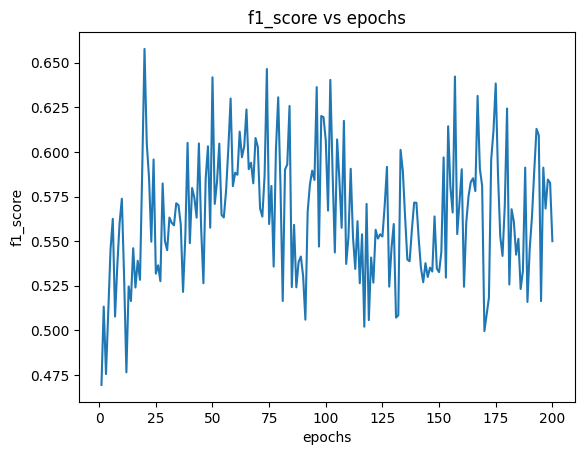

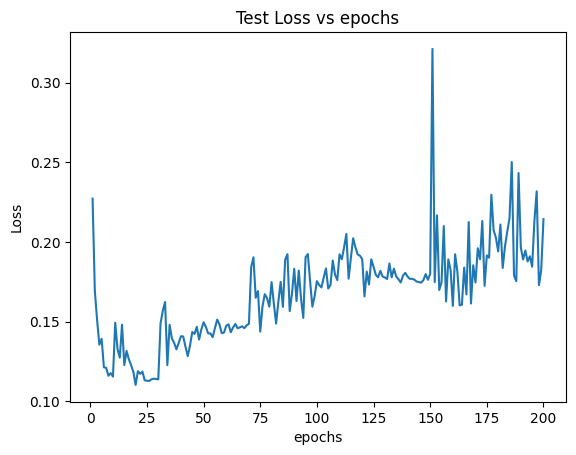

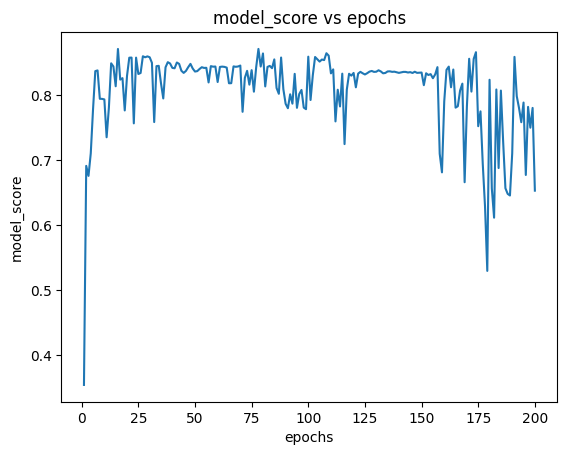

In [8]:
K = len(f1_arr)+1
plt.figure(1)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), f1_arr)
plt.xlabel("epochs")
plt.ylabel("f1_score")
plt.title('f1_score vs epochs')

plt.figure(2)
#plt.plot(sorted(list(set(roc_epochs))), loss_arr)
plt.plot(range(1,K), loss_arr)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title('Test Loss vs epochs')

plt.figure(3)
#plt.plot(sorted(list(set(roc_epochs))), f1_arr)
plt.plot(range(1,K), model_arr)
plt.xlabel("epochs")
plt.ylabel("model_score")
plt.title('model_score vs epochs')

print(max_ms)   

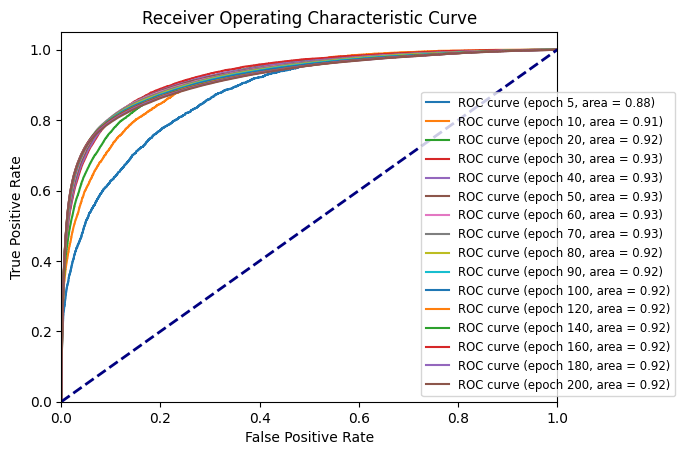

In [9]:
# plot ROC curve
fig2, ax2 = plt.subplots()
for i in range(len(roc_auc)):
    ax2.plot(roc_fpr[i], roc_tpr[i], label=f'ROC curve (epoch {roc_epochs[i]}, area = {roc_auc[i]:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic Curve')
# Set the properties for the legend
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize='small', framealpha=0.8)

In [10]:
import IPython

IPython.Application.instance().kernel.do_shutdown(True)  # Restart kernel with True flag

{'status': 'ok', 'restart': True}

: 